In [1]:
import cv2
import numpy as np
import pickle, os, sqlite3, random

image_x, image_y = 50, 50

def get_hand_hist():
    with open("hist", "rb") as f:
        hist = pickle.load(f)
    return hist

def init_create_folder_database():
    if not os.path.exists("gestures"):
        os.mkdir("gestures")
    if not os.path.exists("gesture_db.db"):
        conn = sqlite3.connect("gesture_db.db")
        create_table_cmd = "CREATE TABLE gesture ( g_id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, g_name TEXT NOT NULL )"
        conn.execute(create_table_cmd)
        conn.commit()

def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

def store_in_db(g_id, g_name):
    conn = sqlite3.connect("gesture_db.db")
    cmd = "INSERT INTO gesture (g_id, g_name) VALUES (%s, \'%s\')" % (g_id, g_name)
    try:
        conn.execute(cmd)
    except sqlite3.IntegrityError:
        choice = input("g_id already exists. Want to change the record? (y/n): ")
        if choice.lower() == 'y':
            cmd = "UPDATE gesture SET g_name = \'%s\' WHERE g_id = %s" % (g_name, g_id)
            conn.execute(cmd)
        else:
            print("Doing nothing...")
            return
    conn.commit()

    
def store_images(g_id):
    total_pics = 2000
    hist = get_hand_hist()
    cam = cv2.VideoCapture(0)
    if cam.read()[0]==False:
        cam = cv2.VideoCapture(0)
    x, y, w, h = 300, 100, 300, 300

    create_folder("gestures2/"+str(g_id))
    pic_no = 0
    flag_start_capturing = False
    frames = 0

    while True:
        img = cam.read()[1]
        img = cv2.flip(img, 1)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #grayscale = grayscale[y:y+h, x:x+w]
        imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        imghsv = imgHSV[y:y+h, x:x+w]
       # hist =  cv2.calcHist([ROI],[0, 1], None, [180, 256], [0, 180, 0, 256])
        dst = cv2.calcBackProject([imgHSV], [0, 1], hist, [0, 180, 0, 256], 1)
        dst1 = dst.copy()
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
        cv2.filter2D(dst,-1,disc,dst)
        blur = cv2.GaussianBlur(dst, (11,11), 0)
        gblur = blur[y:y+h, x:x+w]
        blur = cv2.medianBlur(blur, 11)
        #ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #thresh = cv2.merge((thresh,thresh,thresh))
        #thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        #cv2.imshow("HSV", imghsv)
        #cv2.imshow("GaussianBlur", gblur)
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        thresh = cv2.threshold(th3, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
        thresh = cv2.merge((thresh,thresh,thresh))
        thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        thresh = thresh[y:y+h, x:x+w]
        tmp = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contours = tmp[0] if len(tmp) == 2 else tmp[1]

        if len(contours) > 0:
            contour = max(contours, key = cv2.contourArea)
            if cv2.contourArea(contour) > 10000 and frames > 50:
                x1, y1, w1, h1 = cv2.boundingRect(contour)
                pic_no += 1
                save_img = thresh[y1:y1+h1, x1:x1+w1]
                if w1 > h1:
                    save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                elif h1 > w1:
                    save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))
                save_img = cv2.resize(save_img, (image_x, image_y))
                rand = random.randint(0, 10)
                if rand % 2 == 0:
                    save_img = cv2.flip(save_img, 1)
                cv2.putText(img, "Capturing...", (30, 60), cv2.FONT_HERSHEY_TRIPLEX, 2, (127, 255, 255))
                cv2.imwrite("gestures2/"+str(g_id)+"/"+str(pic_no)+".jpg", save_img)

        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img, str(pic_no), (30, 400), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (127, 127, 255))
        cv2.imshow("Capturing gesture", img)
        cv2.imshow("thresh", thresh)
        keypress = cv2.waitKey(1)
        if keypress == ord('c'):
            if flag_start_capturing == False:
                flag_start_capturing = True
            else:
                flag_start_capturing = False
                frames = 0
        if flag_start_capturing == True:
            frames += 1
        if pic_no == total_pics:
            cv2.destroyAllWindows()
            break
        if keypress == 27:
            cv2.destroyAllWindows()
            break

init_create_folder_database()
g_id = input("Enter gesture no.: ")
g_name = input("Enter gesture name/text: ")
store_in_db(g_id, g_name)
store_images(g_id)

Enter gesture no.: 26
Enter gesture name/text: ok
g_id already exists. Want to change the record? (y/n): y


In [2]:
import cv2, os

def flip_images():
    gest_folder = "gestures2/26"
    images_labels = []
    images = []
    labels = []
    for i in range(1, 2000):
        path = gest_folder+"/"+str(i+1)+".jpg"
        new_path = gest_folder+"/"+str(i+1+2000)+".jpg"
        print(path)
        img = cv2.imread(path, 0)
        img = cv2.flip(img, 1)
        cv2.imwrite(new_path, img)

flip_images()

gestures2/26/2.jpg
gestures2/26/3.jpg
gestures2/26/4.jpg
gestures2/26/5.jpg
gestures2/26/6.jpg
gestures2/26/7.jpg
gestures2/26/8.jpg
gestures2/26/9.jpg
gestures2/26/10.jpg
gestures2/26/11.jpg
gestures2/26/12.jpg
gestures2/26/13.jpg
gestures2/26/14.jpg
gestures2/26/15.jpg
gestures2/26/16.jpg
gestures2/26/17.jpg
gestures2/26/18.jpg
gestures2/26/19.jpg
gestures2/26/20.jpg
gestures2/26/21.jpg
gestures2/26/22.jpg
gestures2/26/23.jpg
gestures2/26/24.jpg
gestures2/26/25.jpg
gestures2/26/26.jpg
gestures2/26/27.jpg
gestures2/26/28.jpg
gestures2/26/29.jpg
gestures2/26/30.jpg
gestures2/26/31.jpg
gestures2/26/32.jpg
gestures2/26/33.jpg
gestures2/26/34.jpg
gestures2/26/35.jpg
gestures2/26/36.jpg
gestures2/26/37.jpg
gestures2/26/38.jpg
gestures2/26/39.jpg
gestures2/26/40.jpg
gestures2/26/41.jpg
gestures2/26/42.jpg
gestures2/26/43.jpg
gestures2/26/44.jpg
gestures2/26/45.jpg
gestures2/26/46.jpg
gestures2/26/47.jpg
gestures2/26/48.jpg
gestures2/26/49.jpg
gestures2/26/50.jpg
gestures2/26/51.jpg
gestures

gestures2/26/421.jpg
gestures2/26/422.jpg
gestures2/26/423.jpg
gestures2/26/424.jpg
gestures2/26/425.jpg
gestures2/26/426.jpg
gestures2/26/427.jpg
gestures2/26/428.jpg
gestures2/26/429.jpg
gestures2/26/430.jpg
gestures2/26/431.jpg
gestures2/26/432.jpg
gestures2/26/433.jpg
gestures2/26/434.jpg
gestures2/26/435.jpg
gestures2/26/436.jpg
gestures2/26/437.jpg
gestures2/26/438.jpg
gestures2/26/439.jpg
gestures2/26/440.jpg
gestures2/26/441.jpg
gestures2/26/442.jpg
gestures2/26/443.jpg
gestures2/26/444.jpg
gestures2/26/445.jpg
gestures2/26/446.jpg
gestures2/26/447.jpg
gestures2/26/448.jpg
gestures2/26/449.jpg
gestures2/26/450.jpg
gestures2/26/451.jpg
gestures2/26/452.jpg
gestures2/26/453.jpg
gestures2/26/454.jpg
gestures2/26/455.jpg
gestures2/26/456.jpg
gestures2/26/457.jpg
gestures2/26/458.jpg
gestures2/26/459.jpg
gestures2/26/460.jpg
gestures2/26/461.jpg
gestures2/26/462.jpg
gestures2/26/463.jpg
gestures2/26/464.jpg
gestures2/26/465.jpg
gestures2/26/466.jpg
gestures2/26/467.jpg
gestures2/26/

gestures2/26/834.jpg
gestures2/26/835.jpg
gestures2/26/836.jpg
gestures2/26/837.jpg
gestures2/26/838.jpg
gestures2/26/839.jpg
gestures2/26/840.jpg
gestures2/26/841.jpg
gestures2/26/842.jpg
gestures2/26/843.jpg
gestures2/26/844.jpg
gestures2/26/845.jpg
gestures2/26/846.jpg
gestures2/26/847.jpg
gestures2/26/848.jpg
gestures2/26/849.jpg
gestures2/26/850.jpg
gestures2/26/851.jpg
gestures2/26/852.jpg
gestures2/26/853.jpg
gestures2/26/854.jpg
gestures2/26/855.jpg
gestures2/26/856.jpg
gestures2/26/857.jpg
gestures2/26/858.jpg
gestures2/26/859.jpg
gestures2/26/860.jpg
gestures2/26/861.jpg
gestures2/26/862.jpg
gestures2/26/863.jpg
gestures2/26/864.jpg
gestures2/26/865.jpg
gestures2/26/866.jpg
gestures2/26/867.jpg
gestures2/26/868.jpg
gestures2/26/869.jpg
gestures2/26/870.jpg
gestures2/26/871.jpg
gestures2/26/872.jpg
gestures2/26/873.jpg
gestures2/26/874.jpg
gestures2/26/875.jpg
gestures2/26/876.jpg
gestures2/26/877.jpg
gestures2/26/878.jpg
gestures2/26/879.jpg
gestures2/26/880.jpg
gestures2/26/

gestures2/26/1227.jpg
gestures2/26/1228.jpg
gestures2/26/1229.jpg
gestures2/26/1230.jpg
gestures2/26/1231.jpg
gestures2/26/1232.jpg
gestures2/26/1233.jpg
gestures2/26/1234.jpg
gestures2/26/1235.jpg
gestures2/26/1236.jpg
gestures2/26/1237.jpg
gestures2/26/1238.jpg
gestures2/26/1239.jpg
gestures2/26/1240.jpg
gestures2/26/1241.jpg
gestures2/26/1242.jpg
gestures2/26/1243.jpg
gestures2/26/1244.jpg
gestures2/26/1245.jpg
gestures2/26/1246.jpg
gestures2/26/1247.jpg
gestures2/26/1248.jpg
gestures2/26/1249.jpg
gestures2/26/1250.jpg
gestures2/26/1251.jpg
gestures2/26/1252.jpg
gestures2/26/1253.jpg
gestures2/26/1254.jpg
gestures2/26/1255.jpg
gestures2/26/1256.jpg
gestures2/26/1257.jpg
gestures2/26/1258.jpg
gestures2/26/1259.jpg
gestures2/26/1260.jpg
gestures2/26/1261.jpg
gestures2/26/1262.jpg
gestures2/26/1263.jpg
gestures2/26/1264.jpg
gestures2/26/1265.jpg
gestures2/26/1266.jpg
gestures2/26/1267.jpg
gestures2/26/1268.jpg
gestures2/26/1269.jpg
gestures2/26/1270.jpg
gestures2/26/1271.jpg
gestures2/

gestures2/26/1615.jpg
gestures2/26/1616.jpg
gestures2/26/1617.jpg
gestures2/26/1618.jpg
gestures2/26/1619.jpg
gestures2/26/1620.jpg
gestures2/26/1621.jpg
gestures2/26/1622.jpg
gestures2/26/1623.jpg
gestures2/26/1624.jpg
gestures2/26/1625.jpg
gestures2/26/1626.jpg
gestures2/26/1627.jpg
gestures2/26/1628.jpg
gestures2/26/1629.jpg
gestures2/26/1630.jpg
gestures2/26/1631.jpg
gestures2/26/1632.jpg
gestures2/26/1633.jpg
gestures2/26/1634.jpg
gestures2/26/1635.jpg
gestures2/26/1636.jpg
gestures2/26/1637.jpg
gestures2/26/1638.jpg
gestures2/26/1639.jpg
gestures2/26/1640.jpg
gestures2/26/1641.jpg
gestures2/26/1642.jpg
gestures2/26/1643.jpg
gestures2/26/1644.jpg
gestures2/26/1645.jpg
gestures2/26/1646.jpg
gestures2/26/1647.jpg
gestures2/26/1648.jpg
gestures2/26/1649.jpg
gestures2/26/1650.jpg
gestures2/26/1651.jpg
gestures2/26/1652.jpg
gestures2/26/1653.jpg
gestures2/26/1654.jpg
gestures2/26/1655.jpg
gestures2/26/1656.jpg
gestures2/26/1657.jpg
gestures2/26/1658.jpg
gestures2/26/1659.jpg
gestures2/

In [5]:
import cv2, os

def flip_images():
    gest_folder = "gestures2"
    images_labels = []
    images = []
    labels = []
    for g_id in os.listdir(gest_folder):
        for i in range(4501, 6000):
            path = gest_folder+"/"+g_id+"/"+str(i+1)+".jpg"
            new_path = gest_folder+"/"+g_id+"/"+str(i+1+6001)+".jpg"
            print(path)
            img = cv2.imread(path, 0)
            img = cv2.flip(img, 1)
            cv2.imwrite(new_path, img)

flip_images()

gestures2/1/4502.jpg


error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgcodecs\src\loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [6]:
import cv2
from glob import glob
import numpy as np
import random
from sklearn.utils import shuffle
import pickle
import os

def pickle_images_labels():
    images_labels = []
    images = glob("gestures2/*/*.jpg")
    images.sort()
    for image in images:
        print(image)
        label = image[image.find(os.sep)+1: image.rfind(os.sep)]
        img = cv2.imread(image, 0)
        images_labels.append((np.array(img, dtype=np.uint8), int(label)))
    return images_labels

images_labels = pickle_images_labels()
images_labels = shuffle(shuffle(shuffle(shuffle(images_labels))))
images, labels = zip(*images_labels)
print("Length of images_labels", len(images_labels))

train_images = images[:int(5/6*len(images))]
print("Length of train_images", len(train_images))
with open("train_images", "wb") as f:
    pickle.dump(train_images, f)
del train_images

train_labels = labels[:int(5/6*len(labels))]
print("Length of train_labels", len(train_labels))
with open("train_labels", "wb") as f:
    pickle.dump(train_labels, f)
del train_labels

test_images = images[int(5/6*len(images)):int(11/12*len(images))]
print("Length of test_images", len(test_images))
with open("test_images", "wb") as f:
    pickle.dump(test_images, f)
del test_images

test_labels = labels[int(5/6*len(labels)):int(11/12*len(images))]
print("Length of test_labels", len(test_labels))
with open("test_labels", "wb") as f:
    pickle.dump(test_labels, f)
del test_labels

val_images = images[int(11/12*len(images)):]
print("Length of test_images", len(val_images))
with open("val_images", "wb") as f:
    pickle.dump(val_images, f)
del val_images

val_labels = labels[int(11/12*len(labels)):]
print("Length of val_labels", len(val_labels))
with open("val_labels", "wb") as f:
    pickle.dump(val_labels, f)
del val_labels

gestures2\10\1.jpg
gestures2\10\10.jpg
gestures2\10\100.jpg
gestures2\10\1000.jpg
gestures2\10\10000.jpg
gestures2\10\1001.jpg
gestures2\10\1002.jpg
gestures2\10\1003.jpg
gestures2\10\1004.jpg
gestures2\10\1005.jpg
gestures2\10\1006.jpg
gestures2\10\1007.jpg
gestures2\10\1008.jpg
gestures2\10\1009.jpg
gestures2\10\101.jpg
gestures2\10\1010.jpg
gestures2\10\1011.jpg
gestures2\10\1012.jpg
gestures2\10\1013.jpg
gestures2\10\1014.jpg
gestures2\10\1015.jpg
gestures2\10\1016.jpg
gestures2\10\1017.jpg
gestures2\10\1018.jpg
gestures2\10\1019.jpg
gestures2\10\102.jpg
gestures2\10\1020.jpg
gestures2\10\1021.jpg
gestures2\10\1022.jpg
gestures2\10\1023.jpg
gestures2\10\1024.jpg
gestures2\10\1025.jpg
gestures2\10\1026.jpg
gestures2\10\1027.jpg
gestures2\10\1028.jpg
gestures2\10\1029.jpg
gestures2\10\103.jpg
gestures2\10\1030.jpg
gestures2\10\1031.jpg
gestures2\10\1032.jpg
gestures2\10\1033.jpg
gestures2\10\1034.jpg
gestures2\10\1035.jpg
gestures2\10\1036.jpg
gestures2\10\1037.jpg
gestures2\10\1038.

gestures2\10\1335.jpg
gestures2\10\1336.jpg
gestures2\10\1337.jpg
gestures2\10\1338.jpg
gestures2\10\1339.jpg
gestures2\10\134.jpg
gestures2\10\1340.jpg
gestures2\10\1341.jpg
gestures2\10\1342.jpg
gestures2\10\1343.jpg
gestures2\10\1344.jpg
gestures2\10\1345.jpg
gestures2\10\1346.jpg
gestures2\10\1347.jpg
gestures2\10\1348.jpg
gestures2\10\1349.jpg
gestures2\10\135.jpg
gestures2\10\1350.jpg
gestures2\10\1351.jpg
gestures2\10\1352.jpg
gestures2\10\1353.jpg
gestures2\10\1354.jpg
gestures2\10\1355.jpg
gestures2\10\1356.jpg
gestures2\10\1357.jpg
gestures2\10\1358.jpg
gestures2\10\1359.jpg
gestures2\10\136.jpg
gestures2\10\1360.jpg
gestures2\10\1361.jpg
gestures2\10\1362.jpg
gestures2\10\1363.jpg
gestures2\10\1364.jpg
gestures2\10\1365.jpg
gestures2\10\1366.jpg
gestures2\10\1367.jpg
gestures2\10\1368.jpg
gestures2\10\1369.jpg
gestures2\10\137.jpg
gestures2\10\1370.jpg
gestures2\10\1371.jpg
gestures2\10\1372.jpg
gestures2\10\1373.jpg
gestures2\10\1374.jpg
gestures2\10\1375.jpg
gestures2\10\1

gestures2\10\1689.jpg
gestures2\10\169.jpg
gestures2\10\1690.jpg
gestures2\10\1691.jpg
gestures2\10\1692.jpg
gestures2\10\1693.jpg
gestures2\10\1694.jpg
gestures2\10\1695.jpg
gestures2\10\1696.jpg
gestures2\10\1697.jpg
gestures2\10\1698.jpg
gestures2\10\1699.jpg
gestures2\10\17.jpg
gestures2\10\170.jpg
gestures2\10\1700.jpg
gestures2\10\1701.jpg
gestures2\10\1702.jpg
gestures2\10\1703.jpg
gestures2\10\1704.jpg
gestures2\10\1705.jpg
gestures2\10\1706.jpg
gestures2\10\1707.jpg
gestures2\10\1708.jpg
gestures2\10\1709.jpg
gestures2\10\171.jpg
gestures2\10\1710.jpg
gestures2\10\1711.jpg
gestures2\10\1712.jpg
gestures2\10\1713.jpg
gestures2\10\1714.jpg
gestures2\10\1715.jpg
gestures2\10\1716.jpg
gestures2\10\1717.jpg
gestures2\10\1718.jpg
gestures2\10\1719.jpg
gestures2\10\172.jpg
gestures2\10\1720.jpg
gestures2\10\1721.jpg
gestures2\10\1722.jpg
gestures2\10\1723.jpg
gestures2\10\1724.jpg
gestures2\10\1725.jpg
gestures2\10\1726.jpg
gestures2\10\1727.jpg
gestures2\10\1728.jpg
gestures2\10\172

gestures2\10\2037.jpg
gestures2\10\2038.jpg
gestures2\10\2039.jpg
gestures2\10\204.jpg
gestures2\10\2040.jpg
gestures2\10\2041.jpg
gestures2\10\2042.jpg
gestures2\10\2043.jpg
gestures2\10\2044.jpg
gestures2\10\2045.jpg
gestures2\10\2046.jpg
gestures2\10\2047.jpg
gestures2\10\2048.jpg
gestures2\10\2049.jpg
gestures2\10\205.jpg
gestures2\10\2050.jpg
gestures2\10\2051.jpg
gestures2\10\2052.jpg
gestures2\10\2053.jpg
gestures2\10\2054.jpg
gestures2\10\2055.jpg
gestures2\10\2056.jpg
gestures2\10\2057.jpg
gestures2\10\2058.jpg
gestures2\10\2059.jpg
gestures2\10\206.jpg
gestures2\10\2060.jpg
gestures2\10\2061.jpg
gestures2\10\2062.jpg
gestures2\10\2063.jpg
gestures2\10\2064.jpg
gestures2\10\2065.jpg
gestures2\10\2066.jpg
gestures2\10\2067.jpg
gestures2\10\2068.jpg
gestures2\10\2069.jpg
gestures2\10\207.jpg
gestures2\10\2070.jpg
gestures2\10\2071.jpg
gestures2\10\2072.jpg
gestures2\10\2073.jpg
gestures2\10\2074.jpg
gestures2\10\2075.jpg
gestures2\10\2076.jpg
gestures2\10\2077.jpg
gestures2\10\2

gestures2\10\2387.jpg
gestures2\10\2388.jpg
gestures2\10\2389.jpg
gestures2\10\239.jpg
gestures2\10\2390.jpg
gestures2\10\2391.jpg
gestures2\10\2392.jpg
gestures2\10\2393.jpg
gestures2\10\2394.jpg
gestures2\10\2395.jpg
gestures2\10\2396.jpg
gestures2\10\2397.jpg
gestures2\10\2398.jpg
gestures2\10\2399.jpg
gestures2\10\24.jpg
gestures2\10\240.jpg
gestures2\10\2400.jpg
gestures2\10\2401.jpg
gestures2\10\2402.jpg
gestures2\10\2403.jpg
gestures2\10\2404.jpg
gestures2\10\2405.jpg
gestures2\10\2406.jpg
gestures2\10\2407.jpg
gestures2\10\2408.jpg
gestures2\10\2409.jpg
gestures2\10\241.jpg
gestures2\10\2410.jpg
gestures2\10\2411.jpg
gestures2\10\2412.jpg
gestures2\10\2413.jpg
gestures2\10\2414.jpg
gestures2\10\2415.jpg
gestures2\10\2416.jpg
gestures2\10\2417.jpg
gestures2\10\2418.jpg
gestures2\10\2419.jpg
gestures2\10\242.jpg
gestures2\10\2420.jpg
gestures2\10\2421.jpg
gestures2\10\2422.jpg
gestures2\10\2423.jpg
gestures2\10\2424.jpg
gestures2\10\2425.jpg
gestures2\10\2426.jpg
gestures2\10\242

gestures2\10\2727.jpg
gestures2\10\2728.jpg
gestures2\10\2729.jpg
gestures2\10\273.jpg
gestures2\10\2730.jpg
gestures2\10\2731.jpg
gestures2\10\2732.jpg
gestures2\10\2733.jpg
gestures2\10\2734.jpg
gestures2\10\2735.jpg
gestures2\10\2736.jpg
gestures2\10\2737.jpg
gestures2\10\2738.jpg
gestures2\10\2739.jpg
gestures2\10\274.jpg
gestures2\10\2740.jpg
gestures2\10\2741.jpg
gestures2\10\2742.jpg
gestures2\10\2743.jpg
gestures2\10\2744.jpg
gestures2\10\2745.jpg
gestures2\10\2746.jpg
gestures2\10\2747.jpg
gestures2\10\2748.jpg
gestures2\10\2749.jpg
gestures2\10\275.jpg
gestures2\10\2750.jpg
gestures2\10\2751.jpg
gestures2\10\2752.jpg
gestures2\10\2753.jpg
gestures2\10\2754.jpg
gestures2\10\2755.jpg
gestures2\10\2756.jpg
gestures2\10\2757.jpg
gestures2\10\2758.jpg
gestures2\10\2759.jpg
gestures2\10\276.jpg
gestures2\10\2760.jpg
gestures2\10\2761.jpg
gestures2\10\2762.jpg
gestures2\10\2763.jpg
gestures2\10\2764.jpg
gestures2\10\2765.jpg
gestures2\10\2766.jpg
gestures2\10\2767.jpg
gestures2\10\2

gestures2\10\3078.jpg
gestures2\10\3079.jpg
gestures2\10\308.jpg
gestures2\10\3080.jpg
gestures2\10\3081.jpg
gestures2\10\3082.jpg
gestures2\10\3083.jpg
gestures2\10\3084.jpg
gestures2\10\3085.jpg
gestures2\10\3086.jpg
gestures2\10\3087.jpg
gestures2\10\3088.jpg
gestures2\10\3089.jpg
gestures2\10\309.jpg
gestures2\10\3090.jpg
gestures2\10\3091.jpg
gestures2\10\3092.jpg
gestures2\10\3093.jpg
gestures2\10\3094.jpg
gestures2\10\3095.jpg
gestures2\10\3096.jpg
gestures2\10\3097.jpg
gestures2\10\3098.jpg
gestures2\10\3099.jpg
gestures2\10\31.jpg
gestures2\10\310.jpg
gestures2\10\3100.jpg
gestures2\10\3101.jpg
gestures2\10\3102.jpg
gestures2\10\3103.jpg
gestures2\10\3104.jpg
gestures2\10\3105.jpg
gestures2\10\3106.jpg
gestures2\10\3107.jpg
gestures2\10\3108.jpg
gestures2\10\3109.jpg
gestures2\10\311.jpg
gestures2\10\3110.jpg
gestures2\10\3111.jpg
gestures2\10\3112.jpg
gestures2\10\3113.jpg
gestures2\10\3114.jpg
gestures2\10\3115.jpg
gestures2\10\3116.jpg
gestures2\10\3117.jpg
gestures2\10\311

gestures2\10\3418.jpg
gestures2\10\3419.jpg
gestures2\10\342.jpg
gestures2\10\3420.jpg
gestures2\10\3421.jpg
gestures2\10\3422.jpg
gestures2\10\3423.jpg
gestures2\10\3424.jpg
gestures2\10\3425.jpg
gestures2\10\3426.jpg
gestures2\10\3427.jpg
gestures2\10\3428.jpg
gestures2\10\3429.jpg
gestures2\10\343.jpg
gestures2\10\3430.jpg
gestures2\10\3431.jpg
gestures2\10\3432.jpg
gestures2\10\3433.jpg
gestures2\10\3434.jpg
gestures2\10\3435.jpg
gestures2\10\3436.jpg
gestures2\10\3437.jpg
gestures2\10\3438.jpg
gestures2\10\3439.jpg
gestures2\10\344.jpg
gestures2\10\3440.jpg
gestures2\10\3441.jpg
gestures2\10\3442.jpg
gestures2\10\3443.jpg
gestures2\10\3444.jpg
gestures2\10\3445.jpg
gestures2\10\3446.jpg
gestures2\10\3447.jpg
gestures2\10\3448.jpg
gestures2\10\3449.jpg
gestures2\10\345.jpg
gestures2\10\3450.jpg
gestures2\10\3451.jpg
gestures2\10\3452.jpg
gestures2\10\3453.jpg
gestures2\10\3454.jpg
gestures2\10\3455.jpg
gestures2\10\3456.jpg
gestures2\10\3457.jpg
gestures2\10\3458.jpg
gestures2\10\3

gestures2\10\3757.jpg
gestures2\10\3758.jpg
gestures2\10\3759.jpg
gestures2\10\376.jpg
gestures2\10\3760.jpg
gestures2\10\3761.jpg
gestures2\10\3762.jpg
gestures2\10\3763.jpg
gestures2\10\3764.jpg
gestures2\10\3765.jpg
gestures2\10\3766.jpg
gestures2\10\3767.jpg
gestures2\10\3768.jpg
gestures2\10\3769.jpg
gestures2\10\377.jpg
gestures2\10\3770.jpg
gestures2\10\3771.jpg
gestures2\10\3772.jpg
gestures2\10\3773.jpg
gestures2\10\3774.jpg
gestures2\10\3775.jpg
gestures2\10\3776.jpg
gestures2\10\3777.jpg
gestures2\10\3778.jpg
gestures2\10\3779.jpg
gestures2\10\378.jpg
gestures2\10\3780.jpg
gestures2\10\3781.jpg
gestures2\10\3782.jpg
gestures2\10\3783.jpg
gestures2\10\3784.jpg
gestures2\10\3785.jpg
gestures2\10\3786.jpg
gestures2\10\3787.jpg
gestures2\10\3788.jpg
gestures2\10\3789.jpg
gestures2\10\379.jpg
gestures2\10\3790.jpg
gestures2\10\3791.jpg
gestures2\10\3792.jpg
gestures2\10\3793.jpg
gestures2\10\3794.jpg
gestures2\10\3795.jpg
gestures2\10\3796.jpg
gestures2\10\3797.jpg
gestures2\10\3

gestures2\10\41.jpg
gestures2\10\410.jpg
gestures2\10\4100.jpg
gestures2\10\4101.jpg
gestures2\10\4102.jpg
gestures2\10\4103.jpg
gestures2\10\4104.jpg
gestures2\10\4105.jpg
gestures2\10\4106.jpg
gestures2\10\4107.jpg
gestures2\10\4108.jpg
gestures2\10\4109.jpg
gestures2\10\411.jpg
gestures2\10\4110.jpg
gestures2\10\4111.jpg
gestures2\10\4112.jpg
gestures2\10\4113.jpg
gestures2\10\4114.jpg
gestures2\10\4115.jpg
gestures2\10\4116.jpg
gestures2\10\4117.jpg
gestures2\10\4118.jpg
gestures2\10\4119.jpg
gestures2\10\412.jpg
gestures2\10\4120.jpg
gestures2\10\4121.jpg
gestures2\10\4122.jpg
gestures2\10\4123.jpg
gestures2\10\4124.jpg
gestures2\10\4125.jpg
gestures2\10\4126.jpg
gestures2\10\4127.jpg
gestures2\10\4128.jpg
gestures2\10\4129.jpg
gestures2\10\413.jpg
gestures2\10\4130.jpg
gestures2\10\4131.jpg
gestures2\10\4132.jpg
gestures2\10\4133.jpg
gestures2\10\4134.jpg
gestures2\10\4135.jpg
gestures2\10\4136.jpg
gestures2\10\4137.jpg
gestures2\10\4138.jpg
gestures2\10\4139.jpg
gestures2\10\414

gestures2\10\4439.jpg
gestures2\10\444.jpg
gestures2\10\4440.jpg
gestures2\10\4441.jpg
gestures2\10\4442.jpg
gestures2\10\4443.jpg
gestures2\10\4444.jpg
gestures2\10\4445.jpg
gestures2\10\4446.jpg
gestures2\10\4447.jpg
gestures2\10\4448.jpg
gestures2\10\4449.jpg
gestures2\10\445.jpg
gestures2\10\4450.jpg
gestures2\10\4451.jpg
gestures2\10\4452.jpg
gestures2\10\4453.jpg
gestures2\10\4454.jpg
gestures2\10\4455.jpg
gestures2\10\4456.jpg
gestures2\10\4457.jpg
gestures2\10\4458.jpg
gestures2\10\4459.jpg
gestures2\10\446.jpg
gestures2\10\4460.jpg
gestures2\10\4461.jpg
gestures2\10\4462.jpg
gestures2\10\4463.jpg
gestures2\10\4464.jpg
gestures2\10\4465.jpg
gestures2\10\4466.jpg
gestures2\10\4467.jpg
gestures2\10\4468.jpg
gestures2\10\4469.jpg
gestures2\10\447.jpg
gestures2\10\4470.jpg
gestures2\10\4471.jpg
gestures2\10\4472.jpg
gestures2\10\4473.jpg
gestures2\10\4474.jpg
gestures2\10\4475.jpg
gestures2\10\4476.jpg
gestures2\10\4477.jpg
gestures2\10\4478.jpg
gestures2\10\4479.jpg
gestures2\10\4

gestures2\10\742.jpg
gestures2\10\743.jpg
gestures2\10\744.jpg
gestures2\10\745.jpg
gestures2\10\746.jpg
gestures2\10\747.jpg
gestures2\10\748.jpg
gestures2\10\749.jpg
gestures2\10\75.jpg
gestures2\10\750.jpg
gestures2\10\7502.jpg
gestures2\10\7503.jpg
gestures2\10\7504.jpg
gestures2\10\7505.jpg
gestures2\10\7506.jpg
gestures2\10\7507.jpg
gestures2\10\7508.jpg
gestures2\10\7509.jpg
gestures2\10\751.jpg
gestures2\10\7510.jpg
gestures2\10\7511.jpg
gestures2\10\7512.jpg
gestures2\10\7513.jpg
gestures2\10\7514.jpg
gestures2\10\7515.jpg
gestures2\10\7516.jpg
gestures2\10\7517.jpg
gestures2\10\7518.jpg
gestures2\10\7519.jpg
gestures2\10\752.jpg
gestures2\10\7520.jpg
gestures2\10\7521.jpg
gestures2\10\7522.jpg
gestures2\10\7523.jpg
gestures2\10\7524.jpg
gestures2\10\7525.jpg
gestures2\10\7526.jpg
gestures2\10\7527.jpg
gestures2\10\7528.jpg
gestures2\10\7529.jpg
gestures2\10\753.jpg
gestures2\10\7530.jpg
gestures2\10\7531.jpg
gestures2\10\7532.jpg
gestures2\10\7533.jpg
gestures2\10\7534.jpg
ge

gestures2\10\784.jpg
gestures2\10\7840.jpg
gestures2\10\7841.jpg
gestures2\10\7842.jpg
gestures2\10\7843.jpg
gestures2\10\7844.jpg
gestures2\10\7845.jpg
gestures2\10\7846.jpg
gestures2\10\7847.jpg
gestures2\10\7848.jpg
gestures2\10\7849.jpg
gestures2\10\785.jpg
gestures2\10\7850.jpg
gestures2\10\7851.jpg
gestures2\10\7852.jpg
gestures2\10\7853.jpg
gestures2\10\7854.jpg
gestures2\10\7855.jpg
gestures2\10\7856.jpg
gestures2\10\7857.jpg
gestures2\10\7858.jpg
gestures2\10\7859.jpg
gestures2\10\786.jpg
gestures2\10\7860.jpg
gestures2\10\7861.jpg
gestures2\10\7862.jpg
gestures2\10\7863.jpg
gestures2\10\7864.jpg
gestures2\10\7865.jpg
gestures2\10\7866.jpg
gestures2\10\7867.jpg
gestures2\10\7868.jpg
gestures2\10\7869.jpg
gestures2\10\787.jpg
gestures2\10\7870.jpg
gestures2\10\7871.jpg
gestures2\10\7872.jpg
gestures2\10\7873.jpg
gestures2\10\7874.jpg
gestures2\10\7875.jpg
gestures2\10\7876.jpg
gestures2\10\7877.jpg
gestures2\10\7878.jpg
gestures2\10\7879.jpg
gestures2\10\788.jpg
gestures2\10\78

gestures2\10\8181.jpg
gestures2\10\8182.jpg
gestures2\10\8183.jpg
gestures2\10\8184.jpg
gestures2\10\8185.jpg
gestures2\10\8186.jpg
gestures2\10\8187.jpg
gestures2\10\8188.jpg
gestures2\10\8189.jpg
gestures2\10\819.jpg
gestures2\10\8190.jpg
gestures2\10\8191.jpg
gestures2\10\8192.jpg
gestures2\10\8193.jpg
gestures2\10\8194.jpg
gestures2\10\8195.jpg
gestures2\10\8196.jpg
gestures2\10\8197.jpg
gestures2\10\8198.jpg
gestures2\10\8199.jpg
gestures2\10\82.jpg
gestures2\10\820.jpg
gestures2\10\8200.jpg
gestures2\10\8201.jpg
gestures2\10\8202.jpg
gestures2\10\8203.jpg
gestures2\10\8204.jpg
gestures2\10\8205.jpg
gestures2\10\8206.jpg
gestures2\10\8207.jpg
gestures2\10\8208.jpg
gestures2\10\8209.jpg
gestures2\10\821.jpg
gestures2\10\8210.jpg
gestures2\10\8211.jpg
gestures2\10\8212.jpg
gestures2\10\8213.jpg
gestures2\10\8214.jpg
gestures2\10\8215.jpg
gestures2\10\8216.jpg
gestures2\10\8217.jpg
gestures2\10\8218.jpg
gestures2\10\8219.jpg
gestures2\10\822.jpg
gestures2\10\8220.jpg
gestures2\10\822

gestures2\10\8524.jpg
gestures2\10\8525.jpg
gestures2\10\8526.jpg
gestures2\10\8527.jpg
gestures2\10\8528.jpg
gestures2\10\8529.jpg
gestures2\10\853.jpg
gestures2\10\8530.jpg
gestures2\10\8531.jpg
gestures2\10\8532.jpg
gestures2\10\8533.jpg
gestures2\10\8534.jpg
gestures2\10\8535.jpg
gestures2\10\8536.jpg
gestures2\10\8537.jpg
gestures2\10\8538.jpg
gestures2\10\8539.jpg
gestures2\10\854.jpg
gestures2\10\8540.jpg
gestures2\10\8541.jpg
gestures2\10\8542.jpg
gestures2\10\8543.jpg
gestures2\10\8544.jpg
gestures2\10\8545.jpg
gestures2\10\8546.jpg
gestures2\10\8547.jpg
gestures2\10\8548.jpg
gestures2\10\8549.jpg
gestures2\10\855.jpg
gestures2\10\8550.jpg
gestures2\10\8551.jpg
gestures2\10\8552.jpg
gestures2\10\8553.jpg
gestures2\10\8554.jpg
gestures2\10\8555.jpg
gestures2\10\8556.jpg
gestures2\10\8557.jpg
gestures2\10\8558.jpg
gestures2\10\8559.jpg
gestures2\10\856.jpg
gestures2\10\8560.jpg
gestures2\10\8561.jpg
gestures2\10\8562.jpg
gestures2\10\8563.jpg
gestures2\10\8564.jpg
gestures2\10\8

gestures2\10\8865.jpg
gestures2\10\8866.jpg
gestures2\10\8867.jpg
gestures2\10\8868.jpg
gestures2\10\8869.jpg
gestures2\10\887.jpg
gestures2\10\8870.jpg
gestures2\10\8871.jpg
gestures2\10\8872.jpg
gestures2\10\8873.jpg
gestures2\10\8874.jpg
gestures2\10\8875.jpg
gestures2\10\8876.jpg
gestures2\10\8877.jpg
gestures2\10\8878.jpg
gestures2\10\8879.jpg
gestures2\10\888.jpg
gestures2\10\8880.jpg
gestures2\10\8881.jpg
gestures2\10\8882.jpg
gestures2\10\8883.jpg
gestures2\10\8884.jpg
gestures2\10\8885.jpg
gestures2\10\8886.jpg
gestures2\10\8887.jpg
gestures2\10\8888.jpg
gestures2\10\8889.jpg
gestures2\10\889.jpg
gestures2\10\8890.jpg
gestures2\10\8891.jpg
gestures2\10\8892.jpg
gestures2\10\8893.jpg
gestures2\10\8894.jpg
gestures2\10\8895.jpg
gestures2\10\8896.jpg
gestures2\10\8897.jpg
gestures2\10\8898.jpg
gestures2\10\8899.jpg
gestures2\10\89.jpg
gestures2\10\890.jpg
gestures2\10\8900.jpg
gestures2\10\8901.jpg
gestures2\10\8902.jpg
gestures2\10\8903.jpg
gestures2\10\8904.jpg
gestures2\10\890

gestures2\10\9201.jpg
gestures2\10\9202.jpg
gestures2\10\9203.jpg
gestures2\10\9204.jpg
gestures2\10\9205.jpg
gestures2\10\9206.jpg
gestures2\10\9207.jpg
gestures2\10\9208.jpg
gestures2\10\9209.jpg
gestures2\10\921.jpg
gestures2\10\9210.jpg
gestures2\10\9211.jpg
gestures2\10\9212.jpg
gestures2\10\9213.jpg
gestures2\10\9214.jpg
gestures2\10\9215.jpg
gestures2\10\9216.jpg
gestures2\10\9217.jpg
gestures2\10\9218.jpg
gestures2\10\9219.jpg
gestures2\10\922.jpg
gestures2\10\9220.jpg
gestures2\10\9221.jpg
gestures2\10\9222.jpg
gestures2\10\9223.jpg
gestures2\10\9224.jpg
gestures2\10\9225.jpg
gestures2\10\9226.jpg
gestures2\10\9227.jpg
gestures2\10\9228.jpg
gestures2\10\9229.jpg
gestures2\10\923.jpg
gestures2\10\9230.jpg
gestures2\10\9231.jpg
gestures2\10\9232.jpg
gestures2\10\9233.jpg
gestures2\10\9234.jpg
gestures2\10\9235.jpg
gestures2\10\9236.jpg
gestures2\10\9237.jpg
gestures2\10\9238.jpg
gestures2\10\9239.jpg
gestures2\10\924.jpg
gestures2\10\9240.jpg
gestures2\10\9241.jpg
gestures2\10\9

gestures2\10\9541.jpg
gestures2\10\9542.jpg
gestures2\10\9543.jpg
gestures2\10\9544.jpg
gestures2\10\9545.jpg
gestures2\10\9546.jpg
gestures2\10\9547.jpg
gestures2\10\9548.jpg
gestures2\10\9549.jpg
gestures2\10\955.jpg
gestures2\10\9550.jpg
gestures2\10\9551.jpg
gestures2\10\9552.jpg
gestures2\10\9553.jpg
gestures2\10\9554.jpg
gestures2\10\9555.jpg
gestures2\10\9556.jpg
gestures2\10\9557.jpg
gestures2\10\9558.jpg
gestures2\10\9559.jpg
gestures2\10\956.jpg
gestures2\10\9560.jpg
gestures2\10\9561.jpg
gestures2\10\9562.jpg
gestures2\10\9563.jpg
gestures2\10\9564.jpg
gestures2\10\9565.jpg
gestures2\10\9566.jpg
gestures2\10\9567.jpg
gestures2\10\9568.jpg
gestures2\10\9569.jpg
gestures2\10\957.jpg
gestures2\10\9570.jpg
gestures2\10\9571.jpg
gestures2\10\9572.jpg
gestures2\10\9573.jpg
gestures2\10\9574.jpg
gestures2\10\9575.jpg
gestures2\10\9576.jpg
gestures2\10\9577.jpg
gestures2\10\9578.jpg
gestures2\10\9579.jpg
gestures2\10\958.jpg
gestures2\10\9580.jpg
gestures2\10\9581.jpg
gestures2\10\9

gestures2\10\988.jpg
gestures2\10\9880.jpg
gestures2\10\9881.jpg
gestures2\10\9882.jpg
gestures2\10\9883.jpg
gestures2\10\9884.jpg
gestures2\10\9885.jpg
gestures2\10\9886.jpg
gestures2\10\9887.jpg
gestures2\10\9888.jpg
gestures2\10\9889.jpg
gestures2\10\989.jpg
gestures2\10\9890.jpg
gestures2\10\9891.jpg
gestures2\10\9892.jpg
gestures2\10\9893.jpg
gestures2\10\9894.jpg
gestures2\10\9895.jpg
gestures2\10\9896.jpg
gestures2\10\9897.jpg
gestures2\10\9898.jpg
gestures2\10\9899.jpg
gestures2\10\99.jpg
gestures2\10\990.jpg
gestures2\10\9900.jpg
gestures2\10\9901.jpg
gestures2\10\9902.jpg
gestures2\10\9903.jpg
gestures2\10\9904.jpg
gestures2\10\9905.jpg
gestures2\10\9906.jpg
gestures2\10\9907.jpg
gestures2\10\9908.jpg
gestures2\10\9909.jpg
gestures2\10\991.jpg
gestures2\10\9910.jpg
gestures2\10\9911.jpg
gestures2\10\9912.jpg
gestures2\10\9913.jpg
gestures2\10\9914.jpg
gestures2\10\9915.jpg
gestures2\10\9916.jpg
gestures2\10\9917.jpg
gestures2\10\9918.jpg
gestures2\10\9919.jpg
gestures2\10\992

gestures2\11\1221.jpg
gestures2\11\1222.jpg
gestures2\11\1223.jpg
gestures2\11\1224.jpg
gestures2\11\1225.jpg
gestures2\11\1226.jpg
gestures2\11\1227.jpg
gestures2\11\1228.jpg
gestures2\11\1229.jpg
gestures2\11\123.jpg
gestures2\11\1230.jpg
gestures2\11\1231.jpg
gestures2\11\1232.jpg
gestures2\11\1233.jpg
gestures2\11\1234.jpg
gestures2\11\1235.jpg
gestures2\11\1236.jpg
gestures2\11\1237.jpg
gestures2\11\1238.jpg
gestures2\11\1239.jpg
gestures2\11\124.jpg
gestures2\11\1240.jpg
gestures2\11\1241.jpg
gestures2\11\1242.jpg
gestures2\11\1243.jpg
gestures2\11\1244.jpg
gestures2\11\1245.jpg
gestures2\11\1246.jpg
gestures2\11\1247.jpg
gestures2\11\1248.jpg
gestures2\11\1249.jpg
gestures2\11\125.jpg
gestures2\11\1250.jpg
gestures2\11\1251.jpg
gestures2\11\1252.jpg
gestures2\11\1253.jpg
gestures2\11\1254.jpg
gestures2\11\1255.jpg
gestures2\11\1256.jpg
gestures2\11\1257.jpg
gestures2\11\1258.jpg
gestures2\11\1259.jpg
gestures2\11\126.jpg
gestures2\11\1260.jpg
gestures2\11\1261.jpg
gestures2\11\1

gestures2\11\1569.jpg
gestures2\11\157.jpg
gestures2\11\1570.jpg
gestures2\11\1571.jpg
gestures2\11\1572.jpg
gestures2\11\1573.jpg
gestures2\11\1574.jpg
gestures2\11\1575.jpg
gestures2\11\1576.jpg
gestures2\11\1577.jpg
gestures2\11\1578.jpg
gestures2\11\1579.jpg
gestures2\11\158.jpg
gestures2\11\1580.jpg
gestures2\11\1581.jpg
gestures2\11\1582.jpg
gestures2\11\1583.jpg
gestures2\11\1584.jpg
gestures2\11\1585.jpg
gestures2\11\1586.jpg
gestures2\11\1587.jpg
gestures2\11\1588.jpg
gestures2\11\1589.jpg
gestures2\11\159.jpg
gestures2\11\1590.jpg
gestures2\11\1591.jpg
gestures2\11\1592.jpg
gestures2\11\1593.jpg
gestures2\11\1594.jpg
gestures2\11\1595.jpg
gestures2\11\1596.jpg
gestures2\11\1597.jpg
gestures2\11\1598.jpg
gestures2\11\1599.jpg
gestures2\11\16.jpg
gestures2\11\160.jpg
gestures2\11\1600.jpg
gestures2\11\1601.jpg
gestures2\11\1602.jpg
gestures2\11\1603.jpg
gestures2\11\1604.jpg
gestures2\11\1605.jpg
gestures2\11\1606.jpg
gestures2\11\1607.jpg
gestures2\11\1608.jpg
gestures2\11\160

gestures2\11\1911.jpg
gestures2\11\1912.jpg
gestures2\11\1913.jpg
gestures2\11\1914.jpg
gestures2\11\1915.jpg
gestures2\11\1916.jpg
gestures2\11\1917.jpg
gestures2\11\1918.jpg
gestures2\11\1919.jpg
gestures2\11\192.jpg
gestures2\11\1920.jpg
gestures2\11\1921.jpg
gestures2\11\1922.jpg
gestures2\11\1923.jpg
gestures2\11\1924.jpg
gestures2\11\1925.jpg
gestures2\11\1926.jpg
gestures2\11\1927.jpg
gestures2\11\1928.jpg
gestures2\11\1929.jpg
gestures2\11\193.jpg
gestures2\11\1930.jpg
gestures2\11\1931.jpg
gestures2\11\1932.jpg
gestures2\11\1933.jpg
gestures2\11\1934.jpg
gestures2\11\1935.jpg
gestures2\11\1936.jpg
gestures2\11\1937.jpg
gestures2\11\1938.jpg
gestures2\11\1939.jpg
gestures2\11\194.jpg
gestures2\11\1940.jpg
gestures2\11\1941.jpg
gestures2\11\1942.jpg
gestures2\11\1943.jpg
gestures2\11\1944.jpg
gestures2\11\1945.jpg
gestures2\11\1946.jpg
gestures2\11\1947.jpg
gestures2\11\1948.jpg
gestures2\11\1949.jpg
gestures2\11\195.jpg
gestures2\11\1950.jpg
gestures2\11\1951.jpg
gestures2\11\1

gestures2\11\225.jpg
gestures2\11\2250.jpg
gestures2\11\2251.jpg
gestures2\11\2252.jpg
gestures2\11\2253.jpg
gestures2\11\2254.jpg
gestures2\11\2255.jpg
gestures2\11\2256.jpg
gestures2\11\2257.jpg
gestures2\11\2258.jpg
gestures2\11\2259.jpg
gestures2\11\226.jpg
gestures2\11\2260.jpg
gestures2\11\2261.jpg
gestures2\11\2262.jpg
gestures2\11\2263.jpg
gestures2\11\2264.jpg
gestures2\11\2265.jpg
gestures2\11\2266.jpg
gestures2\11\2267.jpg
gestures2\11\2268.jpg
gestures2\11\2269.jpg
gestures2\11\227.jpg
gestures2\11\2270.jpg
gestures2\11\2271.jpg
gestures2\11\2272.jpg
gestures2\11\2273.jpg
gestures2\11\2274.jpg
gestures2\11\2275.jpg
gestures2\11\2276.jpg
gestures2\11\2277.jpg
gestures2\11\2278.jpg
gestures2\11\2279.jpg
gestures2\11\228.jpg
gestures2\11\2280.jpg
gestures2\11\2281.jpg
gestures2\11\2282.jpg
gestures2\11\2283.jpg
gestures2\11\2284.jpg
gestures2\11\2285.jpg
gestures2\11\2286.jpg
gestures2\11\2287.jpg
gestures2\11\2288.jpg
gestures2\11\2289.jpg
gestures2\11\229.jpg
gestures2\11\22

gestures2\11\2589.jpg
gestures2\11\259.jpg
gestures2\11\2590.jpg
gestures2\11\2591.jpg
gestures2\11\2592.jpg
gestures2\11\2593.jpg
gestures2\11\2594.jpg
gestures2\11\2595.jpg
gestures2\11\2596.jpg
gestures2\11\2597.jpg
gestures2\11\2598.jpg
gestures2\11\2599.jpg
gestures2\11\26.jpg
gestures2\11\260.jpg
gestures2\11\2600.jpg
gestures2\11\2601.jpg
gestures2\11\2602.jpg
gestures2\11\2603.jpg
gestures2\11\2604.jpg
gestures2\11\2605.jpg
gestures2\11\2606.jpg
gestures2\11\2607.jpg
gestures2\11\2608.jpg
gestures2\11\2609.jpg
gestures2\11\261.jpg
gestures2\11\2610.jpg
gestures2\11\2611.jpg
gestures2\11\2612.jpg
gestures2\11\2613.jpg
gestures2\11\2614.jpg
gestures2\11\2615.jpg
gestures2\11\2616.jpg
gestures2\11\2617.jpg
gestures2\11\2618.jpg
gestures2\11\2619.jpg
gestures2\11\262.jpg
gestures2\11\2620.jpg
gestures2\11\2621.jpg
gestures2\11\2622.jpg
gestures2\11\2623.jpg
gestures2\11\2624.jpg
gestures2\11\2625.jpg
gestures2\11\2626.jpg
gestures2\11\2627.jpg
gestures2\11\2628.jpg
gestures2\11\262

gestures2\11\2927.jpg
gestures2\11\2928.jpg
gestures2\11\2929.jpg
gestures2\11\293.jpg
gestures2\11\2930.jpg
gestures2\11\2931.jpg
gestures2\11\2932.jpg
gestures2\11\2933.jpg
gestures2\11\2934.jpg
gestures2\11\2935.jpg
gestures2\11\2936.jpg
gestures2\11\2937.jpg
gestures2\11\2938.jpg
gestures2\11\2939.jpg
gestures2\11\294.jpg
gestures2\11\2940.jpg
gestures2\11\2941.jpg
gestures2\11\2942.jpg
gestures2\11\2943.jpg
gestures2\11\2944.jpg
gestures2\11\2945.jpg
gestures2\11\2946.jpg
gestures2\11\2947.jpg
gestures2\11\2948.jpg
gestures2\11\2949.jpg
gestures2\11\295.jpg
gestures2\11\2950.jpg
gestures2\11\2951.jpg
gestures2\11\2952.jpg
gestures2\11\2953.jpg
gestures2\11\2954.jpg
gestures2\11\2955.jpg
gestures2\11\2956.jpg
gestures2\11\2957.jpg
gestures2\11\2958.jpg
gestures2\11\2959.jpg
gestures2\11\296.jpg
gestures2\11\2960.jpg
gestures2\11\2961.jpg
gestures2\11\2962.jpg
gestures2\11\2963.jpg
gestures2\11\2964.jpg
gestures2\11\2965.jpg
gestures2\11\2966.jpg
gestures2\11\2967.jpg
gestures2\11\2

gestures2\11\327.jpg
gestures2\11\3270.jpg
gestures2\11\3271.jpg
gestures2\11\3272.jpg
gestures2\11\3273.jpg
gestures2\11\3274.jpg
gestures2\11\3275.jpg
gestures2\11\3276.jpg
gestures2\11\3277.jpg
gestures2\11\3278.jpg
gestures2\11\3279.jpg
gestures2\11\328.jpg
gestures2\11\3280.jpg
gestures2\11\3281.jpg
gestures2\11\3282.jpg
gestures2\11\3283.jpg
gestures2\11\3284.jpg
gestures2\11\3285.jpg
gestures2\11\3286.jpg
gestures2\11\3287.jpg
gestures2\11\3288.jpg
gestures2\11\3289.jpg
gestures2\11\329.jpg
gestures2\11\3290.jpg
gestures2\11\3291.jpg
gestures2\11\3292.jpg
gestures2\11\3293.jpg
gestures2\11\3294.jpg
gestures2\11\3295.jpg
gestures2\11\3296.jpg
gestures2\11\3297.jpg
gestures2\11\3298.jpg
gestures2\11\3299.jpg
gestures2\11\33.jpg
gestures2\11\330.jpg
gestures2\11\3300.jpg
gestures2\11\3301.jpg
gestures2\11\3302.jpg
gestures2\11\3303.jpg
gestures2\11\3304.jpg
gestures2\11\3305.jpg
gestures2\11\3306.jpg
gestures2\11\3307.jpg
gestures2\11\3308.jpg
gestures2\11\3309.jpg
gestures2\11\331

gestures2\11\3606.jpg
gestures2\11\3607.jpg
gestures2\11\3608.jpg
gestures2\11\3609.jpg
gestures2\11\361.jpg
gestures2\11\3610.jpg
gestures2\11\3611.jpg
gestures2\11\3612.jpg
gestures2\11\3613.jpg
gestures2\11\3614.jpg
gestures2\11\3615.jpg
gestures2\11\3616.jpg
gestures2\11\3617.jpg
gestures2\11\3618.jpg
gestures2\11\3619.jpg
gestures2\11\362.jpg
gestures2\11\3620.jpg
gestures2\11\3621.jpg
gestures2\11\3622.jpg
gestures2\11\3623.jpg
gestures2\11\3624.jpg
gestures2\11\3625.jpg
gestures2\11\3626.jpg
gestures2\11\3627.jpg
gestures2\11\3628.jpg
gestures2\11\3629.jpg
gestures2\11\363.jpg
gestures2\11\3630.jpg
gestures2\11\3631.jpg
gestures2\11\3632.jpg
gestures2\11\3633.jpg
gestures2\11\3634.jpg
gestures2\11\3635.jpg
gestures2\11\3636.jpg
gestures2\11\3637.jpg
gestures2\11\3638.jpg
gestures2\11\3639.jpg
gestures2\11\364.jpg
gestures2\11\3640.jpg
gestures2\11\3641.jpg
gestures2\11\3642.jpg
gestures2\11\3643.jpg
gestures2\11\3644.jpg
gestures2\11\3645.jpg
gestures2\11\3646.jpg
gestures2\11\3

gestures2\11\3945.jpg
gestures2\11\3946.jpg
gestures2\11\3947.jpg
gestures2\11\3948.jpg
gestures2\11\3949.jpg
gestures2\11\395.jpg
gestures2\11\3950.jpg
gestures2\11\3951.jpg
gestures2\11\3952.jpg
gestures2\11\3953.jpg
gestures2\11\3954.jpg
gestures2\11\3955.jpg
gestures2\11\3956.jpg
gestures2\11\3957.jpg
gestures2\11\3958.jpg
gestures2\11\3959.jpg
gestures2\11\396.jpg
gestures2\11\3960.jpg
gestures2\11\3961.jpg
gestures2\11\3962.jpg
gestures2\11\3963.jpg
gestures2\11\3964.jpg
gestures2\11\3965.jpg
gestures2\11\3966.jpg
gestures2\11\3967.jpg
gestures2\11\3968.jpg
gestures2\11\3969.jpg
gestures2\11\397.jpg
gestures2\11\3970.jpg
gestures2\11\3971.jpg
gestures2\11\3972.jpg
gestures2\11\3973.jpg
gestures2\11\3974.jpg
gestures2\11\3975.jpg
gestures2\11\3976.jpg
gestures2\11\3977.jpg
gestures2\11\3978.jpg
gestures2\11\3979.jpg
gestures2\11\398.jpg
gestures2\11\3980.jpg
gestures2\11\3981.jpg
gestures2\11\3982.jpg
gestures2\11\3983.jpg
gestures2\11\3984.jpg
gestures2\11\3985.jpg
gestures2\11\3

gestures2\11\429.jpg
gestures2\11\4290.jpg
gestures2\11\4291.jpg
gestures2\11\4292.jpg
gestures2\11\4293.jpg
gestures2\11\4294.jpg
gestures2\11\4295.jpg
gestures2\11\4296.jpg
gestures2\11\4297.jpg
gestures2\11\4298.jpg
gestures2\11\4299.jpg
gestures2\11\43.jpg
gestures2\11\430.jpg
gestures2\11\4300.jpg
gestures2\11\4301.jpg
gestures2\11\4302.jpg
gestures2\11\4303.jpg
gestures2\11\4304.jpg
gestures2\11\4305.jpg
gestures2\11\4306.jpg
gestures2\11\4307.jpg
gestures2\11\4308.jpg
gestures2\11\4309.jpg
gestures2\11\431.jpg
gestures2\11\4310.jpg
gestures2\11\4311.jpg
gestures2\11\4312.jpg
gestures2\11\4313.jpg
gestures2\11\4314.jpg
gestures2\11\4315.jpg
gestures2\11\4316.jpg
gestures2\11\4317.jpg
gestures2\11\4318.jpg
gestures2\11\4319.jpg
gestures2\11\432.jpg
gestures2\11\4320.jpg
gestures2\11\4321.jpg
gestures2\11\4322.jpg
gestures2\11\4323.jpg
gestures2\11\4324.jpg
gestures2\11\4325.jpg
gestures2\11\4326.jpg
gestures2\11\4327.jpg
gestures2\11\4328.jpg
gestures2\11\4329.jpg
gestures2\11\433

gestures2\11\589.jpg
gestures2\11\59.jpg
gestures2\11\590.jpg
gestures2\11\591.jpg
gestures2\11\592.jpg
gestures2\11\593.jpg
gestures2\11\594.jpg
gestures2\11\595.jpg
gestures2\11\596.jpg
gestures2\11\597.jpg
gestures2\11\598.jpg
gestures2\11\599.jpg
gestures2\11\6.jpg
gestures2\11\60.jpg
gestures2\11\600.jpg
gestures2\11\601.jpg
gestures2\11\602.jpg
gestures2\11\603.jpg
gestures2\11\604.jpg
gestures2\11\605.jpg
gestures2\11\606.jpg
gestures2\11\607.jpg
gestures2\11\608.jpg
gestures2\11\609.jpg
gestures2\11\61.jpg
gestures2\11\610.jpg
gestures2\11\611.jpg
gestures2\11\612.jpg
gestures2\11\613.jpg
gestures2\11\614.jpg
gestures2\11\615.jpg
gestures2\11\616.jpg
gestures2\11\617.jpg
gestures2\11\618.jpg
gestures2\11\619.jpg
gestures2\11\62.jpg
gestures2\11\620.jpg
gestures2\11\621.jpg
gestures2\11\622.jpg
gestures2\11\623.jpg
gestures2\11\624.jpg
gestures2\11\625.jpg
gestures2\11\626.jpg
gestures2\11\627.jpg
gestures2\11\628.jpg
gestures2\11\629.jpg
gestures2\11\63.jpg
gestures2\11\630.jpg

gestures2\11\769.jpg
gestures2\11\7690.jpg
gestures2\11\7691.jpg
gestures2\11\7692.jpg
gestures2\11\7693.jpg
gestures2\11\7694.jpg
gestures2\11\7695.jpg
gestures2\11\7696.jpg
gestures2\11\7697.jpg
gestures2\11\7698.jpg
gestures2\11\7699.jpg
gestures2\11\77.jpg
gestures2\11\770.jpg
gestures2\11\7700.jpg
gestures2\11\7701.jpg
gestures2\11\7702.jpg
gestures2\11\7703.jpg
gestures2\11\7704.jpg
gestures2\11\7705.jpg
gestures2\11\7706.jpg
gestures2\11\7707.jpg
gestures2\11\7708.jpg
gestures2\11\7709.jpg
gestures2\11\771.jpg
gestures2\11\7710.jpg
gestures2\11\7711.jpg
gestures2\11\7712.jpg
gestures2\11\7713.jpg
gestures2\11\7714.jpg
gestures2\11\7715.jpg
gestures2\11\7716.jpg
gestures2\11\7717.jpg
gestures2\11\7718.jpg
gestures2\11\7719.jpg
gestures2\11\772.jpg
gestures2\11\7720.jpg
gestures2\11\7721.jpg
gestures2\11\7722.jpg
gestures2\11\7723.jpg
gestures2\11\7724.jpg
gestures2\11\7725.jpg
gestures2\11\7726.jpg
gestures2\11\7727.jpg
gestures2\11\7728.jpg
gestures2\11\7729.jpg
gestures2\11\773

gestures2\11\803.jpg
gestures2\11\8030.jpg
gestures2\11\8031.jpg
gestures2\11\8032.jpg
gestures2\11\8033.jpg
gestures2\11\8034.jpg
gestures2\11\8035.jpg
gestures2\11\8036.jpg
gestures2\11\8037.jpg
gestures2\11\8038.jpg
gestures2\11\8039.jpg
gestures2\11\804.jpg
gestures2\11\8040.jpg
gestures2\11\8041.jpg
gestures2\11\8042.jpg
gestures2\11\8043.jpg
gestures2\11\8044.jpg
gestures2\11\8045.jpg
gestures2\11\8046.jpg
gestures2\11\8047.jpg
gestures2\11\8048.jpg
gestures2\11\8049.jpg
gestures2\11\805.jpg
gestures2\11\8050.jpg
gestures2\11\8051.jpg
gestures2\11\8052.jpg
gestures2\11\8053.jpg
gestures2\11\8054.jpg
gestures2\11\8055.jpg
gestures2\11\8056.jpg
gestures2\11\8057.jpg
gestures2\11\8058.jpg
gestures2\11\8059.jpg
gestures2\11\806.jpg
gestures2\11\8060.jpg
gestures2\11\8061.jpg
gestures2\11\8062.jpg
gestures2\11\8063.jpg
gestures2\11\8064.jpg
gestures2\11\8065.jpg
gestures2\11\8066.jpg
gestures2\11\8067.jpg
gestures2\11\8068.jpg
gestures2\11\8069.jpg
gestures2\11\807.jpg
gestures2\11\80

gestures2\11\8390.jpg
gestures2\11\8391.jpg
gestures2\11\8392.jpg
gestures2\11\8393.jpg
gestures2\11\8394.jpg
gestures2\11\8395.jpg
gestures2\11\8396.jpg
gestures2\11\8397.jpg
gestures2\11\8398.jpg
gestures2\11\8399.jpg
gestures2\11\84.jpg
gestures2\11\840.jpg
gestures2\11\8400.jpg
gestures2\11\8401.jpg
gestures2\11\8402.jpg
gestures2\11\8403.jpg
gestures2\11\8404.jpg
gestures2\11\8405.jpg
gestures2\11\8406.jpg
gestures2\11\8407.jpg
gestures2\11\8408.jpg
gestures2\11\8409.jpg
gestures2\11\841.jpg
gestures2\11\8410.jpg
gestures2\11\8411.jpg
gestures2\11\8412.jpg
gestures2\11\8413.jpg
gestures2\11\8414.jpg
gestures2\11\8415.jpg
gestures2\11\8416.jpg
gestures2\11\8417.jpg
gestures2\11\8418.jpg
gestures2\11\8419.jpg
gestures2\11\842.jpg
gestures2\11\8420.jpg
gestures2\11\8421.jpg
gestures2\11\8422.jpg
gestures2\11\8423.jpg
gestures2\11\8424.jpg
gestures2\11\8425.jpg
gestures2\11\8426.jpg
gestures2\11\8427.jpg
gestures2\11\8428.jpg
gestures2\11\8429.jpg
gestures2\11\843.jpg
gestures2\11\843

gestures2\11\8749.jpg
gestures2\11\875.jpg
gestures2\11\8750.jpg
gestures2\11\8751.jpg
gestures2\11\8752.jpg
gestures2\11\8753.jpg
gestures2\11\8754.jpg
gestures2\11\8755.jpg
gestures2\11\8756.jpg
gestures2\11\8757.jpg
gestures2\11\8758.jpg
gestures2\11\8759.jpg
gestures2\11\876.jpg
gestures2\11\8760.jpg
gestures2\11\8761.jpg
gestures2\11\8762.jpg
gestures2\11\8763.jpg
gestures2\11\8764.jpg
gestures2\11\8765.jpg
gestures2\11\8766.jpg
gestures2\11\8767.jpg
gestures2\11\8768.jpg
gestures2\11\8769.jpg
gestures2\11\877.jpg
gestures2\11\8770.jpg
gestures2\11\8771.jpg
gestures2\11\8772.jpg
gestures2\11\8773.jpg
gestures2\11\8774.jpg
gestures2\11\8775.jpg
gestures2\11\8776.jpg
gestures2\11\8777.jpg
gestures2\11\8778.jpg
gestures2\11\8779.jpg
gestures2\11\878.jpg
gestures2\11\8780.jpg
gestures2\11\8781.jpg
gestures2\11\8782.jpg
gestures2\11\8783.jpg
gestures2\11\8784.jpg
gestures2\11\8785.jpg
gestures2\11\8786.jpg
gestures2\11\8787.jpg
gestures2\11\8788.jpg
gestures2\11\8789.jpg
gestures2\11\8

gestures2\11\910.jpg
gestures2\11\9100.jpg
gestures2\11\9101.jpg
gestures2\11\9102.jpg
gestures2\11\9103.jpg
gestures2\11\9104.jpg
gestures2\11\9105.jpg
gestures2\11\9106.jpg
gestures2\11\9107.jpg
gestures2\11\9108.jpg
gestures2\11\9109.jpg
gestures2\11\911.jpg
gestures2\11\9110.jpg
gestures2\11\9111.jpg
gestures2\11\9112.jpg
gestures2\11\9113.jpg
gestures2\11\9114.jpg
gestures2\11\9115.jpg
gestures2\11\9116.jpg
gestures2\11\9117.jpg
gestures2\11\9118.jpg
gestures2\11\9119.jpg
gestures2\11\912.jpg
gestures2\11\9120.jpg
gestures2\11\9121.jpg
gestures2\11\9122.jpg
gestures2\11\9123.jpg
gestures2\11\9124.jpg
gestures2\11\9125.jpg
gestures2\11\9126.jpg
gestures2\11\9127.jpg
gestures2\11\9128.jpg
gestures2\11\9129.jpg
gestures2\11\913.jpg
gestures2\11\9130.jpg
gestures2\11\9131.jpg
gestures2\11\9132.jpg
gestures2\11\9133.jpg
gestures2\11\9134.jpg
gestures2\11\9135.jpg
gestures2\11\9136.jpg
gestures2\11\9137.jpg
gestures2\11\9138.jpg
gestures2\11\9139.jpg
gestures2\11\914.jpg
gestures2\11\91

gestures2\11\9448.jpg
gestures2\11\9449.jpg
gestures2\11\945.jpg
gestures2\11\9450.jpg
gestures2\11\9451.jpg
gestures2\11\9452.jpg
gestures2\11\9453.jpg
gestures2\11\9454.jpg
gestures2\11\9455.jpg
gestures2\11\9456.jpg
gestures2\11\9457.jpg
gestures2\11\9458.jpg
gestures2\11\9459.jpg
gestures2\11\946.jpg
gestures2\11\9460.jpg
gestures2\11\9461.jpg
gestures2\11\9462.jpg
gestures2\11\9463.jpg
gestures2\11\9464.jpg
gestures2\11\9465.jpg
gestures2\11\9466.jpg
gestures2\11\9467.jpg
gestures2\11\9468.jpg
gestures2\11\9469.jpg
gestures2\11\947.jpg
gestures2\11\9470.jpg
gestures2\11\9471.jpg
gestures2\11\9472.jpg
gestures2\11\9473.jpg
gestures2\11\9474.jpg
gestures2\11\9475.jpg
gestures2\11\9476.jpg
gestures2\11\9477.jpg
gestures2\11\9478.jpg
gestures2\11\9479.jpg
gestures2\11\948.jpg
gestures2\11\9480.jpg
gestures2\11\9481.jpg
gestures2\11\9482.jpg
gestures2\11\9483.jpg
gestures2\11\9484.jpg
gestures2\11\9485.jpg
gestures2\11\9486.jpg
gestures2\11\9487.jpg
gestures2\11\9488.jpg
gestures2\11\9

gestures2\11\9802.jpg
gestures2\11\9803.jpg
gestures2\11\9804.jpg
gestures2\11\9805.jpg
gestures2\11\9806.jpg
gestures2\11\9807.jpg
gestures2\11\9808.jpg
gestures2\11\9809.jpg
gestures2\11\981.jpg
gestures2\11\9810.jpg
gestures2\11\9811.jpg
gestures2\11\9812.jpg
gestures2\11\9813.jpg
gestures2\11\9814.jpg
gestures2\11\9815.jpg
gestures2\11\9816.jpg
gestures2\11\9817.jpg
gestures2\11\9818.jpg
gestures2\11\9819.jpg
gestures2\11\982.jpg
gestures2\11\9820.jpg
gestures2\11\9821.jpg
gestures2\11\9822.jpg
gestures2\11\9823.jpg
gestures2\11\9824.jpg
gestures2\11\9825.jpg
gestures2\11\9826.jpg
gestures2\11\9827.jpg
gestures2\11\9828.jpg
gestures2\11\9829.jpg
gestures2\11\983.jpg
gestures2\11\9830.jpg
gestures2\11\9831.jpg
gestures2\11\9832.jpg
gestures2\11\9833.jpg
gestures2\11\9834.jpg
gestures2\11\9835.jpg
gestures2\11\9836.jpg
gestures2\11\9837.jpg
gestures2\11\9838.jpg
gestures2\11\9839.jpg
gestures2\11\984.jpg
gestures2\11\9840.jpg
gestures2\11\9841.jpg
gestures2\11\9842.jpg
gestures2\11\9

gestures2\12\1150.jpg
gestures2\12\1151.jpg
gestures2\12\1152.jpg
gestures2\12\1153.jpg
gestures2\12\1154.jpg
gestures2\12\1155.jpg
gestures2\12\1156.jpg
gestures2\12\1157.jpg
gestures2\12\1158.jpg
gestures2\12\1159.jpg
gestures2\12\116.jpg
gestures2\12\1160.jpg
gestures2\12\1161.jpg
gestures2\12\1162.jpg
gestures2\12\1163.jpg
gestures2\12\1164.jpg
gestures2\12\1165.jpg
gestures2\12\1166.jpg
gestures2\12\1167.jpg
gestures2\12\1168.jpg
gestures2\12\1169.jpg
gestures2\12\117.jpg
gestures2\12\1170.jpg
gestures2\12\1171.jpg
gestures2\12\1172.jpg
gestures2\12\1173.jpg
gestures2\12\1174.jpg
gestures2\12\1175.jpg
gestures2\12\1176.jpg
gestures2\12\1177.jpg
gestures2\12\1178.jpg
gestures2\12\1179.jpg
gestures2\12\118.jpg
gestures2\12\1180.jpg
gestures2\12\1181.jpg
gestures2\12\1182.jpg
gestures2\12\1183.jpg
gestures2\12\1184.jpg
gestures2\12\1185.jpg
gestures2\12\1186.jpg
gestures2\12\1187.jpg
gestures2\12\1188.jpg
gestures2\12\1189.jpg
gestures2\12\119.jpg
gestures2\12\1190.jpg
gestures2\12\1

gestures2\12\1509.jpg
gestures2\12\151.jpg
gestures2\12\1510.jpg
gestures2\12\1511.jpg
gestures2\12\1512.jpg
gestures2\12\1513.jpg
gestures2\12\1514.jpg
gestures2\12\1515.jpg
gestures2\12\1516.jpg
gestures2\12\1517.jpg
gestures2\12\1518.jpg
gestures2\12\1519.jpg
gestures2\12\152.jpg
gestures2\12\1520.jpg
gestures2\12\1521.jpg
gestures2\12\1522.jpg
gestures2\12\1523.jpg
gestures2\12\1524.jpg
gestures2\12\1525.jpg
gestures2\12\1526.jpg
gestures2\12\1527.jpg
gestures2\12\1528.jpg
gestures2\12\1529.jpg
gestures2\12\153.jpg
gestures2\12\1530.jpg
gestures2\12\1531.jpg
gestures2\12\1532.jpg
gestures2\12\1533.jpg
gestures2\12\1534.jpg
gestures2\12\1535.jpg
gestures2\12\1536.jpg
gestures2\12\1537.jpg
gestures2\12\1538.jpg
gestures2\12\1539.jpg
gestures2\12\154.jpg
gestures2\12\1540.jpg
gestures2\12\1541.jpg
gestures2\12\1542.jpg
gestures2\12\1543.jpg
gestures2\12\1544.jpg
gestures2\12\1545.jpg
gestures2\12\1546.jpg
gestures2\12\1547.jpg
gestures2\12\1548.jpg
gestures2\12\1549.jpg
gestures2\12\1

gestures2\12\186.jpg
gestures2\12\1860.jpg
gestures2\12\1861.jpg
gestures2\12\1862.jpg
gestures2\12\1863.jpg
gestures2\12\1864.jpg
gestures2\12\1865.jpg
gestures2\12\1866.jpg
gestures2\12\1867.jpg
gestures2\12\1868.jpg
gestures2\12\1869.jpg
gestures2\12\187.jpg
gestures2\12\1870.jpg
gestures2\12\1871.jpg
gestures2\12\1872.jpg
gestures2\12\1873.jpg
gestures2\12\1874.jpg
gestures2\12\1875.jpg
gestures2\12\1876.jpg
gestures2\12\1877.jpg
gestures2\12\1878.jpg
gestures2\12\1879.jpg
gestures2\12\188.jpg
gestures2\12\1880.jpg
gestures2\12\1881.jpg
gestures2\12\1882.jpg
gestures2\12\1883.jpg
gestures2\12\1884.jpg
gestures2\12\1885.jpg
gestures2\12\1886.jpg
gestures2\12\1887.jpg
gestures2\12\1888.jpg
gestures2\12\1889.jpg
gestures2\12\189.jpg
gestures2\12\1890.jpg
gestures2\12\1891.jpg
gestures2\12\1892.jpg
gestures2\12\1893.jpg
gestures2\12\1894.jpg
gestures2\12\1895.jpg
gestures2\12\1896.jpg
gestures2\12\1897.jpg
gestures2\12\1898.jpg
gestures2\12\1899.jpg
gestures2\12\19.jpg
gestures2\12\190

gestures2\12\2218.jpg
gestures2\12\2219.jpg
gestures2\12\222.jpg
gestures2\12\2220.jpg
gestures2\12\2221.jpg
gestures2\12\2222.jpg
gestures2\12\2223.jpg
gestures2\12\2224.jpg
gestures2\12\2225.jpg
gestures2\12\2226.jpg
gestures2\12\2227.jpg
gestures2\12\2228.jpg
gestures2\12\2229.jpg
gestures2\12\223.jpg
gestures2\12\2230.jpg
gestures2\12\2231.jpg
gestures2\12\2232.jpg
gestures2\12\2233.jpg
gestures2\12\2234.jpg
gestures2\12\2235.jpg
gestures2\12\2236.jpg
gestures2\12\2237.jpg
gestures2\12\2238.jpg
gestures2\12\2239.jpg
gestures2\12\224.jpg
gestures2\12\2240.jpg
gestures2\12\2241.jpg
gestures2\12\2242.jpg
gestures2\12\2243.jpg
gestures2\12\2244.jpg
gestures2\12\2245.jpg
gestures2\12\2246.jpg
gestures2\12\2247.jpg
gestures2\12\2248.jpg
gestures2\12\2249.jpg
gestures2\12\225.jpg
gestures2\12\2250.jpg
gestures2\12\2251.jpg
gestures2\12\2252.jpg
gestures2\12\2253.jpg
gestures2\12\2254.jpg
gestures2\12\2255.jpg
gestures2\12\2256.jpg
gestures2\12\2257.jpg
gestures2\12\2258.jpg
gestures2\12\2

gestures2\12\2571.jpg
gestures2\12\2572.jpg
gestures2\12\2573.jpg
gestures2\12\2574.jpg
gestures2\12\2575.jpg
gestures2\12\2576.jpg
gestures2\12\2577.jpg
gestures2\12\2578.jpg
gestures2\12\2579.jpg
gestures2\12\258.jpg
gestures2\12\2580.jpg
gestures2\12\2581.jpg
gestures2\12\2582.jpg
gestures2\12\2583.jpg
gestures2\12\2584.jpg
gestures2\12\2585.jpg
gestures2\12\2586.jpg
gestures2\12\2587.jpg
gestures2\12\2588.jpg
gestures2\12\2589.jpg
gestures2\12\259.jpg
gestures2\12\2590.jpg
gestures2\12\2591.jpg
gestures2\12\2592.jpg
gestures2\12\2593.jpg
gestures2\12\2594.jpg
gestures2\12\2595.jpg
gestures2\12\2596.jpg
gestures2\12\2597.jpg
gestures2\12\2598.jpg
gestures2\12\2599.jpg
gestures2\12\26.jpg
gestures2\12\260.jpg
gestures2\12\2600.jpg
gestures2\12\2601.jpg
gestures2\12\2602.jpg
gestures2\12\2603.jpg
gestures2\12\2604.jpg
gestures2\12\2605.jpg
gestures2\12\2606.jpg
gestures2\12\2607.jpg
gestures2\12\2608.jpg
gestures2\12\2609.jpg
gestures2\12\261.jpg
gestures2\12\2610.jpg
gestures2\12\261

gestures2\12\2925.jpg
gestures2\12\2926.jpg
gestures2\12\2927.jpg
gestures2\12\2928.jpg
gestures2\12\2929.jpg
gestures2\12\293.jpg
gestures2\12\2930.jpg
gestures2\12\2931.jpg
gestures2\12\2932.jpg
gestures2\12\2933.jpg
gestures2\12\2934.jpg
gestures2\12\2935.jpg
gestures2\12\2936.jpg
gestures2\12\2937.jpg
gestures2\12\2938.jpg
gestures2\12\2939.jpg
gestures2\12\294.jpg
gestures2\12\2940.jpg
gestures2\12\2941.jpg
gestures2\12\2942.jpg
gestures2\12\2943.jpg
gestures2\12\2944.jpg
gestures2\12\2945.jpg
gestures2\12\2946.jpg
gestures2\12\2947.jpg
gestures2\12\2948.jpg
gestures2\12\2949.jpg
gestures2\12\295.jpg
gestures2\12\2950.jpg
gestures2\12\2951.jpg
gestures2\12\2952.jpg
gestures2\12\2953.jpg
gestures2\12\2954.jpg
gestures2\12\2955.jpg
gestures2\12\2956.jpg
gestures2\12\2957.jpg
gestures2\12\2958.jpg
gestures2\12\2959.jpg
gestures2\12\296.jpg
gestures2\12\2960.jpg
gestures2\12\2961.jpg
gestures2\12\2962.jpg
gestures2\12\2963.jpg
gestures2\12\2964.jpg
gestures2\12\2965.jpg
gestures2\12\2

gestures2\12\3268.jpg
gestures2\12\3269.jpg
gestures2\12\327.jpg
gestures2\12\3270.jpg
gestures2\12\3271.jpg
gestures2\12\3272.jpg
gestures2\12\3273.jpg
gestures2\12\3274.jpg
gestures2\12\3275.jpg
gestures2\12\3276.jpg
gestures2\12\3277.jpg
gestures2\12\3278.jpg
gestures2\12\3279.jpg
gestures2\12\328.jpg
gestures2\12\3280.jpg
gestures2\12\3281.jpg
gestures2\12\3282.jpg
gestures2\12\3283.jpg
gestures2\12\3284.jpg
gestures2\12\3285.jpg
gestures2\12\3286.jpg
gestures2\12\3287.jpg
gestures2\12\3288.jpg
gestures2\12\3289.jpg
gestures2\12\329.jpg
gestures2\12\3290.jpg
gestures2\12\3291.jpg
gestures2\12\3292.jpg
gestures2\12\3293.jpg
gestures2\12\3294.jpg
gestures2\12\3295.jpg
gestures2\12\3296.jpg
gestures2\12\3297.jpg
gestures2\12\3298.jpg
gestures2\12\3299.jpg
gestures2\12\33.jpg
gestures2\12\330.jpg
gestures2\12\3300.jpg
gestures2\12\3301.jpg
gestures2\12\3302.jpg
gestures2\12\3303.jpg
gestures2\12\3304.jpg
gestures2\12\3305.jpg
gestures2\12\3306.jpg
gestures2\12\3307.jpg
gestures2\12\330

gestures2\12\3611.jpg
gestures2\12\3612.jpg
gestures2\12\3613.jpg
gestures2\12\3614.jpg
gestures2\12\3615.jpg
gestures2\12\3616.jpg
gestures2\12\3617.jpg
gestures2\12\3618.jpg
gestures2\12\3619.jpg
gestures2\12\362.jpg
gestures2\12\3620.jpg
gestures2\12\3621.jpg
gestures2\12\3622.jpg
gestures2\12\3623.jpg
gestures2\12\3624.jpg
gestures2\12\3625.jpg
gestures2\12\3626.jpg
gestures2\12\3627.jpg
gestures2\12\3628.jpg
gestures2\12\3629.jpg
gestures2\12\363.jpg
gestures2\12\3630.jpg
gestures2\12\3631.jpg
gestures2\12\3632.jpg
gestures2\12\3633.jpg
gestures2\12\3634.jpg
gestures2\12\3635.jpg
gestures2\12\3636.jpg
gestures2\12\3637.jpg
gestures2\12\3638.jpg
gestures2\12\3639.jpg
gestures2\12\364.jpg
gestures2\12\3640.jpg
gestures2\12\3641.jpg
gestures2\12\3642.jpg
gestures2\12\3643.jpg
gestures2\12\3644.jpg
gestures2\12\3645.jpg
gestures2\12\3646.jpg
gestures2\12\3647.jpg
gestures2\12\3648.jpg
gestures2\12\3649.jpg
gestures2\12\365.jpg
gestures2\12\3650.jpg
gestures2\12\3651.jpg
gestures2\12\3

gestures2\12\395.jpg
gestures2\12\3950.jpg
gestures2\12\3951.jpg
gestures2\12\3952.jpg
gestures2\12\3953.jpg
gestures2\12\3954.jpg
gestures2\12\3955.jpg
gestures2\12\3956.jpg
gestures2\12\3957.jpg
gestures2\12\3958.jpg
gestures2\12\3959.jpg
gestures2\12\396.jpg
gestures2\12\3960.jpg
gestures2\12\3961.jpg
gestures2\12\3962.jpg
gestures2\12\3963.jpg
gestures2\12\3964.jpg
gestures2\12\3965.jpg
gestures2\12\3966.jpg
gestures2\12\3967.jpg
gestures2\12\3968.jpg
gestures2\12\3969.jpg
gestures2\12\397.jpg
gestures2\12\3970.jpg
gestures2\12\3971.jpg
gestures2\12\3972.jpg
gestures2\12\3973.jpg
gestures2\12\3974.jpg
gestures2\12\3975.jpg
gestures2\12\3976.jpg
gestures2\12\3977.jpg
gestures2\12\3978.jpg
gestures2\12\3979.jpg
gestures2\12\398.jpg
gestures2\12\3980.jpg
gestures2\12\3981.jpg
gestures2\12\3982.jpg
gestures2\12\3983.jpg
gestures2\12\3984.jpg
gestures2\12\3985.jpg
gestures2\12\3986.jpg
gestures2\12\3987.jpg
gestures2\12\3988.jpg
gestures2\12\3989.jpg
gestures2\12\399.jpg
gestures2\12\39

gestures2\12\4297.jpg
gestures2\12\4298.jpg
gestures2\12\4299.jpg
gestures2\12\43.jpg
gestures2\12\430.jpg
gestures2\12\4300.jpg
gestures2\12\4301.jpg
gestures2\12\4302.jpg
gestures2\12\4303.jpg
gestures2\12\4304.jpg
gestures2\12\4305.jpg
gestures2\12\4306.jpg
gestures2\12\4307.jpg
gestures2\12\4308.jpg
gestures2\12\4309.jpg
gestures2\12\431.jpg
gestures2\12\4310.jpg
gestures2\12\4311.jpg
gestures2\12\4312.jpg
gestures2\12\4313.jpg
gestures2\12\4314.jpg
gestures2\12\4315.jpg
gestures2\12\4316.jpg
gestures2\12\4317.jpg
gestures2\12\4318.jpg
gestures2\12\4319.jpg
gestures2\12\432.jpg
gestures2\12\4320.jpg
gestures2\12\4321.jpg
gestures2\12\4322.jpg
gestures2\12\4323.jpg
gestures2\12\4324.jpg
gestures2\12\4325.jpg
gestures2\12\4326.jpg
gestures2\12\4327.jpg
gestures2\12\4328.jpg
gestures2\12\4329.jpg
gestures2\12\433.jpg
gestures2\12\4330.jpg
gestures2\12\4331.jpg
gestures2\12\4332.jpg
gestures2\12\4333.jpg
gestures2\12\4334.jpg
gestures2\12\4335.jpg
gestures2\12\4336.jpg
gestures2\12\433

gestures2\12\607.jpg
gestures2\12\608.jpg
gestures2\12\609.jpg
gestures2\12\61.jpg
gestures2\12\610.jpg
gestures2\12\611.jpg
gestures2\12\612.jpg
gestures2\12\613.jpg
gestures2\12\614.jpg
gestures2\12\615.jpg
gestures2\12\616.jpg
gestures2\12\617.jpg
gestures2\12\618.jpg
gestures2\12\619.jpg
gestures2\12\62.jpg
gestures2\12\620.jpg
gestures2\12\621.jpg
gestures2\12\622.jpg
gestures2\12\623.jpg
gestures2\12\624.jpg
gestures2\12\625.jpg
gestures2\12\626.jpg
gestures2\12\627.jpg
gestures2\12\628.jpg
gestures2\12\629.jpg
gestures2\12\63.jpg
gestures2\12\630.jpg
gestures2\12\631.jpg
gestures2\12\632.jpg
gestures2\12\633.jpg
gestures2\12\634.jpg
gestures2\12\635.jpg
gestures2\12\636.jpg
gestures2\12\637.jpg
gestures2\12\638.jpg
gestures2\12\639.jpg
gestures2\12\64.jpg
gestures2\12\640.jpg
gestures2\12\641.jpg
gestures2\12\642.jpg
gestures2\12\643.jpg
gestures2\12\644.jpg
gestures2\12\645.jpg
gestures2\12\646.jpg
gestures2\12\647.jpg
gestures2\12\648.jpg
gestures2\12\649.jpg
gestures2\12\65.j

gestures2\12\7725.jpg
gestures2\12\7726.jpg
gestures2\12\7727.jpg
gestures2\12\7728.jpg
gestures2\12\7729.jpg
gestures2\12\773.jpg
gestures2\12\7730.jpg
gestures2\12\7731.jpg
gestures2\12\7732.jpg
gestures2\12\7733.jpg
gestures2\12\7734.jpg
gestures2\12\7735.jpg
gestures2\12\7736.jpg
gestures2\12\7737.jpg
gestures2\12\7738.jpg
gestures2\12\7739.jpg
gestures2\12\774.jpg
gestures2\12\7740.jpg
gestures2\12\7741.jpg
gestures2\12\7742.jpg
gestures2\12\7743.jpg
gestures2\12\7744.jpg
gestures2\12\7745.jpg
gestures2\12\7746.jpg
gestures2\12\7747.jpg
gestures2\12\7748.jpg
gestures2\12\7749.jpg
gestures2\12\775.jpg
gestures2\12\7750.jpg
gestures2\12\7751.jpg
gestures2\12\7752.jpg
gestures2\12\7753.jpg
gestures2\12\7754.jpg
gestures2\12\7755.jpg
gestures2\12\7756.jpg
gestures2\12\7757.jpg
gestures2\12\7758.jpg
gestures2\12\7759.jpg
gestures2\12\776.jpg
gestures2\12\7760.jpg
gestures2\12\7761.jpg
gestures2\12\7762.jpg
gestures2\12\7763.jpg
gestures2\12\7764.jpg
gestures2\12\7765.jpg
gestures2\12\7

gestures2\12\8062.jpg
gestures2\12\8063.jpg
gestures2\12\8064.jpg
gestures2\12\8065.jpg
gestures2\12\8066.jpg
gestures2\12\8067.jpg
gestures2\12\8068.jpg
gestures2\12\8069.jpg
gestures2\12\807.jpg
gestures2\12\8070.jpg
gestures2\12\8071.jpg
gestures2\12\8072.jpg
gestures2\12\8073.jpg
gestures2\12\8074.jpg
gestures2\12\8075.jpg
gestures2\12\8076.jpg
gestures2\12\8077.jpg
gestures2\12\8078.jpg
gestures2\12\8079.jpg
gestures2\12\808.jpg
gestures2\12\8080.jpg
gestures2\12\8081.jpg
gestures2\12\8082.jpg
gestures2\12\8083.jpg
gestures2\12\8084.jpg
gestures2\12\8085.jpg
gestures2\12\8086.jpg
gestures2\12\8087.jpg
gestures2\12\8088.jpg
gestures2\12\8089.jpg
gestures2\12\809.jpg
gestures2\12\8090.jpg
gestures2\12\8091.jpg
gestures2\12\8092.jpg
gestures2\12\8093.jpg
gestures2\12\8094.jpg
gestures2\12\8095.jpg
gestures2\12\8096.jpg
gestures2\12\8097.jpg
gestures2\12\8098.jpg
gestures2\12\8099.jpg
gestures2\12\81.jpg
gestures2\12\810.jpg
gestures2\12\8100.jpg
gestures2\12\8101.jpg
gestures2\12\810

gestures2\12\8401.jpg
gestures2\12\8402.jpg
gestures2\12\8403.jpg
gestures2\12\8404.jpg
gestures2\12\8405.jpg
gestures2\12\8406.jpg
gestures2\12\8407.jpg
gestures2\12\8408.jpg
gestures2\12\8409.jpg
gestures2\12\841.jpg
gestures2\12\8410.jpg
gestures2\12\8411.jpg
gestures2\12\8412.jpg
gestures2\12\8413.jpg
gestures2\12\8414.jpg
gestures2\12\8415.jpg
gestures2\12\8416.jpg
gestures2\12\8417.jpg
gestures2\12\8418.jpg
gestures2\12\8419.jpg
gestures2\12\842.jpg
gestures2\12\8420.jpg
gestures2\12\8421.jpg
gestures2\12\8422.jpg
gestures2\12\8423.jpg
gestures2\12\8424.jpg
gestures2\12\8425.jpg
gestures2\12\8426.jpg
gestures2\12\8427.jpg
gestures2\12\8428.jpg
gestures2\12\8429.jpg
gestures2\12\843.jpg
gestures2\12\8430.jpg
gestures2\12\8431.jpg
gestures2\12\8432.jpg
gestures2\12\8433.jpg
gestures2\12\8434.jpg
gestures2\12\8435.jpg
gestures2\12\8436.jpg
gestures2\12\8437.jpg
gestures2\12\8438.jpg
gestures2\12\8439.jpg
gestures2\12\844.jpg
gestures2\12\8440.jpg
gestures2\12\8441.jpg
gestures2\12\8

gestures2\12\8760.jpg
gestures2\12\8761.jpg
gestures2\12\8762.jpg
gestures2\12\8763.jpg
gestures2\12\8764.jpg
gestures2\12\8765.jpg
gestures2\12\8766.jpg
gestures2\12\8767.jpg
gestures2\12\8768.jpg
gestures2\12\8769.jpg
gestures2\12\877.jpg
gestures2\12\8770.jpg
gestures2\12\8771.jpg
gestures2\12\8772.jpg
gestures2\12\8773.jpg
gestures2\12\8774.jpg
gestures2\12\8775.jpg
gestures2\12\8776.jpg
gestures2\12\8777.jpg
gestures2\12\8778.jpg
gestures2\12\8779.jpg
gestures2\12\878.jpg
gestures2\12\8780.jpg
gestures2\12\8781.jpg
gestures2\12\8782.jpg
gestures2\12\8783.jpg
gestures2\12\8784.jpg
gestures2\12\8785.jpg
gestures2\12\8786.jpg
gestures2\12\8787.jpg
gestures2\12\8788.jpg
gestures2\12\8789.jpg
gestures2\12\879.jpg
gestures2\12\8790.jpg
gestures2\12\8791.jpg
gestures2\12\8792.jpg
gestures2\12\8793.jpg
gestures2\12\8794.jpg
gestures2\12\8795.jpg
gestures2\12\8796.jpg
gestures2\12\8797.jpg
gestures2\12\8798.jpg
gestures2\12\8799.jpg
gestures2\12\88.jpg
gestures2\12\880.jpg
gestures2\12\880

gestures2\12\9098.jpg
gestures2\12\9099.jpg
gestures2\12\91.jpg
gestures2\12\910.jpg
gestures2\12\9100.jpg
gestures2\12\9101.jpg
gestures2\12\9102.jpg
gestures2\12\9103.jpg
gestures2\12\9104.jpg
gestures2\12\9105.jpg
gestures2\12\9106.jpg
gestures2\12\9107.jpg
gestures2\12\9108.jpg
gestures2\12\9109.jpg
gestures2\12\911.jpg
gestures2\12\9110.jpg
gestures2\12\9111.jpg
gestures2\12\9112.jpg
gestures2\12\9113.jpg
gestures2\12\9114.jpg
gestures2\12\9115.jpg
gestures2\12\9116.jpg
gestures2\12\9117.jpg
gestures2\12\9118.jpg
gestures2\12\9119.jpg
gestures2\12\912.jpg
gestures2\12\9120.jpg
gestures2\12\9121.jpg
gestures2\12\9122.jpg
gestures2\12\9123.jpg
gestures2\12\9124.jpg
gestures2\12\9125.jpg
gestures2\12\9126.jpg
gestures2\12\9127.jpg
gestures2\12\9128.jpg
gestures2\12\9129.jpg
gestures2\12\913.jpg
gestures2\12\9130.jpg
gestures2\12\9131.jpg
gestures2\12\9132.jpg
gestures2\12\9133.jpg
gestures2\12\9134.jpg
gestures2\12\9135.jpg
gestures2\12\9136.jpg
gestures2\12\9137.jpg
gestures2\12\913

gestures2\12\946.jpg
gestures2\12\9460.jpg
gestures2\12\9461.jpg
gestures2\12\9462.jpg
gestures2\12\9463.jpg
gestures2\12\9464.jpg
gestures2\12\9465.jpg
gestures2\12\9466.jpg
gestures2\12\9467.jpg
gestures2\12\9468.jpg
gestures2\12\9469.jpg
gestures2\12\947.jpg
gestures2\12\9470.jpg
gestures2\12\9471.jpg
gestures2\12\9472.jpg
gestures2\12\9473.jpg
gestures2\12\9474.jpg
gestures2\12\9475.jpg
gestures2\12\9476.jpg
gestures2\12\9477.jpg
gestures2\12\9478.jpg
gestures2\12\9479.jpg
gestures2\12\948.jpg
gestures2\12\9480.jpg
gestures2\12\9481.jpg
gestures2\12\9482.jpg
gestures2\12\9483.jpg
gestures2\12\9484.jpg
gestures2\12\9485.jpg
gestures2\12\9486.jpg
gestures2\12\9487.jpg
gestures2\12\9488.jpg
gestures2\12\9489.jpg
gestures2\12\949.jpg
gestures2\12\9490.jpg
gestures2\12\9491.jpg
gestures2\12\9492.jpg
gestures2\12\9493.jpg
gestures2\12\9494.jpg
gestures2\12\9495.jpg
gestures2\12\9496.jpg
gestures2\12\9497.jpg
gestures2\12\9498.jpg
gestures2\12\9499.jpg
gestures2\12\95.jpg
gestures2\12\950

gestures2\12\981.jpg
gestures2\12\9810.jpg
gestures2\12\9811.jpg
gestures2\12\9812.jpg
gestures2\12\9813.jpg
gestures2\12\9814.jpg
gestures2\12\9815.jpg
gestures2\12\9816.jpg
gestures2\12\9817.jpg
gestures2\12\9818.jpg
gestures2\12\9819.jpg
gestures2\12\982.jpg
gestures2\12\9820.jpg
gestures2\12\9821.jpg
gestures2\12\9822.jpg
gestures2\12\9823.jpg
gestures2\12\9824.jpg
gestures2\12\9825.jpg
gestures2\12\9826.jpg
gestures2\12\9827.jpg
gestures2\12\9828.jpg
gestures2\12\9829.jpg
gestures2\12\983.jpg
gestures2\12\9830.jpg
gestures2\12\9831.jpg
gestures2\12\9832.jpg
gestures2\12\9833.jpg
gestures2\12\9834.jpg
gestures2\12\9835.jpg
gestures2\12\9836.jpg
gestures2\12\9837.jpg
gestures2\12\9838.jpg
gestures2\12\9839.jpg
gestures2\12\984.jpg
gestures2\12\9840.jpg
gestures2\12\9841.jpg
gestures2\12\9842.jpg
gestures2\12\9843.jpg
gestures2\12\9844.jpg
gestures2\12\9845.jpg
gestures2\12\9846.jpg
gestures2\12\9847.jpg
gestures2\12\9848.jpg
gestures2\12\9849.jpg
gestures2\12\985.jpg
gestures2\12\98

gestures2\13\1147.jpg
gestures2\13\1148.jpg
gestures2\13\1149.jpg
gestures2\13\115.jpg
gestures2\13\1150.jpg
gestures2\13\1151.jpg
gestures2\13\1152.jpg
gestures2\13\1153.jpg
gestures2\13\1154.jpg
gestures2\13\1155.jpg
gestures2\13\1156.jpg
gestures2\13\1157.jpg
gestures2\13\1158.jpg
gestures2\13\1159.jpg
gestures2\13\116.jpg
gestures2\13\1160.jpg
gestures2\13\1161.jpg
gestures2\13\1162.jpg
gestures2\13\1163.jpg
gestures2\13\1164.jpg
gestures2\13\1165.jpg
gestures2\13\1166.jpg
gestures2\13\1167.jpg
gestures2\13\1168.jpg
gestures2\13\1169.jpg
gestures2\13\117.jpg
gestures2\13\1170.jpg
gestures2\13\1171.jpg
gestures2\13\1172.jpg
gestures2\13\1173.jpg
gestures2\13\1174.jpg
gestures2\13\1175.jpg
gestures2\13\1176.jpg
gestures2\13\1177.jpg
gestures2\13\1178.jpg
gestures2\13\1179.jpg
gestures2\13\118.jpg
gestures2\13\1180.jpg
gestures2\13\1181.jpg
gestures2\13\1182.jpg
gestures2\13\1183.jpg
gestures2\13\1184.jpg
gestures2\13\1185.jpg
gestures2\13\1186.jpg
gestures2\13\1187.jpg
gestures2\13\1

gestures2\13\1486.jpg
gestures2\13\1487.jpg
gestures2\13\1488.jpg
gestures2\13\1489.jpg
gestures2\13\149.jpg
gestures2\13\1490.jpg
gestures2\13\1491.jpg
gestures2\13\1492.jpg
gestures2\13\1493.jpg
gestures2\13\1494.jpg
gestures2\13\1495.jpg
gestures2\13\1496.jpg
gestures2\13\1497.jpg
gestures2\13\1498.jpg
gestures2\13\1499.jpg
gestures2\13\15.jpg
gestures2\13\150.jpg
gestures2\13\1500.jpg
gestures2\13\1501.jpg
gestures2\13\1502.jpg
gestures2\13\1503.jpg
gestures2\13\1504.jpg
gestures2\13\1505.jpg
gestures2\13\1506.jpg
gestures2\13\1507.jpg
gestures2\13\1508.jpg
gestures2\13\1509.jpg
gestures2\13\151.jpg
gestures2\13\1510.jpg
gestures2\13\1511.jpg
gestures2\13\1512.jpg
gestures2\13\1513.jpg
gestures2\13\1514.jpg
gestures2\13\1515.jpg
gestures2\13\1516.jpg
gestures2\13\1517.jpg
gestures2\13\1518.jpg
gestures2\13\1519.jpg
gestures2\13\152.jpg
gestures2\13\1520.jpg
gestures2\13\1521.jpg
gestures2\13\1522.jpg
gestures2\13\1523.jpg
gestures2\13\1524.jpg
gestures2\13\1525.jpg
gestures2\13\152

gestures2\13\1823.jpg
gestures2\13\1824.jpg
gestures2\13\1825.jpg
gestures2\13\1826.jpg
gestures2\13\1827.jpg
gestures2\13\1828.jpg
gestures2\13\1829.jpg
gestures2\13\183.jpg
gestures2\13\1830.jpg
gestures2\13\1831.jpg
gestures2\13\1832.jpg
gestures2\13\1833.jpg
gestures2\13\1834.jpg
gestures2\13\1835.jpg
gestures2\13\1836.jpg
gestures2\13\1837.jpg
gestures2\13\1838.jpg
gestures2\13\1839.jpg
gestures2\13\184.jpg
gestures2\13\1840.jpg
gestures2\13\1841.jpg
gestures2\13\1842.jpg
gestures2\13\1843.jpg
gestures2\13\1844.jpg
gestures2\13\1845.jpg
gestures2\13\1846.jpg
gestures2\13\1847.jpg
gestures2\13\1848.jpg
gestures2\13\1849.jpg
gestures2\13\185.jpg
gestures2\13\1850.jpg
gestures2\13\1851.jpg
gestures2\13\1852.jpg
gestures2\13\1853.jpg
gestures2\13\1854.jpg
gestures2\13\1855.jpg
gestures2\13\1856.jpg
gestures2\13\1857.jpg
gestures2\13\1858.jpg
gestures2\13\1859.jpg
gestures2\13\186.jpg
gestures2\13\1860.jpg
gestures2\13\1861.jpg
gestures2\13\1862.jpg
gestures2\13\1863.jpg
gestures2\13\1

gestures2\13\2169.jpg
gestures2\13\217.jpg
gestures2\13\2170.jpg
gestures2\13\2171.jpg
gestures2\13\2172.jpg
gestures2\13\2173.jpg
gestures2\13\2174.jpg
gestures2\13\2175.jpg
gestures2\13\2176.jpg
gestures2\13\2177.jpg
gestures2\13\2178.jpg
gestures2\13\2179.jpg
gestures2\13\218.jpg
gestures2\13\2180.jpg
gestures2\13\2181.jpg
gestures2\13\2182.jpg
gestures2\13\2183.jpg
gestures2\13\2184.jpg
gestures2\13\2185.jpg
gestures2\13\2186.jpg
gestures2\13\2187.jpg
gestures2\13\2188.jpg
gestures2\13\2189.jpg
gestures2\13\219.jpg
gestures2\13\2190.jpg
gestures2\13\2191.jpg
gestures2\13\2192.jpg
gestures2\13\2193.jpg
gestures2\13\2194.jpg
gestures2\13\2195.jpg
gestures2\13\2196.jpg
gestures2\13\2197.jpg
gestures2\13\2198.jpg
gestures2\13\2199.jpg
gestures2\13\22.jpg
gestures2\13\220.jpg
gestures2\13\2200.jpg
gestures2\13\2201.jpg
gestures2\13\2202.jpg
gestures2\13\2203.jpg
gestures2\13\2204.jpg
gestures2\13\2205.jpg
gestures2\13\2206.jpg
gestures2\13\2207.jpg
gestures2\13\2208.jpg
gestures2\13\220

gestures2\13\252.jpg
gestures2\13\2520.jpg
gestures2\13\2521.jpg
gestures2\13\2522.jpg
gestures2\13\2523.jpg
gestures2\13\2524.jpg
gestures2\13\2525.jpg
gestures2\13\2526.jpg
gestures2\13\2527.jpg
gestures2\13\2528.jpg
gestures2\13\2529.jpg
gestures2\13\253.jpg
gestures2\13\2530.jpg
gestures2\13\2531.jpg
gestures2\13\2532.jpg
gestures2\13\2533.jpg
gestures2\13\2534.jpg
gestures2\13\2535.jpg
gestures2\13\2536.jpg
gestures2\13\2537.jpg
gestures2\13\2538.jpg
gestures2\13\2539.jpg
gestures2\13\254.jpg
gestures2\13\2540.jpg
gestures2\13\2541.jpg
gestures2\13\2542.jpg
gestures2\13\2543.jpg
gestures2\13\2544.jpg
gestures2\13\2545.jpg
gestures2\13\2546.jpg
gestures2\13\2547.jpg
gestures2\13\2548.jpg
gestures2\13\2549.jpg
gestures2\13\255.jpg
gestures2\13\2550.jpg
gestures2\13\2551.jpg
gestures2\13\2552.jpg
gestures2\13\2553.jpg
gestures2\13\2554.jpg
gestures2\13\2555.jpg
gestures2\13\2556.jpg
gestures2\13\2557.jpg
gestures2\13\2558.jpg
gestures2\13\2559.jpg
gestures2\13\256.jpg
gestures2\13\25

gestures2\13\2866.jpg
gestures2\13\2867.jpg
gestures2\13\2868.jpg
gestures2\13\2869.jpg
gestures2\13\287.jpg
gestures2\13\2870.jpg
gestures2\13\2871.jpg
gestures2\13\2872.jpg
gestures2\13\2873.jpg
gestures2\13\2874.jpg
gestures2\13\2875.jpg
gestures2\13\2876.jpg
gestures2\13\2877.jpg
gestures2\13\2878.jpg
gestures2\13\2879.jpg
gestures2\13\288.jpg
gestures2\13\2880.jpg
gestures2\13\2881.jpg
gestures2\13\2882.jpg
gestures2\13\2883.jpg
gestures2\13\2884.jpg
gestures2\13\2885.jpg
gestures2\13\2886.jpg
gestures2\13\2887.jpg
gestures2\13\2888.jpg
gestures2\13\2889.jpg
gestures2\13\289.jpg
gestures2\13\2890.jpg
gestures2\13\2891.jpg
gestures2\13\2892.jpg
gestures2\13\2893.jpg
gestures2\13\2894.jpg
gestures2\13\2895.jpg
gestures2\13\2896.jpg
gestures2\13\2897.jpg
gestures2\13\2898.jpg
gestures2\13\2899.jpg
gestures2\13\29.jpg
gestures2\13\290.jpg
gestures2\13\2900.jpg
gestures2\13\2901.jpg
gestures2\13\2902.jpg
gestures2\13\2903.jpg
gestures2\13\2904.jpg
gestures2\13\2905.jpg
gestures2\13\290

gestures2\13\3215.jpg
gestures2\13\3216.jpg
gestures2\13\3217.jpg
gestures2\13\3218.jpg
gestures2\13\3219.jpg
gestures2\13\322.jpg
gestures2\13\3220.jpg
gestures2\13\3221.jpg
gestures2\13\3222.jpg
gestures2\13\3223.jpg
gestures2\13\3224.jpg
gestures2\13\3225.jpg
gestures2\13\3226.jpg
gestures2\13\3227.jpg
gestures2\13\3228.jpg
gestures2\13\3229.jpg
gestures2\13\323.jpg
gestures2\13\3230.jpg
gestures2\13\3231.jpg
gestures2\13\3232.jpg
gestures2\13\3233.jpg
gestures2\13\3234.jpg
gestures2\13\3235.jpg
gestures2\13\3236.jpg
gestures2\13\3237.jpg
gestures2\13\3238.jpg
gestures2\13\3239.jpg
gestures2\13\324.jpg
gestures2\13\3240.jpg
gestures2\13\3241.jpg
gestures2\13\3242.jpg
gestures2\13\3243.jpg
gestures2\13\3244.jpg
gestures2\13\3245.jpg
gestures2\13\3246.jpg
gestures2\13\3247.jpg
gestures2\13\3248.jpg
gestures2\13\3249.jpg
gestures2\13\325.jpg
gestures2\13\3250.jpg
gestures2\13\3251.jpg
gestures2\13\3252.jpg
gestures2\13\3253.jpg
gestures2\13\3254.jpg
gestures2\13\3255.jpg
gestures2\13\3

gestures2\13\3558.jpg
gestures2\13\3559.jpg
gestures2\13\356.jpg
gestures2\13\3560.jpg
gestures2\13\3561.jpg
gestures2\13\3562.jpg
gestures2\13\3563.jpg
gestures2\13\3564.jpg
gestures2\13\3565.jpg
gestures2\13\3566.jpg
gestures2\13\3567.jpg
gestures2\13\3568.jpg
gestures2\13\3569.jpg
gestures2\13\357.jpg
gestures2\13\3570.jpg
gestures2\13\3571.jpg
gestures2\13\3572.jpg
gestures2\13\3573.jpg
gestures2\13\3574.jpg
gestures2\13\3575.jpg
gestures2\13\3576.jpg
gestures2\13\3577.jpg
gestures2\13\3578.jpg
gestures2\13\3579.jpg
gestures2\13\358.jpg
gestures2\13\3580.jpg
gestures2\13\3581.jpg
gestures2\13\3582.jpg
gestures2\13\3583.jpg
gestures2\13\3584.jpg
gestures2\13\3585.jpg
gestures2\13\3586.jpg
gestures2\13\3587.jpg
gestures2\13\3588.jpg
gestures2\13\3589.jpg
gestures2\13\359.jpg
gestures2\13\3590.jpg
gestures2\13\3591.jpg
gestures2\13\3592.jpg
gestures2\13\3593.jpg
gestures2\13\3594.jpg
gestures2\13\3595.jpg
gestures2\13\3596.jpg
gestures2\13\3597.jpg
gestures2\13\3598.jpg
gestures2\13\3

gestures2\13\3919.jpg
gestures2\13\392.jpg
gestures2\13\3920.jpg
gestures2\13\3921.jpg
gestures2\13\3922.jpg
gestures2\13\3923.jpg
gestures2\13\3924.jpg
gestures2\13\3925.jpg
gestures2\13\3926.jpg
gestures2\13\3927.jpg
gestures2\13\3928.jpg
gestures2\13\3929.jpg
gestures2\13\393.jpg
gestures2\13\3930.jpg
gestures2\13\3931.jpg
gestures2\13\3932.jpg
gestures2\13\3933.jpg
gestures2\13\3934.jpg
gestures2\13\3935.jpg
gestures2\13\3936.jpg
gestures2\13\3937.jpg
gestures2\13\3938.jpg
gestures2\13\3939.jpg
gestures2\13\394.jpg
gestures2\13\3940.jpg
gestures2\13\3941.jpg
gestures2\13\3942.jpg
gestures2\13\3943.jpg
gestures2\13\3944.jpg
gestures2\13\3945.jpg
gestures2\13\3946.jpg
gestures2\13\3947.jpg
gestures2\13\3948.jpg
gestures2\13\3949.jpg
gestures2\13\395.jpg
gestures2\13\3950.jpg
gestures2\13\3951.jpg
gestures2\13\3952.jpg
gestures2\13\3953.jpg
gestures2\13\3954.jpg
gestures2\13\3955.jpg
gestures2\13\3956.jpg
gestures2\13\3957.jpg
gestures2\13\3958.jpg
gestures2\13\3959.jpg
gestures2\13\3

gestures2\13\4270.jpg
gestures2\13\4271.jpg
gestures2\13\4272.jpg
gestures2\13\4273.jpg
gestures2\13\4274.jpg
gestures2\13\4275.jpg
gestures2\13\4276.jpg
gestures2\13\4277.jpg
gestures2\13\4278.jpg
gestures2\13\4279.jpg
gestures2\13\428.jpg
gestures2\13\4280.jpg
gestures2\13\4281.jpg
gestures2\13\4282.jpg
gestures2\13\4283.jpg
gestures2\13\4284.jpg
gestures2\13\4285.jpg
gestures2\13\4286.jpg
gestures2\13\4287.jpg
gestures2\13\4288.jpg
gestures2\13\4289.jpg
gestures2\13\429.jpg
gestures2\13\4290.jpg
gestures2\13\4291.jpg
gestures2\13\4292.jpg
gestures2\13\4293.jpg
gestures2\13\4294.jpg
gestures2\13\4295.jpg
gestures2\13\4296.jpg
gestures2\13\4297.jpg
gestures2\13\4298.jpg
gestures2\13\4299.jpg
gestures2\13\43.jpg
gestures2\13\430.jpg
gestures2\13\4300.jpg
gestures2\13\4301.jpg
gestures2\13\4302.jpg
gestures2\13\4303.jpg
gestures2\13\4304.jpg
gestures2\13\4305.jpg
gestures2\13\4306.jpg
gestures2\13\4307.jpg
gestures2\13\4308.jpg
gestures2\13\4309.jpg
gestures2\13\431.jpg
gestures2\13\431

gestures2\13\587.jpg
gestures2\13\588.jpg
gestures2\13\589.jpg
gestures2\13\59.jpg
gestures2\13\590.jpg
gestures2\13\591.jpg
gestures2\13\592.jpg
gestures2\13\593.jpg
gestures2\13\594.jpg
gestures2\13\595.jpg
gestures2\13\596.jpg
gestures2\13\597.jpg
gestures2\13\598.jpg
gestures2\13\599.jpg
gestures2\13\6.jpg
gestures2\13\60.jpg
gestures2\13\600.jpg
gestures2\13\601.jpg
gestures2\13\602.jpg
gestures2\13\603.jpg
gestures2\13\604.jpg
gestures2\13\605.jpg
gestures2\13\606.jpg
gestures2\13\607.jpg
gestures2\13\608.jpg
gestures2\13\609.jpg
gestures2\13\61.jpg
gestures2\13\610.jpg
gestures2\13\611.jpg
gestures2\13\612.jpg
gestures2\13\613.jpg
gestures2\13\614.jpg
gestures2\13\615.jpg
gestures2\13\616.jpg
gestures2\13\617.jpg
gestures2\13\618.jpg
gestures2\13\619.jpg
gestures2\13\62.jpg
gestures2\13\620.jpg
gestures2\13\621.jpg
gestures2\13\622.jpg
gestures2\13\623.jpg
gestures2\13\624.jpg
gestures2\13\625.jpg
gestures2\13\626.jpg
gestures2\13\627.jpg
gestures2\13\628.jpg
gestures2\13\629.jp

gestures2\13\7707.jpg
gestures2\13\7708.jpg
gestures2\13\7709.jpg
gestures2\13\771.jpg
gestures2\13\7710.jpg
gestures2\13\7711.jpg
gestures2\13\7712.jpg
gestures2\13\7713.jpg
gestures2\13\7714.jpg
gestures2\13\7715.jpg
gestures2\13\7716.jpg
gestures2\13\7717.jpg
gestures2\13\7718.jpg
gestures2\13\7719.jpg
gestures2\13\772.jpg
gestures2\13\7720.jpg
gestures2\13\7721.jpg
gestures2\13\7722.jpg
gestures2\13\7723.jpg
gestures2\13\7724.jpg
gestures2\13\7725.jpg
gestures2\13\7726.jpg
gestures2\13\7727.jpg
gestures2\13\7728.jpg
gestures2\13\7729.jpg
gestures2\13\773.jpg
gestures2\13\7730.jpg
gestures2\13\7731.jpg
gestures2\13\7732.jpg
gestures2\13\7733.jpg
gestures2\13\7734.jpg
gestures2\13\7735.jpg
gestures2\13\7736.jpg
gestures2\13\7737.jpg
gestures2\13\7738.jpg
gestures2\13\7739.jpg
gestures2\13\774.jpg
gestures2\13\7740.jpg
gestures2\13\7741.jpg
gestures2\13\7742.jpg
gestures2\13\7743.jpg
gestures2\13\7744.jpg
gestures2\13\7745.jpg
gestures2\13\7746.jpg
gestures2\13\7747.jpg
gestures2\13\7

gestures2\13\8059.jpg
gestures2\13\806.jpg
gestures2\13\8060.jpg
gestures2\13\8061.jpg
gestures2\13\8062.jpg
gestures2\13\8063.jpg
gestures2\13\8064.jpg
gestures2\13\8065.jpg
gestures2\13\8066.jpg
gestures2\13\8067.jpg
gestures2\13\8068.jpg
gestures2\13\8069.jpg
gestures2\13\807.jpg
gestures2\13\8070.jpg
gestures2\13\8071.jpg
gestures2\13\8072.jpg
gestures2\13\8073.jpg
gestures2\13\8074.jpg
gestures2\13\8075.jpg
gestures2\13\8076.jpg
gestures2\13\8077.jpg
gestures2\13\8078.jpg
gestures2\13\8079.jpg
gestures2\13\808.jpg
gestures2\13\8080.jpg
gestures2\13\8081.jpg
gestures2\13\8082.jpg
gestures2\13\8083.jpg
gestures2\13\8084.jpg
gestures2\13\8085.jpg
gestures2\13\8086.jpg
gestures2\13\8087.jpg
gestures2\13\8088.jpg
gestures2\13\8089.jpg
gestures2\13\809.jpg
gestures2\13\8090.jpg
gestures2\13\8091.jpg
gestures2\13\8092.jpg
gestures2\13\8093.jpg
gestures2\13\8094.jpg
gestures2\13\8095.jpg
gestures2\13\8096.jpg
gestures2\13\8097.jpg
gestures2\13\8098.jpg
gestures2\13\8099.jpg
gestures2\13\8

gestures2\13\8402.jpg
gestures2\13\8403.jpg
gestures2\13\8404.jpg
gestures2\13\8405.jpg
gestures2\13\8406.jpg
gestures2\13\8407.jpg
gestures2\13\8408.jpg
gestures2\13\8409.jpg
gestures2\13\841.jpg
gestures2\13\8410.jpg
gestures2\13\8411.jpg
gestures2\13\8412.jpg
gestures2\13\8413.jpg
gestures2\13\8414.jpg
gestures2\13\8415.jpg
gestures2\13\8416.jpg
gestures2\13\8417.jpg
gestures2\13\8418.jpg
gestures2\13\8419.jpg
gestures2\13\842.jpg
gestures2\13\8420.jpg
gestures2\13\8421.jpg
gestures2\13\8422.jpg
gestures2\13\8423.jpg
gestures2\13\8424.jpg
gestures2\13\8425.jpg
gestures2\13\8426.jpg
gestures2\13\8427.jpg
gestures2\13\8428.jpg
gestures2\13\8429.jpg
gestures2\13\843.jpg
gestures2\13\8430.jpg
gestures2\13\8431.jpg
gestures2\13\8432.jpg
gestures2\13\8433.jpg
gestures2\13\8434.jpg
gestures2\13\8435.jpg
gestures2\13\8436.jpg
gestures2\13\8437.jpg
gestures2\13\8438.jpg
gestures2\13\8439.jpg
gestures2\13\844.jpg
gestures2\13\8440.jpg
gestures2\13\8441.jpg
gestures2\13\8442.jpg
gestures2\13\8

gestures2\13\8757.jpg
gestures2\13\8758.jpg
gestures2\13\8759.jpg
gestures2\13\876.jpg
gestures2\13\8760.jpg
gestures2\13\8761.jpg
gestures2\13\8762.jpg
gestures2\13\8763.jpg
gestures2\13\8764.jpg
gestures2\13\8765.jpg
gestures2\13\8766.jpg
gestures2\13\8767.jpg
gestures2\13\8768.jpg
gestures2\13\8769.jpg
gestures2\13\877.jpg
gestures2\13\8770.jpg
gestures2\13\8771.jpg
gestures2\13\8772.jpg
gestures2\13\8773.jpg
gestures2\13\8774.jpg
gestures2\13\8775.jpg
gestures2\13\8776.jpg
gestures2\13\8777.jpg
gestures2\13\8778.jpg
gestures2\13\8779.jpg
gestures2\13\878.jpg
gestures2\13\8780.jpg
gestures2\13\8781.jpg
gestures2\13\8782.jpg
gestures2\13\8783.jpg
gestures2\13\8784.jpg
gestures2\13\8785.jpg
gestures2\13\8786.jpg
gestures2\13\8787.jpg
gestures2\13\8788.jpg
gestures2\13\8789.jpg
gestures2\13\879.jpg
gestures2\13\8790.jpg
gestures2\13\8791.jpg
gestures2\13\8792.jpg
gestures2\13\8793.jpg
gestures2\13\8794.jpg
gestures2\13\8795.jpg
gestures2\13\8796.jpg
gestures2\13\8797.jpg
gestures2\13\8

gestures2\14\1013.jpg
gestures2\14\1014.jpg
gestures2\14\1015.jpg
gestures2\14\1016.jpg
gestures2\14\1017.jpg
gestures2\14\1018.jpg
gestures2\14\1019.jpg
gestures2\14\102.jpg
gestures2\14\1020.jpg
gestures2\14\1021.jpg
gestures2\14\1022.jpg
gestures2\14\1023.jpg
gestures2\14\1024.jpg
gestures2\14\1025.jpg
gestures2\14\1026.jpg
gestures2\14\1027.jpg
gestures2\14\1028.jpg
gestures2\14\1029.jpg
gestures2\14\103.jpg
gestures2\14\1030.jpg
gestures2\14\1031.jpg
gestures2\14\1032.jpg
gestures2\14\1033.jpg
gestures2\14\1034.jpg
gestures2\14\1035.jpg
gestures2\14\1036.jpg
gestures2\14\1037.jpg
gestures2\14\1038.jpg
gestures2\14\1039.jpg
gestures2\14\104.jpg
gestures2\14\1040.jpg
gestures2\14\1041.jpg
gestures2\14\1042.jpg
gestures2\14\1043.jpg
gestures2\14\1044.jpg
gestures2\14\1045.jpg
gestures2\14\1046.jpg
gestures2\14\1047.jpg
gestures2\14\1048.jpg
gestures2\14\1049.jpg
gestures2\14\105.jpg
gestures2\14\1050.jpg
gestures2\14\1051.jpg
gestures2\14\1052.jpg
gestures2\14\1053.jpg
gestures2\14\1

gestures2\14\1352.jpg
gestures2\14\1353.jpg
gestures2\14\1354.jpg
gestures2\14\1355.jpg
gestures2\14\1356.jpg
gestures2\14\1357.jpg
gestures2\14\1358.jpg
gestures2\14\1359.jpg
gestures2\14\136.jpg
gestures2\14\1360.jpg
gestures2\14\1361.jpg
gestures2\14\1362.jpg
gestures2\14\1363.jpg
gestures2\14\1364.jpg
gestures2\14\1365.jpg
gestures2\14\1366.jpg
gestures2\14\1367.jpg
gestures2\14\1368.jpg
gestures2\14\1369.jpg
gestures2\14\137.jpg
gestures2\14\1370.jpg
gestures2\14\1371.jpg
gestures2\14\1372.jpg
gestures2\14\1373.jpg
gestures2\14\1374.jpg
gestures2\14\1375.jpg
gestures2\14\1376.jpg
gestures2\14\1377.jpg
gestures2\14\1378.jpg
gestures2\14\1379.jpg
gestures2\14\138.jpg
gestures2\14\1380.jpg
gestures2\14\1381.jpg
gestures2\14\1382.jpg
gestures2\14\1383.jpg
gestures2\14\1384.jpg
gestures2\14\1385.jpg
gestures2\14\1386.jpg
gestures2\14\1387.jpg
gestures2\14\1388.jpg
gestures2\14\1389.jpg
gestures2\14\139.jpg
gestures2\14\1390.jpg
gestures2\14\1391.jpg
gestures2\14\1392.jpg
gestures2\14\1

gestures2\14\1710.jpg
gestures2\14\1711.jpg
gestures2\14\1712.jpg
gestures2\14\1713.jpg
gestures2\14\1714.jpg
gestures2\14\1715.jpg
gestures2\14\1716.jpg
gestures2\14\1717.jpg
gestures2\14\1718.jpg
gestures2\14\1719.jpg
gestures2\14\172.jpg
gestures2\14\1720.jpg
gestures2\14\1721.jpg
gestures2\14\1722.jpg
gestures2\14\1723.jpg
gestures2\14\1724.jpg
gestures2\14\1725.jpg
gestures2\14\1726.jpg
gestures2\14\1727.jpg
gestures2\14\1728.jpg
gestures2\14\1729.jpg
gestures2\14\173.jpg
gestures2\14\1730.jpg
gestures2\14\1731.jpg
gestures2\14\1732.jpg
gestures2\14\1733.jpg
gestures2\14\1734.jpg
gestures2\14\1735.jpg
gestures2\14\1736.jpg
gestures2\14\1737.jpg
gestures2\14\1738.jpg
gestures2\14\1739.jpg
gestures2\14\174.jpg
gestures2\14\1740.jpg
gestures2\14\1741.jpg
gestures2\14\1742.jpg
gestures2\14\1743.jpg
gestures2\14\1744.jpg
gestures2\14\1745.jpg
gestures2\14\1746.jpg
gestures2\14\1747.jpg
gestures2\14\1748.jpg
gestures2\14\1749.jpg
gestures2\14\175.jpg
gestures2\14\1750.jpg
gestures2\14\1

gestures2\14\2051.jpg
gestures2\14\2052.jpg
gestures2\14\2053.jpg
gestures2\14\2054.jpg
gestures2\14\2055.jpg
gestures2\14\2056.jpg
gestures2\14\2057.jpg
gestures2\14\2058.jpg
gestures2\14\2059.jpg
gestures2\14\206.jpg
gestures2\14\2060.jpg
gestures2\14\2061.jpg
gestures2\14\2062.jpg
gestures2\14\2063.jpg
gestures2\14\2064.jpg
gestures2\14\2065.jpg
gestures2\14\2066.jpg
gestures2\14\2067.jpg
gestures2\14\2068.jpg
gestures2\14\2069.jpg
gestures2\14\207.jpg
gestures2\14\2070.jpg
gestures2\14\2071.jpg
gestures2\14\2072.jpg
gestures2\14\2073.jpg
gestures2\14\2074.jpg
gestures2\14\2075.jpg
gestures2\14\2076.jpg
gestures2\14\2077.jpg
gestures2\14\2078.jpg
gestures2\14\2079.jpg
gestures2\14\208.jpg
gestures2\14\2080.jpg
gestures2\14\2081.jpg
gestures2\14\2082.jpg
gestures2\14\2083.jpg
gestures2\14\2084.jpg
gestures2\14\2085.jpg
gestures2\14\2086.jpg
gestures2\14\2087.jpg
gestures2\14\2088.jpg
gestures2\14\2089.jpg
gestures2\14\209.jpg
gestures2\14\2090.jpg
gestures2\14\2091.jpg
gestures2\14\2

gestures2\14\2413.jpg
gestures2\14\2414.jpg
gestures2\14\2415.jpg
gestures2\14\2416.jpg
gestures2\14\2417.jpg
gestures2\14\2418.jpg
gestures2\14\2419.jpg
gestures2\14\242.jpg
gestures2\14\2420.jpg
gestures2\14\2421.jpg
gestures2\14\2422.jpg
gestures2\14\2423.jpg
gestures2\14\2424.jpg
gestures2\14\2425.jpg
gestures2\14\2426.jpg
gestures2\14\2427.jpg
gestures2\14\2428.jpg
gestures2\14\2429.jpg
gestures2\14\243.jpg
gestures2\14\2430.jpg
gestures2\14\2431.jpg
gestures2\14\2432.jpg
gestures2\14\2433.jpg
gestures2\14\2434.jpg
gestures2\14\2435.jpg
gestures2\14\2436.jpg
gestures2\14\2437.jpg
gestures2\14\2438.jpg
gestures2\14\2439.jpg
gestures2\14\244.jpg
gestures2\14\2440.jpg
gestures2\14\2441.jpg
gestures2\14\2442.jpg
gestures2\14\2443.jpg
gestures2\14\2444.jpg
gestures2\14\2445.jpg
gestures2\14\2446.jpg
gestures2\14\2447.jpg
gestures2\14\2448.jpg
gestures2\14\2449.jpg
gestures2\14\245.jpg
gestures2\14\2450.jpg
gestures2\14\2451.jpg
gestures2\14\2452.jpg
gestures2\14\2453.jpg
gestures2\14\2

gestures2\14\2765.jpg
gestures2\14\2766.jpg
gestures2\14\2767.jpg
gestures2\14\2768.jpg
gestures2\14\2769.jpg
gestures2\14\277.jpg
gestures2\14\2770.jpg
gestures2\14\2771.jpg
gestures2\14\2772.jpg
gestures2\14\2773.jpg
gestures2\14\2774.jpg
gestures2\14\2775.jpg
gestures2\14\2776.jpg
gestures2\14\2777.jpg
gestures2\14\2778.jpg
gestures2\14\2779.jpg
gestures2\14\278.jpg
gestures2\14\2780.jpg
gestures2\14\2781.jpg
gestures2\14\2782.jpg
gestures2\14\2783.jpg
gestures2\14\2784.jpg
gestures2\14\2785.jpg
gestures2\14\2786.jpg
gestures2\14\2787.jpg
gestures2\14\2788.jpg
gestures2\14\2789.jpg
gestures2\14\279.jpg
gestures2\14\2790.jpg
gestures2\14\2791.jpg
gestures2\14\2792.jpg
gestures2\14\2793.jpg
gestures2\14\2794.jpg
gestures2\14\2795.jpg
gestures2\14\2796.jpg
gestures2\14\2797.jpg
gestures2\14\2798.jpg
gestures2\14\2799.jpg
gestures2\14\28.jpg
gestures2\14\280.jpg
gestures2\14\2800.jpg
gestures2\14\2801.jpg
gestures2\14\2802.jpg
gestures2\14\2803.jpg
gestures2\14\2804.jpg
gestures2\14\280

gestures2\14\3103.jpg
gestures2\14\3104.jpg
gestures2\14\3105.jpg
gestures2\14\3106.jpg
gestures2\14\3107.jpg
gestures2\14\3108.jpg
gestures2\14\3109.jpg
gestures2\14\311.jpg
gestures2\14\3110.jpg
gestures2\14\3111.jpg
gestures2\14\3112.jpg
gestures2\14\3113.jpg
gestures2\14\3114.jpg
gestures2\14\3115.jpg
gestures2\14\3116.jpg
gestures2\14\3117.jpg
gestures2\14\3118.jpg
gestures2\14\3119.jpg
gestures2\14\312.jpg
gestures2\14\3120.jpg
gestures2\14\3121.jpg
gestures2\14\3122.jpg
gestures2\14\3123.jpg
gestures2\14\3124.jpg
gestures2\14\3125.jpg
gestures2\14\3126.jpg
gestures2\14\3127.jpg
gestures2\14\3128.jpg
gestures2\14\3129.jpg
gestures2\14\313.jpg
gestures2\14\3130.jpg
gestures2\14\3131.jpg
gestures2\14\3132.jpg
gestures2\14\3133.jpg
gestures2\14\3134.jpg
gestures2\14\3135.jpg
gestures2\14\3136.jpg
gestures2\14\3137.jpg
gestures2\14\3138.jpg
gestures2\14\3139.jpg
gestures2\14\314.jpg
gestures2\14\3140.jpg
gestures2\14\3141.jpg
gestures2\14\3142.jpg
gestures2\14\3143.jpg
gestures2\14\3

gestures2\14\3444.jpg
gestures2\14\3445.jpg
gestures2\14\3446.jpg
gestures2\14\3447.jpg
gestures2\14\3448.jpg
gestures2\14\3449.jpg
gestures2\14\345.jpg
gestures2\14\3450.jpg
gestures2\14\3451.jpg
gestures2\14\3452.jpg
gestures2\14\3453.jpg
gestures2\14\3454.jpg
gestures2\14\3455.jpg
gestures2\14\3456.jpg
gestures2\14\3457.jpg
gestures2\14\3458.jpg
gestures2\14\3459.jpg
gestures2\14\346.jpg
gestures2\14\3460.jpg
gestures2\14\3461.jpg
gestures2\14\3462.jpg
gestures2\14\3463.jpg
gestures2\14\3464.jpg
gestures2\14\3465.jpg
gestures2\14\3466.jpg
gestures2\14\3467.jpg
gestures2\14\3468.jpg
gestures2\14\3469.jpg
gestures2\14\347.jpg
gestures2\14\3470.jpg
gestures2\14\3471.jpg
gestures2\14\3472.jpg
gestures2\14\3473.jpg
gestures2\14\3474.jpg
gestures2\14\3475.jpg
gestures2\14\3476.jpg
gestures2\14\3477.jpg
gestures2\14\3478.jpg
gestures2\14\3479.jpg
gestures2\14\348.jpg
gestures2\14\3480.jpg
gestures2\14\3481.jpg
gestures2\14\3482.jpg
gestures2\14\3483.jpg
gestures2\14\3484.jpg
gestures2\14\3

gestures2\14\3785.jpg
gestures2\14\3786.jpg
gestures2\14\3787.jpg
gestures2\14\3788.jpg
gestures2\14\3789.jpg
gestures2\14\379.jpg
gestures2\14\3790.jpg
gestures2\14\3791.jpg
gestures2\14\3792.jpg
gestures2\14\3793.jpg
gestures2\14\3794.jpg
gestures2\14\3795.jpg
gestures2\14\3796.jpg
gestures2\14\3797.jpg
gestures2\14\3798.jpg
gestures2\14\3799.jpg
gestures2\14\38.jpg
gestures2\14\380.jpg
gestures2\14\3800.jpg
gestures2\14\3801.jpg
gestures2\14\3802.jpg
gestures2\14\3803.jpg
gestures2\14\3804.jpg
gestures2\14\3805.jpg
gestures2\14\3806.jpg
gestures2\14\3807.jpg
gestures2\14\3808.jpg
gestures2\14\3809.jpg
gestures2\14\381.jpg
gestures2\14\3810.jpg
gestures2\14\3811.jpg
gestures2\14\3812.jpg
gestures2\14\3813.jpg
gestures2\14\3814.jpg
gestures2\14\3815.jpg
gestures2\14\3816.jpg
gestures2\14\3817.jpg
gestures2\14\3818.jpg
gestures2\14\3819.jpg
gestures2\14\382.jpg
gestures2\14\3820.jpg
gestures2\14\3821.jpg
gestures2\14\3822.jpg
gestures2\14\3823.jpg
gestures2\14\3824.jpg
gestures2\14\382

gestures2\14\4147.jpg
gestures2\14\4148.jpg
gestures2\14\4149.jpg
gestures2\14\415.jpg
gestures2\14\4150.jpg
gestures2\14\4151.jpg
gestures2\14\4152.jpg
gestures2\14\4153.jpg
gestures2\14\4154.jpg
gestures2\14\4155.jpg
gestures2\14\4156.jpg
gestures2\14\4157.jpg
gestures2\14\4158.jpg
gestures2\14\4159.jpg
gestures2\14\416.jpg
gestures2\14\4160.jpg
gestures2\14\4161.jpg
gestures2\14\4162.jpg
gestures2\14\4163.jpg
gestures2\14\4164.jpg
gestures2\14\4165.jpg
gestures2\14\4166.jpg
gestures2\14\4167.jpg
gestures2\14\4168.jpg
gestures2\14\4169.jpg
gestures2\14\417.jpg
gestures2\14\4170.jpg
gestures2\14\4171.jpg
gestures2\14\4172.jpg
gestures2\14\4173.jpg
gestures2\14\4174.jpg
gestures2\14\4175.jpg
gestures2\14\4176.jpg
gestures2\14\4177.jpg
gestures2\14\4178.jpg
gestures2\14\4179.jpg
gestures2\14\418.jpg
gestures2\14\4180.jpg
gestures2\14\4181.jpg
gestures2\14\4182.jpg
gestures2\14\4183.jpg
gestures2\14\4184.jpg
gestures2\14\4185.jpg
gestures2\14\4186.jpg
gestures2\14\4187.jpg
gestures2\14\4

gestures2\14\4488.jpg
gestures2\14\4489.jpg
gestures2\14\449.jpg
gestures2\14\4490.jpg
gestures2\14\4491.jpg
gestures2\14\4492.jpg
gestures2\14\4493.jpg
gestures2\14\4494.jpg
gestures2\14\4495.jpg
gestures2\14\4496.jpg
gestures2\14\4497.jpg
gestures2\14\4498.jpg
gestures2\14\4499.jpg
gestures2\14\45.jpg
gestures2\14\450.jpg
gestures2\14\4500.jpg
gestures2\14\451.jpg
gestures2\14\452.jpg
gestures2\14\453.jpg
gestures2\14\454.jpg
gestures2\14\455.jpg
gestures2\14\456.jpg
gestures2\14\457.jpg
gestures2\14\458.jpg
gestures2\14\459.jpg
gestures2\14\46.jpg
gestures2\14\460.jpg
gestures2\14\461.jpg
gestures2\14\462.jpg
gestures2\14\463.jpg
gestures2\14\464.jpg
gestures2\14\465.jpg
gestures2\14\466.jpg
gestures2\14\467.jpg
gestures2\14\468.jpg
gestures2\14\469.jpg
gestures2\14\47.jpg
gestures2\14\470.jpg
gestures2\14\471.jpg
gestures2\14\472.jpg
gestures2\14\473.jpg
gestures2\14\474.jpg
gestures2\14\475.jpg
gestures2\14\476.jpg
gestures2\14\477.jpg
gestures2\14\478.jpg
gestures2\14\479.jpg
ges

gestures2\14\756.jpg
gestures2\14\7560.jpg
gestures2\14\7561.jpg
gestures2\14\7562.jpg
gestures2\14\7563.jpg
gestures2\14\7564.jpg
gestures2\14\7565.jpg
gestures2\14\7566.jpg
gestures2\14\7567.jpg
gestures2\14\7568.jpg
gestures2\14\7569.jpg
gestures2\14\757.jpg
gestures2\14\7570.jpg
gestures2\14\7571.jpg
gestures2\14\7572.jpg
gestures2\14\7573.jpg
gestures2\14\7574.jpg
gestures2\14\7575.jpg
gestures2\14\7576.jpg
gestures2\14\7577.jpg
gestures2\14\7578.jpg
gestures2\14\7579.jpg
gestures2\14\758.jpg
gestures2\14\7580.jpg
gestures2\14\7581.jpg
gestures2\14\7582.jpg
gestures2\14\7583.jpg
gestures2\14\7584.jpg
gestures2\14\7585.jpg
gestures2\14\7586.jpg
gestures2\14\7587.jpg
gestures2\14\7588.jpg
gestures2\14\7589.jpg
gestures2\14\759.jpg
gestures2\14\7590.jpg
gestures2\14\7591.jpg
gestures2\14\7592.jpg
gestures2\14\7593.jpg
gestures2\14\7594.jpg
gestures2\14\7595.jpg
gestures2\14\7596.jpg
gestures2\14\7597.jpg
gestures2\14\7598.jpg
gestures2\14\7599.jpg
gestures2\14\76.jpg
gestures2\14\760

gestures2\14\7909.jpg
gestures2\14\791.jpg
gestures2\14\7910.jpg
gestures2\14\7911.jpg
gestures2\14\7912.jpg
gestures2\14\7913.jpg
gestures2\14\7914.jpg
gestures2\14\7915.jpg
gestures2\14\7916.jpg
gestures2\14\7917.jpg
gestures2\14\7918.jpg
gestures2\14\7919.jpg
gestures2\14\792.jpg
gestures2\14\7920.jpg
gestures2\14\7921.jpg
gestures2\14\7922.jpg
gestures2\14\7923.jpg
gestures2\14\7924.jpg
gestures2\14\7925.jpg
gestures2\14\7926.jpg
gestures2\14\7927.jpg
gestures2\14\7928.jpg
gestures2\14\7929.jpg
gestures2\14\793.jpg
gestures2\14\7930.jpg
gestures2\14\7931.jpg
gestures2\14\7932.jpg
gestures2\14\7933.jpg
gestures2\14\7934.jpg
gestures2\14\7935.jpg
gestures2\14\7936.jpg
gestures2\14\7937.jpg
gestures2\14\7938.jpg
gestures2\14\7939.jpg
gestures2\14\794.jpg
gestures2\14\7940.jpg
gestures2\14\7941.jpg
gestures2\14\7942.jpg
gestures2\14\7943.jpg
gestures2\14\7944.jpg
gestures2\14\7945.jpg
gestures2\14\7946.jpg
gestures2\14\7947.jpg
gestures2\14\7948.jpg
gestures2\14\7949.jpg
gestures2\14\7

gestures2\14\8259.jpg
gestures2\14\826.jpg
gestures2\14\8260.jpg
gestures2\14\8261.jpg
gestures2\14\8262.jpg
gestures2\14\8263.jpg
gestures2\14\8264.jpg
gestures2\14\8265.jpg
gestures2\14\8266.jpg
gestures2\14\8267.jpg
gestures2\14\8268.jpg
gestures2\14\8269.jpg
gestures2\14\827.jpg
gestures2\14\8270.jpg
gestures2\14\8271.jpg
gestures2\14\8272.jpg
gestures2\14\8273.jpg
gestures2\14\8274.jpg
gestures2\14\8275.jpg
gestures2\14\8276.jpg
gestures2\14\8277.jpg
gestures2\14\8278.jpg
gestures2\14\8279.jpg
gestures2\14\828.jpg
gestures2\14\8280.jpg
gestures2\14\8281.jpg
gestures2\14\8282.jpg
gestures2\14\8283.jpg
gestures2\14\8284.jpg
gestures2\14\8285.jpg
gestures2\14\8286.jpg
gestures2\14\8287.jpg
gestures2\14\8288.jpg
gestures2\14\8289.jpg
gestures2\14\829.jpg
gestures2\14\8290.jpg
gestures2\14\8291.jpg
gestures2\14\8292.jpg
gestures2\14\8293.jpg
gestures2\14\8294.jpg
gestures2\14\8295.jpg
gestures2\14\8296.jpg
gestures2\14\8297.jpg
gestures2\14\8298.jpg
gestures2\14\8299.jpg
gestures2\14\8

gestures2\14\8614.jpg
gestures2\14\8615.jpg
gestures2\14\8616.jpg
gestures2\14\8617.jpg
gestures2\14\8618.jpg
gestures2\14\8619.jpg
gestures2\14\862.jpg
gestures2\14\8620.jpg
gestures2\14\8621.jpg
gestures2\14\8622.jpg
gestures2\14\8623.jpg
gestures2\14\8624.jpg
gestures2\14\8625.jpg
gestures2\14\8626.jpg
gestures2\14\8627.jpg
gestures2\14\8628.jpg
gestures2\14\8629.jpg
gestures2\14\863.jpg
gestures2\14\8630.jpg
gestures2\14\8631.jpg
gestures2\14\8632.jpg
gestures2\14\8633.jpg
gestures2\14\8634.jpg
gestures2\14\8635.jpg
gestures2\14\8636.jpg
gestures2\14\8637.jpg
gestures2\14\8638.jpg
gestures2\14\8639.jpg
gestures2\14\864.jpg
gestures2\14\8640.jpg
gestures2\14\8641.jpg
gestures2\14\8642.jpg
gestures2\14\8643.jpg
gestures2\14\8644.jpg
gestures2\14\8645.jpg
gestures2\14\8646.jpg
gestures2\14\8647.jpg
gestures2\14\8648.jpg
gestures2\14\8649.jpg
gestures2\14\865.jpg
gestures2\14\8650.jpg
gestures2\14\8651.jpg
gestures2\14\8652.jpg
gestures2\14\8653.jpg
gestures2\14\8654.jpg
gestures2\14\8

gestures2\14\8973.jpg
gestures2\14\8974.jpg
gestures2\14\8975.jpg
gestures2\14\8976.jpg
gestures2\14\8977.jpg
gestures2\14\8978.jpg
gestures2\14\8979.jpg
gestures2\14\898.jpg
gestures2\14\8980.jpg
gestures2\14\8981.jpg
gestures2\14\8982.jpg
gestures2\14\8983.jpg
gestures2\14\8984.jpg
gestures2\14\8985.jpg
gestures2\14\8986.jpg
gestures2\14\8987.jpg
gestures2\14\8988.jpg
gestures2\14\8989.jpg
gestures2\14\899.jpg
gestures2\14\8990.jpg
gestures2\14\8991.jpg
gestures2\14\8992.jpg
gestures2\14\8993.jpg
gestures2\14\8994.jpg
gestures2\14\8995.jpg
gestures2\14\8996.jpg
gestures2\14\8997.jpg
gestures2\14\8998.jpg
gestures2\14\8999.jpg
gestures2\14\9.jpg
gestures2\14\90.jpg
gestures2\14\900.jpg
gestures2\14\9000.jpg
gestures2\14\9001.jpg
gestures2\14\9002.jpg
gestures2\14\9003.jpg
gestures2\14\9004.jpg
gestures2\14\9005.jpg
gestures2\14\9006.jpg
gestures2\14\9007.jpg
gestures2\14\9008.jpg
gestures2\14\9009.jpg
gestures2\14\901.jpg
gestures2\14\9010.jpg
gestures2\14\9011.jpg
gestures2\14\9012.j

gestures2\14\9319.jpg
gestures2\14\932.jpg
gestures2\14\9320.jpg
gestures2\14\9321.jpg
gestures2\14\9322.jpg
gestures2\14\9323.jpg
gestures2\14\9324.jpg
gestures2\14\9325.jpg
gestures2\14\9326.jpg
gestures2\14\9327.jpg
gestures2\14\9328.jpg
gestures2\14\9329.jpg
gestures2\14\933.jpg
gestures2\14\9330.jpg
gestures2\14\9331.jpg
gestures2\14\9332.jpg
gestures2\14\9333.jpg
gestures2\14\9334.jpg
gestures2\14\9335.jpg
gestures2\14\9336.jpg
gestures2\14\9337.jpg
gestures2\14\9338.jpg
gestures2\14\9339.jpg
gestures2\14\934.jpg
gestures2\14\9340.jpg
gestures2\14\9341.jpg
gestures2\14\9342.jpg
gestures2\14\9343.jpg
gestures2\14\9344.jpg
gestures2\14\9345.jpg
gestures2\14\9346.jpg
gestures2\14\9347.jpg
gestures2\14\9348.jpg
gestures2\14\9349.jpg
gestures2\14\935.jpg
gestures2\14\9350.jpg
gestures2\14\9351.jpg
gestures2\14\9352.jpg
gestures2\14\9353.jpg
gestures2\14\9354.jpg
gestures2\14\9355.jpg
gestures2\14\9356.jpg
gestures2\14\9357.jpg
gestures2\14\9358.jpg
gestures2\14\9359.jpg
gestures2\14\9

gestures2\14\9661.jpg
gestures2\14\9662.jpg
gestures2\14\9663.jpg
gestures2\14\9664.jpg
gestures2\14\9665.jpg
gestures2\14\9666.jpg
gestures2\14\9667.jpg
gestures2\14\9668.jpg
gestures2\14\9669.jpg
gestures2\14\967.jpg
gestures2\14\9670.jpg
gestures2\14\9671.jpg
gestures2\14\9672.jpg
gestures2\14\9673.jpg
gestures2\14\9674.jpg
gestures2\14\9675.jpg
gestures2\14\9676.jpg
gestures2\14\9677.jpg
gestures2\14\9678.jpg
gestures2\14\9679.jpg
gestures2\14\968.jpg
gestures2\14\9680.jpg
gestures2\14\9681.jpg
gestures2\14\9682.jpg
gestures2\14\9683.jpg
gestures2\14\9684.jpg
gestures2\14\9685.jpg
gestures2\14\9686.jpg
gestures2\14\9687.jpg
gestures2\14\9688.jpg
gestures2\14\9689.jpg
gestures2\14\969.jpg
gestures2\14\9690.jpg
gestures2\14\9691.jpg
gestures2\14\9692.jpg
gestures2\14\9693.jpg
gestures2\14\9694.jpg
gestures2\14\9695.jpg
gestures2\14\9696.jpg
gestures2\14\9697.jpg
gestures2\14\9698.jpg
gestures2\14\9699.jpg
gestures2\14\97.jpg
gestures2\14\970.jpg
gestures2\14\9700.jpg
gestures2\14\970

gestures2\15\1006.jpg
gestures2\15\1007.jpg
gestures2\15\1008.jpg
gestures2\15\1009.jpg
gestures2\15\101.jpg
gestures2\15\1010.jpg
gestures2\15\1011.jpg
gestures2\15\1012.jpg
gestures2\15\1013.jpg
gestures2\15\1014.jpg
gestures2\15\1015.jpg
gestures2\15\1016.jpg
gestures2\15\1017.jpg
gestures2\15\1018.jpg
gestures2\15\1019.jpg
gestures2\15\102.jpg
gestures2\15\1020.jpg
gestures2\15\1021.jpg
gestures2\15\1022.jpg
gestures2\15\1023.jpg
gestures2\15\1024.jpg
gestures2\15\1025.jpg
gestures2\15\1026.jpg
gestures2\15\1027.jpg
gestures2\15\1028.jpg
gestures2\15\1029.jpg
gestures2\15\103.jpg
gestures2\15\1030.jpg
gestures2\15\1031.jpg
gestures2\15\1032.jpg
gestures2\15\1033.jpg
gestures2\15\1034.jpg
gestures2\15\1035.jpg
gestures2\15\1036.jpg
gestures2\15\1037.jpg
gestures2\15\1038.jpg
gestures2\15\1039.jpg
gestures2\15\104.jpg
gestures2\15\1040.jpg
gestures2\15\1041.jpg
gestures2\15\1042.jpg
gestures2\15\1043.jpg
gestures2\15\1044.jpg
gestures2\15\1045.jpg
gestures2\15\1046.jpg
gestures2\15\1

gestures2\15\1362.jpg
gestures2\15\1363.jpg
gestures2\15\1364.jpg
gestures2\15\1365.jpg
gestures2\15\1366.jpg
gestures2\15\1367.jpg
gestures2\15\1368.jpg
gestures2\15\1369.jpg
gestures2\15\137.jpg
gestures2\15\1370.jpg
gestures2\15\1371.jpg
gestures2\15\1372.jpg
gestures2\15\1373.jpg
gestures2\15\1374.jpg
gestures2\15\1375.jpg
gestures2\15\1376.jpg
gestures2\15\1377.jpg
gestures2\15\1378.jpg
gestures2\15\1379.jpg
gestures2\15\138.jpg
gestures2\15\1380.jpg
gestures2\15\1381.jpg
gestures2\15\1382.jpg
gestures2\15\1383.jpg
gestures2\15\1384.jpg
gestures2\15\1385.jpg
gestures2\15\1386.jpg
gestures2\15\1387.jpg
gestures2\15\1388.jpg
gestures2\15\1389.jpg
gestures2\15\139.jpg
gestures2\15\1390.jpg
gestures2\15\1391.jpg
gestures2\15\1392.jpg
gestures2\15\1393.jpg
gestures2\15\1394.jpg
gestures2\15\1395.jpg
gestures2\15\1396.jpg
gestures2\15\1397.jpg
gestures2\15\1398.jpg
gestures2\15\1399.jpg
gestures2\15\14.jpg
gestures2\15\140.jpg
gestures2\15\1400.jpg
gestures2\15\1401.jpg
gestures2\15\140

gestures2\15\1721.jpg
gestures2\15\1722.jpg
gestures2\15\1723.jpg
gestures2\15\1724.jpg
gestures2\15\1725.jpg
gestures2\15\1726.jpg
gestures2\15\1727.jpg
gestures2\15\1728.jpg
gestures2\15\1729.jpg
gestures2\15\173.jpg
gestures2\15\1730.jpg
gestures2\15\1731.jpg
gestures2\15\1732.jpg
gestures2\15\1733.jpg
gestures2\15\1734.jpg
gestures2\15\1735.jpg
gestures2\15\1736.jpg
gestures2\15\1737.jpg
gestures2\15\1738.jpg
gestures2\15\1739.jpg
gestures2\15\174.jpg
gestures2\15\1740.jpg
gestures2\15\1741.jpg
gestures2\15\1742.jpg
gestures2\15\1743.jpg
gestures2\15\1744.jpg
gestures2\15\1745.jpg
gestures2\15\1746.jpg
gestures2\15\1747.jpg
gestures2\15\1748.jpg
gestures2\15\1749.jpg
gestures2\15\175.jpg
gestures2\15\1750.jpg
gestures2\15\1751.jpg
gestures2\15\1752.jpg
gestures2\15\1753.jpg
gestures2\15\1754.jpg
gestures2\15\1755.jpg
gestures2\15\1756.jpg
gestures2\15\1757.jpg
gestures2\15\1758.jpg
gestures2\15\1759.jpg
gestures2\15\176.jpg
gestures2\15\1760.jpg
gestures2\15\1761.jpg
gestures2\15\1

gestures2\15\2065.jpg
gestures2\15\2066.jpg
gestures2\15\2067.jpg
gestures2\15\2068.jpg
gestures2\15\2069.jpg
gestures2\15\207.jpg
gestures2\15\2070.jpg
gestures2\15\2071.jpg
gestures2\15\2072.jpg
gestures2\15\2073.jpg
gestures2\15\2074.jpg
gestures2\15\2075.jpg
gestures2\15\2076.jpg
gestures2\15\2077.jpg
gestures2\15\2078.jpg
gestures2\15\2079.jpg
gestures2\15\208.jpg
gestures2\15\2080.jpg
gestures2\15\2081.jpg
gestures2\15\2082.jpg
gestures2\15\2083.jpg
gestures2\15\2084.jpg
gestures2\15\2085.jpg
gestures2\15\2086.jpg
gestures2\15\2087.jpg
gestures2\15\2088.jpg
gestures2\15\2089.jpg
gestures2\15\209.jpg
gestures2\15\2090.jpg
gestures2\15\2091.jpg
gestures2\15\2092.jpg
gestures2\15\2093.jpg
gestures2\15\2094.jpg
gestures2\15\2095.jpg
gestures2\15\2096.jpg
gestures2\15\2097.jpg
gestures2\15\2098.jpg
gestures2\15\2099.jpg
gestures2\15\21.jpg
gestures2\15\210.jpg
gestures2\15\2100.jpg
gestures2\15\2101.jpg
gestures2\15\2102.jpg
gestures2\15\2103.jpg
gestures2\15\2104.jpg
gestures2\15\210

gestures2\15\2413.jpg
gestures2\15\2414.jpg
gestures2\15\2415.jpg
gestures2\15\2416.jpg
gestures2\15\2417.jpg
gestures2\15\2418.jpg
gestures2\15\2419.jpg
gestures2\15\242.jpg
gestures2\15\2420.jpg
gestures2\15\2421.jpg
gestures2\15\2422.jpg
gestures2\15\2423.jpg
gestures2\15\2424.jpg
gestures2\15\2425.jpg
gestures2\15\2426.jpg
gestures2\15\2427.jpg
gestures2\15\2428.jpg
gestures2\15\2429.jpg
gestures2\15\243.jpg
gestures2\15\2430.jpg
gestures2\15\2431.jpg
gestures2\15\2432.jpg
gestures2\15\2433.jpg
gestures2\15\2434.jpg
gestures2\15\2435.jpg
gestures2\15\2436.jpg
gestures2\15\2437.jpg
gestures2\15\2438.jpg
gestures2\15\2439.jpg
gestures2\15\244.jpg
gestures2\15\2440.jpg
gestures2\15\2441.jpg
gestures2\15\2442.jpg
gestures2\15\2443.jpg
gestures2\15\2444.jpg
gestures2\15\2445.jpg
gestures2\15\2446.jpg
gestures2\15\2447.jpg
gestures2\15\2448.jpg
gestures2\15\2449.jpg
gestures2\15\245.jpg
gestures2\15\2450.jpg
gestures2\15\2451.jpg
gestures2\15\2452.jpg
gestures2\15\2453.jpg
gestures2\15\2

gestures2\15\2756.jpg
gestures2\15\2757.jpg
gestures2\15\2758.jpg
gestures2\15\2759.jpg
gestures2\15\276.jpg
gestures2\15\2760.jpg
gestures2\15\2761.jpg
gestures2\15\2762.jpg
gestures2\15\2763.jpg
gestures2\15\2764.jpg
gestures2\15\2765.jpg
gestures2\15\2766.jpg
gestures2\15\2767.jpg
gestures2\15\2768.jpg
gestures2\15\2769.jpg
gestures2\15\277.jpg
gestures2\15\2770.jpg
gestures2\15\2771.jpg
gestures2\15\2772.jpg
gestures2\15\2773.jpg
gestures2\15\2774.jpg
gestures2\15\2775.jpg
gestures2\15\2776.jpg
gestures2\15\2777.jpg
gestures2\15\2778.jpg
gestures2\15\2779.jpg
gestures2\15\278.jpg
gestures2\15\2780.jpg
gestures2\15\2781.jpg
gestures2\15\2782.jpg
gestures2\15\2783.jpg
gestures2\15\2784.jpg
gestures2\15\2785.jpg
gestures2\15\2786.jpg
gestures2\15\2787.jpg
gestures2\15\2788.jpg
gestures2\15\2789.jpg
gestures2\15\279.jpg
gestures2\15\2790.jpg
gestures2\15\2791.jpg
gestures2\15\2792.jpg
gestures2\15\2793.jpg
gestures2\15\2794.jpg
gestures2\15\2795.jpg
gestures2\15\2796.jpg
gestures2\15\2

gestures2\15\3102.jpg
gestures2\15\3103.jpg
gestures2\15\3104.jpg
gestures2\15\3105.jpg
gestures2\15\3106.jpg
gestures2\15\3107.jpg
gestures2\15\3108.jpg
gestures2\15\3109.jpg
gestures2\15\311.jpg
gestures2\15\3110.jpg
gestures2\15\3111.jpg
gestures2\15\3112.jpg
gestures2\15\3113.jpg
gestures2\15\3114.jpg
gestures2\15\3115.jpg
gestures2\15\3116.jpg
gestures2\15\3117.jpg
gestures2\15\3118.jpg
gestures2\15\3119.jpg
gestures2\15\312.jpg
gestures2\15\3120.jpg
gestures2\15\3121.jpg
gestures2\15\3122.jpg
gestures2\15\3123.jpg
gestures2\15\3124.jpg
gestures2\15\3125.jpg
gestures2\15\3126.jpg
gestures2\15\3127.jpg
gestures2\15\3128.jpg
gestures2\15\3129.jpg
gestures2\15\313.jpg
gestures2\15\3130.jpg
gestures2\15\3131.jpg
gestures2\15\3132.jpg
gestures2\15\3133.jpg
gestures2\15\3134.jpg
gestures2\15\3135.jpg
gestures2\15\3136.jpg
gestures2\15\3137.jpg
gestures2\15\3138.jpg
gestures2\15\3139.jpg
gestures2\15\314.jpg
gestures2\15\3140.jpg
gestures2\15\3141.jpg
gestures2\15\3142.jpg
gestures2\15\3

gestures2\15\3463.jpg
gestures2\15\3464.jpg
gestures2\15\3465.jpg
gestures2\15\3466.jpg
gestures2\15\3467.jpg
gestures2\15\3468.jpg
gestures2\15\3469.jpg
gestures2\15\347.jpg
gestures2\15\3470.jpg
gestures2\15\3471.jpg
gestures2\15\3472.jpg
gestures2\15\3473.jpg
gestures2\15\3474.jpg
gestures2\15\3475.jpg
gestures2\15\3476.jpg
gestures2\15\3477.jpg
gestures2\15\3478.jpg
gestures2\15\3479.jpg
gestures2\15\348.jpg
gestures2\15\3480.jpg
gestures2\15\3481.jpg
gestures2\15\3482.jpg
gestures2\15\3483.jpg
gestures2\15\3484.jpg
gestures2\15\3485.jpg
gestures2\15\3486.jpg
gestures2\15\3487.jpg
gestures2\15\3488.jpg
gestures2\15\3489.jpg
gestures2\15\349.jpg
gestures2\15\3490.jpg
gestures2\15\3491.jpg
gestures2\15\3492.jpg
gestures2\15\3493.jpg
gestures2\15\3494.jpg
gestures2\15\3495.jpg
gestures2\15\3496.jpg
gestures2\15\3497.jpg
gestures2\15\3498.jpg
gestures2\15\3499.jpg
gestures2\15\35.jpg
gestures2\15\350.jpg
gestures2\15\3500.jpg
gestures2\15\3501.jpg
gestures2\15\3502.jpg
gestures2\15\350

gestures2\15\3813.jpg
gestures2\15\3814.jpg
gestures2\15\3815.jpg
gestures2\15\3816.jpg
gestures2\15\3817.jpg
gestures2\15\3818.jpg
gestures2\15\3819.jpg
gestures2\15\382.jpg
gestures2\15\3820.jpg
gestures2\15\3821.jpg
gestures2\15\3822.jpg
gestures2\15\3823.jpg
gestures2\15\3824.jpg
gestures2\15\3825.jpg
gestures2\15\3826.jpg
gestures2\15\3827.jpg
gestures2\15\3828.jpg
gestures2\15\3829.jpg
gestures2\15\383.jpg
gestures2\15\3830.jpg
gestures2\15\3831.jpg
gestures2\15\3832.jpg
gestures2\15\3833.jpg
gestures2\15\3834.jpg
gestures2\15\3835.jpg
gestures2\15\3836.jpg
gestures2\15\3837.jpg
gestures2\15\3838.jpg
gestures2\15\3839.jpg
gestures2\15\384.jpg
gestures2\15\3840.jpg
gestures2\15\3841.jpg
gestures2\15\3842.jpg
gestures2\15\3843.jpg
gestures2\15\3844.jpg
gestures2\15\3845.jpg
gestures2\15\3846.jpg
gestures2\15\3847.jpg
gestures2\15\3848.jpg
gestures2\15\3849.jpg
gestures2\15\385.jpg
gestures2\15\3850.jpg
gestures2\15\3851.jpg
gestures2\15\3852.jpg
gestures2\15\3853.jpg
gestures2\15\3

gestures2\15\416.jpg
gestures2\15\4160.jpg
gestures2\15\4161.jpg
gestures2\15\4162.jpg
gestures2\15\4163.jpg
gestures2\15\4164.jpg
gestures2\15\4165.jpg
gestures2\15\4166.jpg
gestures2\15\4167.jpg
gestures2\15\4168.jpg
gestures2\15\4169.jpg
gestures2\15\417.jpg
gestures2\15\4170.jpg
gestures2\15\4171.jpg
gestures2\15\4172.jpg
gestures2\15\4173.jpg
gestures2\15\4174.jpg
gestures2\15\4175.jpg
gestures2\15\4176.jpg
gestures2\15\4177.jpg
gestures2\15\4178.jpg
gestures2\15\4179.jpg
gestures2\15\418.jpg
gestures2\15\4180.jpg
gestures2\15\4181.jpg
gestures2\15\4182.jpg
gestures2\15\4183.jpg
gestures2\15\4184.jpg
gestures2\15\4185.jpg
gestures2\15\4186.jpg
gestures2\15\4187.jpg
gestures2\15\4188.jpg
gestures2\15\4189.jpg
gestures2\15\419.jpg
gestures2\15\4190.jpg
gestures2\15\4191.jpg
gestures2\15\4192.jpg
gestures2\15\4193.jpg
gestures2\15\4194.jpg
gestures2\15\4195.jpg
gestures2\15\4196.jpg
gestures2\15\4197.jpg
gestures2\15\4198.jpg
gestures2\15\4199.jpg
gestures2\15\42.jpg
gestures2\15\420

gestures2\15\450.jpg
gestures2\15\4500.jpg
gestures2\15\451.jpg
gestures2\15\452.jpg
gestures2\15\453.jpg
gestures2\15\454.jpg
gestures2\15\455.jpg
gestures2\15\456.jpg
gestures2\15\457.jpg
gestures2\15\458.jpg
gestures2\15\459.jpg
gestures2\15\46.jpg
gestures2\15\460.jpg
gestures2\15\461.jpg
gestures2\15\462.jpg
gestures2\15\463.jpg
gestures2\15\464.jpg
gestures2\15\465.jpg
gestures2\15\466.jpg
gestures2\15\467.jpg
gestures2\15\468.jpg
gestures2\15\469.jpg
gestures2\15\47.jpg
gestures2\15\470.jpg
gestures2\15\471.jpg
gestures2\15\472.jpg
gestures2\15\473.jpg
gestures2\15\474.jpg
gestures2\15\475.jpg
gestures2\15\476.jpg
gestures2\15\477.jpg
gestures2\15\478.jpg
gestures2\15\479.jpg
gestures2\15\48.jpg
gestures2\15\480.jpg
gestures2\15\481.jpg
gestures2\15\482.jpg
gestures2\15\483.jpg
gestures2\15\484.jpg
gestures2\15\485.jpg
gestures2\15\486.jpg
gestures2\15\487.jpg
gestures2\15\488.jpg
gestures2\15\489.jpg
gestures2\15\49.jpg
gestures2\15\490.jpg
gestures2\15\491.jpg
gestures2\15\492

gestures2\15\7568.jpg
gestures2\15\7569.jpg
gestures2\15\757.jpg
gestures2\15\7570.jpg
gestures2\15\7571.jpg
gestures2\15\7572.jpg
gestures2\15\7573.jpg
gestures2\15\7574.jpg
gestures2\15\7575.jpg
gestures2\15\7576.jpg
gestures2\15\7577.jpg
gestures2\15\7578.jpg
gestures2\15\7579.jpg
gestures2\15\758.jpg
gestures2\15\7580.jpg
gestures2\15\7581.jpg
gestures2\15\7582.jpg
gestures2\15\7583.jpg
gestures2\15\7584.jpg
gestures2\15\7585.jpg
gestures2\15\7586.jpg
gestures2\15\7587.jpg
gestures2\15\7588.jpg
gestures2\15\7589.jpg
gestures2\15\759.jpg
gestures2\15\7590.jpg
gestures2\15\7591.jpg
gestures2\15\7592.jpg
gestures2\15\7593.jpg
gestures2\15\7594.jpg
gestures2\15\7595.jpg
gestures2\15\7596.jpg
gestures2\15\7597.jpg
gestures2\15\7598.jpg
gestures2\15\7599.jpg
gestures2\15\76.jpg
gestures2\15\760.jpg
gestures2\15\7600.jpg
gestures2\15\7601.jpg
gestures2\15\7602.jpg
gestures2\15\7603.jpg
gestures2\15\7604.jpg
gestures2\15\7605.jpg
gestures2\15\7606.jpg
gestures2\15\7607.jpg
gestures2\15\760

gestures2\15\7923.jpg
gestures2\15\7924.jpg
gestures2\15\7925.jpg
gestures2\15\7926.jpg
gestures2\15\7927.jpg
gestures2\15\7928.jpg
gestures2\15\7929.jpg
gestures2\15\793.jpg
gestures2\15\7930.jpg
gestures2\15\7931.jpg
gestures2\15\7932.jpg
gestures2\15\7933.jpg
gestures2\15\7934.jpg
gestures2\15\7935.jpg
gestures2\15\7936.jpg
gestures2\15\7937.jpg
gestures2\15\7938.jpg
gestures2\15\7939.jpg
gestures2\15\794.jpg
gestures2\15\7940.jpg
gestures2\15\7941.jpg
gestures2\15\7942.jpg
gestures2\15\7943.jpg
gestures2\15\7944.jpg
gestures2\15\7945.jpg
gestures2\15\7946.jpg
gestures2\15\7947.jpg
gestures2\15\7948.jpg
gestures2\15\7949.jpg
gestures2\15\795.jpg
gestures2\15\7950.jpg
gestures2\15\7951.jpg
gestures2\15\7952.jpg
gestures2\15\7953.jpg
gestures2\15\7954.jpg
gestures2\15\7955.jpg
gestures2\15\7956.jpg
gestures2\15\7957.jpg
gestures2\15\7958.jpg
gestures2\15\7959.jpg
gestures2\15\796.jpg
gestures2\15\7960.jpg
gestures2\15\7961.jpg
gestures2\15\7962.jpg
gestures2\15\7963.jpg
gestures2\15\7

gestures2\15\8278.jpg
gestures2\15\8279.jpg
gestures2\15\828.jpg
gestures2\15\8280.jpg
gestures2\15\8281.jpg
gestures2\15\8282.jpg
gestures2\15\8283.jpg
gestures2\15\8284.jpg
gestures2\15\8285.jpg
gestures2\15\8286.jpg
gestures2\15\8287.jpg
gestures2\15\8288.jpg
gestures2\15\8289.jpg
gestures2\15\829.jpg
gestures2\15\8290.jpg
gestures2\15\8291.jpg
gestures2\15\8292.jpg
gestures2\15\8293.jpg
gestures2\15\8294.jpg
gestures2\15\8295.jpg
gestures2\15\8296.jpg
gestures2\15\8297.jpg
gestures2\15\8298.jpg
gestures2\15\8299.jpg
gestures2\15\83.jpg
gestures2\15\830.jpg
gestures2\15\8300.jpg
gestures2\15\8301.jpg
gestures2\15\8302.jpg
gestures2\15\8303.jpg
gestures2\15\8304.jpg
gestures2\15\8305.jpg
gestures2\15\8306.jpg
gestures2\15\8307.jpg
gestures2\15\8308.jpg
gestures2\15\8309.jpg
gestures2\15\831.jpg
gestures2\15\8310.jpg
gestures2\15\8311.jpg
gestures2\15\8312.jpg
gestures2\15\8313.jpg
gestures2\15\8314.jpg
gestures2\15\8315.jpg
gestures2\15\8316.jpg
gestures2\15\8317.jpg
gestures2\15\831

gestures2\15\8635.jpg
gestures2\15\8636.jpg
gestures2\15\8637.jpg
gestures2\15\8638.jpg
gestures2\15\8639.jpg
gestures2\15\864.jpg
gestures2\15\8640.jpg
gestures2\15\8641.jpg
gestures2\15\8642.jpg
gestures2\15\8643.jpg
gestures2\15\8644.jpg
gestures2\15\8645.jpg
gestures2\15\8646.jpg
gestures2\15\8647.jpg
gestures2\15\8648.jpg
gestures2\15\8649.jpg
gestures2\15\865.jpg
gestures2\15\8650.jpg
gestures2\15\8651.jpg
gestures2\15\8652.jpg
gestures2\15\8653.jpg
gestures2\15\8654.jpg
gestures2\15\8655.jpg
gestures2\15\8656.jpg
gestures2\15\8657.jpg
gestures2\15\8658.jpg
gestures2\15\8659.jpg
gestures2\15\866.jpg
gestures2\15\8660.jpg
gestures2\15\8661.jpg
gestures2\15\8662.jpg
gestures2\15\8663.jpg
gestures2\15\8664.jpg
gestures2\15\8665.jpg
gestures2\15\8666.jpg
gestures2\15\8667.jpg
gestures2\15\8668.jpg
gestures2\15\8669.jpg
gestures2\15\867.jpg
gestures2\15\8670.jpg
gestures2\15\8671.jpg
gestures2\15\8672.jpg
gestures2\15\8673.jpg
gestures2\15\8674.jpg
gestures2\15\8675.jpg
gestures2\15\8

gestures2\15\8991.jpg
gestures2\15\8992.jpg
gestures2\15\8993.jpg
gestures2\15\8994.jpg
gestures2\15\8995.jpg
gestures2\15\8996.jpg
gestures2\15\8997.jpg
gestures2\15\8998.jpg
gestures2\15\8999.jpg
gestures2\15\9.jpg
gestures2\15\90.jpg
gestures2\15\900.jpg
gestures2\15\9000.jpg
gestures2\15\9001.jpg
gestures2\15\9002.jpg
gestures2\15\9003.jpg
gestures2\15\9004.jpg
gestures2\15\9005.jpg
gestures2\15\9006.jpg
gestures2\15\9007.jpg
gestures2\15\9008.jpg
gestures2\15\9009.jpg
gestures2\15\901.jpg
gestures2\15\9010.jpg
gestures2\15\9011.jpg
gestures2\15\9012.jpg
gestures2\15\9013.jpg
gestures2\15\9014.jpg
gestures2\15\9015.jpg
gestures2\15\9016.jpg
gestures2\15\9017.jpg
gestures2\15\9018.jpg
gestures2\15\9019.jpg
gestures2\15\902.jpg
gestures2\15\9020.jpg
gestures2\15\9021.jpg
gestures2\15\9022.jpg
gestures2\15\9023.jpg
gestures2\15\9024.jpg
gestures2\15\9025.jpg
gestures2\15\9026.jpg
gestures2\15\9027.jpg
gestures2\15\9028.jpg
gestures2\15\9029.jpg
gestures2\15\903.jpg
gestures2\15\9030.j

gestures2\15\9338.jpg
gestures2\15\9339.jpg
gestures2\15\934.jpg
gestures2\15\9340.jpg
gestures2\15\9341.jpg
gestures2\15\9342.jpg
gestures2\15\9343.jpg
gestures2\15\9344.jpg
gestures2\15\9345.jpg
gestures2\15\9346.jpg
gestures2\15\9347.jpg
gestures2\15\9348.jpg
gestures2\15\9349.jpg
gestures2\15\935.jpg
gestures2\15\9350.jpg
gestures2\15\9351.jpg
gestures2\15\9352.jpg
gestures2\15\9353.jpg
gestures2\15\9354.jpg
gestures2\15\9355.jpg
gestures2\15\9356.jpg
gestures2\15\9357.jpg
gestures2\15\9358.jpg
gestures2\15\9359.jpg
gestures2\15\936.jpg
gestures2\15\9360.jpg
gestures2\15\9361.jpg
gestures2\15\9362.jpg
gestures2\15\9363.jpg
gestures2\15\9364.jpg
gestures2\15\9365.jpg
gestures2\15\9366.jpg
gestures2\15\9367.jpg
gestures2\15\9368.jpg
gestures2\15\9369.jpg
gestures2\15\937.jpg
gestures2\15\9370.jpg
gestures2\15\9371.jpg
gestures2\15\9372.jpg
gestures2\15\9373.jpg
gestures2\15\9374.jpg
gestures2\15\9375.jpg
gestures2\15\9376.jpg
gestures2\15\9377.jpg
gestures2\15\9378.jpg
gestures2\15\9

gestures2\15\9687.jpg
gestures2\15\9688.jpg
gestures2\15\9689.jpg
gestures2\15\969.jpg
gestures2\15\9690.jpg
gestures2\15\9691.jpg
gestures2\15\9692.jpg
gestures2\15\9693.jpg
gestures2\15\9694.jpg
gestures2\15\9695.jpg
gestures2\15\9696.jpg
gestures2\15\9697.jpg
gestures2\15\9698.jpg
gestures2\15\9699.jpg
gestures2\15\97.jpg
gestures2\15\970.jpg
gestures2\15\9700.jpg
gestures2\15\9701.jpg
gestures2\15\9702.jpg
gestures2\15\9703.jpg
gestures2\15\9704.jpg
gestures2\15\9705.jpg
gestures2\15\9706.jpg
gestures2\15\9707.jpg
gestures2\15\9708.jpg
gestures2\15\9709.jpg
gestures2\15\971.jpg
gestures2\15\9710.jpg
gestures2\15\9711.jpg
gestures2\15\9712.jpg
gestures2\15\9713.jpg
gestures2\15\9714.jpg
gestures2\15\9715.jpg
gestures2\15\9716.jpg
gestures2\15\9717.jpg
gestures2\15\9718.jpg
gestures2\15\9719.jpg
gestures2\15\972.jpg
gestures2\15\9720.jpg
gestures2\15\9721.jpg
gestures2\15\9722.jpg
gestures2\15\9723.jpg
gestures2\15\9724.jpg
gestures2\15\9725.jpg
gestures2\15\9726.jpg
gestures2\15\972

gestures2\16\1025.jpg
gestures2\16\1026.jpg
gestures2\16\1027.jpg
gestures2\16\1028.jpg
gestures2\16\1029.jpg
gestures2\16\103.jpg
gestures2\16\1030.jpg
gestures2\16\1031.jpg
gestures2\16\1032.jpg
gestures2\16\1033.jpg
gestures2\16\1034.jpg
gestures2\16\1035.jpg
gestures2\16\1036.jpg
gestures2\16\1037.jpg
gestures2\16\1038.jpg
gestures2\16\1039.jpg
gestures2\16\104.jpg
gestures2\16\1040.jpg
gestures2\16\1041.jpg
gestures2\16\1042.jpg
gestures2\16\1043.jpg
gestures2\16\1044.jpg
gestures2\16\1045.jpg
gestures2\16\1046.jpg
gestures2\16\1047.jpg
gestures2\16\1048.jpg
gestures2\16\1049.jpg
gestures2\16\105.jpg
gestures2\16\1050.jpg
gestures2\16\1051.jpg
gestures2\16\1052.jpg
gestures2\16\1053.jpg
gestures2\16\1054.jpg
gestures2\16\1055.jpg
gestures2\16\1056.jpg
gestures2\16\1057.jpg
gestures2\16\1058.jpg
gestures2\16\1059.jpg
gestures2\16\106.jpg
gestures2\16\1060.jpg
gestures2\16\1061.jpg
gestures2\16\1062.jpg
gestures2\16\1063.jpg
gestures2\16\1064.jpg
gestures2\16\1065.jpg
gestures2\16\1

gestures2\16\1380.jpg
gestures2\16\1381.jpg
gestures2\16\1382.jpg
gestures2\16\1383.jpg
gestures2\16\1384.jpg
gestures2\16\1385.jpg
gestures2\16\1386.jpg
gestures2\16\1387.jpg
gestures2\16\1388.jpg
gestures2\16\1389.jpg
gestures2\16\139.jpg
gestures2\16\1390.jpg
gestures2\16\1391.jpg
gestures2\16\1392.jpg
gestures2\16\1393.jpg
gestures2\16\1394.jpg
gestures2\16\1395.jpg
gestures2\16\1396.jpg
gestures2\16\1397.jpg
gestures2\16\1398.jpg
gestures2\16\1399.jpg
gestures2\16\14.jpg
gestures2\16\140.jpg
gestures2\16\1400.jpg
gestures2\16\1401.jpg
gestures2\16\1402.jpg
gestures2\16\1403.jpg
gestures2\16\1404.jpg
gestures2\16\1405.jpg
gestures2\16\1406.jpg
gestures2\16\1407.jpg
gestures2\16\1408.jpg
gestures2\16\1409.jpg
gestures2\16\141.jpg
gestures2\16\1410.jpg
gestures2\16\1411.jpg
gestures2\16\1412.jpg
gestures2\16\1413.jpg
gestures2\16\1414.jpg
gestures2\16\1415.jpg
gestures2\16\1416.jpg
gestures2\16\1417.jpg
gestures2\16\1418.jpg
gestures2\16\1419.jpg
gestures2\16\142.jpg
gestures2\16\142

gestures2\16\1731.jpg
gestures2\16\1732.jpg
gestures2\16\1733.jpg
gestures2\16\1734.jpg
gestures2\16\1735.jpg
gestures2\16\1736.jpg
gestures2\16\1737.jpg
gestures2\16\1738.jpg
gestures2\16\1739.jpg
gestures2\16\174.jpg
gestures2\16\1740.jpg
gestures2\16\1741.jpg
gestures2\16\1742.jpg
gestures2\16\1743.jpg
gestures2\16\1744.jpg
gestures2\16\1745.jpg
gestures2\16\1746.jpg
gestures2\16\1747.jpg
gestures2\16\1748.jpg
gestures2\16\1749.jpg
gestures2\16\175.jpg
gestures2\16\1750.jpg
gestures2\16\1751.jpg
gestures2\16\1752.jpg
gestures2\16\1753.jpg
gestures2\16\1754.jpg
gestures2\16\1755.jpg
gestures2\16\1756.jpg
gestures2\16\1757.jpg
gestures2\16\1758.jpg
gestures2\16\1759.jpg
gestures2\16\176.jpg
gestures2\16\1760.jpg
gestures2\16\1761.jpg
gestures2\16\1762.jpg
gestures2\16\1763.jpg
gestures2\16\1764.jpg
gestures2\16\1765.jpg
gestures2\16\1766.jpg
gestures2\16\1767.jpg
gestures2\16\1768.jpg
gestures2\16\1769.jpg
gestures2\16\177.jpg
gestures2\16\1770.jpg
gestures2\16\1771.jpg
gestures2\16\1

gestures2\16\207.jpg
gestures2\16\2070.jpg
gestures2\16\2071.jpg
gestures2\16\2072.jpg
gestures2\16\2073.jpg
gestures2\16\2074.jpg
gestures2\16\2075.jpg
gestures2\16\2076.jpg
gestures2\16\2077.jpg
gestures2\16\2078.jpg
gestures2\16\2079.jpg
gestures2\16\208.jpg
gestures2\16\2080.jpg
gestures2\16\2081.jpg
gestures2\16\2082.jpg
gestures2\16\2083.jpg
gestures2\16\2084.jpg
gestures2\16\2085.jpg
gestures2\16\2086.jpg
gestures2\16\2087.jpg
gestures2\16\2088.jpg
gestures2\16\2089.jpg
gestures2\16\209.jpg
gestures2\16\2090.jpg
gestures2\16\2091.jpg
gestures2\16\2092.jpg
gestures2\16\2093.jpg
gestures2\16\2094.jpg
gestures2\16\2095.jpg
gestures2\16\2096.jpg
gestures2\16\2097.jpg
gestures2\16\2098.jpg
gestures2\16\2099.jpg
gestures2\16\21.jpg
gestures2\16\210.jpg
gestures2\16\2100.jpg
gestures2\16\2101.jpg
gestures2\16\2102.jpg
gestures2\16\2103.jpg
gestures2\16\2104.jpg
gestures2\16\2105.jpg
gestures2\16\2106.jpg
gestures2\16\2107.jpg
gestures2\16\2108.jpg
gestures2\16\2109.jpg
gestures2\16\211

gestures2\16\2411.jpg
gestures2\16\2412.jpg
gestures2\16\2413.jpg
gestures2\16\2414.jpg
gestures2\16\2415.jpg
gestures2\16\2416.jpg
gestures2\16\2417.jpg
gestures2\16\2418.jpg
gestures2\16\2419.jpg
gestures2\16\242.jpg
gestures2\16\2420.jpg
gestures2\16\2421.jpg
gestures2\16\2422.jpg
gestures2\16\2423.jpg
gestures2\16\2424.jpg
gestures2\16\2425.jpg
gestures2\16\2426.jpg
gestures2\16\2427.jpg
gestures2\16\2428.jpg
gestures2\16\2429.jpg
gestures2\16\243.jpg
gestures2\16\2430.jpg
gestures2\16\2431.jpg
gestures2\16\2432.jpg
gestures2\16\2433.jpg
gestures2\16\2434.jpg
gestures2\16\2435.jpg
gestures2\16\2436.jpg
gestures2\16\2437.jpg
gestures2\16\2438.jpg
gestures2\16\2439.jpg
gestures2\16\244.jpg
gestures2\16\2440.jpg
gestures2\16\2441.jpg
gestures2\16\2442.jpg
gestures2\16\2443.jpg
gestures2\16\2444.jpg
gestures2\16\2445.jpg
gestures2\16\2446.jpg
gestures2\16\2447.jpg
gestures2\16\2448.jpg
gestures2\16\2449.jpg
gestures2\16\245.jpg
gestures2\16\2450.jpg
gestures2\16\2451.jpg
gestures2\16\2

gestures2\16\2756.jpg
gestures2\16\2757.jpg
gestures2\16\2758.jpg
gestures2\16\2759.jpg
gestures2\16\276.jpg
gestures2\16\2760.jpg
gestures2\16\2761.jpg
gestures2\16\2762.jpg
gestures2\16\2763.jpg
gestures2\16\2764.jpg
gestures2\16\2765.jpg
gestures2\16\2766.jpg
gestures2\16\2767.jpg
gestures2\16\2768.jpg
gestures2\16\2769.jpg
gestures2\16\277.jpg
gestures2\16\2770.jpg
gestures2\16\2771.jpg
gestures2\16\2772.jpg
gestures2\16\2773.jpg
gestures2\16\2774.jpg
gestures2\16\2775.jpg
gestures2\16\2776.jpg
gestures2\16\2777.jpg
gestures2\16\2778.jpg
gestures2\16\2779.jpg
gestures2\16\278.jpg
gestures2\16\2780.jpg
gestures2\16\2781.jpg
gestures2\16\2782.jpg
gestures2\16\2783.jpg
gestures2\16\2784.jpg
gestures2\16\2785.jpg
gestures2\16\2786.jpg
gestures2\16\2787.jpg
gestures2\16\2788.jpg
gestures2\16\2789.jpg
gestures2\16\279.jpg
gestures2\16\2790.jpg
gestures2\16\2791.jpg
gestures2\16\2792.jpg
gestures2\16\2793.jpg
gestures2\16\2794.jpg
gestures2\16\2795.jpg
gestures2\16\2796.jpg
gestures2\16\2

gestures2\16\3104.jpg
gestures2\16\3105.jpg
gestures2\16\3106.jpg
gestures2\16\3107.jpg
gestures2\16\3108.jpg
gestures2\16\3109.jpg
gestures2\16\311.jpg
gestures2\16\3110.jpg
gestures2\16\3111.jpg
gestures2\16\3112.jpg
gestures2\16\3113.jpg
gestures2\16\3114.jpg
gestures2\16\3115.jpg
gestures2\16\3116.jpg
gestures2\16\3117.jpg
gestures2\16\3118.jpg
gestures2\16\3119.jpg
gestures2\16\312.jpg
gestures2\16\3120.jpg
gestures2\16\3121.jpg
gestures2\16\3122.jpg
gestures2\16\3123.jpg
gestures2\16\3124.jpg
gestures2\16\3125.jpg
gestures2\16\3126.jpg
gestures2\16\3127.jpg
gestures2\16\3128.jpg
gestures2\16\3129.jpg
gestures2\16\313.jpg
gestures2\16\3130.jpg
gestures2\16\3131.jpg
gestures2\16\3132.jpg
gestures2\16\3133.jpg
gestures2\16\3134.jpg
gestures2\16\3135.jpg
gestures2\16\3136.jpg
gestures2\16\3137.jpg
gestures2\16\3138.jpg
gestures2\16\3139.jpg
gestures2\16\314.jpg
gestures2\16\3140.jpg
gestures2\16\3141.jpg
gestures2\16\3142.jpg
gestures2\16\3143.jpg
gestures2\16\3144.jpg
gestures2\16\3

gestures2\16\3457.jpg
gestures2\16\3458.jpg
gestures2\16\3459.jpg
gestures2\16\346.jpg
gestures2\16\3460.jpg
gestures2\16\3461.jpg
gestures2\16\3462.jpg
gestures2\16\3463.jpg
gestures2\16\3464.jpg
gestures2\16\3465.jpg
gestures2\16\3466.jpg
gestures2\16\3467.jpg
gestures2\16\3468.jpg
gestures2\16\3469.jpg
gestures2\16\347.jpg
gestures2\16\3470.jpg
gestures2\16\3471.jpg
gestures2\16\3472.jpg
gestures2\16\3473.jpg
gestures2\16\3474.jpg
gestures2\16\3475.jpg
gestures2\16\3476.jpg
gestures2\16\3477.jpg
gestures2\16\3478.jpg
gestures2\16\3479.jpg
gestures2\16\348.jpg
gestures2\16\3480.jpg
gestures2\16\3481.jpg
gestures2\16\3482.jpg
gestures2\16\3483.jpg
gestures2\16\3484.jpg
gestures2\16\3485.jpg
gestures2\16\3486.jpg
gestures2\16\3487.jpg
gestures2\16\3488.jpg
gestures2\16\3489.jpg
gestures2\16\349.jpg
gestures2\16\3490.jpg
gestures2\16\3491.jpg
gestures2\16\3492.jpg
gestures2\16\3493.jpg
gestures2\16\3494.jpg
gestures2\16\3495.jpg
gestures2\16\3496.jpg
gestures2\16\3497.jpg
gestures2\16\3

gestures2\16\3795.jpg
gestures2\16\3796.jpg
gestures2\16\3797.jpg
gestures2\16\3798.jpg
gestures2\16\3799.jpg
gestures2\16\38.jpg
gestures2\16\380.jpg
gestures2\16\3800.jpg
gestures2\16\3801.jpg
gestures2\16\3802.jpg
gestures2\16\3803.jpg
gestures2\16\3804.jpg
gestures2\16\3805.jpg
gestures2\16\3806.jpg
gestures2\16\3807.jpg
gestures2\16\3808.jpg
gestures2\16\3809.jpg
gestures2\16\381.jpg
gestures2\16\3810.jpg
gestures2\16\3811.jpg
gestures2\16\3812.jpg
gestures2\16\3813.jpg
gestures2\16\3814.jpg
gestures2\16\3815.jpg
gestures2\16\3816.jpg
gestures2\16\3817.jpg
gestures2\16\3818.jpg
gestures2\16\3819.jpg
gestures2\16\382.jpg
gestures2\16\3820.jpg
gestures2\16\3821.jpg
gestures2\16\3822.jpg
gestures2\16\3823.jpg
gestures2\16\3824.jpg
gestures2\16\3825.jpg
gestures2\16\3826.jpg
gestures2\16\3827.jpg
gestures2\16\3828.jpg
gestures2\16\3829.jpg
gestures2\16\383.jpg
gestures2\16\3830.jpg
gestures2\16\3831.jpg
gestures2\16\3832.jpg
gestures2\16\3833.jpg
gestures2\16\3834.jpg
gestures2\16\383

gestures2\16\4133.jpg
gestures2\16\4134.jpg
gestures2\16\4135.jpg
gestures2\16\4136.jpg
gestures2\16\4137.jpg
gestures2\16\4138.jpg
gestures2\16\4139.jpg
gestures2\16\414.jpg
gestures2\16\4140.jpg
gestures2\16\4141.jpg
gestures2\16\4142.jpg
gestures2\16\4143.jpg
gestures2\16\4144.jpg
gestures2\16\4145.jpg
gestures2\16\4146.jpg
gestures2\16\4147.jpg
gestures2\16\4148.jpg
gestures2\16\4149.jpg
gestures2\16\415.jpg
gestures2\16\4150.jpg
gestures2\16\4151.jpg
gestures2\16\4152.jpg
gestures2\16\4153.jpg
gestures2\16\4154.jpg
gestures2\16\4155.jpg
gestures2\16\4156.jpg
gestures2\16\4157.jpg
gestures2\16\4158.jpg
gestures2\16\4159.jpg
gestures2\16\416.jpg
gestures2\16\4160.jpg
gestures2\16\4161.jpg
gestures2\16\4162.jpg
gestures2\16\4163.jpg
gestures2\16\4164.jpg
gestures2\16\4165.jpg
gestures2\16\4166.jpg
gestures2\16\4167.jpg
gestures2\16\4168.jpg
gestures2\16\4169.jpg
gestures2\16\417.jpg
gestures2\16\4170.jpg
gestures2\16\4171.jpg
gestures2\16\4172.jpg
gestures2\16\4173.jpg
gestures2\16\4

gestures2\16\4476.jpg
gestures2\16\4477.jpg
gestures2\16\4478.jpg
gestures2\16\4479.jpg
gestures2\16\448.jpg
gestures2\16\4480.jpg
gestures2\16\4481.jpg
gestures2\16\4482.jpg
gestures2\16\4483.jpg
gestures2\16\4484.jpg
gestures2\16\4485.jpg
gestures2\16\4486.jpg
gestures2\16\4487.jpg
gestures2\16\4488.jpg
gestures2\16\4489.jpg
gestures2\16\449.jpg
gestures2\16\4490.jpg
gestures2\16\4491.jpg
gestures2\16\4492.jpg
gestures2\16\4493.jpg
gestures2\16\4494.jpg
gestures2\16\4495.jpg
gestures2\16\4496.jpg
gestures2\16\4497.jpg
gestures2\16\4498.jpg
gestures2\16\4499.jpg
gestures2\16\45.jpg
gestures2\16\450.jpg
gestures2\16\4500.jpg
gestures2\16\451.jpg
gestures2\16\452.jpg
gestures2\16\453.jpg
gestures2\16\454.jpg
gestures2\16\455.jpg
gestures2\16\456.jpg
gestures2\16\457.jpg
gestures2\16\458.jpg
gestures2\16\459.jpg
gestures2\16\46.jpg
gestures2\16\460.jpg
gestures2\16\461.jpg
gestures2\16\462.jpg
gestures2\16\463.jpg
gestures2\16\464.jpg
gestures2\16\465.jpg
gestures2\16\466.jpg
gestures2\1

gestures2\16\7540.jpg
gestures2\16\7541.jpg
gestures2\16\7542.jpg
gestures2\16\7543.jpg
gestures2\16\7544.jpg
gestures2\16\7545.jpg
gestures2\16\7546.jpg
gestures2\16\7547.jpg
gestures2\16\7548.jpg
gestures2\16\7549.jpg
gestures2\16\755.jpg
gestures2\16\7550.jpg
gestures2\16\7551.jpg
gestures2\16\7552.jpg
gestures2\16\7553.jpg
gestures2\16\7554.jpg
gestures2\16\7555.jpg
gestures2\16\7556.jpg
gestures2\16\7557.jpg
gestures2\16\7558.jpg
gestures2\16\7559.jpg
gestures2\16\756.jpg
gestures2\16\7560.jpg
gestures2\16\7561.jpg
gestures2\16\7562.jpg
gestures2\16\7563.jpg
gestures2\16\7564.jpg
gestures2\16\7565.jpg
gestures2\16\7566.jpg
gestures2\16\7567.jpg
gestures2\16\7568.jpg
gestures2\16\7569.jpg
gestures2\16\757.jpg
gestures2\16\7570.jpg
gestures2\16\7571.jpg
gestures2\16\7572.jpg
gestures2\16\7573.jpg
gestures2\16\7574.jpg
gestures2\16\7575.jpg
gestures2\16\7576.jpg
gestures2\16\7577.jpg
gestures2\16\7578.jpg
gestures2\16\7579.jpg
gestures2\16\758.jpg
gestures2\16\7580.jpg
gestures2\16\7

gestures2\16\789.jpg
gestures2\16\7890.jpg
gestures2\16\7891.jpg
gestures2\16\7892.jpg
gestures2\16\7893.jpg
gestures2\16\7894.jpg
gestures2\16\7895.jpg
gestures2\16\7896.jpg
gestures2\16\7897.jpg
gestures2\16\7898.jpg
gestures2\16\7899.jpg
gestures2\16\79.jpg
gestures2\16\790.jpg
gestures2\16\7900.jpg
gestures2\16\7901.jpg
gestures2\16\7902.jpg
gestures2\16\7903.jpg
gestures2\16\7904.jpg
gestures2\16\7905.jpg
gestures2\16\7906.jpg
gestures2\16\7907.jpg
gestures2\16\7908.jpg
gestures2\16\7909.jpg
gestures2\16\791.jpg
gestures2\16\7910.jpg
gestures2\16\7911.jpg
gestures2\16\7912.jpg
gestures2\16\7913.jpg
gestures2\16\7914.jpg
gestures2\16\7915.jpg
gestures2\16\7916.jpg
gestures2\16\7917.jpg
gestures2\16\7918.jpg
gestures2\16\7919.jpg
gestures2\16\792.jpg
gestures2\16\7920.jpg
gestures2\16\7921.jpg
gestures2\16\7922.jpg
gestures2\16\7923.jpg
gestures2\16\7924.jpg
gestures2\16\7925.jpg
gestures2\16\7926.jpg
gestures2\16\7927.jpg
gestures2\16\7928.jpg
gestures2\16\7929.jpg
gestures2\16\793

gestures2\16\8233.jpg
gestures2\16\8234.jpg
gestures2\16\8235.jpg
gestures2\16\8236.jpg
gestures2\16\8237.jpg
gestures2\16\8238.jpg
gestures2\16\8239.jpg
gestures2\16\824.jpg
gestures2\16\8240.jpg
gestures2\16\8241.jpg
gestures2\16\8242.jpg
gestures2\16\8243.jpg
gestures2\16\8244.jpg
gestures2\16\8245.jpg
gestures2\16\8246.jpg
gestures2\16\8247.jpg
gestures2\16\8248.jpg
gestures2\16\8249.jpg
gestures2\16\825.jpg
gestures2\16\8250.jpg
gestures2\16\8251.jpg
gestures2\16\8252.jpg
gestures2\16\8253.jpg
gestures2\16\8254.jpg
gestures2\16\8255.jpg
gestures2\16\8256.jpg
gestures2\16\8257.jpg
gestures2\16\8258.jpg
gestures2\16\8259.jpg
gestures2\16\826.jpg
gestures2\16\8260.jpg
gestures2\16\8261.jpg
gestures2\16\8262.jpg
gestures2\16\8263.jpg
gestures2\16\8264.jpg
gestures2\16\8265.jpg
gestures2\16\8266.jpg
gestures2\16\8267.jpg
gestures2\16\8268.jpg
gestures2\16\8269.jpg
gestures2\16\827.jpg
gestures2\16\8270.jpg
gestures2\16\8271.jpg
gestures2\16\8272.jpg
gestures2\16\8273.jpg
gestures2\16\8

gestures2\16\8592.jpg
gestures2\16\8593.jpg
gestures2\16\8594.jpg
gestures2\16\8595.jpg
gestures2\16\8596.jpg
gestures2\16\8597.jpg
gestures2\16\8598.jpg
gestures2\16\8599.jpg
gestures2\16\86.jpg
gestures2\16\860.jpg
gestures2\16\8600.jpg
gestures2\16\8601.jpg
gestures2\16\8602.jpg
gestures2\16\8603.jpg
gestures2\16\8604.jpg
gestures2\16\8605.jpg
gestures2\16\8606.jpg
gestures2\16\8607.jpg
gestures2\16\8608.jpg
gestures2\16\8609.jpg
gestures2\16\861.jpg
gestures2\16\8610.jpg
gestures2\16\8611.jpg
gestures2\16\8612.jpg
gestures2\16\8613.jpg
gestures2\16\8614.jpg
gestures2\16\8615.jpg
gestures2\16\8616.jpg
gestures2\16\8617.jpg
gestures2\16\8618.jpg
gestures2\16\8619.jpg
gestures2\16\862.jpg
gestures2\16\8620.jpg
gestures2\16\8621.jpg
gestures2\16\8622.jpg
gestures2\16\8623.jpg
gestures2\16\8624.jpg
gestures2\16\8625.jpg
gestures2\16\8626.jpg
gestures2\16\8627.jpg
gestures2\16\8628.jpg
gestures2\16\8629.jpg
gestures2\16\863.jpg
gestures2\16\8630.jpg
gestures2\16\8631.jpg
gestures2\16\863

gestures2\16\8950.jpg
gestures2\16\8951.jpg
gestures2\16\8952.jpg
gestures2\16\8953.jpg
gestures2\16\8954.jpg
gestures2\16\8955.jpg
gestures2\16\8956.jpg
gestures2\16\8957.jpg
gestures2\16\8958.jpg
gestures2\16\8959.jpg
gestures2\16\896.jpg
gestures2\16\8960.jpg
gestures2\16\8961.jpg
gestures2\16\8962.jpg
gestures2\16\8963.jpg
gestures2\16\8964.jpg
gestures2\16\8965.jpg
gestures2\16\8966.jpg
gestures2\16\8967.jpg
gestures2\16\8968.jpg
gestures2\16\8969.jpg
gestures2\16\897.jpg
gestures2\16\8970.jpg
gestures2\16\8971.jpg
gestures2\16\8972.jpg
gestures2\16\8973.jpg
gestures2\16\8974.jpg
gestures2\16\8975.jpg
gestures2\16\8976.jpg
gestures2\16\8977.jpg
gestures2\16\8978.jpg
gestures2\16\8979.jpg
gestures2\16\898.jpg
gestures2\16\8980.jpg
gestures2\16\8981.jpg
gestures2\16\8982.jpg
gestures2\16\8983.jpg
gestures2\16\8984.jpg
gestures2\16\8985.jpg
gestures2\16\8986.jpg
gestures2\16\8987.jpg
gestures2\16\8988.jpg
gestures2\16\8989.jpg
gestures2\16\899.jpg
gestures2\16\8990.jpg
gestures2\16\8

gestures2\16\9298.jpg
gestures2\16\9299.jpg
gestures2\16\93.jpg
gestures2\16\930.jpg
gestures2\16\9300.jpg
gestures2\16\9301.jpg
gestures2\16\9302.jpg
gestures2\16\9303.jpg
gestures2\16\9304.jpg
gestures2\16\9305.jpg
gestures2\16\9306.jpg
gestures2\16\9307.jpg
gestures2\16\9308.jpg
gestures2\16\9309.jpg
gestures2\16\931.jpg
gestures2\16\9310.jpg
gestures2\16\9311.jpg
gestures2\16\9312.jpg
gestures2\16\9313.jpg
gestures2\16\9314.jpg
gestures2\16\9315.jpg
gestures2\16\9316.jpg
gestures2\16\9317.jpg
gestures2\16\9318.jpg
gestures2\16\9319.jpg
gestures2\16\932.jpg
gestures2\16\9320.jpg
gestures2\16\9321.jpg
gestures2\16\9322.jpg
gestures2\16\9323.jpg
gestures2\16\9324.jpg
gestures2\16\9325.jpg
gestures2\16\9326.jpg
gestures2\16\9327.jpg
gestures2\16\9328.jpg
gestures2\16\9329.jpg
gestures2\16\933.jpg
gestures2\16\9330.jpg
gestures2\16\9331.jpg
gestures2\16\9332.jpg
gestures2\16\9335.jpg
gestures2\16\9337.jpg
gestures2\16\9338.jpg
gestures2\16\9339.jpg
gestures2\16\934.jpg
gestures2\16\9341

gestures2\16\9693.jpg
gestures2\16\9694.jpg
gestures2\16\9695.jpg
gestures2\16\9696.jpg
gestures2\16\9697.jpg
gestures2\16\9698.jpg
gestures2\16\9699.jpg
gestures2\16\97.jpg
gestures2\16\970.jpg
gestures2\16\9700.jpg
gestures2\16\9701.jpg
gestures2\16\9702.jpg
gestures2\16\9703.jpg
gestures2\16\9704.jpg
gestures2\16\9705.jpg
gestures2\16\9706.jpg
gestures2\16\9707.jpg
gestures2\16\9708.jpg
gestures2\16\9709.jpg
gestures2\16\971.jpg
gestures2\16\9710.jpg
gestures2\16\9711.jpg
gestures2\16\9712.jpg
gestures2\16\9713.jpg
gestures2\16\9714.jpg
gestures2\16\9715.jpg
gestures2\16\9716.jpg
gestures2\16\9717.jpg
gestures2\16\9718.jpg
gestures2\16\9719.jpg
gestures2\16\972.jpg
gestures2\16\9720.jpg
gestures2\16\9721.jpg
gestures2\16\9722.jpg
gestures2\16\9723.jpg
gestures2\16\9724.jpg
gestures2\16\9725.jpg
gestures2\16\9726.jpg
gestures2\16\9727.jpg
gestures2\16\9728.jpg
gestures2\16\9729.jpg
gestures2\16\973.jpg
gestures2\16\9730.jpg
gestures2\16\9731.jpg
gestures2\16\9732.jpg
gestures2\16\973

gestures2\17\1040.jpg
gestures2\17\1041.jpg
gestures2\17\1042.jpg
gestures2\17\1043.jpg
gestures2\17\1044.jpg
gestures2\17\1045.jpg
gestures2\17\1046.jpg
gestures2\17\1047.jpg
gestures2\17\1048.jpg
gestures2\17\1049.jpg
gestures2\17\105.jpg
gestures2\17\1050.jpg
gestures2\17\1051.jpg
gestures2\17\1052.jpg
gestures2\17\1053.jpg
gestures2\17\1054.jpg
gestures2\17\1055.jpg
gestures2\17\1056.jpg
gestures2\17\1057.jpg
gestures2\17\1058.jpg
gestures2\17\1059.jpg
gestures2\17\106.jpg
gestures2\17\1060.jpg
gestures2\17\1061.jpg
gestures2\17\1062.jpg
gestures2\17\1063.jpg
gestures2\17\1064.jpg
gestures2\17\1065.jpg
gestures2\17\1066.jpg
gestures2\17\1067.jpg
gestures2\17\1068.jpg
gestures2\17\1069.jpg
gestures2\17\107.jpg
gestures2\17\1070.jpg
gestures2\17\1071.jpg
gestures2\17\1072.jpg
gestures2\17\1073.jpg
gestures2\17\1074.jpg
gestures2\17\1075.jpg
gestures2\17\1076.jpg
gestures2\17\1077.jpg
gestures2\17\1078.jpg
gestures2\17\1079.jpg
gestures2\17\108.jpg
gestures2\17\1080.jpg
gestures2\17\1

gestures2\17\1393.jpg
gestures2\17\1394.jpg
gestures2\17\1395.jpg
gestures2\17\1396.jpg
gestures2\17\1397.jpg
gestures2\17\1398.jpg
gestures2\17\1399.jpg
gestures2\17\14.jpg
gestures2\17\140.jpg
gestures2\17\1400.jpg
gestures2\17\1401.jpg
gestures2\17\1402.jpg
gestures2\17\1403.jpg
gestures2\17\1404.jpg
gestures2\17\1405.jpg
gestures2\17\1406.jpg
gestures2\17\1407.jpg
gestures2\17\1408.jpg
gestures2\17\1409.jpg
gestures2\17\141.jpg
gestures2\17\1410.jpg
gestures2\17\1411.jpg
gestures2\17\1412.jpg
gestures2\17\1413.jpg
gestures2\17\1414.jpg
gestures2\17\1415.jpg
gestures2\17\1416.jpg
gestures2\17\1417.jpg
gestures2\17\1418.jpg
gestures2\17\1419.jpg
gestures2\17\142.jpg
gestures2\17\1420.jpg
gestures2\17\1421.jpg
gestures2\17\1422.jpg
gestures2\17\1423.jpg
gestures2\17\1424.jpg
gestures2\17\1425.jpg
gestures2\17\1426.jpg
gestures2\17\1427.jpg
gestures2\17\1428.jpg
gestures2\17\1429.jpg
gestures2\17\143.jpg
gestures2\17\1430.jpg
gestures2\17\1431.jpg
gestures2\17\1432.jpg
gestures2\17\143

gestures2\17\1734.jpg
gestures2\17\1735.jpg
gestures2\17\1736.jpg
gestures2\17\1737.jpg
gestures2\17\1738.jpg
gestures2\17\1739.jpg
gestures2\17\174.jpg
gestures2\17\1740.jpg
gestures2\17\1741.jpg
gestures2\17\1742.jpg
gestures2\17\1743.jpg
gestures2\17\1744.jpg
gestures2\17\1745.jpg
gestures2\17\1746.jpg
gestures2\17\1747.jpg
gestures2\17\1748.jpg
gestures2\17\1749.jpg
gestures2\17\175.jpg
gestures2\17\1750.jpg
gestures2\17\1751.jpg
gestures2\17\1752.jpg
gestures2\17\1753.jpg
gestures2\17\1754.jpg
gestures2\17\1755.jpg
gestures2\17\1756.jpg
gestures2\17\1757.jpg
gestures2\17\1758.jpg
gestures2\17\1759.jpg
gestures2\17\176.jpg
gestures2\17\1760.jpg
gestures2\17\1761.jpg
gestures2\17\1762.jpg
gestures2\17\1763.jpg
gestures2\17\1764.jpg
gestures2\17\1765.jpg
gestures2\17\1766.jpg
gestures2\17\1767.jpg
gestures2\17\1768.jpg
gestures2\17\1769.jpg
gestures2\17\177.jpg
gestures2\17\1770.jpg
gestures2\17\1771.jpg
gestures2\17\1772.jpg
gestures2\17\1773.jpg
gestures2\17\1774.jpg
gestures2\17\1

gestures2\17\2086.jpg
gestures2\17\2087.jpg
gestures2\17\2088.jpg
gestures2\17\2089.jpg
gestures2\17\209.jpg
gestures2\17\2090.jpg
gestures2\17\2091.jpg
gestures2\17\2092.jpg
gestures2\17\2093.jpg
gestures2\17\2094.jpg
gestures2\17\2095.jpg
gestures2\17\2096.jpg
gestures2\17\2097.jpg
gestures2\17\2098.jpg
gestures2\17\2099.jpg
gestures2\17\21.jpg
gestures2\17\210.jpg
gestures2\17\2100.jpg
gestures2\17\2101.jpg
gestures2\17\2102.jpg
gestures2\17\2103.jpg
gestures2\17\2104.jpg
gestures2\17\2105.jpg
gestures2\17\2106.jpg
gestures2\17\2107.jpg
gestures2\17\2108.jpg
gestures2\17\2109.jpg
gestures2\17\211.jpg
gestures2\17\2110.jpg
gestures2\17\2111.jpg
gestures2\17\2112.jpg
gestures2\17\2113.jpg
gestures2\17\2114.jpg
gestures2\17\2115.jpg
gestures2\17\2116.jpg
gestures2\17\2117.jpg
gestures2\17\2118.jpg
gestures2\17\2119.jpg
gestures2\17\212.jpg
gestures2\17\2120.jpg
gestures2\17\2121.jpg
gestures2\17\2122.jpg
gestures2\17\2123.jpg
gestures2\17\2124.jpg
gestures2\17\2125.jpg
gestures2\17\212

gestures2\17\2434.jpg
gestures2\17\2435.jpg
gestures2\17\2436.jpg
gestures2\17\2437.jpg
gestures2\17\2438.jpg
gestures2\17\2439.jpg
gestures2\17\244.jpg
gestures2\17\2440.jpg
gestures2\17\2441.jpg
gestures2\17\2442.jpg
gestures2\17\2443.jpg
gestures2\17\2444.jpg
gestures2\17\2445.jpg
gestures2\17\2446.jpg
gestures2\17\2447.jpg
gestures2\17\2448.jpg
gestures2\17\2449.jpg
gestures2\17\245.jpg
gestures2\17\2450.jpg
gestures2\17\2451.jpg
gestures2\17\2452.jpg
gestures2\17\2453.jpg
gestures2\17\2454.jpg
gestures2\17\2455.jpg
gestures2\17\2456.jpg
gestures2\17\2457.jpg
gestures2\17\2458.jpg
gestures2\17\2459.jpg
gestures2\17\246.jpg
gestures2\17\2460.jpg
gestures2\17\2461.jpg
gestures2\17\2462.jpg
gestures2\17\2463.jpg
gestures2\17\2464.jpg
gestures2\17\2465.jpg
gestures2\17\2466.jpg
gestures2\17\2467.jpg
gestures2\17\2468.jpg
gestures2\17\2469.jpg
gestures2\17\247.jpg
gestures2\17\2470.jpg
gestures2\17\2471.jpg
gestures2\17\2472.jpg
gestures2\17\2473.jpg
gestures2\17\2474.jpg
gestures2\17\2

gestures2\17\2783.jpg
gestures2\17\2784.jpg
gestures2\17\2785.jpg
gestures2\17\2786.jpg
gestures2\17\2787.jpg
gestures2\17\2788.jpg
gestures2\17\2789.jpg
gestures2\17\279.jpg
gestures2\17\2790.jpg
gestures2\17\2791.jpg
gestures2\17\2792.jpg
gestures2\17\2793.jpg
gestures2\17\2794.jpg
gestures2\17\2795.jpg
gestures2\17\2796.jpg
gestures2\17\2797.jpg
gestures2\17\2798.jpg
gestures2\17\2799.jpg
gestures2\17\28.jpg
gestures2\17\280.jpg
gestures2\17\2800.jpg
gestures2\17\2801.jpg
gestures2\17\2802.jpg
gestures2\17\2803.jpg
gestures2\17\2804.jpg
gestures2\17\2805.jpg
gestures2\17\2806.jpg
gestures2\17\2807.jpg
gestures2\17\2808.jpg
gestures2\17\2809.jpg
gestures2\17\281.jpg
gestures2\17\2810.jpg
gestures2\17\2811.jpg
gestures2\17\2812.jpg
gestures2\17\2813.jpg
gestures2\17\2814.jpg
gestures2\17\2815.jpg
gestures2\17\2816.jpg
gestures2\17\2817.jpg
gestures2\17\2818.jpg
gestures2\17\2819.jpg
gestures2\17\282.jpg
gestures2\17\2820.jpg
gestures2\17\2821.jpg
gestures2\17\2822.jpg
gestures2\17\282

gestures2\17\3133.jpg
gestures2\17\3134.jpg
gestures2\17\3135.jpg
gestures2\17\3136.jpg
gestures2\17\3137.jpg
gestures2\17\3138.jpg
gestures2\17\3139.jpg
gestures2\17\314.jpg
gestures2\17\3140.jpg
gestures2\17\3141.jpg
gestures2\17\3142.jpg
gestures2\17\3143.jpg
gestures2\17\3144.jpg
gestures2\17\3145.jpg
gestures2\17\3146.jpg
gestures2\17\3147.jpg
gestures2\17\3148.jpg
gestures2\17\3149.jpg
gestures2\17\315.jpg
gestures2\17\3150.jpg
gestures2\17\3151.jpg
gestures2\17\3152.jpg
gestures2\17\3153.jpg
gestures2\17\3154.jpg
gestures2\17\3155.jpg
gestures2\17\3156.jpg
gestures2\17\3157.jpg
gestures2\17\3158.jpg
gestures2\17\3159.jpg
gestures2\17\316.jpg
gestures2\17\3160.jpg
gestures2\17\3161.jpg
gestures2\17\3162.jpg
gestures2\17\3163.jpg
gestures2\17\3164.jpg
gestures2\17\3165.jpg
gestures2\17\3166.jpg
gestures2\17\3167.jpg
gestures2\17\3168.jpg
gestures2\17\3169.jpg
gestures2\17\317.jpg
gestures2\17\3170.jpg
gestures2\17\3171.jpg
gestures2\17\3172.jpg
gestures2\17\3173.jpg
gestures2\17\3

gestures2\17\3491.jpg
gestures2\17\3492.jpg
gestures2\17\3493.jpg
gestures2\17\3494.jpg
gestures2\17\3495.jpg
gestures2\17\3496.jpg
gestures2\17\3497.jpg
gestures2\17\3498.jpg
gestures2\17\3499.jpg
gestures2\17\35.jpg
gestures2\17\350.jpg
gestures2\17\3500.jpg
gestures2\17\3501.jpg
gestures2\17\3502.jpg
gestures2\17\3503.jpg
gestures2\17\3504.jpg
gestures2\17\3505.jpg
gestures2\17\3506.jpg
gestures2\17\3507.jpg
gestures2\17\3508.jpg
gestures2\17\3509.jpg
gestures2\17\351.jpg
gestures2\17\3510.jpg
gestures2\17\3511.jpg
gestures2\17\3512.jpg
gestures2\17\3513.jpg
gestures2\17\3514.jpg
gestures2\17\3515.jpg
gestures2\17\3516.jpg
gestures2\17\3517.jpg
gestures2\17\3518.jpg
gestures2\17\3519.jpg
gestures2\17\352.jpg
gestures2\17\3520.jpg
gestures2\17\3521.jpg
gestures2\17\3522.jpg
gestures2\17\3523.jpg
gestures2\17\3524.jpg
gestures2\17\3525.jpg
gestures2\17\3526.jpg
gestures2\17\3527.jpg
gestures2\17\3528.jpg
gestures2\17\3529.jpg
gestures2\17\353.jpg
gestures2\17\3530.jpg
gestures2\17\353

gestures2\17\383.jpg
gestures2\17\3830.jpg
gestures2\17\3831.jpg
gestures2\17\3832.jpg
gestures2\17\3833.jpg
gestures2\17\3834.jpg
gestures2\17\3835.jpg
gestures2\17\3836.jpg
gestures2\17\3837.jpg
gestures2\17\3838.jpg
gestures2\17\3839.jpg
gestures2\17\384.jpg
gestures2\17\3840.jpg
gestures2\17\3841.jpg
gestures2\17\3842.jpg
gestures2\17\3843.jpg
gestures2\17\3844.jpg
gestures2\17\3845.jpg
gestures2\17\3846.jpg
gestures2\17\3847.jpg
gestures2\17\3848.jpg
gestures2\17\3849.jpg
gestures2\17\385.jpg
gestures2\17\3850.jpg
gestures2\17\3851.jpg
gestures2\17\3852.jpg
gestures2\17\3853.jpg
gestures2\17\3854.jpg
gestures2\17\3855.jpg
gestures2\17\3856.jpg
gestures2\17\3857.jpg
gestures2\17\3858.jpg
gestures2\17\3859.jpg
gestures2\17\386.jpg
gestures2\17\3860.jpg
gestures2\17\3861.jpg
gestures2\17\3862.jpg
gestures2\17\3863.jpg
gestures2\17\3864.jpg
gestures2\17\3865.jpg
gestures2\17\3866.jpg
gestures2\17\3867.jpg
gestures2\17\3868.jpg
gestures2\17\3869.jpg
gestures2\17\387.jpg
gestures2\17\38

gestures2\17\4167.jpg
gestures2\17\4168.jpg
gestures2\17\4169.jpg
gestures2\17\417.jpg
gestures2\17\4170.jpg
gestures2\17\4171.jpg
gestures2\17\4172.jpg
gestures2\17\4173.jpg
gestures2\17\4174.jpg
gestures2\17\4175.jpg
gestures2\17\4176.jpg
gestures2\17\4177.jpg
gestures2\17\4178.jpg
gestures2\17\4179.jpg
gestures2\17\418.jpg
gestures2\17\4180.jpg
gestures2\17\4181.jpg
gestures2\17\4182.jpg
gestures2\17\4183.jpg
gestures2\17\4184.jpg
gestures2\17\4185.jpg
gestures2\17\4186.jpg
gestures2\17\4187.jpg
gestures2\17\4188.jpg
gestures2\17\4189.jpg
gestures2\17\419.jpg
gestures2\17\4190.jpg
gestures2\17\4191.jpg
gestures2\17\4192.jpg
gestures2\17\4193.jpg
gestures2\17\4194.jpg
gestures2\17\4195.jpg
gestures2\17\4196.jpg
gestures2\17\4197.jpg
gestures2\17\4198.jpg
gestures2\17\4199.jpg
gestures2\17\42.jpg
gestures2\17\420.jpg
gestures2\17\4200.jpg
gestures2\17\4201.jpg
gestures2\17\4202.jpg
gestures2\17\4203.jpg
gestures2\17\4204.jpg
gestures2\17\4205.jpg
gestures2\17\4206.jpg
gestures2\17\420

gestures2\17\468.jpg
gestures2\17\469.jpg
gestures2\17\47.jpg
gestures2\17\470.jpg
gestures2\17\471.jpg
gestures2\17\472.jpg
gestures2\17\473.jpg
gestures2\17\474.jpg
gestures2\17\475.jpg
gestures2\17\476.jpg
gestures2\17\477.jpg
gestures2\17\478.jpg
gestures2\17\479.jpg
gestures2\17\48.jpg
gestures2\17\480.jpg
gestures2\17\481.jpg
gestures2\17\482.jpg
gestures2\17\483.jpg
gestures2\17\484.jpg
gestures2\17\485.jpg
gestures2\17\486.jpg
gestures2\17\487.jpg
gestures2\17\488.jpg
gestures2\17\489.jpg
gestures2\17\49.jpg
gestures2\17\490.jpg
gestures2\17\491.jpg
gestures2\17\492.jpg
gestures2\17\493.jpg
gestures2\17\494.jpg
gestures2\17\495.jpg
gestures2\17\496.jpg
gestures2\17\497.jpg
gestures2\17\498.jpg
gestures2\17\499.jpg
gestures2\17\5.jpg
gestures2\17\50.jpg
gestures2\17\500.jpg
gestures2\17\501.jpg
gestures2\17\502.jpg
gestures2\17\503.jpg
gestures2\17\504.jpg
gestures2\17\505.jpg
gestures2\17\506.jpg
gestures2\17\507.jpg
gestures2\17\508.jpg
gestures2\17\509.jpg
gestures2\17\51.jpg

gestures2\17\7575.jpg
gestures2\17\7576.jpg
gestures2\17\7577.jpg
gestures2\17\7578.jpg
gestures2\17\7579.jpg
gestures2\17\758.jpg
gestures2\17\7580.jpg
gestures2\17\7581.jpg
gestures2\17\7582.jpg
gestures2\17\7583.jpg
gestures2\17\7584.jpg
gestures2\17\7585.jpg
gestures2\17\7586.jpg
gestures2\17\7587.jpg
gestures2\17\7588.jpg
gestures2\17\7589.jpg
gestures2\17\759.jpg
gestures2\17\7590.jpg
gestures2\17\7591.jpg
gestures2\17\7592.jpg
gestures2\17\7593.jpg
gestures2\17\7594.jpg
gestures2\17\7595.jpg
gestures2\17\7596.jpg
gestures2\17\7597.jpg
gestures2\17\7598.jpg
gestures2\17\7599.jpg
gestures2\17\76.jpg
gestures2\17\760.jpg
gestures2\17\7600.jpg
gestures2\17\7601.jpg
gestures2\17\7602.jpg
gestures2\17\7603.jpg
gestures2\17\7604.jpg
gestures2\17\7605.jpg
gestures2\17\7606.jpg
gestures2\17\7607.jpg
gestures2\17\7608.jpg
gestures2\17\7609.jpg
gestures2\17\761.jpg
gestures2\17\7610.jpg
gestures2\17\7611.jpg
gestures2\17\7612.jpg
gestures2\17\7613.jpg
gestures2\17\7614.jpg
gestures2\17\761

gestures2\17\7927.jpg
gestures2\17\7928.jpg
gestures2\17\7929.jpg
gestures2\17\793.jpg
gestures2\17\7930.jpg
gestures2\17\7931.jpg
gestures2\17\7932.jpg
gestures2\17\7933.jpg
gestures2\17\7934.jpg
gestures2\17\7935.jpg
gestures2\17\7936.jpg
gestures2\17\7937.jpg
gestures2\17\7938.jpg
gestures2\17\7939.jpg
gestures2\17\794.jpg
gestures2\17\7940.jpg
gestures2\17\7941.jpg
gestures2\17\7942.jpg
gestures2\17\7943.jpg
gestures2\17\7944.jpg
gestures2\17\7945.jpg
gestures2\17\7946.jpg
gestures2\17\7947.jpg
gestures2\17\7948.jpg
gestures2\17\7949.jpg
gestures2\17\795.jpg
gestures2\17\7950.jpg
gestures2\17\7951.jpg
gestures2\17\7952.jpg
gestures2\17\7953.jpg
gestures2\17\7954.jpg
gestures2\17\7955.jpg
gestures2\17\7956.jpg
gestures2\17\7957.jpg
gestures2\17\7958.jpg
gestures2\17\7959.jpg
gestures2\17\796.jpg
gestures2\17\7960.jpg
gestures2\17\7961.jpg
gestures2\17\7962.jpg
gestures2\17\7963.jpg
gestures2\17\7964.jpg
gestures2\17\7965.jpg
gestures2\17\7966.jpg
gestures2\17\7967.jpg
gestures2\17\7

gestures2\17\8270.jpg
gestures2\17\8271.jpg
gestures2\17\8272.jpg
gestures2\17\8273.jpg
gestures2\17\8274.jpg
gestures2\17\8275.jpg
gestures2\17\8276.jpg
gestures2\17\8277.jpg
gestures2\17\8278.jpg
gestures2\17\8279.jpg
gestures2\17\828.jpg
gestures2\17\8280.jpg
gestures2\17\8281.jpg
gestures2\17\8282.jpg
gestures2\17\8283.jpg
gestures2\17\8284.jpg
gestures2\17\8285.jpg
gestures2\17\8286.jpg
gestures2\17\8287.jpg
gestures2\17\8288.jpg
gestures2\17\8289.jpg
gestures2\17\829.jpg
gestures2\17\8290.jpg
gestures2\17\8291.jpg
gestures2\17\8292.jpg
gestures2\17\8293.jpg
gestures2\17\8294.jpg
gestures2\17\8295.jpg
gestures2\17\8296.jpg
gestures2\17\8297.jpg
gestures2\17\8298.jpg
gestures2\17\8299.jpg
gestures2\17\83.jpg
gestures2\17\830.jpg
gestures2\17\8300.jpg
gestures2\17\8301.jpg
gestures2\17\8302.jpg
gestures2\17\8303.jpg
gestures2\17\8304.jpg
gestures2\17\8305.jpg
gestures2\17\8306.jpg
gestures2\17\8307.jpg
gestures2\17\8308.jpg
gestures2\17\8309.jpg
gestures2\17\831.jpg
gestures2\17\831

gestures2\17\8608.jpg
gestures2\17\8609.jpg
gestures2\17\861.jpg
gestures2\17\8610.jpg
gestures2\17\8611.jpg
gestures2\17\8612.jpg
gestures2\17\8613.jpg
gestures2\17\8614.jpg
gestures2\17\8615.jpg
gestures2\17\8616.jpg
gestures2\17\8617.jpg
gestures2\17\8618.jpg
gestures2\17\8619.jpg
gestures2\17\862.jpg
gestures2\17\8620.jpg
gestures2\17\8621.jpg
gestures2\17\8622.jpg
gestures2\17\8623.jpg
gestures2\17\8624.jpg
gestures2\17\8625.jpg
gestures2\17\8626.jpg
gestures2\17\8627.jpg
gestures2\17\8628.jpg
gestures2\17\8629.jpg
gestures2\17\863.jpg
gestures2\17\8630.jpg
gestures2\17\8631.jpg
gestures2\17\8632.jpg
gestures2\17\8633.jpg
gestures2\17\8634.jpg
gestures2\17\8635.jpg
gestures2\17\8636.jpg
gestures2\17\8637.jpg
gestures2\17\8638.jpg
gestures2\17\8639.jpg
gestures2\17\864.jpg
gestures2\17\8640.jpg
gestures2\17\8641.jpg
gestures2\17\8642.jpg
gestures2\17\8643.jpg
gestures2\17\8644.jpg
gestures2\17\8645.jpg
gestures2\17\8646.jpg
gestures2\17\8647.jpg
gestures2\17\8648.jpg
gestures2\17\8

gestures2\17\8965.jpg
gestures2\17\8966.jpg
gestures2\17\8967.jpg
gestures2\17\8968.jpg
gestures2\17\8969.jpg
gestures2\17\897.jpg
gestures2\17\8970.jpg
gestures2\17\8971.jpg
gestures2\17\8972.jpg
gestures2\17\8973.jpg
gestures2\17\8974.jpg
gestures2\17\8975.jpg
gestures2\17\8976.jpg
gestures2\17\8977.jpg
gestures2\17\8978.jpg
gestures2\17\8979.jpg
gestures2\17\898.jpg
gestures2\17\8980.jpg
gestures2\17\8981.jpg
gestures2\17\8982.jpg
gestures2\17\8983.jpg
gestures2\17\8984.jpg
gestures2\17\8985.jpg
gestures2\17\8986.jpg
gestures2\17\8987.jpg
gestures2\17\8988.jpg
gestures2\17\8989.jpg
gestures2\17\899.jpg
gestures2\17\8990.jpg
gestures2\17\8991.jpg
gestures2\17\8992.jpg
gestures2\17\8993.jpg
gestures2\17\8994.jpg
gestures2\17\8995.jpg
gestures2\17\8996.jpg
gestures2\17\8997.jpg
gestures2\17\8998.jpg
gestures2\17\8999.jpg
gestures2\17\9.jpg
gestures2\17\90.jpg
gestures2\17\900.jpg
gestures2\17\9000.jpg
gestures2\17\9001.jpg
gestures2\17\9002.jpg
gestures2\17\9003.jpg
gestures2\17\9004.j

gestures2\17\9306.jpg
gestures2\17\9307.jpg
gestures2\17\9308.jpg
gestures2\17\9309.jpg
gestures2\17\931.jpg
gestures2\17\9310.jpg
gestures2\17\9311.jpg
gestures2\17\9312.jpg
gestures2\17\9313.jpg
gestures2\17\9314.jpg
gestures2\17\9315.jpg
gestures2\17\9316.jpg
gestures2\17\9317.jpg
gestures2\17\9318.jpg
gestures2\17\9319.jpg
gestures2\17\932.jpg
gestures2\17\9320.jpg
gestures2\17\9321.jpg
gestures2\17\9322.jpg
gestures2\17\9323.jpg
gestures2\17\9324.jpg
gestures2\17\9325.jpg
gestures2\17\9326.jpg
gestures2\17\9327.jpg
gestures2\17\9328.jpg
gestures2\17\9329.jpg
gestures2\17\933.jpg
gestures2\17\9330.jpg
gestures2\17\9331.jpg
gestures2\17\9332.jpg
gestures2\17\9333.jpg
gestures2\17\9334.jpg
gestures2\17\9335.jpg
gestures2\17\9336.jpg
gestures2\17\9337.jpg
gestures2\17\9338.jpg
gestures2\17\9339.jpg
gestures2\17\934.jpg
gestures2\17\9340.jpg
gestures2\17\9341.jpg
gestures2\17\9342.jpg
gestures2\17\9343.jpg
gestures2\17\9344.jpg
gestures2\17\9345.jpg
gestures2\17\9346.jpg
gestures2\17\9

gestures2\17\9655.jpg
gestures2\17\9656.jpg
gestures2\17\9657.jpg
gestures2\17\9658.jpg
gestures2\17\9659.jpg
gestures2\17\966.jpg
gestures2\17\9660.jpg
gestures2\17\9661.jpg
gestures2\17\9662.jpg
gestures2\17\9663.jpg
gestures2\17\9664.jpg
gestures2\17\9665.jpg
gestures2\17\9666.jpg
gestures2\17\9667.jpg
gestures2\17\9668.jpg
gestures2\17\9669.jpg
gestures2\17\967.jpg
gestures2\17\9670.jpg
gestures2\17\9671.jpg
gestures2\17\9672.jpg
gestures2\17\9673.jpg
gestures2\17\9674.jpg
gestures2\17\9675.jpg
gestures2\17\9676.jpg
gestures2\17\9677.jpg
gestures2\17\9678.jpg
gestures2\17\9679.jpg
gestures2\17\968.jpg
gestures2\17\9680.jpg
gestures2\17\9681.jpg
gestures2\17\9682.jpg
gestures2\17\9683.jpg
gestures2\17\9684.jpg
gestures2\17\9685.jpg
gestures2\17\9686.jpg
gestures2\17\9687.jpg
gestures2\17\9688.jpg
gestures2\17\9689.jpg
gestures2\17\969.jpg
gestures2\17\9690.jpg
gestures2\17\9691.jpg
gestures2\17\9692.jpg
gestures2\17\9693.jpg
gestures2\17\9694.jpg
gestures2\17\9695.jpg
gestures2\17\9

gestures2\17\9997.jpg
gestures2\17\9998.jpg
gestures2\17\9999.jpg
gestures2\18\1.jpg
gestures2\18\10.jpg
gestures2\18\100.jpg
gestures2\18\1000.jpg
gestures2\18\10000.jpg
gestures2\18\1001.jpg
gestures2\18\1002.jpg
gestures2\18\1003.jpg
gestures2\18\1004.jpg
gestures2\18\1005.jpg
gestures2\18\1006.jpg
gestures2\18\1007.jpg
gestures2\18\1008.jpg
gestures2\18\1009.jpg
gestures2\18\101.jpg
gestures2\18\1010.jpg
gestures2\18\1011.jpg
gestures2\18\1012.jpg
gestures2\18\1013.jpg
gestures2\18\1014.jpg
gestures2\18\1015.jpg
gestures2\18\1016.jpg
gestures2\18\1017.jpg
gestures2\18\1018.jpg
gestures2\18\1019.jpg
gestures2\18\102.jpg
gestures2\18\1020.jpg
gestures2\18\1021.jpg
gestures2\18\1022.jpg
gestures2\18\1023.jpg
gestures2\18\1024.jpg
gestures2\18\1025.jpg
gestures2\18\1026.jpg
gestures2\18\1027.jpg
gestures2\18\1028.jpg
gestures2\18\1029.jpg
gestures2\18\103.jpg
gestures2\18\1030.jpg
gestures2\18\1031.jpg
gestures2\18\1032.jpg
gestures2\18\1033.jpg
gestures2\18\1034.jpg
gestures2\18\1035.

gestures2\18\1354.jpg
gestures2\18\1355.jpg
gestures2\18\1356.jpg
gestures2\18\1357.jpg
gestures2\18\1358.jpg
gestures2\18\1359.jpg
gestures2\18\136.jpg
gestures2\18\1360.jpg
gestures2\18\1361.jpg
gestures2\18\1362.jpg
gestures2\18\1363.jpg
gestures2\18\1364.jpg
gestures2\18\1365.jpg
gestures2\18\1366.jpg
gestures2\18\1367.jpg
gestures2\18\1368.jpg
gestures2\18\1369.jpg
gestures2\18\137.jpg
gestures2\18\1370.jpg
gestures2\18\1371.jpg
gestures2\18\1372.jpg
gestures2\18\1373.jpg
gestures2\18\1374.jpg
gestures2\18\1375.jpg
gestures2\18\1376.jpg
gestures2\18\1377.jpg
gestures2\18\1378.jpg
gestures2\18\1379.jpg
gestures2\18\138.jpg
gestures2\18\1380.jpg
gestures2\18\1381.jpg
gestures2\18\1382.jpg
gestures2\18\1383.jpg
gestures2\18\1384.jpg
gestures2\18\1385.jpg
gestures2\18\1386.jpg
gestures2\18\1387.jpg
gestures2\18\1388.jpg
gestures2\18\1389.jpg
gestures2\18\139.jpg
gestures2\18\1390.jpg
gestures2\18\1391.jpg
gestures2\18\1392.jpg
gestures2\18\1393.jpg
gestures2\18\1394.jpg
gestures2\18\1

gestures2\18\1708.jpg
gestures2\18\1709.jpg
gestures2\18\171.jpg
gestures2\18\1710.jpg
gestures2\18\1711.jpg
gestures2\18\1712.jpg
gestures2\18\1713.jpg
gestures2\18\1714.jpg
gestures2\18\1715.jpg
gestures2\18\1716.jpg
gestures2\18\1717.jpg
gestures2\18\1718.jpg
gestures2\18\1719.jpg
gestures2\18\172.jpg
gestures2\18\1720.jpg
gestures2\18\1721.jpg
gestures2\18\1722.jpg
gestures2\18\1723.jpg
gestures2\18\1724.jpg
gestures2\18\1725.jpg
gestures2\18\1726.jpg
gestures2\18\1727.jpg
gestures2\18\1728.jpg
gestures2\18\1729.jpg
gestures2\18\173.jpg
gestures2\18\1730.jpg
gestures2\18\1731.jpg
gestures2\18\1732.jpg
gestures2\18\1733.jpg
gestures2\18\1734.jpg
gestures2\18\1735.jpg
gestures2\18\1736.jpg
gestures2\18\1737.jpg
gestures2\18\1738.jpg
gestures2\18\1739.jpg
gestures2\18\174.jpg
gestures2\18\1740.jpg
gestures2\18\1741.jpg
gestures2\18\1742.jpg
gestures2\18\1743.jpg
gestures2\18\1744.jpg
gestures2\18\1745.jpg
gestures2\18\1746.jpg
gestures2\18\1747.jpg
gestures2\18\1748.jpg
gestures2\18\1

gestures2\18\2049.jpg
gestures2\18\205.jpg
gestures2\18\2050.jpg
gestures2\18\2051.jpg
gestures2\18\2052.jpg
gestures2\18\2053.jpg
gestures2\18\2054.jpg
gestures2\18\2055.jpg
gestures2\18\2056.jpg
gestures2\18\2057.jpg
gestures2\18\2058.jpg
gestures2\18\2059.jpg
gestures2\18\206.jpg
gestures2\18\2060.jpg
gestures2\18\2061.jpg
gestures2\18\2062.jpg
gestures2\18\2063.jpg
gestures2\18\2064.jpg
gestures2\18\2065.jpg
gestures2\18\2066.jpg
gestures2\18\2067.jpg
gestures2\18\2068.jpg
gestures2\18\2069.jpg
gestures2\18\207.jpg
gestures2\18\2070.jpg
gestures2\18\2071.jpg
gestures2\18\2072.jpg
gestures2\18\2073.jpg
gestures2\18\2074.jpg
gestures2\18\2075.jpg
gestures2\18\2076.jpg
gestures2\18\2077.jpg
gestures2\18\2078.jpg
gestures2\18\2079.jpg
gestures2\18\208.jpg
gestures2\18\2080.jpg
gestures2\18\2081.jpg
gestures2\18\2082.jpg
gestures2\18\2083.jpg
gestures2\18\2084.jpg
gestures2\18\2085.jpg
gestures2\18\2086.jpg
gestures2\18\2087.jpg
gestures2\18\2088.jpg
gestures2\18\2089.jpg
gestures2\18\2

gestures2\18\2406.jpg
gestures2\18\2407.jpg
gestures2\18\2408.jpg
gestures2\18\2409.jpg
gestures2\18\241.jpg
gestures2\18\2410.jpg
gestures2\18\2411.jpg
gestures2\18\2412.jpg
gestures2\18\2413.jpg
gestures2\18\2414.jpg
gestures2\18\2415.jpg
gestures2\18\2416.jpg
gestures2\18\2417.jpg
gestures2\18\2418.jpg
gestures2\18\2419.jpg
gestures2\18\242.jpg
gestures2\18\2420.jpg
gestures2\18\2421.jpg
gestures2\18\2422.jpg
gestures2\18\2423.jpg
gestures2\18\2424.jpg
gestures2\18\2425.jpg
gestures2\18\2426.jpg
gestures2\18\2427.jpg
gestures2\18\2428.jpg
gestures2\18\2429.jpg
gestures2\18\243.jpg
gestures2\18\2430.jpg
gestures2\18\2431.jpg
gestures2\18\2432.jpg
gestures2\18\2433.jpg
gestures2\18\2434.jpg
gestures2\18\2435.jpg
gestures2\18\2436.jpg
gestures2\18\2437.jpg
gestures2\18\2438.jpg
gestures2\18\2439.jpg
gestures2\18\244.jpg
gestures2\18\2440.jpg
gestures2\18\2441.jpg
gestures2\18\2442.jpg
gestures2\18\2443.jpg
gestures2\18\2444.jpg
gestures2\18\2445.jpg
gestures2\18\2446.jpg
gestures2\18\2

gestures2\18\275.jpg
gestures2\18\2750.jpg
gestures2\18\2751.jpg
gestures2\18\2752.jpg
gestures2\18\2753.jpg
gestures2\18\2754.jpg
gestures2\18\2755.jpg
gestures2\18\2756.jpg
gestures2\18\2757.jpg
gestures2\18\2758.jpg
gestures2\18\2759.jpg
gestures2\18\276.jpg
gestures2\18\2760.jpg
gestures2\18\2761.jpg
gestures2\18\2762.jpg
gestures2\18\2763.jpg
gestures2\18\2764.jpg
gestures2\18\2765.jpg
gestures2\18\2766.jpg
gestures2\18\2767.jpg
gestures2\18\2768.jpg
gestures2\18\2769.jpg
gestures2\18\277.jpg
gestures2\18\2770.jpg
gestures2\18\2771.jpg
gestures2\18\2772.jpg
gestures2\18\2773.jpg
gestures2\18\2774.jpg
gestures2\18\2775.jpg
gestures2\18\2776.jpg
gestures2\18\2777.jpg
gestures2\18\2778.jpg
gestures2\18\2779.jpg
gestures2\18\278.jpg
gestures2\18\2780.jpg
gestures2\18\2781.jpg
gestures2\18\2782.jpg
gestures2\18\2783.jpg
gestures2\18\2784.jpg
gestures2\18\2785.jpg
gestures2\18\2786.jpg
gestures2\18\2787.jpg
gestures2\18\2788.jpg
gestures2\18\2789.jpg
gestures2\18\279.jpg
gestures2\18\27

gestures2\18\31.jpg
gestures2\18\310.jpg
gestures2\18\3100.jpg
gestures2\18\3101.jpg
gestures2\18\3102.jpg
gestures2\18\3103.jpg
gestures2\18\3104.jpg
gestures2\18\3105.jpg
gestures2\18\3106.jpg
gestures2\18\3107.jpg
gestures2\18\3108.jpg
gestures2\18\3109.jpg
gestures2\18\311.jpg
gestures2\18\3110.jpg
gestures2\18\3111.jpg
gestures2\18\3112.jpg
gestures2\18\3113.jpg
gestures2\18\3114.jpg
gestures2\18\3115.jpg
gestures2\18\3116.jpg
gestures2\18\3117.jpg
gestures2\18\3118.jpg
gestures2\18\3119.jpg
gestures2\18\312.jpg
gestures2\18\3120.jpg
gestures2\18\3121.jpg
gestures2\18\3122.jpg
gestures2\18\3123.jpg
gestures2\18\3124.jpg
gestures2\18\3125.jpg
gestures2\18\3126.jpg
gestures2\18\3127.jpg
gestures2\18\3128.jpg
gestures2\18\3129.jpg
gestures2\18\313.jpg
gestures2\18\3130.jpg
gestures2\18\3131.jpg
gestures2\18\3132.jpg
gestures2\18\3133.jpg
gestures2\18\3134.jpg
gestures2\18\3135.jpg
gestures2\18\3136.jpg
gestures2\18\3137.jpg
gestures2\18\3138.jpg
gestures2\18\3139.jpg
gestures2\18\314

gestures2\18\3445.jpg
gestures2\18\3446.jpg
gestures2\18\3447.jpg
gestures2\18\3448.jpg
gestures2\18\3449.jpg
gestures2\18\345.jpg
gestures2\18\3450.jpg
gestures2\18\3451.jpg
gestures2\18\3452.jpg
gestures2\18\3453.jpg
gestures2\18\3454.jpg
gestures2\18\3455.jpg
gestures2\18\3456.jpg
gestures2\18\3457.jpg
gestures2\18\3458.jpg
gestures2\18\3459.jpg
gestures2\18\346.jpg
gestures2\18\3460.jpg
gestures2\18\3461.jpg
gestures2\18\3462.jpg
gestures2\18\3463.jpg
gestures2\18\3464.jpg
gestures2\18\3465.jpg
gestures2\18\3466.jpg
gestures2\18\3467.jpg
gestures2\18\3468.jpg
gestures2\18\3469.jpg
gestures2\18\347.jpg
gestures2\18\3470.jpg
gestures2\18\3471.jpg
gestures2\18\3472.jpg
gestures2\18\3473.jpg
gestures2\18\3474.jpg
gestures2\18\3475.jpg
gestures2\18\3476.jpg
gestures2\18\3477.jpg
gestures2\18\3478.jpg
gestures2\18\3479.jpg
gestures2\18\348.jpg
gestures2\18\3480.jpg
gestures2\18\3481.jpg
gestures2\18\3482.jpg
gestures2\18\3483.jpg
gestures2\18\3484.jpg
gestures2\18\3485.jpg
gestures2\18\3

gestures2\18\3792.jpg
gestures2\18\3793.jpg
gestures2\18\3794.jpg
gestures2\18\3795.jpg
gestures2\18\3796.jpg
gestures2\18\3797.jpg
gestures2\18\3798.jpg
gestures2\18\3799.jpg
gestures2\18\38.jpg
gestures2\18\380.jpg
gestures2\18\3800.jpg
gestures2\18\3801.jpg
gestures2\18\3802.jpg
gestures2\18\3803.jpg
gestures2\18\3804.jpg
gestures2\18\3805.jpg
gestures2\18\3806.jpg
gestures2\18\3807.jpg
gestures2\18\3808.jpg
gestures2\18\3809.jpg
gestures2\18\381.jpg
gestures2\18\3810.jpg
gestures2\18\3811.jpg
gestures2\18\3812.jpg
gestures2\18\3813.jpg
gestures2\18\3814.jpg
gestures2\18\3815.jpg
gestures2\18\3816.jpg
gestures2\18\3817.jpg
gestures2\18\3818.jpg
gestures2\18\3819.jpg
gestures2\18\382.jpg
gestures2\18\3820.jpg
gestures2\18\3821.jpg
gestures2\18\3822.jpg
gestures2\18\3823.jpg
gestures2\18\3824.jpg
gestures2\18\3825.jpg
gestures2\18\3826.jpg
gestures2\18\3827.jpg
gestures2\18\3828.jpg
gestures2\18\3829.jpg
gestures2\18\383.jpg
gestures2\18\3830.jpg
gestures2\18\3831.jpg
gestures2\18\383

gestures2\18\4130.jpg
gestures2\18\4131.jpg
gestures2\18\4132.jpg
gestures2\18\4133.jpg
gestures2\18\4134.jpg
gestures2\18\4135.jpg
gestures2\18\4136.jpg
gestures2\18\4137.jpg
gestures2\18\4138.jpg
gestures2\18\4139.jpg
gestures2\18\414.jpg
gestures2\18\4140.jpg
gestures2\18\4141.jpg
gestures2\18\4142.jpg
gestures2\18\4143.jpg
gestures2\18\4144.jpg
gestures2\18\4145.jpg
gestures2\18\4146.jpg
gestures2\18\4147.jpg
gestures2\18\4148.jpg
gestures2\18\4149.jpg
gestures2\18\415.jpg
gestures2\18\4150.jpg
gestures2\18\4151.jpg
gestures2\18\4152.jpg
gestures2\18\4153.jpg
gestures2\18\4154.jpg
gestures2\18\4155.jpg
gestures2\18\4156.jpg
gestures2\18\4157.jpg
gestures2\18\4158.jpg
gestures2\18\4159.jpg
gestures2\18\416.jpg
gestures2\18\4160.jpg
gestures2\18\4161.jpg
gestures2\18\4162.jpg
gestures2\18\4163.jpg
gestures2\18\4164.jpg
gestures2\18\4165.jpg
gestures2\18\4166.jpg
gestures2\18\4167.jpg
gestures2\18\4168.jpg
gestures2\18\4169.jpg
gestures2\18\417.jpg
gestures2\18\4170.jpg
gestures2\18\4

gestures2\18\4481.jpg
gestures2\18\4482.jpg
gestures2\18\4483.jpg
gestures2\18\4484.jpg
gestures2\18\4485.jpg
gestures2\18\4486.jpg
gestures2\18\4487.jpg
gestures2\18\4488.jpg
gestures2\18\4489.jpg
gestures2\18\449.jpg
gestures2\18\4490.jpg
gestures2\18\4491.jpg
gestures2\18\4492.jpg
gestures2\18\4493.jpg
gestures2\18\4494.jpg
gestures2\18\4495.jpg
gestures2\18\4496.jpg
gestures2\18\4497.jpg
gestures2\18\4498.jpg
gestures2\18\4499.jpg
gestures2\18\45.jpg
gestures2\18\450.jpg
gestures2\18\4500.jpg
gestures2\18\451.jpg
gestures2\18\452.jpg
gestures2\18\453.jpg
gestures2\18\454.jpg
gestures2\18\455.jpg
gestures2\18\456.jpg
gestures2\18\457.jpg
gestures2\18\458.jpg
gestures2\18\459.jpg
gestures2\18\46.jpg
gestures2\18\460.jpg
gestures2\18\461.jpg
gestures2\18\462.jpg
gestures2\18\463.jpg
gestures2\18\464.jpg
gestures2\18\465.jpg
gestures2\18\466.jpg
gestures2\18\467.jpg
gestures2\18\468.jpg
gestures2\18\469.jpg
gestures2\18\47.jpg
gestures2\18\470.jpg
gestures2\18\471.jpg
gestures2\18\472.

gestures2\18\7536.jpg
gestures2\18\7537.jpg
gestures2\18\7538.jpg
gestures2\18\7539.jpg
gestures2\18\754.jpg
gestures2\18\7540.jpg
gestures2\18\7541.jpg
gestures2\18\7542.jpg
gestures2\18\7543.jpg
gestures2\18\7544.jpg
gestures2\18\7545.jpg
gestures2\18\7546.jpg
gestures2\18\7547.jpg
gestures2\18\7548.jpg
gestures2\18\7549.jpg
gestures2\18\755.jpg
gestures2\18\7550.jpg
gestures2\18\7551.jpg
gestures2\18\7552.jpg
gestures2\18\7553.jpg
gestures2\18\7554.jpg
gestures2\18\7555.jpg
gestures2\18\7556.jpg
gestures2\18\7557.jpg
gestures2\18\7558.jpg
gestures2\18\7559.jpg
gestures2\18\756.jpg
gestures2\18\7560.jpg
gestures2\18\7561.jpg
gestures2\18\7562.jpg
gestures2\18\7563.jpg
gestures2\18\7564.jpg
gestures2\18\7565.jpg
gestures2\18\7566.jpg
gestures2\18\7567.jpg
gestures2\18\7568.jpg
gestures2\18\7569.jpg
gestures2\18\757.jpg
gestures2\18\7570.jpg
gestures2\18\7571.jpg
gestures2\18\7572.jpg
gestures2\18\7573.jpg
gestures2\18\7574.jpg
gestures2\18\7575.jpg
gestures2\18\7576.jpg
gestures2\18\7

gestures2\18\7876.jpg
gestures2\18\7877.jpg
gestures2\18\7878.jpg
gestures2\18\7879.jpg
gestures2\18\788.jpg
gestures2\18\7880.jpg
gestures2\18\7881.jpg
gestures2\18\7882.jpg
gestures2\18\7883.jpg
gestures2\18\7884.jpg
gestures2\18\7885.jpg
gestures2\18\7886.jpg
gestures2\18\7887.jpg
gestures2\18\7888.jpg
gestures2\18\7889.jpg
gestures2\18\789.jpg
gestures2\18\7890.jpg
gestures2\18\7891.jpg
gestures2\18\7892.jpg
gestures2\18\7893.jpg
gestures2\18\7894.jpg
gestures2\18\7895.jpg
gestures2\18\7896.jpg
gestures2\18\7897.jpg
gestures2\18\7898.jpg
gestures2\18\7899.jpg
gestures2\18\79.jpg
gestures2\18\790.jpg
gestures2\18\7900.jpg
gestures2\18\7901.jpg
gestures2\18\7902.jpg
gestures2\18\7903.jpg
gestures2\18\7904.jpg
gestures2\18\7905.jpg
gestures2\18\7906.jpg
gestures2\18\7907.jpg
gestures2\18\7908.jpg
gestures2\18\7909.jpg
gestures2\18\791.jpg
gestures2\18\7910.jpg
gestures2\18\7911.jpg
gestures2\18\7912.jpg
gestures2\18\7913.jpg
gestures2\18\7914.jpg
gestures2\18\7915.jpg
gestures2\18\791

gestures2\18\8228.jpg
gestures2\18\8229.jpg
gestures2\18\823.jpg
gestures2\18\8230.jpg
gestures2\18\8231.jpg
gestures2\18\8232.jpg
gestures2\18\8233.jpg
gestures2\18\8234.jpg
gestures2\18\8235.jpg
gestures2\18\8236.jpg
gestures2\18\8237.jpg
gestures2\18\8238.jpg
gestures2\18\8239.jpg
gestures2\18\824.jpg
gestures2\18\8240.jpg
gestures2\18\8241.jpg
gestures2\18\8242.jpg
gestures2\18\8243.jpg
gestures2\18\8244.jpg
gestures2\18\8245.jpg
gestures2\18\8246.jpg
gestures2\18\8247.jpg
gestures2\18\8248.jpg
gestures2\18\8249.jpg
gestures2\18\825.jpg
gestures2\18\8250.jpg
gestures2\18\8251.jpg
gestures2\18\8252.jpg
gestures2\18\8253.jpg
gestures2\18\8254.jpg
gestures2\18\8255.jpg
gestures2\18\8256.jpg
gestures2\18\8257.jpg
gestures2\18\8258.jpg
gestures2\18\8259.jpg
gestures2\18\826.jpg
gestures2\18\8260.jpg
gestures2\18\8261.jpg
gestures2\18\8262.jpg
gestures2\18\8263.jpg
gestures2\18\8264.jpg
gestures2\18\8265.jpg
gestures2\18\8266.jpg
gestures2\18\8267.jpg
gestures2\18\8268.jpg
gestures2\18\8

gestures2\18\8574.jpg
gestures2\18\8575.jpg
gestures2\18\8576.jpg
gestures2\18\8577.jpg
gestures2\18\8578.jpg
gestures2\18\8579.jpg
gestures2\18\858.jpg
gestures2\18\8580.jpg
gestures2\18\8581.jpg
gestures2\18\8582.jpg
gestures2\18\8583.jpg
gestures2\18\8584.jpg
gestures2\18\8585.jpg
gestures2\18\8586.jpg
gestures2\18\8587.jpg
gestures2\18\8588.jpg
gestures2\18\8589.jpg
gestures2\18\859.jpg
gestures2\18\8590.jpg
gestures2\18\8591.jpg
gestures2\18\8592.jpg
gestures2\18\8593.jpg
gestures2\18\8594.jpg
gestures2\18\8595.jpg
gestures2\18\8596.jpg
gestures2\18\8597.jpg
gestures2\18\8598.jpg
gestures2\18\8599.jpg
gestures2\18\86.jpg
gestures2\18\860.jpg
gestures2\18\8600.jpg
gestures2\18\8601.jpg
gestures2\18\8602.jpg
gestures2\18\8603.jpg
gestures2\18\8604.jpg
gestures2\18\8605.jpg
gestures2\18\8606.jpg
gestures2\18\8607.jpg
gestures2\18\8608.jpg
gestures2\18\8609.jpg
gestures2\18\861.jpg
gestures2\18\8610.jpg
gestures2\18\8611.jpg
gestures2\18\8612.jpg
gestures2\18\8613.jpg
gestures2\18\861

gestures2\18\8912.jpg
gestures2\18\8913.jpg
gestures2\18\8914.jpg
gestures2\18\8915.jpg
gestures2\18\8916.jpg
gestures2\18\8917.jpg
gestures2\18\8918.jpg
gestures2\18\8919.jpg
gestures2\18\892.jpg
gestures2\18\8920.jpg
gestures2\18\8921.jpg
gestures2\18\8922.jpg
gestures2\18\8923.jpg
gestures2\18\8924.jpg
gestures2\18\8925.jpg
gestures2\18\8926.jpg
gestures2\18\8927.jpg
gestures2\18\8928.jpg
gestures2\18\8929.jpg
gestures2\18\893.jpg
gestures2\18\8930.jpg
gestures2\18\8931.jpg
gestures2\18\8932.jpg
gestures2\18\8933.jpg
gestures2\18\8934.jpg
gestures2\18\8935.jpg
gestures2\18\8936.jpg
gestures2\18\8937.jpg
gestures2\18\8938.jpg
gestures2\18\8939.jpg
gestures2\18\894.jpg
gestures2\18\8940.jpg
gestures2\18\8941.jpg
gestures2\18\8942.jpg
gestures2\18\8943.jpg
gestures2\18\8944.jpg
gestures2\18\8945.jpg
gestures2\18\8946.jpg
gestures2\18\8947.jpg
gestures2\18\8948.jpg
gestures2\18\8949.jpg
gestures2\18\895.jpg
gestures2\18\8950.jpg
gestures2\18\8951.jpg
gestures2\18\8952.jpg
gestures2\18\8

gestures2\18\926.jpg
gestures2\18\9260.jpg
gestures2\18\9261.jpg
gestures2\18\9262.jpg
gestures2\18\9263.jpg
gestures2\18\9264.jpg
gestures2\18\9265.jpg
gestures2\18\9266.jpg
gestures2\18\9267.jpg
gestures2\18\9268.jpg
gestures2\18\9269.jpg
gestures2\18\927.jpg
gestures2\18\9270.jpg
gestures2\18\9271.jpg
gestures2\18\9272.jpg
gestures2\18\9273.jpg
gestures2\18\9274.jpg
gestures2\18\9275.jpg
gestures2\18\9276.jpg
gestures2\18\9277.jpg
gestures2\18\9278.jpg
gestures2\18\9279.jpg
gestures2\18\928.jpg
gestures2\18\9280.jpg
gestures2\18\9281.jpg
gestures2\18\9282.jpg
gestures2\18\9283.jpg
gestures2\18\9284.jpg
gestures2\18\9285.jpg
gestures2\18\9286.jpg
gestures2\18\9287.jpg
gestures2\18\9288.jpg
gestures2\18\9289.jpg
gestures2\18\929.jpg
gestures2\18\9290.jpg
gestures2\18\9291.jpg
gestures2\18\9292.jpg
gestures2\18\9293.jpg
gestures2\18\9294.jpg
gestures2\18\9295.jpg
gestures2\18\9296.jpg
gestures2\18\9297.jpg
gestures2\18\9298.jpg
gestures2\18\9299.jpg
gestures2\18\93.jpg
gestures2\18\930

gestures2\18\9605.jpg
gestures2\18\9606.jpg
gestures2\18\9607.jpg
gestures2\18\9608.jpg
gestures2\18\9609.jpg
gestures2\18\961.jpg
gestures2\18\9610.jpg
gestures2\18\9611.jpg
gestures2\18\9612.jpg
gestures2\18\9613.jpg
gestures2\18\9614.jpg
gestures2\18\9615.jpg
gestures2\18\9616.jpg
gestures2\18\9617.jpg
gestures2\18\9618.jpg
gestures2\18\9619.jpg
gestures2\18\962.jpg
gestures2\18\9620.jpg
gestures2\18\9621.jpg
gestures2\18\9622.jpg
gestures2\18\9623.jpg
gestures2\18\9624.jpg
gestures2\18\9625.jpg
gestures2\18\9626.jpg
gestures2\18\9627.jpg
gestures2\18\9628.jpg
gestures2\18\9629.jpg
gestures2\18\963.jpg
gestures2\18\9630.jpg
gestures2\18\9631.jpg
gestures2\18\9632.jpg
gestures2\18\9633.jpg
gestures2\18\9634.jpg
gestures2\18\9635.jpg
gestures2\18\9636.jpg
gestures2\18\9637.jpg
gestures2\18\9638.jpg
gestures2\18\9639.jpg
gestures2\18\964.jpg
gestures2\18\9640.jpg
gestures2\18\9641.jpg
gestures2\18\9642.jpg
gestures2\18\9643.jpg
gestures2\18\9644.jpg
gestures2\18\9645.jpg
gestures2\18\9

gestures2\18\995.jpg
gestures2\18\9950.jpg
gestures2\18\9951.jpg
gestures2\18\9952.jpg
gestures2\18\9953.jpg
gestures2\18\9954.jpg
gestures2\18\9955.jpg
gestures2\18\9956.jpg
gestures2\18\9957.jpg
gestures2\18\9958.jpg
gestures2\18\9959.jpg
gestures2\18\996.jpg
gestures2\18\9960.jpg
gestures2\18\9961.jpg
gestures2\18\9962.jpg
gestures2\18\9963.jpg
gestures2\18\9964.jpg
gestures2\18\9965.jpg
gestures2\18\9966.jpg
gestures2\18\9967.jpg
gestures2\18\9968.jpg
gestures2\18\9969.jpg
gestures2\18\997.jpg
gestures2\18\9970.jpg
gestures2\18\9971.jpg
gestures2\18\9972.jpg
gestures2\18\9973.jpg
gestures2\18\9974.jpg
gestures2\18\9975.jpg
gestures2\18\9976.jpg
gestures2\18\9977.jpg
gestures2\18\9978.jpg
gestures2\18\9979.jpg
gestures2\18\998.jpg
gestures2\18\9980.jpg
gestures2\18\9981.jpg
gestures2\18\9982.jpg
gestures2\18\9983.jpg
gestures2\18\9984.jpg
gestures2\18\9985.jpg
gestures2\18\9986.jpg
gestures2\18\9987.jpg
gestures2\18\9988.jpg
gestures2\18\9989.jpg
gestures2\18\999.jpg
gestures2\18\99

gestures2\19\13.jpg
gestures2\19\130.jpg
gestures2\19\1300.jpg
gestures2\19\1301.jpg
gestures2\19\1302.jpg
gestures2\19\1303.jpg
gestures2\19\1304.jpg
gestures2\19\1305.jpg
gestures2\19\1306.jpg
gestures2\19\1307.jpg
gestures2\19\1308.jpg
gestures2\19\1309.jpg
gestures2\19\131.jpg
gestures2\19\1310.jpg
gestures2\19\1311.jpg
gestures2\19\1312.jpg
gestures2\19\1313.jpg
gestures2\19\1314.jpg
gestures2\19\1315.jpg
gestures2\19\1316.jpg
gestures2\19\1317.jpg
gestures2\19\1318.jpg
gestures2\19\1319.jpg
gestures2\19\132.jpg
gestures2\19\1320.jpg
gestures2\19\1321.jpg
gestures2\19\1322.jpg
gestures2\19\1323.jpg
gestures2\19\1324.jpg
gestures2\19\1325.jpg
gestures2\19\1326.jpg
gestures2\19\1327.jpg
gestures2\19\1328.jpg
gestures2\19\1329.jpg
gestures2\19\133.jpg
gestures2\19\1330.jpg
gestures2\19\1331.jpg
gestures2\19\1332.jpg
gestures2\19\1333.jpg
gestures2\19\1334.jpg
gestures2\19\1335.jpg
gestures2\19\1336.jpg
gestures2\19\1337.jpg
gestures2\19\1338.jpg
gestures2\19\1339.jpg
gestures2\19\134

gestures2\19\1660.jpg
gestures2\19\1661.jpg
gestures2\19\1662.jpg
gestures2\19\1663.jpg
gestures2\19\1664.jpg
gestures2\19\1665.jpg
gestures2\19\1666.jpg
gestures2\19\1667.jpg
gestures2\19\1668.jpg
gestures2\19\1669.jpg
gestures2\19\167.jpg
gestures2\19\1670.jpg
gestures2\19\1671.jpg
gestures2\19\1672.jpg
gestures2\19\1673.jpg
gestures2\19\1674.jpg
gestures2\19\1675.jpg
gestures2\19\1676.jpg
gestures2\19\1677.jpg
gestures2\19\1678.jpg
gestures2\19\1679.jpg
gestures2\19\168.jpg
gestures2\19\1680.jpg
gestures2\19\1681.jpg
gestures2\19\1682.jpg
gestures2\19\1683.jpg
gestures2\19\1684.jpg
gestures2\19\1685.jpg
gestures2\19\1686.jpg
gestures2\19\1687.jpg
gestures2\19\1688.jpg
gestures2\19\1689.jpg
gestures2\19\169.jpg
gestures2\19\1690.jpg
gestures2\19\1691.jpg
gestures2\19\1692.jpg
gestures2\19\1693.jpg
gestures2\19\1694.jpg
gestures2\19\1695.jpg
gestures2\19\1696.jpg
gestures2\19\1697.jpg
gestures2\19\1698.jpg
gestures2\19\1699.jpg
gestures2\19\17.jpg
gestures2\19\170.jpg
gestures2\19\170

gestures2\19\2009.jpg
gestures2\19\201.jpg
gestures2\19\2010.jpg
gestures2\19\2011.jpg
gestures2\19\2012.jpg
gestures2\19\2013.jpg
gestures2\19\2014.jpg
gestures2\19\2015.jpg
gestures2\19\2016.jpg
gestures2\19\2017.jpg
gestures2\19\2018.jpg
gestures2\19\2019.jpg
gestures2\19\202.jpg
gestures2\19\2020.jpg
gestures2\19\2021.jpg
gestures2\19\2022.jpg
gestures2\19\2023.jpg
gestures2\19\2024.jpg
gestures2\19\2025.jpg
gestures2\19\2026.jpg
gestures2\19\2027.jpg
gestures2\19\2028.jpg
gestures2\19\2029.jpg
gestures2\19\203.jpg
gestures2\19\2030.jpg
gestures2\19\2031.jpg
gestures2\19\2032.jpg
gestures2\19\2033.jpg
gestures2\19\2034.jpg
gestures2\19\2035.jpg
gestures2\19\2036.jpg
gestures2\19\2037.jpg
gestures2\19\2038.jpg
gestures2\19\2039.jpg
gestures2\19\204.jpg
gestures2\19\2040.jpg
gestures2\19\2041.jpg
gestures2\19\2042.jpg
gestures2\19\2043.jpg
gestures2\19\2044.jpg
gestures2\19\2045.jpg
gestures2\19\2046.jpg
gestures2\19\2047.jpg
gestures2\19\2048.jpg
gestures2\19\2049.jpg
gestures2\19\2

gestures2\19\235.jpg
gestures2\19\2350.jpg
gestures2\19\2351.jpg
gestures2\19\2352.jpg
gestures2\19\2353.jpg
gestures2\19\2354.jpg
gestures2\19\2355.jpg
gestures2\19\2356.jpg
gestures2\19\2357.jpg
gestures2\19\2358.jpg
gestures2\19\2359.jpg
gestures2\19\236.jpg
gestures2\19\2360.jpg
gestures2\19\2361.jpg
gestures2\19\2362.jpg
gestures2\19\2363.jpg
gestures2\19\2364.jpg
gestures2\19\2365.jpg
gestures2\19\2366.jpg
gestures2\19\2367.jpg
gestures2\19\2368.jpg
gestures2\19\2369.jpg
gestures2\19\237.jpg
gestures2\19\2370.jpg
gestures2\19\2371.jpg
gestures2\19\2372.jpg
gestures2\19\2373.jpg
gestures2\19\2374.jpg
gestures2\19\2375.jpg
gestures2\19\2376.jpg
gestures2\19\2377.jpg
gestures2\19\2378.jpg
gestures2\19\2379.jpg
gestures2\19\238.jpg
gestures2\19\2380.jpg
gestures2\19\2381.jpg
gestures2\19\2382.jpg
gestures2\19\2383.jpg
gestures2\19\2384.jpg
gestures2\19\2385.jpg
gestures2\19\2386.jpg
gestures2\19\2387.jpg
gestures2\19\2388.jpg
gestures2\19\2389.jpg
gestures2\19\239.jpg
gestures2\19\23

gestures2\19\2701.jpg
gestures2\19\2702.jpg
gestures2\19\2703.jpg
gestures2\19\2704.jpg
gestures2\19\2705.jpg
gestures2\19\2706.jpg
gestures2\19\2707.jpg
gestures2\19\2708.jpg
gestures2\19\2709.jpg
gestures2\19\271.jpg
gestures2\19\2710.jpg
gestures2\19\2711.jpg
gestures2\19\2712.jpg
gestures2\19\2713.jpg
gestures2\19\2714.jpg
gestures2\19\2715.jpg
gestures2\19\2716.jpg
gestures2\19\2717.jpg
gestures2\19\2718.jpg
gestures2\19\2719.jpg
gestures2\19\272.jpg
gestures2\19\2720.jpg
gestures2\19\2721.jpg
gestures2\19\2722.jpg
gestures2\19\2723.jpg
gestures2\19\2724.jpg
gestures2\19\2725.jpg
gestures2\19\2726.jpg
gestures2\19\2727.jpg
gestures2\19\2728.jpg
gestures2\19\2729.jpg
gestures2\19\273.jpg
gestures2\19\2730.jpg
gestures2\19\2731.jpg
gestures2\19\2732.jpg
gestures2\19\2733.jpg
gestures2\19\2734.jpg
gestures2\19\2735.jpg
gestures2\19\2736.jpg
gestures2\19\2737.jpg
gestures2\19\2738.jpg
gestures2\19\2739.jpg
gestures2\19\274.jpg
gestures2\19\2740.jpg
gestures2\19\2741.jpg
gestures2\19\2

gestures2\19\3059.jpg
gestures2\19\306.jpg
gestures2\19\3060.jpg
gestures2\19\3061.jpg
gestures2\19\3062.jpg
gestures2\19\3063.jpg
gestures2\19\3064.jpg
gestures2\19\3065.jpg
gestures2\19\3066.jpg
gestures2\19\3067.jpg
gestures2\19\3068.jpg
gestures2\19\3069.jpg
gestures2\19\307.jpg
gestures2\19\3070.jpg
gestures2\19\3071.jpg
gestures2\19\3072.jpg
gestures2\19\3073.jpg
gestures2\19\3074.jpg
gestures2\19\3075.jpg
gestures2\19\3076.jpg
gestures2\19\3077.jpg
gestures2\19\3078.jpg
gestures2\19\3079.jpg
gestures2\19\308.jpg
gestures2\19\3080.jpg
gestures2\19\3081.jpg
gestures2\19\3082.jpg
gestures2\19\3083.jpg
gestures2\19\3084.jpg
gestures2\19\3085.jpg
gestures2\19\3086.jpg
gestures2\19\3087.jpg
gestures2\19\3088.jpg
gestures2\19\3089.jpg
gestures2\19\309.jpg
gestures2\19\3090.jpg
gestures2\19\3091.jpg
gestures2\19\3092.jpg
gestures2\19\3093.jpg
gestures2\19\3094.jpg
gestures2\19\3095.jpg
gestures2\19\3096.jpg
gestures2\19\3097.jpg
gestures2\19\3098.jpg
gestures2\19\3099.jpg
gestures2\19\3

gestures2\19\3416.jpg
gestures2\19\3417.jpg
gestures2\19\3418.jpg
gestures2\19\3419.jpg
gestures2\19\342.jpg
gestures2\19\3420.jpg
gestures2\19\3421.jpg
gestures2\19\3422.jpg
gestures2\19\3423.jpg
gestures2\19\3424.jpg
gestures2\19\3425.jpg
gestures2\19\3426.jpg
gestures2\19\3427.jpg
gestures2\19\3428.jpg
gestures2\19\3429.jpg
gestures2\19\343.jpg
gestures2\19\3430.jpg
gestures2\19\3431.jpg
gestures2\19\3432.jpg
gestures2\19\3433.jpg
gestures2\19\3434.jpg
gestures2\19\3435.jpg
gestures2\19\3436.jpg
gestures2\19\3437.jpg
gestures2\19\3438.jpg
gestures2\19\3439.jpg
gestures2\19\344.jpg
gestures2\19\3440.jpg
gestures2\19\3441.jpg
gestures2\19\3442.jpg
gestures2\19\3443.jpg
gestures2\19\3444.jpg
gestures2\19\3445.jpg
gestures2\19\3446.jpg
gestures2\19\3447.jpg
gestures2\19\3448.jpg
gestures2\19\3449.jpg
gestures2\19\345.jpg
gestures2\19\3450.jpg
gestures2\19\3451.jpg
gestures2\19\3452.jpg
gestures2\19\3453.jpg
gestures2\19\3454.jpg
gestures2\19\3455.jpg
gestures2\19\3456.jpg
gestures2\19\3

gestures2\19\3768.jpg
gestures2\19\3769.jpg
gestures2\19\377.jpg
gestures2\19\3770.jpg
gestures2\19\3771.jpg
gestures2\19\3772.jpg
gestures2\19\3773.jpg
gestures2\19\3774.jpg
gestures2\19\3775.jpg
gestures2\19\3776.jpg
gestures2\19\3777.jpg
gestures2\19\3778.jpg
gestures2\19\3779.jpg
gestures2\19\378.jpg
gestures2\19\3780.jpg
gestures2\19\3781.jpg
gestures2\19\3782.jpg
gestures2\19\3783.jpg
gestures2\19\3784.jpg
gestures2\19\3785.jpg
gestures2\19\3786.jpg
gestures2\19\3787.jpg
gestures2\19\3788.jpg
gestures2\19\3789.jpg
gestures2\19\379.jpg
gestures2\19\3790.jpg
gestures2\19\3791.jpg
gestures2\19\3792.jpg
gestures2\19\3793.jpg
gestures2\19\3794.jpg
gestures2\19\3795.jpg
gestures2\19\3796.jpg
gestures2\19\3797.jpg
gestures2\19\3798.jpg
gestures2\19\3799.jpg
gestures2\19\38.jpg
gestures2\19\380.jpg
gestures2\19\3800.jpg
gestures2\19\3801.jpg
gestures2\19\3802.jpg
gestures2\19\3803.jpg
gestures2\19\3804.jpg
gestures2\19\3805.jpg
gestures2\19\3806.jpg
gestures2\19\3807.jpg
gestures2\19\380

gestures2\19\4106.jpg
gestures2\19\4107.jpg
gestures2\19\4108.jpg
gestures2\19\4109.jpg
gestures2\19\411.jpg
gestures2\19\4110.jpg
gestures2\19\4111.jpg
gestures2\19\4112.jpg
gestures2\19\4113.jpg
gestures2\19\4114.jpg
gestures2\19\4115.jpg
gestures2\19\4116.jpg
gestures2\19\4117.jpg
gestures2\19\4118.jpg
gestures2\19\4119.jpg
gestures2\19\412.jpg
gestures2\19\4120.jpg
gestures2\19\4121.jpg
gestures2\19\4122.jpg
gestures2\19\4123.jpg
gestures2\19\4124.jpg
gestures2\19\4125.jpg
gestures2\19\4126.jpg
gestures2\19\4127.jpg
gestures2\19\4128.jpg
gestures2\19\4129.jpg
gestures2\19\413.jpg
gestures2\19\4130.jpg
gestures2\19\4131.jpg
gestures2\19\4132.jpg
gestures2\19\4133.jpg
gestures2\19\4134.jpg
gestures2\19\4135.jpg
gestures2\19\4136.jpg
gestures2\19\4137.jpg
gestures2\19\4138.jpg
gestures2\19\4139.jpg
gestures2\19\414.jpg
gestures2\19\4140.jpg
gestures2\19\4141.jpg
gestures2\19\4142.jpg
gestures2\19\4143.jpg
gestures2\19\4144.jpg
gestures2\19\4145.jpg
gestures2\19\4146.jpg
gestures2\19\4

gestures2\19\4452.jpg
gestures2\19\4453.jpg
gestures2\19\4454.jpg
gestures2\19\4455.jpg
gestures2\19\4456.jpg
gestures2\19\4457.jpg
gestures2\19\4458.jpg
gestures2\19\4459.jpg
gestures2\19\446.jpg
gestures2\19\4460.jpg
gestures2\19\4461.jpg
gestures2\19\4462.jpg
gestures2\19\4463.jpg
gestures2\19\4464.jpg
gestures2\19\4465.jpg
gestures2\19\4466.jpg
gestures2\19\4467.jpg
gestures2\19\4468.jpg
gestures2\19\4469.jpg
gestures2\19\447.jpg
gestures2\19\4470.jpg
gestures2\19\4471.jpg
gestures2\19\4472.jpg
gestures2\19\4473.jpg
gestures2\19\4474.jpg
gestures2\19\4475.jpg
gestures2\19\4476.jpg
gestures2\19\4477.jpg
gestures2\19\4478.jpg
gestures2\19\4479.jpg
gestures2\19\448.jpg
gestures2\19\4480.jpg
gestures2\19\4481.jpg
gestures2\19\4482.jpg
gestures2\19\4483.jpg
gestures2\19\4484.jpg
gestures2\19\4485.jpg
gestures2\19\4486.jpg
gestures2\19\4487.jpg
gestures2\19\4488.jpg
gestures2\19\4489.jpg
gestures2\19\449.jpg
gestures2\19\4490.jpg
gestures2\19\4491.jpg
gestures2\19\4492.jpg
gestures2\19\4

gestures2\19\7509.jpg
gestures2\19\751.jpg
gestures2\19\7510.jpg
gestures2\19\7511.jpg
gestures2\19\7512.jpg
gestures2\19\7513.jpg
gestures2\19\7514.jpg
gestures2\19\7515.jpg
gestures2\19\7516.jpg
gestures2\19\7517.jpg
gestures2\19\7518.jpg
gestures2\19\7519.jpg
gestures2\19\752.jpg
gestures2\19\7520.jpg
gestures2\19\7521.jpg
gestures2\19\7522.jpg
gestures2\19\7523.jpg
gestures2\19\7524.jpg
gestures2\19\7525.jpg
gestures2\19\7526.jpg
gestures2\19\7527.jpg
gestures2\19\7528.jpg
gestures2\19\7529.jpg
gestures2\19\753.jpg
gestures2\19\7530.jpg
gestures2\19\7531.jpg
gestures2\19\7532.jpg
gestures2\19\7533.jpg
gestures2\19\7534.jpg
gestures2\19\7535.jpg
gestures2\19\7536.jpg
gestures2\19\7537.jpg
gestures2\19\7538.jpg
gestures2\19\7539.jpg
gestures2\19\754.jpg
gestures2\19\7540.jpg
gestures2\19\7541.jpg
gestures2\19\7542.jpg
gestures2\19\7543.jpg
gestures2\19\7544.jpg
gestures2\19\7545.jpg
gestures2\19\7546.jpg
gestures2\19\7547.jpg
gestures2\19\7548.jpg
gestures2\19\7549.jpg
gestures2\19\7

gestures2\19\7861.jpg
gestures2\19\7862.jpg
gestures2\19\7863.jpg
gestures2\19\7864.jpg
gestures2\19\7865.jpg
gestures2\19\7866.jpg
gestures2\19\7867.jpg
gestures2\19\7868.jpg
gestures2\19\7869.jpg
gestures2\19\787.jpg
gestures2\19\7870.jpg
gestures2\19\7871.jpg
gestures2\19\7872.jpg
gestures2\19\7873.jpg
gestures2\19\7874.jpg
gestures2\19\7875.jpg
gestures2\19\7876.jpg
gestures2\19\7877.jpg
gestures2\19\7878.jpg
gestures2\19\7879.jpg
gestures2\19\788.jpg
gestures2\19\7880.jpg
gestures2\19\7881.jpg
gestures2\19\7882.jpg
gestures2\19\7883.jpg
gestures2\19\7884.jpg
gestures2\19\7885.jpg
gestures2\19\7886.jpg
gestures2\19\7887.jpg
gestures2\19\7888.jpg
gestures2\19\7889.jpg
gestures2\19\789.jpg
gestures2\19\7890.jpg
gestures2\19\7891.jpg
gestures2\19\7892.jpg
gestures2\19\7893.jpg
gestures2\19\7894.jpg
gestures2\19\7895.jpg
gestures2\19\7896.jpg
gestures2\19\7897.jpg
gestures2\19\7898.jpg
gestures2\19\7899.jpg
gestures2\19\79.jpg
gestures2\19\790.jpg
gestures2\19\7900.jpg
gestures2\19\790

gestures2\19\821.jpg
gestures2\19\8210.jpg
gestures2\19\8211.jpg
gestures2\19\8212.jpg
gestures2\19\8213.jpg
gestures2\19\8214.jpg
gestures2\19\8215.jpg
gestures2\19\8216.jpg
gestures2\19\8217.jpg
gestures2\19\8218.jpg
gestures2\19\8219.jpg
gestures2\19\822.jpg
gestures2\19\8220.jpg
gestures2\19\8221.jpg
gestures2\19\8222.jpg
gestures2\19\8223.jpg
gestures2\19\8224.jpg
gestures2\19\8225.jpg
gestures2\19\8226.jpg
gestures2\19\8227.jpg
gestures2\19\8228.jpg
gestures2\19\8229.jpg
gestures2\19\823.jpg
gestures2\19\8230.jpg
gestures2\19\8231.jpg
gestures2\19\8232.jpg
gestures2\19\8233.jpg
gestures2\19\8234.jpg
gestures2\19\8235.jpg
gestures2\19\8236.jpg
gestures2\19\8237.jpg
gestures2\19\8238.jpg
gestures2\19\8239.jpg
gestures2\19\824.jpg
gestures2\19\8240.jpg
gestures2\19\8241.jpg
gestures2\19\8242.jpg
gestures2\19\8243.jpg
gestures2\19\8244.jpg
gestures2\19\8245.jpg
gestures2\19\8246.jpg
gestures2\19\8247.jpg
gestures2\19\8248.jpg
gestures2\19\8249.jpg
gestures2\19\825.jpg
gestures2\19\82

gestures2\19\8548.jpg
gestures2\19\8549.jpg
gestures2\19\855.jpg
gestures2\19\8550.jpg
gestures2\19\8551.jpg
gestures2\19\8552.jpg
gestures2\19\8553.jpg
gestures2\19\8554.jpg
gestures2\19\8555.jpg
gestures2\19\8556.jpg
gestures2\19\8557.jpg
gestures2\19\8558.jpg
gestures2\19\8559.jpg
gestures2\19\856.jpg
gestures2\19\8560.jpg
gestures2\19\8561.jpg
gestures2\19\8562.jpg
gestures2\19\8563.jpg
gestures2\19\8564.jpg
gestures2\19\8565.jpg
gestures2\19\8566.jpg
gestures2\19\8567.jpg
gestures2\19\8568.jpg
gestures2\19\8569.jpg
gestures2\19\857.jpg
gestures2\19\8570.jpg
gestures2\19\8571.jpg
gestures2\19\8572.jpg
gestures2\19\8573.jpg
gestures2\19\8574.jpg
gestures2\19\8575.jpg
gestures2\19\8576.jpg
gestures2\19\8577.jpg
gestures2\19\8578.jpg
gestures2\19\8579.jpg
gestures2\19\858.jpg
gestures2\19\8580.jpg
gestures2\19\8581.jpg
gestures2\19\8582.jpg
gestures2\19\8583.jpg
gestures2\19\8584.jpg
gestures2\19\8585.jpg
gestures2\19\8586.jpg
gestures2\19\8587.jpg
gestures2\19\8588.jpg
gestures2\19\8

gestures2\19\8902.jpg
gestures2\19\8903.jpg
gestures2\19\8904.jpg
gestures2\19\8905.jpg
gestures2\19\8906.jpg
gestures2\19\8907.jpg
gestures2\19\8908.jpg
gestures2\19\8909.jpg
gestures2\19\891.jpg
gestures2\19\8910.jpg
gestures2\19\8911.jpg
gestures2\19\8912.jpg
gestures2\19\8913.jpg
gestures2\19\8914.jpg
gestures2\19\8915.jpg
gestures2\19\8916.jpg
gestures2\19\8917.jpg
gestures2\19\8918.jpg
gestures2\19\8919.jpg
gestures2\19\892.jpg
gestures2\19\8920.jpg
gestures2\19\8921.jpg
gestures2\19\8922.jpg
gestures2\19\8923.jpg
gestures2\19\8924.jpg
gestures2\19\8925.jpg
gestures2\19\8926.jpg
gestures2\19\8927.jpg
gestures2\19\8928.jpg
gestures2\19\8929.jpg
gestures2\19\893.jpg
gestures2\19\8930.jpg
gestures2\19\8931.jpg
gestures2\19\8932.jpg
gestures2\19\8933.jpg
gestures2\19\8934.jpg
gestures2\19\8935.jpg
gestures2\19\8936.jpg
gestures2\19\8937.jpg
gestures2\19\8938.jpg
gestures2\19\8939.jpg
gestures2\19\894.jpg
gestures2\19\8940.jpg
gestures2\19\8941.jpg
gestures2\19\8942.jpg
gestures2\19\8

gestures2\19\925.jpg
gestures2\19\9250.jpg
gestures2\19\9251.jpg
gestures2\19\9252.jpg
gestures2\19\9253.jpg
gestures2\19\9254.jpg
gestures2\19\9255.jpg
gestures2\19\9256.jpg
gestures2\19\9257.jpg
gestures2\19\9258.jpg
gestures2\19\9259.jpg
gestures2\19\926.jpg
gestures2\19\9260.jpg
gestures2\19\9261.jpg
gestures2\19\9262.jpg
gestures2\19\9263.jpg
gestures2\19\9264.jpg
gestures2\19\9265.jpg
gestures2\19\9266.jpg
gestures2\19\9267.jpg
gestures2\19\9268.jpg
gestures2\19\9269.jpg
gestures2\19\927.jpg
gestures2\19\9270.jpg
gestures2\19\9271.jpg
gestures2\19\9272.jpg
gestures2\19\9273.jpg
gestures2\19\9274.jpg
gestures2\19\9275.jpg
gestures2\19\9276.jpg
gestures2\19\9277.jpg
gestures2\19\9278.jpg
gestures2\19\9279.jpg
gestures2\19\928.jpg
gestures2\19\9280.jpg
gestures2\19\9281.jpg
gestures2\19\9282.jpg
gestures2\19\9283.jpg
gestures2\19\9284.jpg
gestures2\19\9285.jpg
gestures2\19\9286.jpg
gestures2\19\9287.jpg
gestures2\19\9288.jpg
gestures2\19\9289.jpg
gestures2\19\929.jpg
gestures2\19\92

gestures2\19\9597.jpg
gestures2\19\9598.jpg
gestures2\19\9599.jpg
gestures2\19\96.jpg
gestures2\19\960.jpg
gestures2\19\9600.jpg
gestures2\19\9601.jpg
gestures2\19\9602.jpg
gestures2\19\9603.jpg
gestures2\19\9604.jpg
gestures2\19\9605.jpg
gestures2\19\9606.jpg
gestures2\19\9607.jpg
gestures2\19\9608.jpg
gestures2\19\9609.jpg
gestures2\19\961.jpg
gestures2\19\9610.jpg
gestures2\19\9611.jpg
gestures2\19\9612.jpg
gestures2\19\9613.jpg
gestures2\19\9614.jpg
gestures2\19\9615.jpg
gestures2\19\9616.jpg
gestures2\19\9617.jpg
gestures2\19\9618.jpg
gestures2\19\9619.jpg
gestures2\19\962.jpg
gestures2\19\9620.jpg
gestures2\19\9621.jpg
gestures2\19\9622.jpg
gestures2\19\9623.jpg
gestures2\19\9624.jpg
gestures2\19\9625.jpg
gestures2\19\9626.jpg
gestures2\19\9627.jpg
gestures2\19\9628.jpg
gestures2\19\9629.jpg
gestures2\19\963.jpg
gestures2\19\9630.jpg
gestures2\19\9631.jpg
gestures2\19\9632.jpg
gestures2\19\9633.jpg
gestures2\19\9634.jpg
gestures2\19\9635.jpg
gestures2\19\9636.jpg
gestures2\19\963

gestures2\19\9954.jpg
gestures2\19\9955.jpg
gestures2\19\9956.jpg
gestures2\19\9957.jpg
gestures2\19\9958.jpg
gestures2\19\9959.jpg
gestures2\19\996.jpg
gestures2\19\9960.jpg
gestures2\19\9961.jpg
gestures2\19\9962.jpg
gestures2\19\9963.jpg
gestures2\19\9964.jpg
gestures2\19\9965.jpg
gestures2\19\9966.jpg
gestures2\19\9967.jpg
gestures2\19\9968.jpg
gestures2\19\9969.jpg
gestures2\19\997.jpg
gestures2\19\9970.jpg
gestures2\19\9971.jpg
gestures2\19\9972.jpg
gestures2\19\9973.jpg
gestures2\19\9974.jpg
gestures2\19\9975.jpg
gestures2\19\9976.jpg
gestures2\19\9977.jpg
gestures2\19\9978.jpg
gestures2\19\9979.jpg
gestures2\19\998.jpg
gestures2\19\9980.jpg
gestures2\19\9981.jpg
gestures2\19\9982.jpg
gestures2\19\9983.jpg
gestures2\19\9984.jpg
gestures2\19\9985.jpg
gestures2\19\9986.jpg
gestures2\19\9987.jpg
gestures2\19\9988.jpg
gestures2\19\9989.jpg
gestures2\19\999.jpg
gestures2\19\9990.jpg
gestures2\19\9991.jpg
gestures2\19\9992.jpg
gestures2\19\9993.jpg
gestures2\19\9994.jpg
gestures2\19\9

gestures2\1\1303.jpg
gestures2\1\1304.jpg
gestures2\1\1305.jpg
gestures2\1\1306.jpg
gestures2\1\1307.jpg
gestures2\1\1308.jpg
gestures2\1\1309.jpg
gestures2\1\131.jpg
gestures2\1\1310.jpg
gestures2\1\1311.jpg
gestures2\1\1312.jpg
gestures2\1\1313.jpg
gestures2\1\1314.jpg
gestures2\1\1315.jpg
gestures2\1\1316.jpg
gestures2\1\1317.jpg
gestures2\1\1318.jpg
gestures2\1\1319.jpg
gestures2\1\132.jpg
gestures2\1\1320.jpg
gestures2\1\1321.jpg
gestures2\1\1322.jpg
gestures2\1\1323.jpg
gestures2\1\1324.jpg
gestures2\1\1325.jpg
gestures2\1\1326.jpg
gestures2\1\1327.jpg
gestures2\1\1328.jpg
gestures2\1\1329.jpg
gestures2\1\133.jpg
gestures2\1\1330.jpg
gestures2\1\1331.jpg
gestures2\1\1332.jpg
gestures2\1\1333.jpg
gestures2\1\1334.jpg
gestures2\1\1335.jpg
gestures2\1\1336.jpg
gestures2\1\1337.jpg
gestures2\1\1338.jpg
gestures2\1\1339.jpg
gestures2\1\134.jpg
gestures2\1\1340.jpg
gestures2\1\1341.jpg
gestures2\1\1342.jpg
gestures2\1\1343.jpg
gestures2\1\1344.jpg
gestures2\1\1345.jpg
gestures2\1\1346.

gestures2\1\166.jpg
gestures2\1\1660.jpg
gestures2\1\1661.jpg
gestures2\1\1662.jpg
gestures2\1\1663.jpg
gestures2\1\1664.jpg
gestures2\1\1665.jpg
gestures2\1\1666.jpg
gestures2\1\1667.jpg
gestures2\1\1668.jpg
gestures2\1\1669.jpg
gestures2\1\167.jpg
gestures2\1\1670.jpg
gestures2\1\1671.jpg
gestures2\1\1672.jpg
gestures2\1\1673.jpg
gestures2\1\1674.jpg
gestures2\1\1675.jpg
gestures2\1\1676.jpg
gestures2\1\1677.jpg
gestures2\1\1678.jpg
gestures2\1\1679.jpg
gestures2\1\168.jpg
gestures2\1\1680.jpg
gestures2\1\1681.jpg
gestures2\1\1682.jpg
gestures2\1\1683.jpg
gestures2\1\1684.jpg
gestures2\1\1685.jpg
gestures2\1\1686.jpg
gestures2\1\1687.jpg
gestures2\1\1688.jpg
gestures2\1\1689.jpg
gestures2\1\169.jpg
gestures2\1\1690.jpg
gestures2\1\1691.jpg
gestures2\1\1692.jpg
gestures2\1\1693.jpg
gestures2\1\1694.jpg
gestures2\1\1695.jpg
gestures2\1\1696.jpg
gestures2\1\1697.jpg
gestures2\1\1698.jpg
gestures2\1\1699.jpg
gestures2\1\17.jpg
gestures2\1\170.jpg
gestures2\1\1700.jpg
gestures2\1\1701.jpg

gestures2\1\2033.jpg
gestures2\1\2034.jpg
gestures2\1\2035.jpg
gestures2\1\2036.jpg
gestures2\1\2037.jpg
gestures2\1\2038.jpg
gestures2\1\2039.jpg
gestures2\1\204.jpg
gestures2\1\2040.jpg
gestures2\1\2041.jpg
gestures2\1\2042.jpg
gestures2\1\2043.jpg
gestures2\1\2044.jpg
gestures2\1\2045.jpg
gestures2\1\2046.jpg
gestures2\1\2047.jpg
gestures2\1\2048.jpg
gestures2\1\2049.jpg
gestures2\1\205.jpg
gestures2\1\2050.jpg
gestures2\1\2051.jpg
gestures2\1\2052.jpg
gestures2\1\2053.jpg
gestures2\1\2054.jpg
gestures2\1\2055.jpg
gestures2\1\2056.jpg
gestures2\1\2057.jpg
gestures2\1\2058.jpg
gestures2\1\2059.jpg
gestures2\1\206.jpg
gestures2\1\2060.jpg
gestures2\1\2061.jpg
gestures2\1\2062.jpg
gestures2\1\2063.jpg
gestures2\1\2064.jpg
gestures2\1\2065.jpg
gestures2\1\2066.jpg
gestures2\1\2067.jpg
gestures2\1\2068.jpg
gestures2\1\2069.jpg
gestures2\1\207.jpg
gestures2\1\2070.jpg
gestures2\1\2071.jpg
gestures2\1\2072.jpg
gestures2\1\2073.jpg
gestures2\1\2074.jpg
gestures2\1\2075.jpg
gestures2\1\2076.

gestures2\1\2404.jpg
gestures2\1\2405.jpg
gestures2\1\2406.jpg
gestures2\1\2407.jpg
gestures2\1\2408.jpg
gestures2\1\2409.jpg
gestures2\1\241.jpg
gestures2\1\2410.jpg
gestures2\1\2411.jpg
gestures2\1\2412.jpg
gestures2\1\2413.jpg
gestures2\1\2414.jpg
gestures2\1\2415.jpg
gestures2\1\2416.jpg
gestures2\1\2417.jpg
gestures2\1\2418.jpg
gestures2\1\2419.jpg
gestures2\1\242.jpg
gestures2\1\2420.jpg
gestures2\1\2421.jpg
gestures2\1\2422.jpg
gestures2\1\2423.jpg
gestures2\1\2424.jpg
gestures2\1\2425.jpg
gestures2\1\2426.jpg
gestures2\1\2427.jpg
gestures2\1\2428.jpg
gestures2\1\2429.jpg
gestures2\1\243.jpg
gestures2\1\2430.jpg
gestures2\1\2431.jpg
gestures2\1\2432.jpg
gestures2\1\2433.jpg
gestures2\1\2434.jpg
gestures2\1\2435.jpg
gestures2\1\2436.jpg
gestures2\1\2437.jpg
gestures2\1\2438.jpg
gestures2\1\2439.jpg
gestures2\1\244.jpg
gestures2\1\2440.jpg
gestures2\1\2441.jpg
gestures2\1\2442.jpg
gestures2\1\2443.jpg
gestures2\1\2444.jpg
gestures2\1\2445.jpg
gestures2\1\2446.jpg
gestures2\1\2447.

gestures2\1\2764.jpg
gestures2\1\2765.jpg
gestures2\1\2766.jpg
gestures2\1\2767.jpg
gestures2\1\2768.jpg
gestures2\1\2769.jpg
gestures2\1\277.jpg
gestures2\1\2770.jpg
gestures2\1\2771.jpg
gestures2\1\2772.jpg
gestures2\1\2773.jpg
gestures2\1\2774.jpg
gestures2\1\2775.jpg
gestures2\1\2776.jpg
gestures2\1\2777.jpg
gestures2\1\2778.jpg
gestures2\1\2779.jpg
gestures2\1\278.jpg
gestures2\1\2780.jpg
gestures2\1\2781.jpg
gestures2\1\2782.jpg
gestures2\1\2783.jpg
gestures2\1\2784.jpg
gestures2\1\2785.jpg
gestures2\1\2786.jpg
gestures2\1\2787.jpg
gestures2\1\2788.jpg
gestures2\1\2789.jpg
gestures2\1\279.jpg
gestures2\1\2790.jpg
gestures2\1\2791.jpg
gestures2\1\2792.jpg
gestures2\1\2793.jpg
gestures2\1\2794.jpg
gestures2\1\2795.jpg
gestures2\1\2796.jpg
gestures2\1\2797.jpg
gestures2\1\2798.jpg
gestures2\1\2799.jpg
gestures2\1\28.jpg
gestures2\1\280.jpg
gestures2\1\2800.jpg
gestures2\1\2801.jpg
gestures2\1\2802.jpg
gestures2\1\2803.jpg
gestures2\1\2804.jpg
gestures2\1\2805.jpg
gestures2\1\2806.jp

gestures2\1\3131.jpg
gestures2\1\3132.jpg
gestures2\1\3133.jpg
gestures2\1\3134.jpg
gestures2\1\3135.jpg
gestures2\1\3136.jpg
gestures2\1\3137.jpg
gestures2\1\3138.jpg
gestures2\1\3139.jpg
gestures2\1\314.jpg
gestures2\1\3140.jpg
gestures2\1\3141.jpg
gestures2\1\3142.jpg
gestures2\1\3143.jpg
gestures2\1\3144.jpg
gestures2\1\3145.jpg
gestures2\1\3146.jpg
gestures2\1\3147.jpg
gestures2\1\3148.jpg
gestures2\1\3149.jpg
gestures2\1\315.jpg
gestures2\1\3150.jpg
gestures2\1\3151.jpg
gestures2\1\3152.jpg
gestures2\1\3153.jpg
gestures2\1\3154.jpg
gestures2\1\3155.jpg
gestures2\1\3156.jpg
gestures2\1\3157.jpg
gestures2\1\3158.jpg
gestures2\1\3159.jpg
gestures2\1\316.jpg
gestures2\1\3160.jpg
gestures2\1\3161.jpg
gestures2\1\3162.jpg
gestures2\1\3163.jpg
gestures2\1\3164.jpg
gestures2\1\3165.jpg
gestures2\1\3166.jpg
gestures2\1\3167.jpg
gestures2\1\3168.jpg
gestures2\1\3169.jpg
gestures2\1\317.jpg
gestures2\1\3170.jpg
gestures2\1\3171.jpg
gestures2\1\3172.jpg
gestures2\1\3173.jpg
gestures2\1\3174.

gestures2\1\3496.jpg
gestures2\1\3497.jpg
gestures2\1\3498.jpg
gestures2\1\3499.jpg
gestures2\1\35.jpg
gestures2\1\350.jpg
gestures2\1\3500.jpg
gestures2\1\3501.jpg
gestures2\1\3502.jpg
gestures2\1\3503.jpg
gestures2\1\3504.jpg
gestures2\1\3505.jpg
gestures2\1\3506.jpg
gestures2\1\3507.jpg
gestures2\1\3508.jpg
gestures2\1\3509.jpg
gestures2\1\351.jpg
gestures2\1\3510.jpg
gestures2\1\3511.jpg
gestures2\1\3512.jpg
gestures2\1\3513.jpg
gestures2\1\3514.jpg
gestures2\1\3515.jpg
gestures2\1\3516.jpg
gestures2\1\3517.jpg
gestures2\1\3518.jpg
gestures2\1\3519.jpg
gestures2\1\352.jpg
gestures2\1\3520.jpg
gestures2\1\3521.jpg
gestures2\1\3522.jpg
gestures2\1\3523.jpg
gestures2\1\3524.jpg
gestures2\1\3525.jpg
gestures2\1\3526.jpg
gestures2\1\3527.jpg
gestures2\1\3528.jpg
gestures2\1\3529.jpg
gestures2\1\353.jpg
gestures2\1\3530.jpg
gestures2\1\3531.jpg
gestures2\1\3532.jpg
gestures2\1\3533.jpg
gestures2\1\3534.jpg
gestures2\1\3535.jpg
gestures2\1\3536.jpg
gestures2\1\3537.jpg
gestures2\1\3538.jp

gestures2\1\3856.jpg
gestures2\1\3857.jpg
gestures2\1\3858.jpg
gestures2\1\3859.jpg
gestures2\1\386.jpg
gestures2\1\3860.jpg
gestures2\1\3861.jpg
gestures2\1\3862.jpg
gestures2\1\3863.jpg
gestures2\1\3864.jpg
gestures2\1\3865.jpg
gestures2\1\3866.jpg
gestures2\1\3867.jpg
gestures2\1\3868.jpg
gestures2\1\3869.jpg
gestures2\1\387.jpg
gestures2\1\3870.jpg
gestures2\1\3871.jpg
gestures2\1\3872.jpg
gestures2\1\3873.jpg
gestures2\1\3874.jpg
gestures2\1\3875.jpg
gestures2\1\3876.jpg
gestures2\1\3877.jpg
gestures2\1\3878.jpg
gestures2\1\3879.jpg
gestures2\1\388.jpg
gestures2\1\3880.jpg
gestures2\1\3881.jpg
gestures2\1\3882.jpg
gestures2\1\3883.jpg
gestures2\1\3884.jpg
gestures2\1\3885.jpg
gestures2\1\3886.jpg
gestures2\1\3887.jpg
gestures2\1\3888.jpg
gestures2\1\3889.jpg
gestures2\1\389.jpg
gestures2\1\3890.jpg
gestures2\1\3891.jpg
gestures2\1\3892.jpg
gestures2\1\3893.jpg
gestures2\1\3894.jpg
gestures2\1\3895.jpg
gestures2\1\3896.jpg
gestures2\1\3897.jpg
gestures2\1\3898.jpg
gestures2\1\3899.

gestures2\1\4215.jpg
gestures2\1\4216.jpg
gestures2\1\4217.jpg
gestures2\1\4218.jpg
gestures2\1\4219.jpg
gestures2\1\422.jpg
gestures2\1\4220.jpg
gestures2\1\4221.jpg
gestures2\1\4222.jpg
gestures2\1\4223.jpg
gestures2\1\4224.jpg
gestures2\1\4225.jpg
gestures2\1\4226.jpg
gestures2\1\4227.jpg
gestures2\1\4228.jpg
gestures2\1\4229.jpg
gestures2\1\423.jpg
gestures2\1\4230.jpg
gestures2\1\4231.jpg
gestures2\1\4232.jpg
gestures2\1\4233.jpg
gestures2\1\4234.jpg
gestures2\1\4235.jpg
gestures2\1\4236.jpg
gestures2\1\4237.jpg
gestures2\1\4238.jpg
gestures2\1\4239.jpg
gestures2\1\424.jpg
gestures2\1\4240.jpg
gestures2\1\4241.jpg
gestures2\1\4242.jpg
gestures2\1\4243.jpg
gestures2\1\4244.jpg
gestures2\1\4245.jpg
gestures2\1\4246.jpg
gestures2\1\4247.jpg
gestures2\1\4248.jpg
gestures2\1\4249.jpg
gestures2\1\425.jpg
gestures2\1\4250.jpg
gestures2\1\4251.jpg
gestures2\1\4252.jpg
gestures2\1\4253.jpg
gestures2\1\4254.jpg
gestures2\1\4255.jpg
gestures2\1\4256.jpg
gestures2\1\4257.jpg
gestures2\1\4258.

gestures2\1\544.jpg
gestures2\1\545.jpg
gestures2\1\546.jpg
gestures2\1\547.jpg
gestures2\1\548.jpg
gestures2\1\549.jpg
gestures2\1\55.jpg
gestures2\1\550.jpg
gestures2\1\551.jpg
gestures2\1\552.jpg
gestures2\1\553.jpg
gestures2\1\554.jpg
gestures2\1\555.jpg
gestures2\1\556.jpg
gestures2\1\557.jpg
gestures2\1\558.jpg
gestures2\1\559.jpg
gestures2\1\56.jpg
gestures2\1\560.jpg
gestures2\1\561.jpg
gestures2\1\562.jpg
gestures2\1\563.jpg
gestures2\1\564.jpg
gestures2\1\565.jpg
gestures2\1\566.jpg
gestures2\1\567.jpg
gestures2\1\568.jpg
gestures2\1\569.jpg
gestures2\1\57.jpg
gestures2\1\570.jpg
gestures2\1\571.jpg
gestures2\1\572.jpg
gestures2\1\573.jpg
gestures2\1\574.jpg
gestures2\1\575.jpg
gestures2\1\576.jpg
gestures2\1\577.jpg
gestures2\1\578.jpg
gestures2\1\579.jpg
gestures2\1\58.jpg
gestures2\1\580.jpg
gestures2\1\581.jpg
gestures2\1\582.jpg
gestures2\1\583.jpg
gestures2\1\584.jpg
gestures2\1\585.jpg
gestures2\1\586.jpg
gestures2\1\587.jpg
gestures2\1\588.jpg
gestures2\1\589.jpg
gest

gestures2\1\7664.jpg
gestures2\1\7665.jpg
gestures2\1\7666.jpg
gestures2\1\7667.jpg
gestures2\1\7668.jpg
gestures2\1\7669.jpg
gestures2\1\767.jpg
gestures2\1\7670.jpg
gestures2\1\7671.jpg
gestures2\1\7672.jpg
gestures2\1\7673.jpg
gestures2\1\7674.jpg
gestures2\1\7675.jpg
gestures2\1\7676.jpg
gestures2\1\7677.jpg
gestures2\1\7678.jpg
gestures2\1\7679.jpg
gestures2\1\768.jpg
gestures2\1\7680.jpg
gestures2\1\7681.jpg
gestures2\1\7682.jpg
gestures2\1\7683.jpg
gestures2\1\7684.jpg
gestures2\1\7685.jpg
gestures2\1\7686.jpg
gestures2\1\7687.jpg
gestures2\1\7688.jpg
gestures2\1\7689.jpg
gestures2\1\769.jpg
gestures2\1\7690.jpg
gestures2\1\7691.jpg
gestures2\1\7692.jpg
gestures2\1\7693.jpg
gestures2\1\7694.jpg
gestures2\1\7695.jpg
gestures2\1\7696.jpg
gestures2\1\7697.jpg
gestures2\1\7698.jpg
gestures2\1\7699.jpg
gestures2\1\77.jpg
gestures2\1\770.jpg
gestures2\1\7700.jpg
gestures2\1\7701.jpg
gestures2\1\7702.jpg
gestures2\1\7703.jpg
gestures2\1\7704.jpg
gestures2\1\7705.jpg
gestures2\1\7706.jp

gestures2\1\8017.jpg
gestures2\1\8018.jpg
gestures2\1\8019.jpg
gestures2\1\802.jpg
gestures2\1\8020.jpg
gestures2\1\8021.jpg
gestures2\1\8022.jpg
gestures2\1\8023.jpg
gestures2\1\8024.jpg
gestures2\1\8025.jpg
gestures2\1\8026.jpg
gestures2\1\8027.jpg
gestures2\1\8028.jpg
gestures2\1\8029.jpg
gestures2\1\803.jpg
gestures2\1\8030.jpg
gestures2\1\8031.jpg
gestures2\1\8032.jpg
gestures2\1\8033.jpg
gestures2\1\8034.jpg
gestures2\1\8035.jpg
gestures2\1\8036.jpg
gestures2\1\8037.jpg
gestures2\1\8038.jpg
gestures2\1\8039.jpg
gestures2\1\804.jpg
gestures2\1\8040.jpg
gestures2\1\8041.jpg
gestures2\1\8042.jpg
gestures2\1\8043.jpg
gestures2\1\8044.jpg
gestures2\1\8045.jpg
gestures2\1\8046.jpg
gestures2\1\8047.jpg
gestures2\1\8048.jpg
gestures2\1\8049.jpg
gestures2\1\805.jpg
gestures2\1\8050.jpg
gestures2\1\8051.jpg
gestures2\1\8052.jpg
gestures2\1\8053.jpg
gestures2\1\8054.jpg
gestures2\1\8055.jpg
gestures2\1\8056.jpg
gestures2\1\8057.jpg
gestures2\1\8058.jpg
gestures2\1\8059.jpg
gestures2\1\806.j

gestures2\1\8374.jpg
gestures2\1\8375.jpg
gestures2\1\8376.jpg
gestures2\1\8377.jpg
gestures2\1\8378.jpg
gestures2\1\8379.jpg
gestures2\1\838.jpg
gestures2\1\8380.jpg
gestures2\1\8381.jpg
gestures2\1\8382.jpg
gestures2\1\8383.jpg
gestures2\1\8384.jpg
gestures2\1\8385.jpg
gestures2\1\8386.jpg
gestures2\1\8387.jpg
gestures2\1\8388.jpg
gestures2\1\8389.jpg
gestures2\1\839.jpg
gestures2\1\8390.jpg
gestures2\1\8391.jpg
gestures2\1\8392.jpg
gestures2\1\8393.jpg
gestures2\1\8394.jpg
gestures2\1\8395.jpg
gestures2\1\8396.jpg
gestures2\1\8397.jpg
gestures2\1\8398.jpg
gestures2\1\8399.jpg
gestures2\1\84.jpg
gestures2\1\840.jpg
gestures2\1\8400.jpg
gestures2\1\8401.jpg
gestures2\1\8402.jpg
gestures2\1\8403.jpg
gestures2\1\8404.jpg
gestures2\1\8405.jpg
gestures2\1\8406.jpg
gestures2\1\8407.jpg
gestures2\1\8408.jpg
gestures2\1\8409.jpg
gestures2\1\841.jpg
gestures2\1\8410.jpg
gestures2\1\8411.jpg
gestures2\1\8412.jpg
gestures2\1\8413.jpg
gestures2\1\8414.jpg
gestures2\1\8415.jpg
gestures2\1\8416.jp

gestures2\1\8747.jpg
gestures2\1\8748.jpg
gestures2\1\8749.jpg
gestures2\1\875.jpg
gestures2\1\8750.jpg
gestures2\1\8751.jpg
gestures2\1\8752.jpg
gestures2\1\8753.jpg
gestures2\1\8754.jpg
gestures2\1\8755.jpg
gestures2\1\8756.jpg
gestures2\1\8757.jpg
gestures2\1\8758.jpg
gestures2\1\8759.jpg
gestures2\1\876.jpg
gestures2\1\8760.jpg
gestures2\1\8761.jpg
gestures2\1\8762.jpg
gestures2\1\8763.jpg
gestures2\1\8764.jpg
gestures2\1\8765.jpg
gestures2\1\8766.jpg
gestures2\1\8767.jpg
gestures2\1\8768.jpg
gestures2\1\8769.jpg
gestures2\1\877.jpg
gestures2\1\8770.jpg
gestures2\1\8771.jpg
gestures2\1\8772.jpg
gestures2\1\8773.jpg
gestures2\1\8774.jpg
gestures2\1\8775.jpg
gestures2\1\8776.jpg
gestures2\1\8777.jpg
gestures2\1\8778.jpg
gestures2\1\8779.jpg
gestures2\1\878.jpg
gestures2\1\8780.jpg
gestures2\1\8781.jpg
gestures2\1\8782.jpg
gestures2\1\8783.jpg
gestures2\1\8784.jpg
gestures2\1\8785.jpg
gestures2\1\8786.jpg
gestures2\1\8787.jpg
gestures2\1\8788.jpg
gestures2\1\8789.jpg
gestures2\1\879.j

gestures2\1\9102.jpg
gestures2\1\9103.jpg
gestures2\1\9104.jpg
gestures2\1\9105.jpg
gestures2\1\9106.jpg
gestures2\1\9107.jpg
gestures2\1\9108.jpg
gestures2\1\9109.jpg
gestures2\1\911.jpg
gestures2\1\9110.jpg
gestures2\1\9111.jpg
gestures2\1\9112.jpg
gestures2\1\9113.jpg
gestures2\1\9114.jpg
gestures2\1\9115.jpg
gestures2\1\9116.jpg
gestures2\1\9117.jpg
gestures2\1\9118.jpg
gestures2\1\9119.jpg
gestures2\1\912.jpg
gestures2\1\9120.jpg
gestures2\1\9121.jpg
gestures2\1\9122.jpg
gestures2\1\9123.jpg
gestures2\1\9124.jpg
gestures2\1\9125.jpg
gestures2\1\9126.jpg
gestures2\1\9127.jpg
gestures2\1\9128.jpg
gestures2\1\9129.jpg
gestures2\1\913.jpg
gestures2\1\9130.jpg
gestures2\1\9131.jpg
gestures2\1\9132.jpg
gestures2\1\9133.jpg
gestures2\1\9134.jpg
gestures2\1\9135.jpg
gestures2\1\9136.jpg
gestures2\1\9137.jpg
gestures2\1\9138.jpg
gestures2\1\9139.jpg
gestures2\1\914.jpg
gestures2\1\9140.jpg
gestures2\1\9141.jpg
gestures2\1\9142.jpg
gestures2\1\9143.jpg
gestures2\1\9144.jpg
gestures2\1\9145.

gestures2\1\9459.jpg
gestures2\1\946.jpg
gestures2\1\9460.jpg
gestures2\1\9461.jpg
gestures2\1\9462.jpg
gestures2\1\9463.jpg
gestures2\1\9464.jpg
gestures2\1\9465.jpg
gestures2\1\9466.jpg
gestures2\1\9467.jpg
gestures2\1\9468.jpg
gestures2\1\9469.jpg
gestures2\1\947.jpg
gestures2\1\9470.jpg
gestures2\1\9471.jpg
gestures2\1\9472.jpg
gestures2\1\9473.jpg
gestures2\1\9474.jpg
gestures2\1\9475.jpg
gestures2\1\9476.jpg
gestures2\1\9477.jpg
gestures2\1\9478.jpg
gestures2\1\9479.jpg
gestures2\1\948.jpg
gestures2\1\9480.jpg
gestures2\1\9481.jpg
gestures2\1\9482.jpg
gestures2\1\9483.jpg
gestures2\1\9484.jpg
gestures2\1\9485.jpg
gestures2\1\9486.jpg
gestures2\1\9487.jpg
gestures2\1\9488.jpg
gestures2\1\9489.jpg
gestures2\1\949.jpg
gestures2\1\9490.jpg
gestures2\1\9491.jpg
gestures2\1\9492.jpg
gestures2\1\9493.jpg
gestures2\1\9494.jpg
gestures2\1\9495.jpg
gestures2\1\9496.jpg
gestures2\1\9497.jpg
gestures2\1\9498.jpg
gestures2\1\9499.jpg
gestures2\1\95.jpg
gestures2\1\950.jpg
gestures2\1\9500.jpg

gestures2\1\9827.jpg
gestures2\1\9828.jpg
gestures2\1\9829.jpg
gestures2\1\983.jpg
gestures2\1\9830.jpg
gestures2\1\9831.jpg
gestures2\1\9832.jpg
gestures2\1\9833.jpg
gestures2\1\9834.jpg
gestures2\1\9835.jpg
gestures2\1\9836.jpg
gestures2\1\9837.jpg
gestures2\1\9838.jpg
gestures2\1\9839.jpg
gestures2\1\984.jpg
gestures2\1\9840.jpg
gestures2\1\9841.jpg
gestures2\1\9842.jpg
gestures2\1\9843.jpg
gestures2\1\9844.jpg
gestures2\1\9845.jpg
gestures2\1\9846.jpg
gestures2\1\9847.jpg
gestures2\1\9848.jpg
gestures2\1\9849.jpg
gestures2\1\985.jpg
gestures2\1\9850.jpg
gestures2\1\9851.jpg
gestures2\1\9852.jpg
gestures2\1\9853.jpg
gestures2\1\9854.jpg
gestures2\1\9855.jpg
gestures2\1\9856.jpg
gestures2\1\9857.jpg
gestures2\1\9858.jpg
gestures2\1\9859.jpg
gestures2\1\986.jpg
gestures2\1\9860.jpg
gestures2\1\9861.jpg
gestures2\1\9862.jpg
gestures2\1\9863.jpg
gestures2\1\9864.jpg
gestures2\1\9865.jpg
gestures2\1\9866.jpg
gestures2\1\9867.jpg
gestures2\1\9868.jpg
gestures2\1\9869.jpg
gestures2\1\987.j

gestures2\20\1198.jpg
gestures2\20\1199.jpg
gestures2\20\12.jpg
gestures2\20\120.jpg
gestures2\20\1200.jpg
gestures2\20\1201.jpg
gestures2\20\1202.jpg
gestures2\20\1203.jpg
gestures2\20\1204.jpg
gestures2\20\1205.jpg
gestures2\20\1206.jpg
gestures2\20\1207.jpg
gestures2\20\1208.jpg
gestures2\20\1209.jpg
gestures2\20\121.jpg
gestures2\20\1210.jpg
gestures2\20\1211.jpg
gestures2\20\1212.jpg
gestures2\20\1213.jpg
gestures2\20\1214.jpg
gestures2\20\1215.jpg
gestures2\20\1216.jpg
gestures2\20\1217.jpg
gestures2\20\1218.jpg
gestures2\20\1219.jpg
gestures2\20\122.jpg
gestures2\20\1220.jpg
gestures2\20\1221.jpg
gestures2\20\1222.jpg
gestures2\20\1223.jpg
gestures2\20\1224.jpg
gestures2\20\1225.jpg
gestures2\20\1226.jpg
gestures2\20\1227.jpg
gestures2\20\1228.jpg
gestures2\20\1229.jpg
gestures2\20\123.jpg
gestures2\20\1230.jpg
gestures2\20\1231.jpg
gestures2\20\1232.jpg
gestures2\20\1233.jpg
gestures2\20\1234.jpg
gestures2\20\1235.jpg
gestures2\20\1236.jpg
gestures2\20\1237.jpg
gestures2\20\123

gestures2\20\1552.jpg
gestures2\20\1553.jpg
gestures2\20\1554.jpg
gestures2\20\1555.jpg
gestures2\20\1556.jpg
gestures2\20\1557.jpg
gestures2\20\1558.jpg
gestures2\20\1559.jpg
gestures2\20\156.jpg
gestures2\20\1560.jpg
gestures2\20\1561.jpg
gestures2\20\1562.jpg
gestures2\20\1563.jpg
gestures2\20\1564.jpg
gestures2\20\1565.jpg
gestures2\20\1566.jpg
gestures2\20\1567.jpg
gestures2\20\1568.jpg
gestures2\20\1569.jpg
gestures2\20\157.jpg
gestures2\20\1570.jpg
gestures2\20\1571.jpg
gestures2\20\1572.jpg
gestures2\20\1573.jpg
gestures2\20\1574.jpg
gestures2\20\1575.jpg
gestures2\20\1576.jpg
gestures2\20\1577.jpg
gestures2\20\1578.jpg
gestures2\20\1579.jpg
gestures2\20\158.jpg
gestures2\20\1580.jpg
gestures2\20\1581.jpg
gestures2\20\1582.jpg
gestures2\20\1583.jpg
gestures2\20\1584.jpg
gestures2\20\1585.jpg
gestures2\20\1586.jpg
gestures2\20\1587.jpg
gestures2\20\1588.jpg
gestures2\20\1589.jpg
gestures2\20\159.jpg
gestures2\20\1590.jpg
gestures2\20\1591.jpg
gestures2\20\1592.jpg
gestures2\20\1

gestures2\20\1907.jpg
gestures2\20\1908.jpg
gestures2\20\1909.jpg
gestures2\20\191.jpg
gestures2\20\1910.jpg
gestures2\20\1911.jpg
gestures2\20\1912.jpg
gestures2\20\1913.jpg
gestures2\20\1914.jpg
gestures2\20\1915.jpg
gestures2\20\1916.jpg
gestures2\20\1917.jpg
gestures2\20\1918.jpg
gestures2\20\1919.jpg
gestures2\20\192.jpg
gestures2\20\1920.jpg
gestures2\20\1921.jpg
gestures2\20\1922.jpg
gestures2\20\1923.jpg
gestures2\20\1924.jpg
gestures2\20\1925.jpg
gestures2\20\1926.jpg
gestures2\20\1927.jpg
gestures2\20\1928.jpg
gestures2\20\1929.jpg
gestures2\20\193.jpg
gestures2\20\1930.jpg
gestures2\20\1931.jpg
gestures2\20\1932.jpg
gestures2\20\1933.jpg
gestures2\20\1934.jpg
gestures2\20\1935.jpg
gestures2\20\1936.jpg
gestures2\20\1937.jpg
gestures2\20\1938.jpg
gestures2\20\1939.jpg
gestures2\20\194.jpg
gestures2\20\1940.jpg
gestures2\20\1941.jpg
gestures2\20\1942.jpg
gestures2\20\1943.jpg
gestures2\20\1944.jpg
gestures2\20\1945.jpg
gestures2\20\1946.jpg
gestures2\20\1947.jpg
gestures2\20\1

gestures2\20\2268.jpg
gestures2\20\2269.jpg
gestures2\20\227.jpg
gestures2\20\2270.jpg
gestures2\20\2271.jpg
gestures2\20\2272.jpg
gestures2\20\2273.jpg
gestures2\20\2274.jpg
gestures2\20\2275.jpg
gestures2\20\2276.jpg
gestures2\20\2277.jpg
gestures2\20\2278.jpg
gestures2\20\2279.jpg
gestures2\20\228.jpg
gestures2\20\2280.jpg
gestures2\20\2281.jpg
gestures2\20\2282.jpg
gestures2\20\2283.jpg
gestures2\20\2284.jpg
gestures2\20\2285.jpg
gestures2\20\2286.jpg
gestures2\20\2287.jpg
gestures2\20\2288.jpg
gestures2\20\2289.jpg
gestures2\20\229.jpg
gestures2\20\2290.jpg
gestures2\20\2291.jpg
gestures2\20\2292.jpg
gestures2\20\2293.jpg
gestures2\20\2294.jpg
gestures2\20\2295.jpg
gestures2\20\2296.jpg
gestures2\20\2297.jpg
gestures2\20\2298.jpg
gestures2\20\2299.jpg
gestures2\20\23.jpg
gestures2\20\230.jpg
gestures2\20\2300.jpg
gestures2\20\2301.jpg
gestures2\20\2302.jpg
gestures2\20\2303.jpg
gestures2\20\2304.jpg
gestures2\20\2305.jpg
gestures2\20\2306.jpg
gestures2\20\2307.jpg
gestures2\20\230

gestures2\20\2627.jpg
gestures2\20\2628.jpg
gestures2\20\2629.jpg
gestures2\20\263.jpg
gestures2\20\2630.jpg
gestures2\20\2631.jpg
gestures2\20\2632.jpg
gestures2\20\2633.jpg
gestures2\20\2634.jpg
gestures2\20\2635.jpg
gestures2\20\2636.jpg
gestures2\20\2637.jpg
gestures2\20\2638.jpg
gestures2\20\2639.jpg
gestures2\20\264.jpg
gestures2\20\2640.jpg
gestures2\20\2641.jpg
gestures2\20\2642.jpg
gestures2\20\2643.jpg
gestures2\20\2644.jpg
gestures2\20\2645.jpg
gestures2\20\2646.jpg
gestures2\20\2647.jpg
gestures2\20\2648.jpg
gestures2\20\2649.jpg
gestures2\20\265.jpg
gestures2\20\2650.jpg
gestures2\20\2651.jpg
gestures2\20\2652.jpg
gestures2\20\2653.jpg
gestures2\20\2654.jpg
gestures2\20\2655.jpg
gestures2\20\2656.jpg
gestures2\20\2657.jpg
gestures2\20\2658.jpg
gestures2\20\2659.jpg
gestures2\20\266.jpg
gestures2\20\2660.jpg
gestures2\20\2661.jpg
gestures2\20\2662.jpg
gestures2\20\2663.jpg
gestures2\20\2664.jpg
gestures2\20\2665.jpg
gestures2\20\2666.jpg
gestures2\20\2667.jpg
gestures2\20\2

gestures2\20\2975.jpg
gestures2\20\2976.jpg
gestures2\20\2977.jpg
gestures2\20\2978.jpg
gestures2\20\2979.jpg
gestures2\20\298.jpg
gestures2\20\2980.jpg
gestures2\20\2981.jpg
gestures2\20\2982.jpg
gestures2\20\2983.jpg
gestures2\20\2984.jpg
gestures2\20\2985.jpg
gestures2\20\2986.jpg
gestures2\20\2987.jpg
gestures2\20\2988.jpg
gestures2\20\2989.jpg
gestures2\20\299.jpg
gestures2\20\2990.jpg
gestures2\20\2991.jpg
gestures2\20\2992.jpg
gestures2\20\2993.jpg
gestures2\20\2994.jpg
gestures2\20\2995.jpg
gestures2\20\2996.jpg
gestures2\20\2997.jpg
gestures2\20\2998.jpg
gestures2\20\2999.jpg
gestures2\20\3.jpg
gestures2\20\30.jpg
gestures2\20\300.jpg
gestures2\20\3000.jpg
gestures2\20\3002.jpg
gestures2\20\3003.jpg
gestures2\20\3004.jpg
gestures2\20\3005.jpg
gestures2\20\3006.jpg
gestures2\20\3007.jpg
gestures2\20\3008.jpg
gestures2\20\3009.jpg
gestures2\20\301.jpg
gestures2\20\3010.jpg
gestures2\20\3011.jpg
gestures2\20\3012.jpg
gestures2\20\3013.jpg
gestures2\20\3014.jpg
gestures2\20\3015.j

gestures2\20\3321.jpg
gestures2\20\3322.jpg
gestures2\20\3323.jpg
gestures2\20\3324.jpg
gestures2\20\3325.jpg
gestures2\20\3326.jpg
gestures2\20\3327.jpg
gestures2\20\3328.jpg
gestures2\20\3329.jpg
gestures2\20\333.jpg
gestures2\20\3330.jpg
gestures2\20\3331.jpg
gestures2\20\3332.jpg
gestures2\20\3333.jpg
gestures2\20\3334.jpg
gestures2\20\3335.jpg
gestures2\20\3336.jpg
gestures2\20\3337.jpg
gestures2\20\3338.jpg
gestures2\20\3339.jpg
gestures2\20\334.jpg
gestures2\20\3340.jpg
gestures2\20\3341.jpg
gestures2\20\3342.jpg
gestures2\20\3343.jpg
gestures2\20\3344.jpg
gestures2\20\3345.jpg
gestures2\20\3346.jpg
gestures2\20\3347.jpg
gestures2\20\3348.jpg
gestures2\20\3349.jpg
gestures2\20\335.jpg
gestures2\20\3350.jpg
gestures2\20\3351.jpg
gestures2\20\3352.jpg
gestures2\20\3353.jpg
gestures2\20\3354.jpg
gestures2\20\3355.jpg
gestures2\20\3356.jpg
gestures2\20\3357.jpg
gestures2\20\3358.jpg
gestures2\20\3359.jpg
gestures2\20\336.jpg
gestures2\20\3360.jpg
gestures2\20\3361.jpg
gestures2\20\3

gestures2\20\3664.jpg
gestures2\20\3665.jpg
gestures2\20\3666.jpg
gestures2\20\3667.jpg
gestures2\20\3668.jpg
gestures2\20\3669.jpg
gestures2\20\367.jpg
gestures2\20\3670.jpg
gestures2\20\3671.jpg
gestures2\20\3672.jpg
gestures2\20\3673.jpg
gestures2\20\3674.jpg
gestures2\20\3675.jpg
gestures2\20\3676.jpg
gestures2\20\3677.jpg
gestures2\20\3678.jpg
gestures2\20\3679.jpg
gestures2\20\368.jpg
gestures2\20\3680.jpg
gestures2\20\3681.jpg
gestures2\20\3682.jpg
gestures2\20\3683.jpg
gestures2\20\3684.jpg
gestures2\20\3685.jpg
gestures2\20\3686.jpg
gestures2\20\3687.jpg
gestures2\20\3688.jpg
gestures2\20\3689.jpg
gestures2\20\369.jpg
gestures2\20\3690.jpg
gestures2\20\3691.jpg
gestures2\20\3692.jpg
gestures2\20\3693.jpg
gestures2\20\3694.jpg
gestures2\20\3695.jpg
gestures2\20\3696.jpg
gestures2\20\3697.jpg
gestures2\20\3698.jpg
gestures2\20\3699.jpg
gestures2\20\37.jpg
gestures2\20\370.jpg
gestures2\20\3700.jpg
gestures2\20\3701.jpg
gestures2\20\3702.jpg
gestures2\20\3703.jpg
gestures2\20\370

gestures2\20\4003.jpg
gestures2\20\4004.jpg
gestures2\20\4005.jpg
gestures2\20\4006.jpg
gestures2\20\4007.jpg
gestures2\20\4008.jpg
gestures2\20\4009.jpg
gestures2\20\401.jpg
gestures2\20\4010.jpg
gestures2\20\4011.jpg
gestures2\20\4012.jpg
gestures2\20\4013.jpg
gestures2\20\4014.jpg
gestures2\20\4015.jpg
gestures2\20\4016.jpg
gestures2\20\4017.jpg
gestures2\20\4018.jpg
gestures2\20\4019.jpg
gestures2\20\402.jpg
gestures2\20\4020.jpg
gestures2\20\4021.jpg
gestures2\20\4022.jpg
gestures2\20\4023.jpg
gestures2\20\4024.jpg
gestures2\20\4025.jpg
gestures2\20\4026.jpg
gestures2\20\4027.jpg
gestures2\20\4028.jpg
gestures2\20\4029.jpg
gestures2\20\403.jpg
gestures2\20\4030.jpg
gestures2\20\4031.jpg
gestures2\20\4032.jpg
gestures2\20\4033.jpg
gestures2\20\4034.jpg
gestures2\20\4035.jpg
gestures2\20\4036.jpg
gestures2\20\4037.jpg
gestures2\20\4038.jpg
gestures2\20\4039.jpg
gestures2\20\404.jpg
gestures2\20\4040.jpg
gestures2\20\4041.jpg
gestures2\20\4042.jpg
gestures2\20\4043.jpg
gestures2\20\4

gestures2\20\4354.jpg
gestures2\20\4355.jpg
gestures2\20\4356.jpg
gestures2\20\4357.jpg
gestures2\20\4358.jpg
gestures2\20\4359.jpg
gestures2\20\436.jpg
gestures2\20\4360.jpg
gestures2\20\4361.jpg
gestures2\20\4362.jpg
gestures2\20\4363.jpg
gestures2\20\4364.jpg
gestures2\20\4365.jpg
gestures2\20\4366.jpg
gestures2\20\4367.jpg
gestures2\20\4368.jpg
gestures2\20\4369.jpg
gestures2\20\437.jpg
gestures2\20\4370.jpg
gestures2\20\4371.jpg
gestures2\20\4372.jpg
gestures2\20\4373.jpg
gestures2\20\4374.jpg
gestures2\20\4375.jpg
gestures2\20\4376.jpg
gestures2\20\4377.jpg
gestures2\20\4378.jpg
gestures2\20\4379.jpg
gestures2\20\438.jpg
gestures2\20\4380.jpg
gestures2\20\4381.jpg
gestures2\20\4382.jpg
gestures2\20\4383.jpg
gestures2\20\4384.jpg
gestures2\20\4385.jpg
gestures2\20\4386.jpg
gestures2\20\4387.jpg
gestures2\20\4388.jpg
gestures2\20\4389.jpg
gestures2\20\439.jpg
gestures2\20\4390.jpg
gestures2\20\4391.jpg
gestures2\20\4392.jpg
gestures2\20\4393.jpg
gestures2\20\4394.jpg
gestures2\20\4

gestures2\20\673.jpg
gestures2\20\674.jpg
gestures2\20\675.jpg
gestures2\20\676.jpg
gestures2\20\677.jpg
gestures2\20\678.jpg
gestures2\20\679.jpg
gestures2\20\68.jpg
gestures2\20\680.jpg
gestures2\20\681.jpg
gestures2\20\682.jpg
gestures2\20\683.jpg
gestures2\20\684.jpg
gestures2\20\685.jpg
gestures2\20\686.jpg
gestures2\20\687.jpg
gestures2\20\688.jpg
gestures2\20\689.jpg
gestures2\20\69.jpg
gestures2\20\690.jpg
gestures2\20\691.jpg
gestures2\20\692.jpg
gestures2\20\693.jpg
gestures2\20\694.jpg
gestures2\20\695.jpg
gestures2\20\696.jpg
gestures2\20\697.jpg
gestures2\20\698.jpg
gestures2\20\699.jpg
gestures2\20\7.jpg
gestures2\20\70.jpg
gestures2\20\700.jpg
gestures2\20\701.jpg
gestures2\20\702.jpg
gestures2\20\703.jpg
gestures2\20\704.jpg
gestures2\20\705.jpg
gestures2\20\706.jpg
gestures2\20\707.jpg
gestures2\20\708.jpg
gestures2\20\709.jpg
gestures2\20\71.jpg
gestures2\20\710.jpg
gestures2\20\711.jpg
gestures2\20\712.jpg
gestures2\20\713.jpg
gestures2\20\714.jpg
gestures2\20\715.jp

gestures2\20\7774.jpg
gestures2\20\7775.jpg
gestures2\20\7776.jpg
gestures2\20\7777.jpg
gestures2\20\7778.jpg
gestures2\20\7779.jpg
gestures2\20\778.jpg
gestures2\20\7780.jpg
gestures2\20\7781.jpg
gestures2\20\7782.jpg
gestures2\20\7783.jpg
gestures2\20\7784.jpg
gestures2\20\7785.jpg
gestures2\20\7786.jpg
gestures2\20\7787.jpg
gestures2\20\7788.jpg
gestures2\20\7789.jpg
gestures2\20\779.jpg
gestures2\20\7790.jpg
gestures2\20\7791.jpg
gestures2\20\7792.jpg
gestures2\20\7793.jpg
gestures2\20\7794.jpg
gestures2\20\7795.jpg
gestures2\20\7796.jpg
gestures2\20\7797.jpg
gestures2\20\7798.jpg
gestures2\20\7799.jpg
gestures2\20\78.jpg
gestures2\20\780.jpg
gestures2\20\7800.jpg
gestures2\20\7801.jpg
gestures2\20\7802.jpg
gestures2\20\7803.jpg
gestures2\20\7804.jpg
gestures2\20\7805.jpg
gestures2\20\7806.jpg
gestures2\20\7807.jpg
gestures2\20\7808.jpg
gestures2\20\7809.jpg
gestures2\20\781.jpg
gestures2\20\7810.jpg
gestures2\20\7811.jpg
gestures2\20\7812.jpg
gestures2\20\7813.jpg
gestures2\20\781

gestures2\20\8132.jpg
gestures2\20\8133.jpg
gestures2\20\8134.jpg
gestures2\20\8135.jpg
gestures2\20\8136.jpg
gestures2\20\8137.jpg
gestures2\20\8138.jpg
gestures2\20\8139.jpg
gestures2\20\814.jpg
gestures2\20\8140.jpg
gestures2\20\8141.jpg
gestures2\20\8142.jpg
gestures2\20\8143.jpg
gestures2\20\8144.jpg
gestures2\20\8145.jpg
gestures2\20\8146.jpg
gestures2\20\8147.jpg
gestures2\20\8148.jpg
gestures2\20\8149.jpg
gestures2\20\815.jpg
gestures2\20\8150.jpg
gestures2\20\8151.jpg
gestures2\20\8152.jpg
gestures2\20\8153.jpg
gestures2\20\8154.jpg
gestures2\20\8155.jpg
gestures2\20\8156.jpg
gestures2\20\8157.jpg
gestures2\20\8158.jpg
gestures2\20\8159.jpg
gestures2\20\816.jpg
gestures2\20\8160.jpg
gestures2\20\8161.jpg
gestures2\20\8162.jpg
gestures2\20\8163.jpg
gestures2\20\8164.jpg
gestures2\20\8165.jpg
gestures2\20\8166.jpg
gestures2\20\8167.jpg
gestures2\20\8168.jpg
gestures2\20\8169.jpg
gestures2\20\817.jpg
gestures2\20\8170.jpg
gestures2\20\8171.jpg
gestures2\20\8172.jpg
gestures2\20\8

gestures2\20\8484.jpg
gestures2\20\8485.jpg
gestures2\20\8486.jpg
gestures2\20\8487.jpg
gestures2\20\8488.jpg
gestures2\20\8489.jpg
gestures2\20\849.jpg
gestures2\20\8490.jpg
gestures2\20\8491.jpg
gestures2\20\8492.jpg
gestures2\20\8493.jpg
gestures2\20\8494.jpg
gestures2\20\8495.jpg
gestures2\20\8496.jpg
gestures2\20\8497.jpg
gestures2\20\8498.jpg
gestures2\20\8499.jpg
gestures2\20\85.jpg
gestures2\20\850.jpg
gestures2\20\8500.jpg
gestures2\20\8501.jpg
gestures2\20\8502.jpg
gestures2\20\8503.jpg
gestures2\20\8504.jpg
gestures2\20\8505.jpg
gestures2\20\8506.jpg
gestures2\20\8507.jpg
gestures2\20\8508.jpg
gestures2\20\8509.jpg
gestures2\20\851.jpg
gestures2\20\8510.jpg
gestures2\20\8511.jpg
gestures2\20\8512.jpg
gestures2\20\8513.jpg
gestures2\20\8514.jpg
gestures2\20\8515.jpg
gestures2\20\8516.jpg
gestures2\20\8517.jpg
gestures2\20\8518.jpg
gestures2\20\8519.jpg
gestures2\20\852.jpg
gestures2\20\8520.jpg
gestures2\20\8521.jpg
gestures2\20\8522.jpg
gestures2\20\8523.jpg
gestures2\20\852

gestures2\20\8840.jpg
gestures2\20\8841.jpg
gestures2\20\8842.jpg
gestures2\20\8843.jpg
gestures2\20\8844.jpg
gestures2\20\8845.jpg
gestures2\20\8846.jpg
gestures2\20\8847.jpg
gestures2\20\8848.jpg
gestures2\20\8849.jpg
gestures2\20\885.jpg
gestures2\20\8850.jpg
gestures2\20\8851.jpg
gestures2\20\8852.jpg
gestures2\20\8853.jpg
gestures2\20\8854.jpg
gestures2\20\8855.jpg
gestures2\20\8856.jpg
gestures2\20\8857.jpg
gestures2\20\8858.jpg
gestures2\20\8859.jpg
gestures2\20\886.jpg
gestures2\20\8860.jpg
gestures2\20\8861.jpg
gestures2\20\8862.jpg
gestures2\20\8863.jpg
gestures2\20\8864.jpg
gestures2\20\8865.jpg
gestures2\20\8866.jpg
gestures2\20\8867.jpg
gestures2\20\8868.jpg
gestures2\20\8869.jpg
gestures2\20\887.jpg
gestures2\20\8870.jpg
gestures2\20\8871.jpg
gestures2\20\8872.jpg
gestures2\20\8873.jpg
gestures2\20\8874.jpg
gestures2\20\8875.jpg
gestures2\20\8876.jpg
gestures2\20\8877.jpg
gestures2\20\8878.jpg
gestures2\20\8879.jpg
gestures2\20\888.jpg
gestures2\20\8880.jpg
gestures2\20\8

gestures2\20\9201.jpg
gestures2\20\9202.jpg
gestures2\20\9203.jpg
gestures2\20\9204.jpg
gestures2\20\9205.jpg
gestures2\20\9206.jpg
gestures2\20\9207.jpg
gestures2\20\9208.jpg
gestures2\20\9209.jpg
gestures2\20\921.jpg
gestures2\20\9210.jpg
gestures2\20\9211.jpg
gestures2\20\9212.jpg
gestures2\20\9213.jpg
gestures2\20\9214.jpg
gestures2\20\9215.jpg
gestures2\20\9216.jpg
gestures2\20\9217.jpg
gestures2\20\9218.jpg
gestures2\20\9219.jpg
gestures2\20\922.jpg
gestures2\20\9220.jpg
gestures2\20\9221.jpg
gestures2\20\9222.jpg
gestures2\20\9223.jpg
gestures2\20\9224.jpg
gestures2\20\9225.jpg
gestures2\20\9226.jpg
gestures2\20\9227.jpg
gestures2\20\9228.jpg
gestures2\20\9229.jpg
gestures2\20\923.jpg
gestures2\20\9230.jpg
gestures2\20\9231.jpg
gestures2\20\9232.jpg
gestures2\20\9233.jpg
gestures2\20\9234.jpg
gestures2\20\9235.jpg
gestures2\20\9236.jpg
gestures2\20\9237.jpg
gestures2\20\9238.jpg
gestures2\20\9239.jpg
gestures2\20\924.jpg
gestures2\20\9240.jpg
gestures2\20\9241.jpg
gestures2\20\9

gestures2\20\955.jpg
gestures2\20\9550.jpg
gestures2\20\9551.jpg
gestures2\20\9552.jpg
gestures2\20\9553.jpg
gestures2\20\9554.jpg
gestures2\20\9555.jpg
gestures2\20\9556.jpg
gestures2\20\9557.jpg
gestures2\20\9558.jpg
gestures2\20\9559.jpg
gestures2\20\956.jpg
gestures2\20\9560.jpg
gestures2\20\9561.jpg
gestures2\20\9562.jpg
gestures2\20\9563.jpg
gestures2\20\9564.jpg
gestures2\20\9565.jpg
gestures2\20\9566.jpg
gestures2\20\9567.jpg
gestures2\20\9568.jpg
gestures2\20\9569.jpg
gestures2\20\957.jpg
gestures2\20\9570.jpg
gestures2\20\9571.jpg
gestures2\20\9572.jpg
gestures2\20\9573.jpg
gestures2\20\9574.jpg
gestures2\20\9575.jpg
gestures2\20\9576.jpg
gestures2\20\9577.jpg
gestures2\20\9578.jpg
gestures2\20\9579.jpg
gestures2\20\958.jpg
gestures2\20\9580.jpg
gestures2\20\9581.jpg
gestures2\20\9582.jpg
gestures2\20\9583.jpg
gestures2\20\9584.jpg
gestures2\20\9585.jpg
gestures2\20\9586.jpg
gestures2\20\9587.jpg
gestures2\20\9588.jpg
gestures2\20\9589.jpg
gestures2\20\959.jpg
gestures2\20\95

gestures2\20\9921.jpg
gestures2\20\9922.jpg
gestures2\20\9923.jpg
gestures2\20\9924.jpg
gestures2\20\9925.jpg
gestures2\20\9926.jpg
gestures2\20\9927.jpg
gestures2\20\9928.jpg
gestures2\20\9929.jpg
gestures2\20\993.jpg
gestures2\20\9930.jpg
gestures2\20\9931.jpg
gestures2\20\9932.jpg
gestures2\20\9933.jpg
gestures2\20\9934.jpg
gestures2\20\9935.jpg
gestures2\20\9936.jpg
gestures2\20\9937.jpg
gestures2\20\9938.jpg
gestures2\20\9939.jpg
gestures2\20\994.jpg
gestures2\20\9940.jpg
gestures2\20\9941.jpg
gestures2\20\9942.jpg
gestures2\20\9943.jpg
gestures2\20\9944.jpg
gestures2\20\9945.jpg
gestures2\20\9946.jpg
gestures2\20\9947.jpg
gestures2\20\9948.jpg
gestures2\20\9949.jpg
gestures2\20\995.jpg
gestures2\20\9950.jpg
gestures2\20\9951.jpg
gestures2\20\9952.jpg
gestures2\20\9953.jpg
gestures2\20\9954.jpg
gestures2\20\9955.jpg
gestures2\20\9956.jpg
gestures2\20\9957.jpg
gestures2\20\9958.jpg
gestures2\20\9959.jpg
gestures2\20\996.jpg
gestures2\20\9960.jpg
gestures2\20\9961.jpg
gestures2\20\9

gestures2\21\1273.jpg
gestures2\21\1274.jpg
gestures2\21\1275.jpg
gestures2\21\1276.jpg
gestures2\21\1277.jpg
gestures2\21\1278.jpg
gestures2\21\1279.jpg
gestures2\21\128.jpg
gestures2\21\1280.jpg
gestures2\21\1281.jpg
gestures2\21\1282.jpg
gestures2\21\1283.jpg
gestures2\21\1284.jpg
gestures2\21\1285.jpg
gestures2\21\1286.jpg
gestures2\21\1287.jpg
gestures2\21\1288.jpg
gestures2\21\1289.jpg
gestures2\21\129.jpg
gestures2\21\1290.jpg
gestures2\21\1291.jpg
gestures2\21\1292.jpg
gestures2\21\1293.jpg
gestures2\21\1294.jpg
gestures2\21\1295.jpg
gestures2\21\1296.jpg
gestures2\21\1297.jpg
gestures2\21\1298.jpg
gestures2\21\1299.jpg
gestures2\21\13.jpg
gestures2\21\130.jpg
gestures2\21\1300.jpg
gestures2\21\1301.jpg
gestures2\21\1302.jpg
gestures2\21\1303.jpg
gestures2\21\1304.jpg
gestures2\21\1305.jpg
gestures2\21\1306.jpg
gestures2\21\1307.jpg
gestures2\21\1308.jpg
gestures2\21\1309.jpg
gestures2\21\131.jpg
gestures2\21\1310.jpg
gestures2\21\1311.jpg
gestures2\21\1312.jpg
gestures2\21\131

gestures2\21\1630.jpg
gestures2\21\1631.jpg
gestures2\21\1632.jpg
gestures2\21\1633.jpg
gestures2\21\1634.jpg
gestures2\21\1635.jpg
gestures2\21\1636.jpg
gestures2\21\1637.jpg
gestures2\21\1638.jpg
gestures2\21\1639.jpg
gestures2\21\164.jpg
gestures2\21\1640.jpg
gestures2\21\1641.jpg
gestures2\21\1642.jpg
gestures2\21\1643.jpg
gestures2\21\1644.jpg
gestures2\21\1645.jpg
gestures2\21\1646.jpg
gestures2\21\1647.jpg
gestures2\21\1648.jpg
gestures2\21\1649.jpg
gestures2\21\165.jpg
gestures2\21\1650.jpg
gestures2\21\1651.jpg
gestures2\21\1652.jpg
gestures2\21\1653.jpg
gestures2\21\1654.jpg
gestures2\21\1655.jpg
gestures2\21\1656.jpg
gestures2\21\1657.jpg
gestures2\21\1658.jpg
gestures2\21\1659.jpg
gestures2\21\166.jpg
gestures2\21\1660.jpg
gestures2\21\1661.jpg
gestures2\21\1662.jpg
gestures2\21\1663.jpg
gestures2\21\1664.jpg
gestures2\21\1665.jpg
gestures2\21\1666.jpg
gestures2\21\1667.jpg
gestures2\21\1668.jpg
gestures2\21\1669.jpg
gestures2\21\167.jpg
gestures2\21\1670.jpg
gestures2\21\1

gestures2\21\1992.jpg
gestures2\21\1993.jpg
gestures2\21\1994.jpg
gestures2\21\1995.jpg
gestures2\21\1996.jpg
gestures2\21\1997.jpg
gestures2\21\1998.jpg
gestures2\21\1999.jpg
gestures2\21\2.jpg
gestures2\21\20.jpg
gestures2\21\200.jpg
gestures2\21\2000.jpg
gestures2\21\2001.jpg
gestures2\21\2002.jpg
gestures2\21\2003.jpg
gestures2\21\2004.jpg
gestures2\21\2005.jpg
gestures2\21\2006.jpg
gestures2\21\2007.jpg
gestures2\21\2008.jpg
gestures2\21\2009.jpg
gestures2\21\201.jpg
gestures2\21\2010.jpg
gestures2\21\2011.jpg
gestures2\21\2012.jpg
gestures2\21\2013.jpg
gestures2\21\2014.jpg
gestures2\21\2015.jpg
gestures2\21\2016.jpg
gestures2\21\2017.jpg
gestures2\21\2018.jpg
gestures2\21\2019.jpg
gestures2\21\202.jpg
gestures2\21\2020.jpg
gestures2\21\2021.jpg
gestures2\21\2022.jpg
gestures2\21\2023.jpg
gestures2\21\2024.jpg
gestures2\21\2025.jpg
gestures2\21\2026.jpg
gestures2\21\2027.jpg
gestures2\21\2028.jpg
gestures2\21\2029.jpg
gestures2\21\203.jpg
gestures2\21\2030.jpg
gestures2\21\2031.j

gestures2\21\2346.jpg
gestures2\21\2347.jpg
gestures2\21\2348.jpg
gestures2\21\2349.jpg
gestures2\21\235.jpg
gestures2\21\2350.jpg
gestures2\21\2351.jpg
gestures2\21\2352.jpg
gestures2\21\2353.jpg
gestures2\21\2354.jpg
gestures2\21\2355.jpg
gestures2\21\2356.jpg
gestures2\21\2357.jpg
gestures2\21\2358.jpg
gestures2\21\2359.jpg
gestures2\21\236.jpg
gestures2\21\2360.jpg
gestures2\21\2361.jpg
gestures2\21\2362.jpg
gestures2\21\2363.jpg
gestures2\21\2364.jpg
gestures2\21\2365.jpg
gestures2\21\2366.jpg
gestures2\21\2367.jpg
gestures2\21\2368.jpg
gestures2\21\2369.jpg
gestures2\21\237.jpg
gestures2\21\2370.jpg
gestures2\21\2371.jpg
gestures2\21\2372.jpg
gestures2\21\2373.jpg
gestures2\21\2374.jpg
gestures2\21\2375.jpg
gestures2\21\2376.jpg
gestures2\21\2377.jpg
gestures2\21\2378.jpg
gestures2\21\2379.jpg
gestures2\21\238.jpg
gestures2\21\2380.jpg
gestures2\21\2381.jpg
gestures2\21\2382.jpg
gestures2\21\2383.jpg
gestures2\21\2384.jpg
gestures2\21\2385.jpg
gestures2\21\2386.jpg
gestures2\21\2

gestures2\21\2704.jpg
gestures2\21\2705.jpg
gestures2\21\2706.jpg
gestures2\21\2707.jpg
gestures2\21\2708.jpg
gestures2\21\2709.jpg
gestures2\21\271.jpg
gestures2\21\2710.jpg
gestures2\21\2711.jpg
gestures2\21\2712.jpg
gestures2\21\2713.jpg
gestures2\21\2714.jpg
gestures2\21\2715.jpg
gestures2\21\2716.jpg
gestures2\21\2717.jpg
gestures2\21\2718.jpg
gestures2\21\2719.jpg
gestures2\21\272.jpg
gestures2\21\2720.jpg
gestures2\21\2721.jpg
gestures2\21\2722.jpg
gestures2\21\2723.jpg
gestures2\21\2724.jpg
gestures2\21\2725.jpg
gestures2\21\2726.jpg
gestures2\21\2727.jpg
gestures2\21\2728.jpg
gestures2\21\2729.jpg
gestures2\21\273.jpg
gestures2\21\2730.jpg
gestures2\21\2731.jpg
gestures2\21\2732.jpg
gestures2\21\2733.jpg
gestures2\21\2734.jpg
gestures2\21\2735.jpg
gestures2\21\2736.jpg
gestures2\21\2737.jpg
gestures2\21\2738.jpg
gestures2\21\2739.jpg
gestures2\21\274.jpg
gestures2\21\2740.jpg
gestures2\21\2741.jpg
gestures2\21\2742.jpg
gestures2\21\2743.jpg
gestures2\21\2744.jpg
gestures2\21\2

gestures2\21\3065.jpg
gestures2\21\3066.jpg
gestures2\21\3067.jpg
gestures2\21\3068.jpg
gestures2\21\3069.jpg
gestures2\21\307.jpg
gestures2\21\3070.jpg
gestures2\21\3071.jpg
gestures2\21\3072.jpg
gestures2\21\3073.jpg
gestures2\21\3074.jpg
gestures2\21\3075.jpg
gestures2\21\3076.jpg
gestures2\21\3077.jpg
gestures2\21\3078.jpg
gestures2\21\3079.jpg
gestures2\21\308.jpg
gestures2\21\3080.jpg
gestures2\21\3081.jpg
gestures2\21\3082.jpg
gestures2\21\3083.jpg
gestures2\21\3084.jpg
gestures2\21\3085.jpg
gestures2\21\3086.jpg
gestures2\21\3087.jpg
gestures2\21\3088.jpg
gestures2\21\3089.jpg
gestures2\21\309.jpg
gestures2\21\3090.jpg
gestures2\21\3091.jpg
gestures2\21\3092.jpg
gestures2\21\3093.jpg
gestures2\21\3094.jpg
gestures2\21\3095.jpg
gestures2\21\3096.jpg
gestures2\21\3097.jpg
gestures2\21\3098.jpg
gestures2\21\3099.jpg
gestures2\21\31.jpg
gestures2\21\310.jpg
gestures2\21\3100.jpg
gestures2\21\3101.jpg
gestures2\21\3102.jpg
gestures2\21\3103.jpg
gestures2\21\3104.jpg
gestures2\21\310

gestures2\21\3407.jpg
gestures2\21\3408.jpg
gestures2\21\3409.jpg
gestures2\21\341.jpg
gestures2\21\3410.jpg
gestures2\21\3411.jpg
gestures2\21\3412.jpg
gestures2\21\3413.jpg
gestures2\21\3414.jpg
gestures2\21\3415.jpg
gestures2\21\3416.jpg
gestures2\21\3417.jpg
gestures2\21\3418.jpg
gestures2\21\3419.jpg
gestures2\21\342.jpg
gestures2\21\3420.jpg
gestures2\21\3421.jpg
gestures2\21\3422.jpg
gestures2\21\3423.jpg
gestures2\21\3424.jpg
gestures2\21\3425.jpg
gestures2\21\3426.jpg
gestures2\21\3427.jpg
gestures2\21\3428.jpg
gestures2\21\3429.jpg
gestures2\21\343.jpg
gestures2\21\3430.jpg
gestures2\21\3431.jpg
gestures2\21\3432.jpg
gestures2\21\3433.jpg
gestures2\21\3434.jpg
gestures2\21\3435.jpg
gestures2\21\3436.jpg
gestures2\21\3437.jpg
gestures2\21\3438.jpg
gestures2\21\3439.jpg
gestures2\21\344.jpg
gestures2\21\3440.jpg
gestures2\21\3441.jpg
gestures2\21\3442.jpg
gestures2\21\3443.jpg
gestures2\21\3444.jpg
gestures2\21\3445.jpg
gestures2\21\3446.jpg
gestures2\21\3447.jpg
gestures2\21\3

gestures2\21\375.jpg
gestures2\21\3750.jpg
gestures2\21\3751.jpg
gestures2\21\3752.jpg
gestures2\21\3753.jpg
gestures2\21\3754.jpg
gestures2\21\3755.jpg
gestures2\21\3756.jpg
gestures2\21\3757.jpg
gestures2\21\3758.jpg
gestures2\21\3759.jpg
gestures2\21\376.jpg
gestures2\21\3760.jpg
gestures2\21\3761.jpg
gestures2\21\3762.jpg
gestures2\21\3763.jpg
gestures2\21\3764.jpg
gestures2\21\3765.jpg
gestures2\21\3766.jpg
gestures2\21\3767.jpg
gestures2\21\3768.jpg
gestures2\21\3769.jpg
gestures2\21\377.jpg
gestures2\21\3770.jpg
gestures2\21\3771.jpg
gestures2\21\3772.jpg
gestures2\21\3773.jpg
gestures2\21\3774.jpg
gestures2\21\3775.jpg
gestures2\21\3776.jpg
gestures2\21\3777.jpg
gestures2\21\3778.jpg
gestures2\21\3779.jpg
gestures2\21\378.jpg
gestures2\21\3780.jpg
gestures2\21\3781.jpg
gestures2\21\3782.jpg
gestures2\21\3783.jpg
gestures2\21\3784.jpg
gestures2\21\3785.jpg
gestures2\21\3786.jpg
gestures2\21\3787.jpg
gestures2\21\3788.jpg
gestures2\21\3789.jpg
gestures2\21\379.jpg
gestures2\21\37

gestures2\21\4100.jpg
gestures2\21\4101.jpg
gestures2\21\4102.jpg
gestures2\21\4103.jpg
gestures2\21\4104.jpg
gestures2\21\4105.jpg
gestures2\21\4106.jpg
gestures2\21\4107.jpg
gestures2\21\4108.jpg
gestures2\21\4109.jpg
gestures2\21\411.jpg
gestures2\21\4110.jpg
gestures2\21\4111.jpg
gestures2\21\4112.jpg
gestures2\21\4113.jpg
gestures2\21\4114.jpg
gestures2\21\4115.jpg
gestures2\21\4116.jpg
gestures2\21\4117.jpg
gestures2\21\4118.jpg
gestures2\21\4119.jpg
gestures2\21\412.jpg
gestures2\21\4120.jpg
gestures2\21\4121.jpg
gestures2\21\4122.jpg
gestures2\21\4123.jpg
gestures2\21\4124.jpg
gestures2\21\4125.jpg
gestures2\21\4126.jpg
gestures2\21\4127.jpg
gestures2\21\4128.jpg
gestures2\21\4129.jpg
gestures2\21\413.jpg
gestures2\21\4130.jpg
gestures2\21\4131.jpg
gestures2\21\4132.jpg
gestures2\21\4133.jpg
gestures2\21\4134.jpg
gestures2\21\4135.jpg
gestures2\21\4136.jpg
gestures2\21\4137.jpg
gestures2\21\4138.jpg
gestures2\21\4139.jpg
gestures2\21\414.jpg
gestures2\21\4140.jpg
gestures2\21\4

gestures2\21\4442.jpg
gestures2\21\4443.jpg
gestures2\21\4444.jpg
gestures2\21\4445.jpg
gestures2\21\4446.jpg
gestures2\21\4447.jpg
gestures2\21\4448.jpg
gestures2\21\4449.jpg
gestures2\21\445.jpg
gestures2\21\4450.jpg
gestures2\21\4451.jpg
gestures2\21\4452.jpg
gestures2\21\4453.jpg
gestures2\21\4454.jpg
gestures2\21\4455.jpg
gestures2\21\4456.jpg
gestures2\21\4457.jpg
gestures2\21\4458.jpg
gestures2\21\4459.jpg
gestures2\21\446.jpg
gestures2\21\4460.jpg
gestures2\21\4461.jpg
gestures2\21\4462.jpg
gestures2\21\4463.jpg
gestures2\21\4464.jpg
gestures2\21\4465.jpg
gestures2\21\4466.jpg
gestures2\21\4467.jpg
gestures2\21\4468.jpg
gestures2\21\4469.jpg
gestures2\21\447.jpg
gestures2\21\4470.jpg
gestures2\21\4471.jpg
gestures2\21\4472.jpg
gestures2\21\4473.jpg
gestures2\21\4474.jpg
gestures2\21\4475.jpg
gestures2\21\4476.jpg
gestures2\21\4477.jpg
gestures2\21\4478.jpg
gestures2\21\4479.jpg
gestures2\21\448.jpg
gestures2\21\4480.jpg
gestures2\21\4481.jpg
gestures2\21\4482.jpg
gestures2\21\4

gestures2\21\746.jpg
gestures2\21\747.jpg
gestures2\21\748.jpg
gestures2\21\749.jpg
gestures2\21\75.jpg
gestures2\21\750.jpg
gestures2\21\7502.jpg
gestures2\21\7503.jpg
gestures2\21\7504.jpg
gestures2\21\7505.jpg
gestures2\21\7506.jpg
gestures2\21\7507.jpg
gestures2\21\7508.jpg
gestures2\21\7509.jpg
gestures2\21\751.jpg
gestures2\21\7510.jpg
gestures2\21\7511.jpg
gestures2\21\7512.jpg
gestures2\21\7513.jpg
gestures2\21\7514.jpg
gestures2\21\7515.jpg
gestures2\21\7516.jpg
gestures2\21\7517.jpg
gestures2\21\7518.jpg
gestures2\21\7519.jpg
gestures2\21\752.jpg
gestures2\21\7520.jpg
gestures2\21\7521.jpg
gestures2\21\7522.jpg
gestures2\21\7523.jpg
gestures2\21\7524.jpg
gestures2\21\7525.jpg
gestures2\21\7526.jpg
gestures2\21\7527.jpg
gestures2\21\7528.jpg
gestures2\21\7529.jpg
gestures2\21\753.jpg
gestures2\21\7530.jpg
gestures2\21\7531.jpg
gestures2\21\7532.jpg
gestures2\21\7533.jpg
gestures2\21\7534.jpg
gestures2\21\7535.jpg
gestures2\21\7536.jpg
gestures2\21\7537.jpg
gestures2\21\7538.jp

gestures2\21\7858.jpg
gestures2\21\7859.jpg
gestures2\21\786.jpg
gestures2\21\7860.jpg
gestures2\21\7861.jpg
gestures2\21\7862.jpg
gestures2\21\7863.jpg
gestures2\21\7864.jpg
gestures2\21\7865.jpg
gestures2\21\7866.jpg
gestures2\21\7867.jpg
gestures2\21\7868.jpg
gestures2\21\7869.jpg
gestures2\21\787.jpg
gestures2\21\7870.jpg
gestures2\21\7871.jpg
gestures2\21\7872.jpg
gestures2\21\7873.jpg
gestures2\21\7874.jpg
gestures2\21\7875.jpg
gestures2\21\7876.jpg
gestures2\21\7877.jpg
gestures2\21\7878.jpg
gestures2\21\7879.jpg
gestures2\21\788.jpg
gestures2\21\7880.jpg
gestures2\21\7881.jpg
gestures2\21\7882.jpg
gestures2\21\7883.jpg
gestures2\21\7884.jpg
gestures2\21\7885.jpg
gestures2\21\7886.jpg
gestures2\21\7887.jpg
gestures2\21\7888.jpg
gestures2\21\7889.jpg
gestures2\21\789.jpg
gestures2\21\7890.jpg
gestures2\21\7891.jpg
gestures2\21\7892.jpg
gestures2\21\7893.jpg
gestures2\21\7894.jpg
gestures2\21\7895.jpg
gestures2\21\7896.jpg
gestures2\21\7897.jpg
gestures2\21\7898.jpg
gestures2\21\7

gestures2\21\8217.jpg
gestures2\21\8218.jpg
gestures2\21\8219.jpg
gestures2\21\822.jpg
gestures2\21\8220.jpg
gestures2\21\8221.jpg
gestures2\21\8222.jpg
gestures2\21\8223.jpg
gestures2\21\8224.jpg
gestures2\21\8225.jpg
gestures2\21\8226.jpg
gestures2\21\8227.jpg
gestures2\21\8228.jpg
gestures2\21\8229.jpg
gestures2\21\823.jpg
gestures2\21\8230.jpg
gestures2\21\8231.jpg
gestures2\21\8232.jpg
gestures2\21\8233.jpg
gestures2\21\8234.jpg
gestures2\21\8235.jpg
gestures2\21\8236.jpg
gestures2\21\8237.jpg
gestures2\21\8238.jpg
gestures2\21\8239.jpg
gestures2\21\824.jpg
gestures2\21\8240.jpg
gestures2\21\8241.jpg
gestures2\21\8242.jpg
gestures2\21\8243.jpg
gestures2\21\8244.jpg
gestures2\21\8245.jpg
gestures2\21\8246.jpg
gestures2\21\8247.jpg
gestures2\21\8248.jpg
gestures2\21\8249.jpg
gestures2\21\825.jpg
gestures2\21\8250.jpg
gestures2\21\8251.jpg
gestures2\21\8252.jpg
gestures2\21\8253.jpg
gestures2\21\8254.jpg
gestures2\21\8255.jpg
gestures2\21\8256.jpg
gestures2\21\8257.jpg
gestures2\21\8

gestures2\21\8581.jpg
gestures2\21\8582.jpg
gestures2\21\8583.jpg
gestures2\21\8584.jpg
gestures2\21\8585.jpg
gestures2\21\8586.jpg
gestures2\21\8587.jpg
gestures2\21\8588.jpg
gestures2\21\8589.jpg
gestures2\21\859.jpg
gestures2\21\8590.jpg
gestures2\21\8591.jpg
gestures2\21\8592.jpg
gestures2\21\8593.jpg
gestures2\21\8594.jpg
gestures2\21\8595.jpg
gestures2\21\8596.jpg
gestures2\21\8597.jpg
gestures2\21\8598.jpg
gestures2\21\8599.jpg
gestures2\21\86.jpg
gestures2\21\860.jpg
gestures2\21\8600.jpg
gestures2\21\8601.jpg
gestures2\21\8602.jpg
gestures2\21\8603.jpg
gestures2\21\8604.jpg
gestures2\21\8605.jpg
gestures2\21\8606.jpg
gestures2\21\8607.jpg
gestures2\21\8608.jpg
gestures2\21\8609.jpg
gestures2\21\861.jpg
gestures2\21\8610.jpg
gestures2\21\8611.jpg
gestures2\21\8612.jpg
gestures2\21\8613.jpg
gestures2\21\8614.jpg
gestures2\21\8615.jpg
gestures2\21\8616.jpg
gestures2\21\8617.jpg
gestures2\21\8618.jpg
gestures2\21\8619.jpg
gestures2\21\862.jpg
gestures2\21\8620.jpg
gestures2\21\862

gestures2\21\893.jpg
gestures2\21\8930.jpg
gestures2\21\8931.jpg
gestures2\21\8932.jpg
gestures2\21\8933.jpg
gestures2\21\8934.jpg
gestures2\21\8935.jpg
gestures2\21\8936.jpg
gestures2\21\8937.jpg
gestures2\21\8938.jpg
gestures2\21\8939.jpg
gestures2\21\894.jpg
gestures2\21\8940.jpg
gestures2\21\8941.jpg
gestures2\21\8942.jpg
gestures2\21\8943.jpg
gestures2\21\8944.jpg
gestures2\21\8945.jpg
gestures2\21\8946.jpg
gestures2\21\8947.jpg
gestures2\21\8948.jpg
gestures2\21\8949.jpg
gestures2\21\895.jpg
gestures2\21\8950.jpg
gestures2\21\8951.jpg
gestures2\21\8952.jpg
gestures2\21\8953.jpg
gestures2\21\8954.jpg
gestures2\21\8955.jpg
gestures2\21\8956.jpg
gestures2\21\8957.jpg
gestures2\21\8958.jpg
gestures2\21\8959.jpg
gestures2\21\896.jpg
gestures2\21\8960.jpg
gestures2\21\8961.jpg
gestures2\21\8962.jpg
gestures2\21\8963.jpg
gestures2\21\8964.jpg
gestures2\21\8965.jpg
gestures2\21\8966.jpg
gestures2\21\8967.jpg
gestures2\21\8968.jpg
gestures2\21\8969.jpg
gestures2\21\897.jpg
gestures2\21\89

gestures2\21\9285.jpg
gestures2\21\9286.jpg
gestures2\21\9287.jpg
gestures2\21\9288.jpg
gestures2\21\9289.jpg
gestures2\21\929.jpg
gestures2\21\9290.jpg
gestures2\21\9291.jpg
gestures2\21\9292.jpg
gestures2\21\9293.jpg
gestures2\21\9294.jpg
gestures2\21\9295.jpg
gestures2\21\9296.jpg
gestures2\21\9297.jpg
gestures2\21\9298.jpg
gestures2\21\9299.jpg
gestures2\21\93.jpg
gestures2\21\930.jpg
gestures2\21\9300.jpg
gestures2\21\9301.jpg
gestures2\21\9302.jpg
gestures2\21\9303.jpg
gestures2\21\9304.jpg
gestures2\21\9305.jpg
gestures2\21\9306.jpg
gestures2\21\9307.jpg
gestures2\21\9308.jpg
gestures2\21\9309.jpg
gestures2\21\931.jpg
gestures2\21\9310.jpg
gestures2\21\9311.jpg
gestures2\21\9312.jpg
gestures2\21\9313.jpg
gestures2\21\9314.jpg
gestures2\21\9315.jpg
gestures2\21\9316.jpg
gestures2\21\9317.jpg
gestures2\21\9318.jpg
gestures2\21\9319.jpg
gestures2\21\932.jpg
gestures2\21\9320.jpg
gestures2\21\9321.jpg
gestures2\21\9322.jpg
gestures2\21\9323.jpg
gestures2\21\9324.jpg
gestures2\21\932

gestures2\21\9630.jpg
gestures2\21\9631.jpg
gestures2\21\9632.jpg
gestures2\21\9633.jpg
gestures2\21\9634.jpg
gestures2\21\9635.jpg
gestures2\21\9636.jpg
gestures2\21\9637.jpg
gestures2\21\9638.jpg
gestures2\21\9639.jpg
gestures2\21\964.jpg
gestures2\21\9640.jpg
gestures2\21\9641.jpg
gestures2\21\9642.jpg
gestures2\21\9643.jpg
gestures2\21\9644.jpg
gestures2\21\9645.jpg
gestures2\21\9646.jpg
gestures2\21\9647.jpg
gestures2\21\9648.jpg
gestures2\21\9649.jpg
gestures2\21\965.jpg
gestures2\21\9650.jpg
gestures2\21\9651.jpg
gestures2\21\9652.jpg
gestures2\21\9653.jpg
gestures2\21\9654.jpg
gestures2\21\9655.jpg
gestures2\21\9656.jpg
gestures2\21\9657.jpg
gestures2\21\9658.jpg
gestures2\21\9659.jpg
gestures2\21\966.jpg
gestures2\21\9660.jpg
gestures2\21\9661.jpg
gestures2\21\9662.jpg
gestures2\21\9663.jpg
gestures2\21\9664.jpg
gestures2\21\9665.jpg
gestures2\21\9666.jpg
gestures2\21\9667.jpg
gestures2\21\9668.jpg
gestures2\21\9669.jpg
gestures2\21\967.jpg
gestures2\21\9670.jpg
gestures2\21\9

gestures2\21\9979.jpg
gestures2\21\998.jpg
gestures2\21\9980.jpg
gestures2\21\9981.jpg
gestures2\21\9982.jpg
gestures2\21\9983.jpg
gestures2\21\9984.jpg
gestures2\21\9985.jpg
gestures2\21\9986.jpg
gestures2\21\9987.jpg
gestures2\21\9988.jpg
gestures2\21\9989.jpg
gestures2\21\999.jpg
gestures2\21\9990.jpg
gestures2\21\9991.jpg
gestures2\21\9992.jpg
gestures2\21\9993.jpg
gestures2\21\9994.jpg
gestures2\21\9995.jpg
gestures2\21\9996.jpg
gestures2\21\9997.jpg
gestures2\21\9998.jpg
gestures2\21\9999.jpg
gestures2\22\1.jpg
gestures2\22\10.jpg
gestures2\22\100.jpg
gestures2\22\1000.jpg
gestures2\22\10000.jpg
gestures2\22\1001.jpg
gestures2\22\1002.jpg
gestures2\22\1003.jpg
gestures2\22\1004.jpg
gestures2\22\1005.jpg
gestures2\22\1006.jpg
gestures2\22\1007.jpg
gestures2\22\1008.jpg
gestures2\22\1009.jpg
gestures2\22\101.jpg
gestures2\22\1010.jpg
gestures2\22\1011.jpg
gestures2\22\1012.jpg
gestures2\22\1013.jpg
gestures2\22\1014.jpg
gestures2\22\1015.jpg
gestures2\22\1016.jpg
gestures2\22\1017.

gestures2\22\1315.jpg
gestures2\22\1316.jpg
gestures2\22\1317.jpg
gestures2\22\1318.jpg
gestures2\22\1319.jpg
gestures2\22\132.jpg
gestures2\22\1320.jpg
gestures2\22\1321.jpg
gestures2\22\1322.jpg
gestures2\22\1323.jpg
gestures2\22\1324.jpg
gestures2\22\1325.jpg
gestures2\22\1326.jpg
gestures2\22\1327.jpg
gestures2\22\1328.jpg
gestures2\22\1329.jpg
gestures2\22\133.jpg
gestures2\22\1330.jpg
gestures2\22\1331.jpg
gestures2\22\1332.jpg
gestures2\22\1333.jpg
gestures2\22\1334.jpg
gestures2\22\1335.jpg
gestures2\22\1336.jpg
gestures2\22\1337.jpg
gestures2\22\1338.jpg
gestures2\22\1339.jpg
gestures2\22\134.jpg
gestures2\22\1340.jpg
gestures2\22\1341.jpg
gestures2\22\1342.jpg
gestures2\22\1343.jpg
gestures2\22\1344.jpg
gestures2\22\1345.jpg
gestures2\22\1346.jpg
gestures2\22\1347.jpg
gestures2\22\1348.jpg
gestures2\22\1349.jpg
gestures2\22\135.jpg
gestures2\22\1350.jpg
gestures2\22\1351.jpg
gestures2\22\1352.jpg
gestures2\22\1353.jpg
gestures2\22\1354.jpg
gestures2\22\1355.jpg
gestures2\22\1

gestures2\22\1668.jpg
gestures2\22\1669.jpg
gestures2\22\167.jpg
gestures2\22\1670.jpg
gestures2\22\1671.jpg
gestures2\22\1672.jpg
gestures2\22\1673.jpg
gestures2\22\1674.jpg
gestures2\22\1675.jpg
gestures2\22\1676.jpg
gestures2\22\1677.jpg
gestures2\22\1678.jpg
gestures2\22\1679.jpg
gestures2\22\168.jpg
gestures2\22\1680.jpg
gestures2\22\1681.jpg
gestures2\22\1682.jpg
gestures2\22\1683.jpg
gestures2\22\1684.jpg
gestures2\22\1685.jpg
gestures2\22\1686.jpg
gestures2\22\1687.jpg
gestures2\22\1688.jpg
gestures2\22\1689.jpg
gestures2\22\169.jpg
gestures2\22\1690.jpg
gestures2\22\1691.jpg
gestures2\22\1692.jpg
gestures2\22\1693.jpg
gestures2\22\1694.jpg
gestures2\22\1695.jpg
gestures2\22\1696.jpg
gestures2\22\1697.jpg
gestures2\22\1698.jpg
gestures2\22\1699.jpg
gestures2\22\17.jpg
gestures2\22\170.jpg
gestures2\22\1700.jpg
gestures2\22\1701.jpg
gestures2\22\1702.jpg
gestures2\22\1703.jpg
gestures2\22\1704.jpg
gestures2\22\1705.jpg
gestures2\22\1706.jpg
gestures2\22\1707.jpg
gestures2\22\170

gestures2\22\2016.jpg
gestures2\22\2017.jpg
gestures2\22\2018.jpg
gestures2\22\2019.jpg
gestures2\22\202.jpg
gestures2\22\2020.jpg
gestures2\22\2021.jpg
gestures2\22\2022.jpg
gestures2\22\2023.jpg
gestures2\22\2024.jpg
gestures2\22\2025.jpg
gestures2\22\2026.jpg
gestures2\22\2027.jpg
gestures2\22\2028.jpg
gestures2\22\2029.jpg
gestures2\22\203.jpg
gestures2\22\2030.jpg
gestures2\22\2031.jpg
gestures2\22\2032.jpg
gestures2\22\2033.jpg
gestures2\22\2034.jpg
gestures2\22\2035.jpg
gestures2\22\2036.jpg
gestures2\22\2037.jpg
gestures2\22\2038.jpg
gestures2\22\2039.jpg
gestures2\22\204.jpg
gestures2\22\2040.jpg
gestures2\22\2041.jpg
gestures2\22\2042.jpg
gestures2\22\2043.jpg
gestures2\22\2044.jpg
gestures2\22\2045.jpg
gestures2\22\2046.jpg
gestures2\22\2047.jpg
gestures2\22\2048.jpg
gestures2\22\2049.jpg
gestures2\22\205.jpg
gestures2\22\2050.jpg
gestures2\22\2051.jpg
gestures2\22\2052.jpg
gestures2\22\2053.jpg
gestures2\22\2054.jpg
gestures2\22\2055.jpg
gestures2\22\2056.jpg
gestures2\22\2

gestures2\22\2360.jpg
gestures2\22\2361.jpg
gestures2\22\2362.jpg
gestures2\22\2363.jpg
gestures2\22\2364.jpg
gestures2\22\2365.jpg
gestures2\22\2366.jpg
gestures2\22\2367.jpg
gestures2\22\2368.jpg
gestures2\22\2369.jpg
gestures2\22\237.jpg
gestures2\22\2370.jpg
gestures2\22\2371.jpg
gestures2\22\2372.jpg
gestures2\22\2373.jpg
gestures2\22\2374.jpg
gestures2\22\2375.jpg
gestures2\22\2376.jpg
gestures2\22\2377.jpg
gestures2\22\2378.jpg
gestures2\22\2379.jpg
gestures2\22\238.jpg
gestures2\22\2380.jpg
gestures2\22\2381.jpg
gestures2\22\2382.jpg
gestures2\22\2383.jpg
gestures2\22\2384.jpg
gestures2\22\2385.jpg
gestures2\22\2386.jpg
gestures2\22\2387.jpg
gestures2\22\2388.jpg
gestures2\22\2389.jpg
gestures2\22\239.jpg
gestures2\22\2390.jpg
gestures2\22\2391.jpg
gestures2\22\2392.jpg
gestures2\22\2393.jpg
gestures2\22\2394.jpg
gestures2\22\2395.jpg
gestures2\22\2396.jpg
gestures2\22\2397.jpg
gestures2\22\2398.jpg
gestures2\22\2399.jpg
gestures2\22\24.jpg
gestures2\22\240.jpg
gestures2\22\240

gestures2\22\2720.jpg
gestures2\22\2721.jpg
gestures2\22\2722.jpg
gestures2\22\2723.jpg
gestures2\22\2724.jpg
gestures2\22\2725.jpg
gestures2\22\2726.jpg
gestures2\22\2727.jpg
gestures2\22\2728.jpg
gestures2\22\2729.jpg
gestures2\22\273.jpg
gestures2\22\2730.jpg
gestures2\22\2731.jpg
gestures2\22\2732.jpg
gestures2\22\2733.jpg
gestures2\22\2734.jpg
gestures2\22\2735.jpg
gestures2\22\2736.jpg
gestures2\22\2737.jpg
gestures2\22\2738.jpg
gestures2\22\2739.jpg
gestures2\22\274.jpg
gestures2\22\2740.jpg
gestures2\22\2741.jpg
gestures2\22\2742.jpg
gestures2\22\2743.jpg
gestures2\22\2744.jpg
gestures2\22\2745.jpg
gestures2\22\2746.jpg
gestures2\22\2747.jpg
gestures2\22\2748.jpg
gestures2\22\2749.jpg
gestures2\22\275.jpg
gestures2\22\2750.jpg
gestures2\22\2751.jpg
gestures2\22\2752.jpg
gestures2\22\2753.jpg
gestures2\22\2754.jpg
gestures2\22\2755.jpg
gestures2\22\2756.jpg
gestures2\22\2757.jpg
gestures2\22\2758.jpg
gestures2\22\2759.jpg
gestures2\22\276.jpg
gestures2\22\2760.jpg
gestures2\22\2

gestures2\22\308.jpg
gestures2\22\3080.jpg
gestures2\22\3081.jpg
gestures2\22\3082.jpg
gestures2\22\3083.jpg
gestures2\22\3084.jpg
gestures2\22\3085.jpg
gestures2\22\3086.jpg
gestures2\22\3087.jpg
gestures2\22\3088.jpg
gestures2\22\3089.jpg
gestures2\22\309.jpg
gestures2\22\3090.jpg
gestures2\22\3091.jpg
gestures2\22\3092.jpg
gestures2\22\3093.jpg
gestures2\22\3094.jpg
gestures2\22\3095.jpg
gestures2\22\3096.jpg
gestures2\22\3097.jpg
gestures2\22\3098.jpg
gestures2\22\3099.jpg
gestures2\22\31.jpg
gestures2\22\310.jpg
gestures2\22\3100.jpg
gestures2\22\3101.jpg
gestures2\22\3102.jpg
gestures2\22\3103.jpg
gestures2\22\3104.jpg
gestures2\22\3105.jpg
gestures2\22\3106.jpg
gestures2\22\3107.jpg
gestures2\22\3108.jpg
gestures2\22\3109.jpg
gestures2\22\311.jpg
gestures2\22\3110.jpg
gestures2\22\3111.jpg
gestures2\22\3112.jpg
gestures2\22\3113.jpg
gestures2\22\3114.jpg
gestures2\22\3115.jpg
gestures2\22\3116.jpg
gestures2\22\3117.jpg
gestures2\22\3118.jpg
gestures2\22\3119.jpg
gestures2\22\312

gestures2\22\3439.jpg
gestures2\22\344.jpg
gestures2\22\3440.jpg
gestures2\22\3441.jpg
gestures2\22\3442.jpg
gestures2\22\3443.jpg
gestures2\22\3444.jpg
gestures2\22\3445.jpg
gestures2\22\3446.jpg
gestures2\22\3447.jpg
gestures2\22\3448.jpg
gestures2\22\3449.jpg
gestures2\22\345.jpg
gestures2\22\3450.jpg
gestures2\22\3451.jpg
gestures2\22\3452.jpg
gestures2\22\3453.jpg
gestures2\22\3454.jpg
gestures2\22\3455.jpg
gestures2\22\3456.jpg
gestures2\22\3457.jpg
gestures2\22\3458.jpg
gestures2\22\3459.jpg
gestures2\22\346.jpg
gestures2\22\3460.jpg
gestures2\22\3461.jpg
gestures2\22\3462.jpg
gestures2\22\3463.jpg
gestures2\22\3464.jpg
gestures2\22\3465.jpg
gestures2\22\3466.jpg
gestures2\22\3467.jpg
gestures2\22\3468.jpg
gestures2\22\3469.jpg
gestures2\22\347.jpg
gestures2\22\3470.jpg
gestures2\22\3471.jpg
gestures2\22\3472.jpg
gestures2\22\3473.jpg
gestures2\22\3474.jpg
gestures2\22\3475.jpg
gestures2\22\3476.jpg
gestures2\22\3477.jpg
gestures2\22\3478.jpg
gestures2\22\3479.jpg
gestures2\22\3

gestures2\22\3790.jpg
gestures2\22\3791.jpg
gestures2\22\3792.jpg
gestures2\22\3793.jpg
gestures2\22\3794.jpg
gestures2\22\3795.jpg
gestures2\22\3796.jpg
gestures2\22\3797.jpg
gestures2\22\3798.jpg
gestures2\22\3799.jpg
gestures2\22\38.jpg
gestures2\22\380.jpg
gestures2\22\3800.jpg
gestures2\22\3801.jpg
gestures2\22\3802.jpg
gestures2\22\3803.jpg
gestures2\22\3804.jpg
gestures2\22\3805.jpg
gestures2\22\3806.jpg
gestures2\22\3807.jpg
gestures2\22\3808.jpg
gestures2\22\3809.jpg
gestures2\22\381.jpg
gestures2\22\3810.jpg
gestures2\22\3811.jpg
gestures2\22\3812.jpg
gestures2\22\3813.jpg
gestures2\22\3814.jpg
gestures2\22\3815.jpg
gestures2\22\3816.jpg
gestures2\22\3817.jpg
gestures2\22\3818.jpg
gestures2\22\3819.jpg
gestures2\22\382.jpg
gestures2\22\3820.jpg
gestures2\22\3821.jpg
gestures2\22\3822.jpg
gestures2\22\3823.jpg
gestures2\22\3824.jpg
gestures2\22\3825.jpg
gestures2\22\3826.jpg
gestures2\22\3827.jpg
gestures2\22\3828.jpg
gestures2\22\3829.jpg
gestures2\22\383.jpg
gestures2\22\383

gestures2\22\4133.jpg
gestures2\22\4134.jpg
gestures2\22\4135.jpg
gestures2\22\4136.jpg
gestures2\22\4137.jpg
gestures2\22\4138.jpg
gestures2\22\4139.jpg
gestures2\22\414.jpg
gestures2\22\4140.jpg
gestures2\22\4141.jpg
gestures2\22\4142.jpg
gestures2\22\4143.jpg
gestures2\22\4144.jpg
gestures2\22\4145.jpg
gestures2\22\4146.jpg
gestures2\22\4147.jpg
gestures2\22\4148.jpg
gestures2\22\4149.jpg
gestures2\22\415.jpg
gestures2\22\4150.jpg
gestures2\22\4151.jpg
gestures2\22\4152.jpg
gestures2\22\4153.jpg
gestures2\22\4154.jpg
gestures2\22\4155.jpg
gestures2\22\4156.jpg
gestures2\22\4157.jpg
gestures2\22\4158.jpg
gestures2\22\4159.jpg
gestures2\22\416.jpg
gestures2\22\4160.jpg
gestures2\22\4161.jpg
gestures2\22\4162.jpg
gestures2\22\4163.jpg
gestures2\22\4164.jpg
gestures2\22\4165.jpg
gestures2\22\4166.jpg
gestures2\22\4167.jpg
gestures2\22\4168.jpg
gestures2\22\4169.jpg
gestures2\22\417.jpg
gestures2\22\4170.jpg
gestures2\22\4171.jpg
gestures2\22\4172.jpg
gestures2\22\4173.jpg
gestures2\22\4

gestures2\22\4489.jpg
gestures2\22\449.jpg
gestures2\22\4490.jpg
gestures2\22\4491.jpg
gestures2\22\4492.jpg
gestures2\22\4493.jpg
gestures2\22\4494.jpg
gestures2\22\4495.jpg
gestures2\22\4496.jpg
gestures2\22\4497.jpg
gestures2\22\4498.jpg
gestures2\22\4499.jpg
gestures2\22\45.jpg
gestures2\22\450.jpg
gestures2\22\4500.jpg
gestures2\22\451.jpg
gestures2\22\452.jpg
gestures2\22\453.jpg
gestures2\22\454.jpg
gestures2\22\455.jpg
gestures2\22\456.jpg
gestures2\22\457.jpg
gestures2\22\458.jpg
gestures2\22\459.jpg
gestures2\22\46.jpg
gestures2\22\460.jpg
gestures2\22\461.jpg
gestures2\22\462.jpg
gestures2\22\463.jpg
gestures2\22\464.jpg
gestures2\22\465.jpg
gestures2\22\466.jpg
gestures2\22\467.jpg
gestures2\22\468.jpg
gestures2\22\469.jpg
gestures2\22\47.jpg
gestures2\22\470.jpg
gestures2\22\471.jpg
gestures2\22\472.jpg
gestures2\22\473.jpg
gestures2\22\474.jpg
gestures2\22\475.jpg
gestures2\22\476.jpg
gestures2\22\477.jpg
gestures2\22\478.jpg
gestures2\22\479.jpg
gestures2\22\48.jpg
gestu

gestures2\22\7546.jpg
gestures2\22\7547.jpg
gestures2\22\7548.jpg
gestures2\22\7549.jpg
gestures2\22\755.jpg
gestures2\22\7550.jpg
gestures2\22\7551.jpg
gestures2\22\7552.jpg
gestures2\22\7553.jpg
gestures2\22\7554.jpg
gestures2\22\7555.jpg
gestures2\22\7556.jpg
gestures2\22\7557.jpg
gestures2\22\7558.jpg
gestures2\22\7559.jpg
gestures2\22\756.jpg
gestures2\22\7560.jpg
gestures2\22\7561.jpg
gestures2\22\7562.jpg
gestures2\22\7563.jpg
gestures2\22\7564.jpg
gestures2\22\7565.jpg
gestures2\22\7566.jpg
gestures2\22\7567.jpg
gestures2\22\7568.jpg
gestures2\22\7569.jpg
gestures2\22\757.jpg
gestures2\22\7570.jpg
gestures2\22\7571.jpg
gestures2\22\7572.jpg
gestures2\22\7573.jpg
gestures2\22\7574.jpg
gestures2\22\7575.jpg
gestures2\22\7576.jpg
gestures2\22\7577.jpg
gestures2\22\7578.jpg
gestures2\22\7579.jpg
gestures2\22\758.jpg
gestures2\22\7580.jpg
gestures2\22\7581.jpg
gestures2\22\7582.jpg
gestures2\22\7583.jpg
gestures2\22\7584.jpg
gestures2\22\7585.jpg
gestures2\22\7586.jpg
gestures2\22\7

gestures2\22\7889.jpg
gestures2\22\789.jpg
gestures2\22\7890.jpg
gestures2\22\7891.jpg
gestures2\22\7892.jpg
gestures2\22\7893.jpg
gestures2\22\7894.jpg
gestures2\22\7895.jpg
gestures2\22\7896.jpg
gestures2\22\7897.jpg
gestures2\22\7898.jpg
gestures2\22\7899.jpg
gestures2\22\79.jpg
gestures2\22\790.jpg
gestures2\22\7900.jpg
gestures2\22\7901.jpg
gestures2\22\7902.jpg
gestures2\22\7903.jpg
gestures2\22\7904.jpg
gestures2\22\7905.jpg
gestures2\22\7906.jpg
gestures2\22\7907.jpg
gestures2\22\7908.jpg
gestures2\22\7909.jpg
gestures2\22\791.jpg
gestures2\22\7910.jpg
gestures2\22\7911.jpg
gestures2\22\7912.jpg
gestures2\22\7913.jpg
gestures2\22\7914.jpg
gestures2\22\7915.jpg
gestures2\22\7916.jpg
gestures2\22\7917.jpg
gestures2\22\7918.jpg
gestures2\22\7919.jpg
gestures2\22\792.jpg
gestures2\22\7920.jpg
gestures2\22\7921.jpg
gestures2\22\7922.jpg
gestures2\22\7923.jpg
gestures2\22\7924.jpg
gestures2\22\7925.jpg
gestures2\22\7926.jpg
gestures2\22\7927.jpg
gestures2\22\7928.jpg
gestures2\22\792

gestures2\22\8239.jpg
gestures2\22\824.jpg
gestures2\22\8240.jpg
gestures2\22\8241.jpg
gestures2\22\8242.jpg
gestures2\22\8243.jpg
gestures2\22\8244.jpg
gestures2\22\8245.jpg
gestures2\22\8246.jpg
gestures2\22\8247.jpg
gestures2\22\8248.jpg
gestures2\22\8249.jpg
gestures2\22\825.jpg
gestures2\22\8250.jpg
gestures2\22\8251.jpg
gestures2\22\8252.jpg
gestures2\22\8253.jpg
gestures2\22\8254.jpg
gestures2\22\8255.jpg
gestures2\22\8256.jpg
gestures2\22\8257.jpg
gestures2\22\8258.jpg
gestures2\22\8259.jpg
gestures2\22\826.jpg
gestures2\22\8260.jpg
gestures2\22\8261.jpg
gestures2\22\8262.jpg
gestures2\22\8263.jpg
gestures2\22\8264.jpg
gestures2\22\8265.jpg
gestures2\22\8266.jpg
gestures2\22\8267.jpg
gestures2\22\8268.jpg
gestures2\22\8269.jpg
gestures2\22\827.jpg
gestures2\22\8270.jpg
gestures2\22\8271.jpg
gestures2\22\8272.jpg
gestures2\22\8273.jpg
gestures2\22\8274.jpg
gestures2\22\8275.jpg
gestures2\22\8276.jpg
gestures2\22\8277.jpg
gestures2\22\8278.jpg
gestures2\22\8279.jpg
gestures2\22\8

gestures2\22\8597.jpg
gestures2\22\8598.jpg
gestures2\22\8599.jpg
gestures2\22\86.jpg
gestures2\22\860.jpg
gestures2\22\8600.jpg
gestures2\22\8601.jpg
gestures2\22\8602.jpg
gestures2\22\8603.jpg
gestures2\22\8604.jpg
gestures2\22\8605.jpg
gestures2\22\8606.jpg
gestures2\22\8607.jpg
gestures2\22\8608.jpg
gestures2\22\8609.jpg
gestures2\22\861.jpg
gestures2\22\8610.jpg
gestures2\22\8611.jpg
gestures2\22\8612.jpg
gestures2\22\8613.jpg
gestures2\22\8614.jpg
gestures2\22\8615.jpg
gestures2\22\8616.jpg
gestures2\22\8617.jpg
gestures2\22\8618.jpg
gestures2\22\8619.jpg
gestures2\22\862.jpg
gestures2\22\8620.jpg
gestures2\22\8621.jpg
gestures2\22\8622.jpg
gestures2\22\8623.jpg
gestures2\22\8624.jpg
gestures2\22\8625.jpg
gestures2\22\8626.jpg
gestures2\22\8627.jpg
gestures2\22\8628.jpg
gestures2\22\8629.jpg
gestures2\22\863.jpg
gestures2\22\8630.jpg
gestures2\22\8631.jpg
gestures2\22\8632.jpg
gestures2\22\8633.jpg
gestures2\22\8634.jpg
gestures2\22\8635.jpg
gestures2\22\8636.jpg
gestures2\22\863

gestures2\22\8945.jpg
gestures2\22\8946.jpg
gestures2\22\8947.jpg
gestures2\22\8948.jpg
gestures2\22\8949.jpg
gestures2\22\895.jpg
gestures2\22\8950.jpg
gestures2\22\8951.jpg
gestures2\22\8952.jpg
gestures2\22\8953.jpg
gestures2\22\8954.jpg
gestures2\22\8955.jpg
gestures2\22\8956.jpg
gestures2\22\8957.jpg
gestures2\22\8958.jpg
gestures2\22\8959.jpg
gestures2\22\896.jpg
gestures2\22\8960.jpg
gestures2\22\8961.jpg
gestures2\22\8962.jpg
gestures2\22\8963.jpg
gestures2\22\8964.jpg
gestures2\22\8965.jpg
gestures2\22\8966.jpg
gestures2\22\8967.jpg
gestures2\22\8968.jpg
gestures2\22\8969.jpg
gestures2\22\897.jpg
gestures2\22\8970.jpg
gestures2\22\8971.jpg
gestures2\22\8972.jpg
gestures2\22\8973.jpg
gestures2\22\8974.jpg
gestures2\22\8975.jpg
gestures2\22\8976.jpg
gestures2\22\8977.jpg
gestures2\22\8978.jpg
gestures2\22\8979.jpg
gestures2\22\898.jpg
gestures2\22\8980.jpg
gestures2\22\8981.jpg
gestures2\22\8982.jpg
gestures2\22\8983.jpg
gestures2\22\8984.jpg
gestures2\22\8985.jpg
gestures2\22\8

gestures2\22\9294.jpg
gestures2\22\9295.jpg
gestures2\22\9296.jpg
gestures2\22\9297.jpg
gestures2\22\9298.jpg
gestures2\22\9299.jpg
gestures2\22\93.jpg
gestures2\22\930.jpg
gestures2\22\9300.jpg
gestures2\22\9301.jpg
gestures2\22\9302.jpg
gestures2\22\9303.jpg
gestures2\22\9304.jpg
gestures2\22\9305.jpg
gestures2\22\9306.jpg
gestures2\22\9307.jpg
gestures2\22\9308.jpg
gestures2\22\9309.jpg
gestures2\22\931.jpg
gestures2\22\9310.jpg
gestures2\22\9311.jpg
gestures2\22\9312.jpg
gestures2\22\9313.jpg
gestures2\22\9314.jpg
gestures2\22\9315.jpg
gestures2\22\9316.jpg
gestures2\22\9317.jpg
gestures2\22\9318.jpg
gestures2\22\9319.jpg
gestures2\22\932.jpg
gestures2\22\9320.jpg
gestures2\22\9321.jpg
gestures2\22\9322.jpg
gestures2\22\9323.jpg
gestures2\22\9324.jpg
gestures2\22\9325.jpg
gestures2\22\9326.jpg
gestures2\22\9327.jpg
gestures2\22\9328.jpg
gestures2\22\9329.jpg
gestures2\22\933.jpg
gestures2\22\9330.jpg
gestures2\22\9331.jpg
gestures2\22\9332.jpg
gestures2\22\9333.jpg
gestures2\22\933

gestures2\22\9634.jpg
gestures2\22\9635.jpg
gestures2\22\9636.jpg
gestures2\22\9637.jpg
gestures2\22\9638.jpg
gestures2\22\9639.jpg
gestures2\22\964.jpg
gestures2\22\9640.jpg
gestures2\22\9641.jpg
gestures2\22\9642.jpg
gestures2\22\9643.jpg
gestures2\22\9644.jpg
gestures2\22\9645.jpg
gestures2\22\9646.jpg
gestures2\22\9647.jpg
gestures2\22\9648.jpg
gestures2\22\9649.jpg
gestures2\22\965.jpg
gestures2\22\9650.jpg
gestures2\22\9651.jpg
gestures2\22\9652.jpg
gestures2\22\9653.jpg
gestures2\22\9654.jpg
gestures2\22\9655.jpg
gestures2\22\9656.jpg
gestures2\22\9657.jpg
gestures2\22\9658.jpg
gestures2\22\9659.jpg
gestures2\22\966.jpg
gestures2\22\9660.jpg
gestures2\22\9661.jpg
gestures2\22\9662.jpg
gestures2\22\9663.jpg
gestures2\22\9664.jpg
gestures2\22\9665.jpg
gestures2\22\9666.jpg
gestures2\22\9667.jpg
gestures2\22\9668.jpg
gestures2\22\9669.jpg
gestures2\22\967.jpg
gestures2\22\9670.jpg
gestures2\22\9671.jpg
gestures2\22\9672.jpg
gestures2\22\9673.jpg
gestures2\22\9674.jpg
gestures2\22\9

gestures2\22\9975.jpg
gestures2\22\9976.jpg
gestures2\22\9977.jpg
gestures2\22\9978.jpg
gestures2\22\9979.jpg
gestures2\22\998.jpg
gestures2\22\9980.jpg
gestures2\22\9981.jpg
gestures2\22\9982.jpg
gestures2\22\9983.jpg
gestures2\22\9984.jpg
gestures2\22\9985.jpg
gestures2\22\9986.jpg
gestures2\22\9987.jpg
gestures2\22\9988.jpg
gestures2\22\9989.jpg
gestures2\22\999.jpg
gestures2\22\9990.jpg
gestures2\22\9991.jpg
gestures2\22\9992.jpg
gestures2\22\9993.jpg
gestures2\22\9994.jpg
gestures2\22\9995.jpg
gestures2\22\9996.jpg
gestures2\22\9997.jpg
gestures2\22\9998.jpg
gestures2\22\9999.jpg
gestures2\23\1.jpg
gestures2\23\10.jpg
gestures2\23\100.jpg
gestures2\23\1000.jpg
gestures2\23\10000.jpg
gestures2\23\1001.jpg
gestures2\23\1002.jpg
gestures2\23\1003.jpg
gestures2\23\1004.jpg
gestures2\23\1005.jpg
gestures2\23\1006.jpg
gestures2\23\1007.jpg
gestures2\23\1008.jpg
gestures2\23\1009.jpg
gestures2\23\101.jpg
gestures2\23\1010.jpg
gestures2\23\1011.jpg
gestures2\23\1012.jpg
gestures2\23\1013.

gestures2\23\1325.jpg
gestures2\23\1326.jpg
gestures2\23\1327.jpg
gestures2\23\1328.jpg
gestures2\23\1329.jpg
gestures2\23\133.jpg
gestures2\23\1330.jpg
gestures2\23\1331.jpg
gestures2\23\1332.jpg
gestures2\23\1333.jpg
gestures2\23\1334.jpg
gestures2\23\1335.jpg
gestures2\23\1336.jpg
gestures2\23\1337.jpg
gestures2\23\1338.jpg
gestures2\23\1339.jpg
gestures2\23\134.jpg
gestures2\23\1340.jpg
gestures2\23\1341.jpg
gestures2\23\1342.jpg
gestures2\23\1343.jpg
gestures2\23\1344.jpg
gestures2\23\1345.jpg
gestures2\23\1346.jpg
gestures2\23\1347.jpg
gestures2\23\1348.jpg
gestures2\23\1349.jpg
gestures2\23\135.jpg
gestures2\23\1350.jpg
gestures2\23\1351.jpg
gestures2\23\1352.jpg
gestures2\23\1353.jpg
gestures2\23\1354.jpg
gestures2\23\1355.jpg
gestures2\23\1356.jpg
gestures2\23\1357.jpg
gestures2\23\1358.jpg
gestures2\23\1359.jpg
gestures2\23\136.jpg
gestures2\23\1360.jpg
gestures2\23\1361.jpg
gestures2\23\1362.jpg
gestures2\23\1363.jpg
gestures2\23\1364.jpg
gestures2\23\1365.jpg
gestures2\23\1

gestures2\23\1675.jpg
gestures2\23\1676.jpg
gestures2\23\1677.jpg
gestures2\23\1678.jpg
gestures2\23\1679.jpg
gestures2\23\168.jpg
gestures2\23\1680.jpg
gestures2\23\1681.jpg
gestures2\23\1682.jpg
gestures2\23\1683.jpg
gestures2\23\1684.jpg
gestures2\23\1685.jpg
gestures2\23\1686.jpg
gestures2\23\1687.jpg
gestures2\23\1688.jpg
gestures2\23\1689.jpg
gestures2\23\169.jpg
gestures2\23\1690.jpg
gestures2\23\1691.jpg
gestures2\23\1692.jpg
gestures2\23\1693.jpg
gestures2\23\1694.jpg
gestures2\23\1695.jpg
gestures2\23\1696.jpg
gestures2\23\1697.jpg
gestures2\23\1698.jpg
gestures2\23\1699.jpg
gestures2\23\17.jpg
gestures2\23\170.jpg
gestures2\23\1700.jpg
gestures2\23\1701.jpg
gestures2\23\1702.jpg
gestures2\23\1703.jpg
gestures2\23\1704.jpg
gestures2\23\1705.jpg
gestures2\23\1706.jpg
gestures2\23\1707.jpg
gestures2\23\1708.jpg
gestures2\23\1709.jpg
gestures2\23\171.jpg
gestures2\23\1710.jpg
gestures2\23\1711.jpg
gestures2\23\1712.jpg
gestures2\23\1713.jpg
gestures2\23\1714.jpg
gestures2\23\171

gestures2\23\202.jpg
gestures2\23\2020.jpg
gestures2\23\2021.jpg
gestures2\23\2022.jpg
gestures2\23\2023.jpg
gestures2\23\2024.jpg
gestures2\23\2025.jpg
gestures2\23\2026.jpg
gestures2\23\2027.jpg
gestures2\23\2028.jpg
gestures2\23\2029.jpg
gestures2\23\203.jpg
gestures2\23\2030.jpg
gestures2\23\2031.jpg
gestures2\23\2032.jpg
gestures2\23\2033.jpg
gestures2\23\2034.jpg
gestures2\23\2035.jpg
gestures2\23\2036.jpg
gestures2\23\2037.jpg
gestures2\23\2038.jpg
gestures2\23\2039.jpg
gestures2\23\204.jpg
gestures2\23\2040.jpg
gestures2\23\2041.jpg
gestures2\23\2042.jpg
gestures2\23\2043.jpg
gestures2\23\2044.jpg
gestures2\23\2045.jpg
gestures2\23\2046.jpg
gestures2\23\2047.jpg
gestures2\23\2048.jpg
gestures2\23\2049.jpg
gestures2\23\205.jpg
gestures2\23\2050.jpg
gestures2\23\2051.jpg
gestures2\23\2052.jpg
gestures2\23\2053.jpg
gestures2\23\2054.jpg
gestures2\23\2055.jpg
gestures2\23\2056.jpg
gestures2\23\2057.jpg
gestures2\23\2058.jpg
gestures2\23\2059.jpg
gestures2\23\206.jpg
gestures2\23\20

gestures2\23\2363.jpg
gestures2\23\2364.jpg
gestures2\23\2365.jpg
gestures2\23\2366.jpg
gestures2\23\2367.jpg
gestures2\23\2368.jpg
gestures2\23\2369.jpg
gestures2\23\237.jpg
gestures2\23\2370.jpg
gestures2\23\2371.jpg
gestures2\23\2372.jpg
gestures2\23\2373.jpg
gestures2\23\2374.jpg
gestures2\23\2375.jpg
gestures2\23\2376.jpg
gestures2\23\2377.jpg
gestures2\23\2378.jpg
gestures2\23\2379.jpg
gestures2\23\238.jpg
gestures2\23\2380.jpg
gestures2\23\2381.jpg
gestures2\23\2382.jpg
gestures2\23\2383.jpg
gestures2\23\2384.jpg
gestures2\23\2385.jpg
gestures2\23\2386.jpg
gestures2\23\2387.jpg
gestures2\23\2388.jpg
gestures2\23\2389.jpg
gestures2\23\239.jpg
gestures2\23\2390.jpg
gestures2\23\2391.jpg
gestures2\23\2392.jpg
gestures2\23\2393.jpg
gestures2\23\2394.jpg
gestures2\23\2395.jpg
gestures2\23\2396.jpg
gestures2\23\2397.jpg
gestures2\23\2398.jpg
gestures2\23\2399.jpg
gestures2\23\24.jpg
gestures2\23\240.jpg
gestures2\23\2400.jpg
gestures2\23\2401.jpg
gestures2\23\2402.jpg
gestures2\23\240

gestures2\23\2708.jpg
gestures2\23\2709.jpg
gestures2\23\271.jpg
gestures2\23\2710.jpg
gestures2\23\2711.jpg
gestures2\23\2712.jpg
gestures2\23\2713.jpg
gestures2\23\2714.jpg
gestures2\23\2715.jpg
gestures2\23\2716.jpg
gestures2\23\2717.jpg
gestures2\23\2718.jpg
gestures2\23\2719.jpg
gestures2\23\272.jpg
gestures2\23\2720.jpg
gestures2\23\2721.jpg
gestures2\23\2722.jpg
gestures2\23\2723.jpg
gestures2\23\2724.jpg
gestures2\23\2725.jpg
gestures2\23\2726.jpg
gestures2\23\2727.jpg
gestures2\23\2728.jpg
gestures2\23\2729.jpg
gestures2\23\273.jpg
gestures2\23\2730.jpg
gestures2\23\2731.jpg
gestures2\23\2732.jpg
gestures2\23\2733.jpg
gestures2\23\2734.jpg
gestures2\23\2735.jpg
gestures2\23\2736.jpg
gestures2\23\2737.jpg
gestures2\23\2738.jpg
gestures2\23\2739.jpg
gestures2\23\274.jpg
gestures2\23\2740.jpg
gestures2\23\2741.jpg
gestures2\23\2742.jpg
gestures2\23\2743.jpg
gestures2\23\2744.jpg
gestures2\23\2745.jpg
gestures2\23\2746.jpg
gestures2\23\2747.jpg
gestures2\23\2748.jpg
gestures2\23\2

gestures2\23\3063.jpg
gestures2\23\3064.jpg
gestures2\23\3065.jpg
gestures2\23\3066.jpg
gestures2\23\3067.jpg
gestures2\23\3068.jpg
gestures2\23\3069.jpg
gestures2\23\307.jpg
gestures2\23\3070.jpg
gestures2\23\3071.jpg
gestures2\23\3072.jpg
gestures2\23\3073.jpg
gestures2\23\3074.jpg
gestures2\23\3075.jpg
gestures2\23\3076.jpg
gestures2\23\3077.jpg
gestures2\23\3078.jpg
gestures2\23\3079.jpg
gestures2\23\308.jpg
gestures2\23\3080.jpg
gestures2\23\3081.jpg
gestures2\23\3082.jpg
gestures2\23\3083.jpg
gestures2\23\3084.jpg
gestures2\23\3085.jpg
gestures2\23\3086.jpg
gestures2\23\3087.jpg
gestures2\23\3088.jpg
gestures2\23\3089.jpg
gestures2\23\309.jpg
gestures2\23\3090.jpg
gestures2\23\3091.jpg
gestures2\23\3092.jpg
gestures2\23\3093.jpg
gestures2\23\3094.jpg
gestures2\23\3095.jpg
gestures2\23\3096.jpg
gestures2\23\3097.jpg
gestures2\23\3098.jpg
gestures2\23\3099.jpg
gestures2\23\31.jpg
gestures2\23\310.jpg
gestures2\23\3100.jpg
gestures2\23\3101.jpg
gestures2\23\3102.jpg
gestures2\23\310

gestures2\23\3413.jpg
gestures2\23\3414.jpg
gestures2\23\3415.jpg
gestures2\23\3416.jpg
gestures2\23\3417.jpg
gestures2\23\3418.jpg
gestures2\23\3419.jpg
gestures2\23\342.jpg
gestures2\23\3420.jpg
gestures2\23\3421.jpg
gestures2\23\3422.jpg
gestures2\23\3423.jpg
gestures2\23\3424.jpg
gestures2\23\3425.jpg
gestures2\23\3426.jpg
gestures2\23\3427.jpg
gestures2\23\3428.jpg
gestures2\23\3429.jpg
gestures2\23\343.jpg
gestures2\23\3430.jpg
gestures2\23\3431.jpg
gestures2\23\3432.jpg
gestures2\23\3433.jpg
gestures2\23\3434.jpg
gestures2\23\3435.jpg
gestures2\23\3436.jpg
gestures2\23\3437.jpg
gestures2\23\3438.jpg
gestures2\23\3439.jpg
gestures2\23\344.jpg
gestures2\23\3440.jpg
gestures2\23\3441.jpg
gestures2\23\3442.jpg
gestures2\23\3443.jpg
gestures2\23\3444.jpg
gestures2\23\3445.jpg
gestures2\23\3446.jpg
gestures2\23\3447.jpg
gestures2\23\3448.jpg
gestures2\23\3449.jpg
gestures2\23\345.jpg
gestures2\23\3450.jpg
gestures2\23\3451.jpg
gestures2\23\3452.jpg
gestures2\23\3453.jpg
gestures2\23\3

gestures2\23\3769.jpg
gestures2\23\377.jpg
gestures2\23\3770.jpg
gestures2\23\3771.jpg
gestures2\23\3772.jpg
gestures2\23\3773.jpg
gestures2\23\3774.jpg
gestures2\23\3775.jpg
gestures2\23\3776.jpg
gestures2\23\3777.jpg
gestures2\23\3778.jpg
gestures2\23\3779.jpg
gestures2\23\378.jpg
gestures2\23\3780.jpg
gestures2\23\3781.jpg
gestures2\23\3782.jpg
gestures2\23\3783.jpg
gestures2\23\3784.jpg
gestures2\23\3785.jpg
gestures2\23\3786.jpg
gestures2\23\3787.jpg
gestures2\23\3788.jpg
gestures2\23\3789.jpg
gestures2\23\379.jpg
gestures2\23\3790.jpg
gestures2\23\3791.jpg
gestures2\23\3792.jpg
gestures2\23\3793.jpg
gestures2\23\3794.jpg
gestures2\23\3795.jpg
gestures2\23\3796.jpg
gestures2\23\3797.jpg
gestures2\23\3798.jpg
gestures2\23\3799.jpg
gestures2\23\38.jpg
gestures2\23\380.jpg
gestures2\23\3800.jpg
gestures2\23\3801.jpg
gestures2\23\3802.jpg
gestures2\23\3803.jpg
gestures2\23\3804.jpg
gestures2\23\3805.jpg
gestures2\23\3806.jpg
gestures2\23\3807.jpg
gestures2\23\3808.jpg
gestures2\23\380

gestures2\23\4105.jpg
gestures2\23\4106.jpg
gestures2\23\4107.jpg
gestures2\23\4108.jpg
gestures2\23\4109.jpg
gestures2\23\411.jpg
gestures2\23\4110.jpg
gestures2\23\4111.jpg
gestures2\23\4112.jpg
gestures2\23\4113.jpg
gestures2\23\4114.jpg
gestures2\23\4115.jpg
gestures2\23\4116.jpg
gestures2\23\4117.jpg
gestures2\23\4118.jpg
gestures2\23\4119.jpg
gestures2\23\412.jpg
gestures2\23\4120.jpg
gestures2\23\4121.jpg
gestures2\23\4122.jpg
gestures2\23\4123.jpg
gestures2\23\4124.jpg
gestures2\23\4125.jpg
gestures2\23\4126.jpg
gestures2\23\4127.jpg
gestures2\23\4128.jpg
gestures2\23\4129.jpg
gestures2\23\413.jpg
gestures2\23\4130.jpg
gestures2\23\4131.jpg
gestures2\23\4132.jpg
gestures2\23\4133.jpg
gestures2\23\4134.jpg
gestures2\23\4135.jpg
gestures2\23\4136.jpg
gestures2\23\4137.jpg
gestures2\23\4138.jpg
gestures2\23\4139.jpg
gestures2\23\414.jpg
gestures2\23\4140.jpg
gestures2\23\4141.jpg
gestures2\23\4142.jpg
gestures2\23\4143.jpg
gestures2\23\4144.jpg
gestures2\23\4145.jpg
gestures2\23\4

gestures2\23\4460.jpg
gestures2\23\4461.jpg
gestures2\23\4462.jpg
gestures2\23\4463.jpg
gestures2\23\4464.jpg
gestures2\23\4465.jpg
gestures2\23\4466.jpg
gestures2\23\4467.jpg
gestures2\23\4468.jpg
gestures2\23\4469.jpg
gestures2\23\447.jpg
gestures2\23\4470.jpg
gestures2\23\4471.jpg
gestures2\23\4472.jpg
gestures2\23\4473.jpg
gestures2\23\4474.jpg
gestures2\23\4475.jpg
gestures2\23\4476.jpg
gestures2\23\4477.jpg
gestures2\23\4478.jpg
gestures2\23\4479.jpg
gestures2\23\448.jpg
gestures2\23\4480.jpg
gestures2\23\4481.jpg
gestures2\23\4482.jpg
gestures2\23\4483.jpg
gestures2\23\4484.jpg
gestures2\23\4485.jpg
gestures2\23\4486.jpg
gestures2\23\4487.jpg
gestures2\23\4488.jpg
gestures2\23\4489.jpg
gestures2\23\449.jpg
gestures2\23\4490.jpg
gestures2\23\4491.jpg
gestures2\23\4492.jpg
gestures2\23\4493.jpg
gestures2\23\4494.jpg
gestures2\23\4495.jpg
gestures2\23\4496.jpg
gestures2\23\4497.jpg
gestures2\23\4498.jpg
gestures2\23\4499.jpg
gestures2\23\45.jpg
gestures2\23\450.jpg
gestures2\23\450

gestures2\23\7520.jpg
gestures2\23\7521.jpg
gestures2\23\7522.jpg
gestures2\23\7523.jpg
gestures2\23\7524.jpg
gestures2\23\7525.jpg
gestures2\23\7526.jpg
gestures2\23\7527.jpg
gestures2\23\7528.jpg
gestures2\23\7529.jpg
gestures2\23\753.jpg
gestures2\23\7530.jpg
gestures2\23\7531.jpg
gestures2\23\7532.jpg
gestures2\23\7533.jpg
gestures2\23\7534.jpg
gestures2\23\7535.jpg
gestures2\23\7536.jpg
gestures2\23\7537.jpg
gestures2\23\7538.jpg
gestures2\23\7539.jpg
gestures2\23\754.jpg
gestures2\23\7540.jpg
gestures2\23\7541.jpg
gestures2\23\7542.jpg
gestures2\23\7543.jpg
gestures2\23\7544.jpg
gestures2\23\7545.jpg
gestures2\23\7546.jpg
gestures2\23\7547.jpg
gestures2\23\7548.jpg
gestures2\23\7549.jpg
gestures2\23\755.jpg
gestures2\23\7550.jpg
gestures2\23\7551.jpg
gestures2\23\7552.jpg
gestures2\23\7553.jpg
gestures2\23\7554.jpg
gestures2\23\7555.jpg
gestures2\23\7556.jpg
gestures2\23\7557.jpg
gestures2\23\7558.jpg
gestures2\23\7559.jpg
gestures2\23\756.jpg
gestures2\23\7560.jpg
gestures2\23\7

gestures2\23\786.jpg
gestures2\23\7860.jpg
gestures2\23\7861.jpg
gestures2\23\7862.jpg
gestures2\23\7863.jpg
gestures2\23\7864.jpg
gestures2\23\7865.jpg
gestures2\23\7866.jpg
gestures2\23\7867.jpg
gestures2\23\7868.jpg
gestures2\23\7869.jpg
gestures2\23\787.jpg
gestures2\23\7870.jpg
gestures2\23\7871.jpg
gestures2\23\7872.jpg
gestures2\23\7873.jpg
gestures2\23\7874.jpg
gestures2\23\7875.jpg
gestures2\23\7876.jpg
gestures2\23\7877.jpg
gestures2\23\7878.jpg
gestures2\23\7879.jpg
gestures2\23\788.jpg
gestures2\23\7880.jpg
gestures2\23\7881.jpg
gestures2\23\7882.jpg
gestures2\23\7883.jpg
gestures2\23\7884.jpg
gestures2\23\7885.jpg
gestures2\23\7886.jpg
gestures2\23\7887.jpg
gestures2\23\7888.jpg
gestures2\23\7889.jpg
gestures2\23\789.jpg
gestures2\23\7890.jpg
gestures2\23\7891.jpg
gestures2\23\7892.jpg
gestures2\23\7893.jpg
gestures2\23\7894.jpg
gestures2\23\7895.jpg
gestures2\23\7896.jpg
gestures2\23\7897.jpg
gestures2\23\7898.jpg
gestures2\23\7899.jpg
gestures2\23\79.jpg
gestures2\23\790

gestures2\23\820.jpg
gestures2\23\8200.jpg
gestures2\23\8201.jpg
gestures2\23\8202.jpg
gestures2\23\8203.jpg
gestures2\23\8204.jpg
gestures2\23\8205.jpg
gestures2\23\8206.jpg
gestures2\23\8207.jpg
gestures2\23\8208.jpg
gestures2\23\8209.jpg
gestures2\23\821.jpg
gestures2\23\8210.jpg
gestures2\23\8211.jpg
gestures2\23\8212.jpg
gestures2\23\8213.jpg
gestures2\23\8214.jpg
gestures2\23\8215.jpg
gestures2\23\8216.jpg
gestures2\23\8217.jpg
gestures2\23\8218.jpg
gestures2\23\8219.jpg
gestures2\23\822.jpg
gestures2\23\8220.jpg
gestures2\23\8221.jpg
gestures2\23\8222.jpg
gestures2\23\8223.jpg
gestures2\23\8224.jpg
gestures2\23\8225.jpg
gestures2\23\8226.jpg
gestures2\23\8227.jpg
gestures2\23\8228.jpg
gestures2\23\8229.jpg
gestures2\23\823.jpg
gestures2\23\8230.jpg
gestures2\23\8231.jpg
gestures2\23\8232.jpg
gestures2\23\8233.jpg
gestures2\23\8234.jpg
gestures2\23\8235.jpg
gestures2\23\8236.jpg
gestures2\23\8237.jpg
gestures2\23\8238.jpg
gestures2\23\8239.jpg
gestures2\23\824.jpg
gestures2\23\82

gestures2\23\8547.jpg
gestures2\23\8548.jpg
gestures2\23\8549.jpg
gestures2\23\855.jpg
gestures2\23\8550.jpg
gestures2\23\8551.jpg
gestures2\23\8552.jpg
gestures2\23\8553.jpg
gestures2\23\8554.jpg
gestures2\23\8555.jpg
gestures2\23\8556.jpg
gestures2\23\8557.jpg
gestures2\23\8558.jpg
gestures2\23\8559.jpg
gestures2\23\856.jpg
gestures2\23\8560.jpg
gestures2\23\8561.jpg
gestures2\23\8562.jpg
gestures2\23\8563.jpg
gestures2\23\8564.jpg
gestures2\23\8565.jpg
gestures2\23\8566.jpg
gestures2\23\8567.jpg
gestures2\23\8568.jpg
gestures2\23\8569.jpg
gestures2\23\857.jpg
gestures2\23\8570.jpg
gestures2\23\8571.jpg
gestures2\23\8572.jpg
gestures2\23\8573.jpg
gestures2\23\8574.jpg
gestures2\23\8575.jpg
gestures2\23\8576.jpg
gestures2\23\8577.jpg
gestures2\23\8578.jpg
gestures2\23\8579.jpg
gestures2\23\858.jpg
gestures2\23\8580.jpg
gestures2\23\8581.jpg
gestures2\23\8582.jpg
gestures2\23\8583.jpg
gestures2\23\8584.jpg
gestures2\23\8585.jpg
gestures2\23\8586.jpg
gestures2\23\8587.jpg
gestures2\23\8

gestures2\23\8889.jpg
gestures2\23\889.jpg
gestures2\23\8890.jpg
gestures2\23\8891.jpg
gestures2\23\8892.jpg
gestures2\23\8893.jpg
gestures2\23\8894.jpg
gestures2\23\8895.jpg
gestures2\23\8896.jpg
gestures2\23\8897.jpg
gestures2\23\8898.jpg
gestures2\23\8899.jpg
gestures2\23\89.jpg
gestures2\23\890.jpg
gestures2\23\8900.jpg
gestures2\23\8901.jpg
gestures2\23\8902.jpg
gestures2\23\8903.jpg
gestures2\23\8904.jpg
gestures2\23\8905.jpg
gestures2\23\8906.jpg
gestures2\23\8907.jpg
gestures2\23\8908.jpg
gestures2\23\8909.jpg
gestures2\23\891.jpg
gestures2\23\8910.jpg
gestures2\23\8911.jpg
gestures2\23\8912.jpg
gestures2\23\8913.jpg
gestures2\23\8914.jpg
gestures2\23\8915.jpg
gestures2\23\8916.jpg
gestures2\23\8917.jpg
gestures2\23\8918.jpg
gestures2\23\8919.jpg
gestures2\23\892.jpg
gestures2\23\8920.jpg
gestures2\23\8921.jpg
gestures2\23\8922.jpg
gestures2\23\8923.jpg
gestures2\23\8924.jpg
gestures2\23\8925.jpg
gestures2\23\8926.jpg
gestures2\23\8927.jpg
gestures2\23\8928.jpg
gestures2\23\892

gestures2\23\9244.jpg
gestures2\23\9245.jpg
gestures2\23\9246.jpg
gestures2\23\9247.jpg
gestures2\23\9248.jpg
gestures2\23\9249.jpg
gestures2\23\925.jpg
gestures2\23\9250.jpg
gestures2\23\9251.jpg
gestures2\23\9252.jpg
gestures2\23\9253.jpg
gestures2\23\9254.jpg
gestures2\23\9255.jpg
gestures2\23\9256.jpg
gestures2\23\9257.jpg
gestures2\23\9258.jpg
gestures2\23\9259.jpg
gestures2\23\926.jpg
gestures2\23\9260.jpg
gestures2\23\9261.jpg
gestures2\23\9262.jpg
gestures2\23\9263.jpg
gestures2\23\9264.jpg
gestures2\23\9265.jpg
gestures2\23\9266.jpg
gestures2\23\9267.jpg
gestures2\23\9268.jpg
gestures2\23\9269.jpg
gestures2\23\927.jpg
gestures2\23\9270.jpg
gestures2\23\9271.jpg
gestures2\23\9272.jpg
gestures2\23\9273.jpg
gestures2\23\9274.jpg
gestures2\23\9275.jpg
gestures2\23\9276.jpg
gestures2\23\9277.jpg
gestures2\23\9278.jpg
gestures2\23\9279.jpg
gestures2\23\928.jpg
gestures2\23\9280.jpg
gestures2\23\9281.jpg
gestures2\23\9282.jpg
gestures2\23\9283.jpg
gestures2\23\9284.jpg
gestures2\23\9

gestures2\23\9589.jpg
gestures2\23\959.jpg
gestures2\23\9590.jpg
gestures2\23\9591.jpg
gestures2\23\9592.jpg
gestures2\23\9593.jpg
gestures2\23\9594.jpg
gestures2\23\9595.jpg
gestures2\23\9596.jpg
gestures2\23\9597.jpg
gestures2\23\9598.jpg
gestures2\23\9599.jpg
gestures2\23\96.jpg
gestures2\23\960.jpg
gestures2\23\9600.jpg
gestures2\23\9601.jpg
gestures2\23\9602.jpg
gestures2\23\9603.jpg
gestures2\23\9604.jpg
gestures2\23\9605.jpg
gestures2\23\9606.jpg
gestures2\23\9607.jpg
gestures2\23\9608.jpg
gestures2\23\9609.jpg
gestures2\23\961.jpg
gestures2\23\9610.jpg
gestures2\23\9611.jpg
gestures2\23\9612.jpg
gestures2\23\9613.jpg
gestures2\23\9614.jpg
gestures2\23\9615.jpg
gestures2\23\9616.jpg
gestures2\23\9617.jpg
gestures2\23\9618.jpg
gestures2\23\9619.jpg
gestures2\23\962.jpg
gestures2\23\9620.jpg
gestures2\23\9621.jpg
gestures2\23\9622.jpg
gestures2\23\9623.jpg
gestures2\23\9624.jpg
gestures2\23\9625.jpg
gestures2\23\9626.jpg
gestures2\23\9627.jpg
gestures2\23\9628.jpg
gestures2\23\962

gestures2\23\9939.jpg
gestures2\23\994.jpg
gestures2\23\9940.jpg
gestures2\23\9941.jpg
gestures2\23\9942.jpg
gestures2\23\9943.jpg
gestures2\23\9944.jpg
gestures2\23\9945.jpg
gestures2\23\9946.jpg
gestures2\23\9947.jpg
gestures2\23\9948.jpg
gestures2\23\9949.jpg
gestures2\23\995.jpg
gestures2\23\9950.jpg
gestures2\23\9951.jpg
gestures2\23\9952.jpg
gestures2\23\9953.jpg
gestures2\23\9954.jpg
gestures2\23\9955.jpg
gestures2\23\9956.jpg
gestures2\23\9957.jpg
gestures2\23\9958.jpg
gestures2\23\9959.jpg
gestures2\23\996.jpg
gestures2\23\9960.jpg
gestures2\23\9961.jpg
gestures2\23\9962.jpg
gestures2\23\9963.jpg
gestures2\23\9964.jpg
gestures2\23\9965.jpg
gestures2\23\9966.jpg
gestures2\23\9967.jpg
gestures2\23\9968.jpg
gestures2\23\9969.jpg
gestures2\23\997.jpg
gestures2\23\9970.jpg
gestures2\23\9971.jpg
gestures2\23\9972.jpg
gestures2\23\9973.jpg
gestures2\23\9974.jpg
gestures2\23\9975.jpg
gestures2\23\9976.jpg
gestures2\23\9977.jpg
gestures2\23\9978.jpg
gestures2\23\9979.jpg
gestures2\23\9

gestures2\24\129.jpg
gestures2\24\1290.jpg
gestures2\24\1291.jpg
gestures2\24\1292.jpg
gestures2\24\1293.jpg
gestures2\24\1294.jpg
gestures2\24\1295.jpg
gestures2\24\1296.jpg
gestures2\24\1297.jpg
gestures2\24\1298.jpg
gestures2\24\1299.jpg
gestures2\24\13.jpg
gestures2\24\130.jpg
gestures2\24\1300.jpg
gestures2\24\1301.jpg
gestures2\24\1302.jpg
gestures2\24\1303.jpg
gestures2\24\1304.jpg
gestures2\24\1305.jpg
gestures2\24\1306.jpg
gestures2\24\1307.jpg
gestures2\24\1308.jpg
gestures2\24\1309.jpg
gestures2\24\131.jpg
gestures2\24\1310.jpg
gestures2\24\1311.jpg
gestures2\24\1312.jpg
gestures2\24\1313.jpg
gestures2\24\1314.jpg
gestures2\24\1315.jpg
gestures2\24\1316.jpg
gestures2\24\1317.jpg
gestures2\24\1318.jpg
gestures2\24\1319.jpg
gestures2\24\132.jpg
gestures2\24\1320.jpg
gestures2\24\1321.jpg
gestures2\24\1322.jpg
gestures2\24\1323.jpg
gestures2\24\1324.jpg
gestures2\24\1325.jpg
gestures2\24\1326.jpg
gestures2\24\1327.jpg
gestures2\24\1328.jpg
gestures2\24\1329.jpg
gestures2\24\133

gestures2\24\1646.jpg
gestures2\24\1647.jpg
gestures2\24\1648.jpg
gestures2\24\1649.jpg
gestures2\24\165.jpg
gestures2\24\1650.jpg
gestures2\24\1651.jpg
gestures2\24\1652.jpg
gestures2\24\1653.jpg
gestures2\24\1654.jpg
gestures2\24\1655.jpg
gestures2\24\1656.jpg
gestures2\24\1657.jpg
gestures2\24\1658.jpg
gestures2\24\1659.jpg
gestures2\24\166.jpg
gestures2\24\1660.jpg
gestures2\24\1661.jpg
gestures2\24\1662.jpg
gestures2\24\1663.jpg
gestures2\24\1664.jpg
gestures2\24\1665.jpg
gestures2\24\1666.jpg
gestures2\24\1667.jpg
gestures2\24\1668.jpg
gestures2\24\1669.jpg
gestures2\24\167.jpg
gestures2\24\1670.jpg
gestures2\24\1671.jpg
gestures2\24\1672.jpg
gestures2\24\1673.jpg
gestures2\24\1674.jpg
gestures2\24\1675.jpg
gestures2\24\1676.jpg
gestures2\24\1677.jpg
gestures2\24\1678.jpg
gestures2\24\1679.jpg
gestures2\24\168.jpg
gestures2\24\1680.jpg
gestures2\24\1681.jpg
gestures2\24\1682.jpg
gestures2\24\1683.jpg
gestures2\24\1684.jpg
gestures2\24\1685.jpg
gestures2\24\1686.jpg
gestures2\24\1

gestures2\24\1993.jpg
gestures2\24\1994.jpg
gestures2\24\1995.jpg
gestures2\24\1996.jpg
gestures2\24\1997.jpg
gestures2\24\1998.jpg
gestures2\24\1999.jpg
gestures2\24\2.jpg
gestures2\24\20.jpg
gestures2\24\200.jpg
gestures2\24\2000.jpg
gestures2\24\2001.jpg
gestures2\24\2002.jpg
gestures2\24\2003.jpg
gestures2\24\2004.jpg
gestures2\24\2005.jpg
gestures2\24\2006.jpg
gestures2\24\2007.jpg
gestures2\24\2008.jpg
gestures2\24\2009.jpg
gestures2\24\201.jpg
gestures2\24\2010.jpg
gestures2\24\2011.jpg
gestures2\24\2012.jpg
gestures2\24\2013.jpg
gestures2\24\2014.jpg
gestures2\24\2015.jpg
gestures2\24\2016.jpg
gestures2\24\2017.jpg
gestures2\24\2018.jpg
gestures2\24\2019.jpg
gestures2\24\202.jpg
gestures2\24\2020.jpg
gestures2\24\2021.jpg
gestures2\24\2022.jpg
gestures2\24\2023.jpg
gestures2\24\2024.jpg
gestures2\24\2025.jpg
gestures2\24\2026.jpg
gestures2\24\2027.jpg
gestures2\24\2028.jpg
gestures2\24\2029.jpg
gestures2\24\203.jpg
gestures2\24\2030.jpg
gestures2\24\2031.jpg
gestures2\24\2032.j

gestures2\24\235.jpg
gestures2\24\2350.jpg
gestures2\24\2351.jpg
gestures2\24\2352.jpg
gestures2\24\2353.jpg
gestures2\24\2354.jpg
gestures2\24\2355.jpg
gestures2\24\2356.jpg
gestures2\24\2357.jpg
gestures2\24\2358.jpg
gestures2\24\2359.jpg
gestures2\24\236.jpg
gestures2\24\2360.jpg
gestures2\24\2361.jpg
gestures2\24\2362.jpg
gestures2\24\2363.jpg
gestures2\24\2364.jpg
gestures2\24\2365.jpg
gestures2\24\2366.jpg
gestures2\24\2367.jpg
gestures2\24\2368.jpg
gestures2\24\2369.jpg
gestures2\24\237.jpg
gestures2\24\2370.jpg
gestures2\24\2371.jpg
gestures2\24\2372.jpg
gestures2\24\2373.jpg
gestures2\24\2374.jpg
gestures2\24\2375.jpg
gestures2\24\2376.jpg
gestures2\24\2377.jpg
gestures2\24\2378.jpg
gestures2\24\2379.jpg
gestures2\24\238.jpg
gestures2\24\2380.jpg
gestures2\24\2381.jpg
gestures2\24\2382.jpg
gestures2\24\2383.jpg
gestures2\24\2384.jpg
gestures2\24\2385.jpg
gestures2\24\2386.jpg
gestures2\24\2387.jpg
gestures2\24\2388.jpg
gestures2\24\2389.jpg
gestures2\24\239.jpg
gestures2\24\23

gestures2\24\2697.jpg
gestures2\24\2698.jpg
gestures2\24\2699.jpg
gestures2\24\27.jpg
gestures2\24\270.jpg
gestures2\24\2700.jpg
gestures2\24\2701.jpg
gestures2\24\2702.jpg
gestures2\24\2703.jpg
gestures2\24\2704.jpg
gestures2\24\2705.jpg
gestures2\24\2706.jpg
gestures2\24\2707.jpg
gestures2\24\2708.jpg
gestures2\24\2709.jpg
gestures2\24\271.jpg
gestures2\24\2710.jpg
gestures2\24\2711.jpg
gestures2\24\2712.jpg
gestures2\24\2713.jpg
gestures2\24\2714.jpg
gestures2\24\2715.jpg
gestures2\24\2716.jpg
gestures2\24\2717.jpg
gestures2\24\2718.jpg
gestures2\24\2719.jpg
gestures2\24\272.jpg
gestures2\24\2720.jpg
gestures2\24\2721.jpg
gestures2\24\2722.jpg
gestures2\24\2723.jpg
gestures2\24\2724.jpg
gestures2\24\2725.jpg
gestures2\24\2726.jpg
gestures2\24\2727.jpg
gestures2\24\2728.jpg
gestures2\24\2729.jpg
gestures2\24\273.jpg
gestures2\24\2730.jpg
gestures2\24\2731.jpg
gestures2\24\2732.jpg
gestures2\24\2733.jpg
gestures2\24\2734.jpg
gestures2\24\2735.jpg
gestures2\24\2736.jpg
gestures2\24\273

gestures2\24\3036.jpg
gestures2\24\3037.jpg
gestures2\24\3038.jpg
gestures2\24\3039.jpg
gestures2\24\304.jpg
gestures2\24\3040.jpg
gestures2\24\3041.jpg
gestures2\24\3042.jpg
gestures2\24\3043.jpg
gestures2\24\3044.jpg
gestures2\24\3045.jpg
gestures2\24\3046.jpg
gestures2\24\3047.jpg
gestures2\24\3048.jpg
gestures2\24\3049.jpg
gestures2\24\305.jpg
gestures2\24\3050.jpg
gestures2\24\3051.jpg
gestures2\24\3052.jpg
gestures2\24\3053.jpg
gestures2\24\3054.jpg
gestures2\24\3055.jpg
gestures2\24\3056.jpg
gestures2\24\3057.jpg
gestures2\24\3058.jpg
gestures2\24\3059.jpg
gestures2\24\306.jpg
gestures2\24\3060.jpg
gestures2\24\3061.jpg
gestures2\24\3062.jpg
gestures2\24\3063.jpg
gestures2\24\3064.jpg
gestures2\24\3065.jpg
gestures2\24\3066.jpg
gestures2\24\3067.jpg
gestures2\24\3068.jpg
gestures2\24\3069.jpg
gestures2\24\307.jpg
gestures2\24\3070.jpg
gestures2\24\3071.jpg
gestures2\24\3072.jpg
gestures2\24\3073.jpg
gestures2\24\3074.jpg
gestures2\24\3075.jpg
gestures2\24\3076.jpg
gestures2\24\3

gestures2\24\3388.jpg
gestures2\24\3389.jpg
gestures2\24\339.jpg
gestures2\24\3390.jpg
gestures2\24\3391.jpg
gestures2\24\3392.jpg
gestures2\24\3393.jpg
gestures2\24\3394.jpg
gestures2\24\3395.jpg
gestures2\24\3396.jpg
gestures2\24\3397.jpg
gestures2\24\3398.jpg
gestures2\24\3399.jpg
gestures2\24\34.jpg
gestures2\24\340.jpg
gestures2\24\3400.jpg
gestures2\24\3401.jpg
gestures2\24\3402.jpg
gestures2\24\3403.jpg
gestures2\24\3404.jpg
gestures2\24\3405.jpg
gestures2\24\3406.jpg
gestures2\24\3407.jpg
gestures2\24\3408.jpg
gestures2\24\3409.jpg
gestures2\24\341.jpg
gestures2\24\3410.jpg
gestures2\24\3411.jpg
gestures2\24\3412.jpg
gestures2\24\3413.jpg
gestures2\24\3414.jpg
gestures2\24\3415.jpg
gestures2\24\3416.jpg
gestures2\24\3417.jpg
gestures2\24\3418.jpg
gestures2\24\3419.jpg
gestures2\24\342.jpg
gestures2\24\3420.jpg
gestures2\24\3421.jpg
gestures2\24\3422.jpg
gestures2\24\3423.jpg
gestures2\24\3424.jpg
gestures2\24\3425.jpg
gestures2\24\3426.jpg
gestures2\24\3427.jpg
gestures2\24\342

gestures2\24\3748.jpg
gestures2\24\3749.jpg
gestures2\24\375.jpg
gestures2\24\3750.jpg
gestures2\24\3751.jpg
gestures2\24\3752.jpg
gestures2\24\3753.jpg
gestures2\24\3754.jpg
gestures2\24\3755.jpg
gestures2\24\3756.jpg
gestures2\24\3757.jpg
gestures2\24\3758.jpg
gestures2\24\3759.jpg
gestures2\24\376.jpg
gestures2\24\3760.jpg
gestures2\24\3761.jpg
gestures2\24\3762.jpg
gestures2\24\3763.jpg
gestures2\24\3764.jpg
gestures2\24\3765.jpg
gestures2\24\3766.jpg
gestures2\24\3767.jpg
gestures2\24\3768.jpg
gestures2\24\3769.jpg
gestures2\24\377.jpg
gestures2\24\3770.jpg
gestures2\24\3771.jpg
gestures2\24\3772.jpg
gestures2\24\3773.jpg
gestures2\24\3774.jpg
gestures2\24\3775.jpg
gestures2\24\3776.jpg
gestures2\24\3777.jpg
gestures2\24\3778.jpg
gestures2\24\3779.jpg
gestures2\24\378.jpg
gestures2\24\3780.jpg
gestures2\24\3781.jpg
gestures2\24\3782.jpg
gestures2\24\3783.jpg
gestures2\24\3784.jpg
gestures2\24\3785.jpg
gestures2\24\3786.jpg
gestures2\24\3787.jpg
gestures2\24\3788.jpg
gestures2\24\3

gestures2\24\4095.jpg
gestures2\24\4096.jpg
gestures2\24\4097.jpg
gestures2\24\4098.jpg
gestures2\24\4099.jpg
gestures2\24\41.jpg
gestures2\24\410.jpg
gestures2\24\4100.jpg
gestures2\24\4101.jpg
gestures2\24\4102.jpg
gestures2\24\4103.jpg
gestures2\24\4104.jpg
gestures2\24\4105.jpg
gestures2\24\4106.jpg
gestures2\24\4107.jpg
gestures2\24\4108.jpg
gestures2\24\4109.jpg
gestures2\24\411.jpg
gestures2\24\4110.jpg
gestures2\24\4111.jpg
gestures2\24\4112.jpg
gestures2\24\4113.jpg
gestures2\24\4114.jpg
gestures2\24\4115.jpg
gestures2\24\4116.jpg
gestures2\24\4117.jpg
gestures2\24\4118.jpg
gestures2\24\4119.jpg
gestures2\24\412.jpg
gestures2\24\4120.jpg
gestures2\24\4121.jpg
gestures2\24\4122.jpg
gestures2\24\4123.jpg
gestures2\24\4124.jpg
gestures2\24\4125.jpg
gestures2\24\4126.jpg
gestures2\24\4127.jpg
gestures2\24\4128.jpg
gestures2\24\4129.jpg
gestures2\24\413.jpg
gestures2\24\4130.jpg
gestures2\24\4131.jpg
gestures2\24\4132.jpg
gestures2\24\4133.jpg
gestures2\24\4134.jpg
gestures2\24\413

gestures2\24\4447.jpg
gestures2\24\4448.jpg
gestures2\24\4449.jpg
gestures2\24\445.jpg
gestures2\24\4450.jpg
gestures2\24\4451.jpg
gestures2\24\4452.jpg
gestures2\24\4453.jpg
gestures2\24\4454.jpg
gestures2\24\4455.jpg
gestures2\24\4456.jpg
gestures2\24\4457.jpg
gestures2\24\4458.jpg
gestures2\24\4459.jpg
gestures2\24\446.jpg
gestures2\24\4460.jpg
gestures2\24\4461.jpg
gestures2\24\4462.jpg
gestures2\24\4463.jpg
gestures2\24\4464.jpg
gestures2\24\4465.jpg
gestures2\24\4466.jpg
gestures2\24\4467.jpg
gestures2\24\4468.jpg
gestures2\24\4469.jpg
gestures2\24\447.jpg
gestures2\24\4470.jpg
gestures2\24\4471.jpg
gestures2\24\4472.jpg
gestures2\24\4473.jpg
gestures2\24\4474.jpg
gestures2\24\4475.jpg
gestures2\24\4476.jpg
gestures2\24\4477.jpg
gestures2\24\4478.jpg
gestures2\24\4479.jpg
gestures2\24\448.jpg
gestures2\24\4480.jpg
gestures2\24\4481.jpg
gestures2\24\4482.jpg
gestures2\24\4483.jpg
gestures2\24\4484.jpg
gestures2\24\4485.jpg
gestures2\24\4486.jpg
gestures2\24\4487.jpg
gestures2\24\4

gestures2\24\7523.jpg
gestures2\24\7524.jpg
gestures2\24\7525.jpg
gestures2\24\7526.jpg
gestures2\24\7527.jpg
gestures2\24\7528.jpg
gestures2\24\7529.jpg
gestures2\24\753.jpg
gestures2\24\7530.jpg
gestures2\24\7531.jpg
gestures2\24\7532.jpg
gestures2\24\7533.jpg
gestures2\24\7534.jpg
gestures2\24\7535.jpg
gestures2\24\7536.jpg
gestures2\24\7537.jpg
gestures2\24\7538.jpg
gestures2\24\7539.jpg
gestures2\24\754.jpg
gestures2\24\7540.jpg
gestures2\24\7541.jpg
gestures2\24\7542.jpg
gestures2\24\7543.jpg
gestures2\24\7544.jpg
gestures2\24\7545.jpg
gestures2\24\7546.jpg
gestures2\24\7547.jpg
gestures2\24\7548.jpg
gestures2\24\7549.jpg
gestures2\24\755.jpg
gestures2\24\7550.jpg
gestures2\24\7551.jpg
gestures2\24\7552.jpg
gestures2\24\7553.jpg
gestures2\24\7554.jpg
gestures2\24\7555.jpg
gestures2\24\7556.jpg
gestures2\24\7557.jpg
gestures2\24\7558.jpg
gestures2\24\7559.jpg
gestures2\24\756.jpg
gestures2\24\7560.jpg
gestures2\24\7561.jpg
gestures2\24\7562.jpg
gestures2\24\7563.jpg
gestures2\24\7

gestures2\24\7876.jpg
gestures2\24\7877.jpg
gestures2\24\7878.jpg
gestures2\24\7879.jpg
gestures2\24\788.jpg
gestures2\24\7880.jpg
gestures2\24\7881.jpg
gestures2\24\7882.jpg
gestures2\24\7883.jpg
gestures2\24\7884.jpg
gestures2\24\7885.jpg
gestures2\24\7886.jpg
gestures2\24\7887.jpg
gestures2\24\7888.jpg
gestures2\24\7889.jpg
gestures2\24\789.jpg
gestures2\24\7890.jpg
gestures2\24\7891.jpg
gestures2\24\7892.jpg
gestures2\24\7893.jpg
gestures2\24\7894.jpg
gestures2\24\7895.jpg
gestures2\24\7896.jpg
gestures2\24\7897.jpg
gestures2\24\7898.jpg
gestures2\24\7899.jpg
gestures2\24\79.jpg
gestures2\24\790.jpg
gestures2\24\7900.jpg
gestures2\24\7901.jpg
gestures2\24\7902.jpg
gestures2\24\7903.jpg
gestures2\24\7904.jpg
gestures2\24\7905.jpg
gestures2\24\7906.jpg
gestures2\24\7907.jpg
gestures2\24\7908.jpg
gestures2\24\7909.jpg
gestures2\24\791.jpg
gestures2\24\7910.jpg
gestures2\24\7911.jpg
gestures2\24\7912.jpg
gestures2\24\7913.jpg
gestures2\24\7914.jpg
gestures2\24\7915.jpg
gestures2\24\791

gestures2\24\8225.jpg
gestures2\24\8226.jpg
gestures2\24\8227.jpg
gestures2\24\8228.jpg
gestures2\24\8229.jpg
gestures2\24\823.jpg
gestures2\24\8230.jpg
gestures2\24\8231.jpg
gestures2\24\8232.jpg
gestures2\24\8233.jpg
gestures2\24\8234.jpg
gestures2\24\8235.jpg
gestures2\24\8236.jpg
gestures2\24\8237.jpg
gestures2\24\8238.jpg
gestures2\24\8239.jpg
gestures2\24\824.jpg
gestures2\24\8240.jpg
gestures2\24\8241.jpg
gestures2\24\8242.jpg
gestures2\24\8243.jpg
gestures2\24\8244.jpg
gestures2\24\8245.jpg
gestures2\24\8246.jpg
gestures2\24\8247.jpg
gestures2\24\8248.jpg
gestures2\24\8249.jpg
gestures2\24\825.jpg
gestures2\24\8250.jpg
gestures2\24\8251.jpg
gestures2\24\8252.jpg
gestures2\24\8253.jpg
gestures2\24\8254.jpg
gestures2\24\8255.jpg
gestures2\24\8256.jpg
gestures2\24\8257.jpg
gestures2\24\8258.jpg
gestures2\24\8259.jpg
gestures2\24\826.jpg
gestures2\24\8260.jpg
gestures2\24\8261.jpg
gestures2\24\8262.jpg
gestures2\24\8263.jpg
gestures2\24\8264.jpg
gestures2\24\8265.jpg
gestures2\24\8

gestures2\24\8567.jpg
gestures2\24\8568.jpg
gestures2\24\8569.jpg
gestures2\24\857.jpg
gestures2\24\8570.jpg
gestures2\24\8571.jpg
gestures2\24\8572.jpg
gestures2\24\8573.jpg
gestures2\24\8574.jpg
gestures2\24\8575.jpg
gestures2\24\8576.jpg
gestures2\24\8577.jpg
gestures2\24\8578.jpg
gestures2\24\8579.jpg
gestures2\24\858.jpg
gestures2\24\8580.jpg
gestures2\24\8581.jpg
gestures2\24\8582.jpg
gestures2\24\8583.jpg
gestures2\24\8584.jpg
gestures2\24\8585.jpg
gestures2\24\8586.jpg
gestures2\24\8587.jpg
gestures2\24\8588.jpg
gestures2\24\8589.jpg
gestures2\24\859.jpg
gestures2\24\8590.jpg
gestures2\24\8591.jpg
gestures2\24\8592.jpg
gestures2\24\8593.jpg
gestures2\24\8594.jpg
gestures2\24\8595.jpg
gestures2\24\8596.jpg
gestures2\24\8597.jpg
gestures2\24\8598.jpg
gestures2\24\8599.jpg
gestures2\24\86.jpg
gestures2\24\860.jpg
gestures2\24\8600.jpg
gestures2\24\8601.jpg
gestures2\24\8602.jpg
gestures2\24\8603.jpg
gestures2\24\8604.jpg
gestures2\24\8605.jpg
gestures2\24\8606.jpg
gestures2\24\860

gestures2\24\8923.jpg
gestures2\24\8924.jpg
gestures2\24\8925.jpg
gestures2\24\8926.jpg
gestures2\24\8927.jpg
gestures2\24\8928.jpg
gestures2\24\8929.jpg
gestures2\24\893.jpg
gestures2\24\8930.jpg
gestures2\24\8931.jpg
gestures2\24\8932.jpg
gestures2\24\8933.jpg
gestures2\24\8934.jpg
gestures2\24\8935.jpg
gestures2\24\8936.jpg
gestures2\24\8937.jpg
gestures2\24\8938.jpg
gestures2\24\8939.jpg
gestures2\24\894.jpg
gestures2\24\8940.jpg
gestures2\24\8941.jpg
gestures2\24\8942.jpg
gestures2\24\8943.jpg
gestures2\24\8944.jpg
gestures2\24\8945.jpg
gestures2\24\8946.jpg
gestures2\24\8947.jpg
gestures2\24\8948.jpg
gestures2\24\8949.jpg
gestures2\24\895.jpg
gestures2\24\8950.jpg
gestures2\24\8951.jpg
gestures2\24\8952.jpg
gestures2\24\8953.jpg
gestures2\24\8954.jpg
gestures2\24\8955.jpg
gestures2\24\8956.jpg
gestures2\24\8957.jpg
gestures2\24\8958.jpg
gestures2\24\8959.jpg
gestures2\24\896.jpg
gestures2\24\8960.jpg
gestures2\24\8961.jpg
gestures2\24\8962.jpg
gestures2\24\8963.jpg
gestures2\24\8

gestures2\24\9267.jpg
gestures2\24\9268.jpg
gestures2\24\9269.jpg
gestures2\24\927.jpg
gestures2\24\9270.jpg
gestures2\24\9271.jpg
gestures2\24\9272.jpg
gestures2\24\9273.jpg
gestures2\24\9274.jpg
gestures2\24\9275.jpg
gestures2\24\9276.jpg
gestures2\24\9277.jpg
gestures2\24\9278.jpg
gestures2\24\9279.jpg
gestures2\24\928.jpg
gestures2\24\9280.jpg
gestures2\24\9281.jpg
gestures2\24\9282.jpg
gestures2\24\9283.jpg
gestures2\24\9284.jpg
gestures2\24\9285.jpg
gestures2\24\9286.jpg
gestures2\24\9287.jpg
gestures2\24\9288.jpg
gestures2\24\9289.jpg
gestures2\24\929.jpg
gestures2\24\9290.jpg
gestures2\24\9291.jpg
gestures2\24\9292.jpg
gestures2\24\9293.jpg
gestures2\24\9294.jpg
gestures2\24\9295.jpg
gestures2\24\9296.jpg
gestures2\24\9297.jpg
gestures2\24\9298.jpg
gestures2\24\9299.jpg
gestures2\24\93.jpg
gestures2\24\930.jpg
gestures2\24\9300.jpg
gestures2\24\9301.jpg
gestures2\24\9302.jpg
gestures2\24\9303.jpg
gestures2\24\9304.jpg
gestures2\24\9305.jpg
gestures2\24\9306.jpg
gestures2\24\930

gestures2\24\9648.jpg
gestures2\24\9649.jpg
gestures2\24\965.jpg
gestures2\24\9650.jpg
gestures2\24\9651.jpg
gestures2\24\9652.jpg
gestures2\24\9653.jpg
gestures2\24\9654.jpg
gestures2\24\9655.jpg
gestures2\24\9656.jpg
gestures2\24\9657.jpg
gestures2\24\9658.jpg
gestures2\24\9659.jpg
gestures2\24\966.jpg
gestures2\24\9660.jpg
gestures2\24\9661.jpg
gestures2\24\9662.jpg
gestures2\24\9663.jpg
gestures2\24\9664.jpg
gestures2\24\9665.jpg
gestures2\24\9666.jpg
gestures2\24\9667.jpg
gestures2\24\9668.jpg
gestures2\24\9669.jpg
gestures2\24\967.jpg
gestures2\24\9670.jpg
gestures2\24\9671.jpg
gestures2\24\9672.jpg
gestures2\24\9673.jpg
gestures2\24\9674.jpg
gestures2\24\9675.jpg
gestures2\24\9676.jpg
gestures2\24\9677.jpg
gestures2\24\9678.jpg
gestures2\24\9679.jpg
gestures2\24\968.jpg
gestures2\24\9680.jpg
gestures2\24\9681.jpg
gestures2\24\9682.jpg
gestures2\24\9683.jpg
gestures2\24\9684.jpg
gestures2\24\9685.jpg
gestures2\24\9686.jpg
gestures2\24\9687.jpg
gestures2\24\9688.jpg
gestures2\24\9

gestures2\25\1022.jpg
gestures2\25\1023.jpg
gestures2\25\1024.jpg
gestures2\25\1025.jpg
gestures2\25\1026.jpg
gestures2\25\1027.jpg
gestures2\25\1028.jpg
gestures2\25\1029.jpg
gestures2\25\103.jpg
gestures2\25\1030.jpg
gestures2\25\1031.jpg
gestures2\25\1032.jpg
gestures2\25\1033.jpg
gestures2\25\1034.jpg
gestures2\25\1035.jpg
gestures2\25\1036.jpg
gestures2\25\1037.jpg
gestures2\25\1038.jpg
gestures2\25\1039.jpg
gestures2\25\104.jpg
gestures2\25\1040.jpg
gestures2\25\1041.jpg
gestures2\25\1042.jpg
gestures2\25\1043.jpg
gestures2\25\1044.jpg
gestures2\25\1045.jpg
gestures2\25\1046.jpg
gestures2\25\1047.jpg
gestures2\25\1048.jpg
gestures2\25\1049.jpg
gestures2\25\105.jpg
gestures2\25\1050.jpg
gestures2\25\1051.jpg
gestures2\25\1052.jpg
gestures2\25\1053.jpg
gestures2\25\1054.jpg
gestures2\25\1055.jpg
gestures2\25\1056.jpg
gestures2\25\1057.jpg
gestures2\25\1058.jpg
gestures2\25\1059.jpg
gestures2\25\106.jpg
gestures2\25\1060.jpg
gestures2\25\1061.jpg
gestures2\25\1062.jpg
gestures2\25\1

gestures2\25\137.jpg
gestures2\25\1370.jpg
gestures2\25\1371.jpg
gestures2\25\1372.jpg
gestures2\25\1373.jpg
gestures2\25\1374.jpg
gestures2\25\1375.jpg
gestures2\25\1376.jpg
gestures2\25\1377.jpg
gestures2\25\1378.jpg
gestures2\25\1379.jpg
gestures2\25\138.jpg
gestures2\25\1380.jpg
gestures2\25\1381.jpg
gestures2\25\1382.jpg
gestures2\25\1383.jpg
gestures2\25\1384.jpg
gestures2\25\1385.jpg
gestures2\25\1386.jpg
gestures2\25\1387.jpg
gestures2\25\1388.jpg
gestures2\25\1389.jpg
gestures2\25\139.jpg
gestures2\25\1390.jpg
gestures2\25\1391.jpg
gestures2\25\1392.jpg
gestures2\25\1393.jpg
gestures2\25\1394.jpg
gestures2\25\1395.jpg
gestures2\25\1396.jpg
gestures2\25\1397.jpg
gestures2\25\1398.jpg
gestures2\25\1399.jpg
gestures2\25\14.jpg
gestures2\25\140.jpg
gestures2\25\1400.jpg
gestures2\25\1401.jpg
gestures2\25\1402.jpg
gestures2\25\1403.jpg
gestures2\25\1404.jpg
gestures2\25\1405.jpg
gestures2\25\1406.jpg
gestures2\25\1407.jpg
gestures2\25\1408.jpg
gestures2\25\1409.jpg
gestures2\25\141

gestures2\25\1710.jpg
gestures2\25\1711.jpg
gestures2\25\1712.jpg
gestures2\25\1713.jpg
gestures2\25\1714.jpg
gestures2\25\1715.jpg
gestures2\25\1716.jpg
gestures2\25\1717.jpg
gestures2\25\1718.jpg
gestures2\25\1719.jpg
gestures2\25\172.jpg
gestures2\25\1720.jpg
gestures2\25\1721.jpg
gestures2\25\1722.jpg
gestures2\25\1723.jpg
gestures2\25\1724.jpg
gestures2\25\1725.jpg
gestures2\25\1726.jpg
gestures2\25\1727.jpg
gestures2\25\1728.jpg
gestures2\25\1729.jpg
gestures2\25\173.jpg
gestures2\25\1730.jpg
gestures2\25\1731.jpg
gestures2\25\1732.jpg
gestures2\25\1733.jpg
gestures2\25\1734.jpg
gestures2\25\1735.jpg
gestures2\25\1736.jpg
gestures2\25\1737.jpg
gestures2\25\1738.jpg
gestures2\25\1739.jpg
gestures2\25\174.jpg
gestures2\25\1740.jpg
gestures2\25\1741.jpg
gestures2\25\1742.jpg
gestures2\25\1743.jpg
gestures2\25\1744.jpg
gestures2\25\1745.jpg
gestures2\25\1746.jpg
gestures2\25\1747.jpg
gestures2\25\1748.jpg
gestures2\25\1749.jpg
gestures2\25\175.jpg
gestures2\25\1750.jpg
gestures2\25\1

gestures2\25\2073.jpg
gestures2\25\2074.jpg
gestures2\25\2075.jpg
gestures2\25\2076.jpg
gestures2\25\2077.jpg
gestures2\25\2078.jpg
gestures2\25\2079.jpg
gestures2\25\208.jpg
gestures2\25\2080.jpg
gestures2\25\2081.jpg
gestures2\25\2082.jpg
gestures2\25\2083.jpg
gestures2\25\2084.jpg
gestures2\25\2085.jpg
gestures2\25\2086.jpg
gestures2\25\2087.jpg
gestures2\25\2088.jpg
gestures2\25\2089.jpg
gestures2\25\209.jpg
gestures2\25\2090.jpg
gestures2\25\2091.jpg
gestures2\25\2092.jpg
gestures2\25\2093.jpg
gestures2\25\2094.jpg
gestures2\25\2095.jpg
gestures2\25\2096.jpg
gestures2\25\2097.jpg
gestures2\25\2098.jpg
gestures2\25\2099.jpg
gestures2\25\21.jpg
gestures2\25\210.jpg
gestures2\25\2100.jpg
gestures2\25\2101.jpg
gestures2\25\2102.jpg
gestures2\25\2103.jpg
gestures2\25\2104.jpg
gestures2\25\2105.jpg
gestures2\25\2106.jpg
gestures2\25\2107.jpg
gestures2\25\2108.jpg
gestures2\25\2109.jpg
gestures2\25\211.jpg
gestures2\25\2110.jpg
gestures2\25\2111.jpg
gestures2\25\2112.jpg
gestures2\25\211

gestures2\25\2418.jpg
gestures2\25\2419.jpg
gestures2\25\242.jpg
gestures2\25\2420.jpg
gestures2\25\2421.jpg
gestures2\25\2422.jpg
gestures2\25\2423.jpg
gestures2\25\2424.jpg
gestures2\25\2425.jpg
gestures2\25\2426.jpg
gestures2\25\2427.jpg
gestures2\25\2428.jpg
gestures2\25\2429.jpg
gestures2\25\243.jpg
gestures2\25\2430.jpg
gestures2\25\2431.jpg
gestures2\25\2432.jpg
gestures2\25\2433.jpg
gestures2\25\2434.jpg
gestures2\25\2435.jpg
gestures2\25\2436.jpg
gestures2\25\2437.jpg
gestures2\25\2438.jpg
gestures2\25\2439.jpg
gestures2\25\244.jpg
gestures2\25\2440.jpg
gestures2\25\2441.jpg
gestures2\25\2442.jpg
gestures2\25\2443.jpg
gestures2\25\2444.jpg
gestures2\25\2445.jpg
gestures2\25\2446.jpg
gestures2\25\2447.jpg
gestures2\25\2448.jpg
gestures2\25\2449.jpg
gestures2\25\245.jpg
gestures2\25\2450.jpg
gestures2\25\2451.jpg
gestures2\25\2452.jpg
gestures2\25\2453.jpg
gestures2\25\2454.jpg
gestures2\25\2455.jpg
gestures2\25\2456.jpg
gestures2\25\2457.jpg
gestures2\25\2458.jpg
gestures2\25\2

gestures2\25\2761.jpg
gestures2\25\2762.jpg
gestures2\25\2763.jpg
gestures2\25\2764.jpg
gestures2\25\2765.jpg
gestures2\25\2766.jpg
gestures2\25\2767.jpg
gestures2\25\2768.jpg
gestures2\25\2769.jpg
gestures2\25\277.jpg
gestures2\25\2770.jpg
gestures2\25\2771.jpg
gestures2\25\2772.jpg
gestures2\25\2773.jpg
gestures2\25\2774.jpg
gestures2\25\2775.jpg
gestures2\25\2776.jpg
gestures2\25\2777.jpg
gestures2\25\2778.jpg
gestures2\25\2779.jpg
gestures2\25\278.jpg
gestures2\25\2780.jpg
gestures2\25\2781.jpg
gestures2\25\2782.jpg
gestures2\25\2783.jpg
gestures2\25\2784.jpg
gestures2\25\2785.jpg
gestures2\25\2786.jpg
gestures2\25\2787.jpg
gestures2\25\2788.jpg
gestures2\25\2789.jpg
gestures2\25\279.jpg
gestures2\25\2790.jpg
gestures2\25\2791.jpg
gestures2\25\2792.jpg
gestures2\25\2793.jpg
gestures2\25\2794.jpg
gestures2\25\2795.jpg
gestures2\25\2796.jpg
gestures2\25\2797.jpg
gestures2\25\2798.jpg
gestures2\25\2799.jpg
gestures2\25\28.jpg
gestures2\25\280.jpg
gestures2\25\2800.jpg
gestures2\25\280

gestures2\25\3108.jpg
gestures2\25\3109.jpg
gestures2\25\311.jpg
gestures2\25\3110.jpg
gestures2\25\3111.jpg
gestures2\25\3112.jpg
gestures2\25\3113.jpg
gestures2\25\3114.jpg
gestures2\25\3115.jpg
gestures2\25\3116.jpg
gestures2\25\3117.jpg
gestures2\25\3118.jpg
gestures2\25\3119.jpg
gestures2\25\312.jpg
gestures2\25\3120.jpg
gestures2\25\3121.jpg
gestures2\25\3122.jpg
gestures2\25\3123.jpg
gestures2\25\3124.jpg
gestures2\25\3125.jpg
gestures2\25\3126.jpg
gestures2\25\3127.jpg
gestures2\25\3128.jpg
gestures2\25\3129.jpg
gestures2\25\313.jpg
gestures2\25\3130.jpg
gestures2\25\3131.jpg
gestures2\25\3132.jpg
gestures2\25\3133.jpg
gestures2\25\3134.jpg
gestures2\25\3135.jpg
gestures2\25\3136.jpg
gestures2\25\3137.jpg
gestures2\25\3138.jpg
gestures2\25\3139.jpg
gestures2\25\314.jpg
gestures2\25\3140.jpg
gestures2\25\3141.jpg
gestures2\25\3142.jpg
gestures2\25\3143.jpg
gestures2\25\3144.jpg
gestures2\25\3145.jpg
gestures2\25\3146.jpg
gestures2\25\3147.jpg
gestures2\25\3148.jpg
gestures2\25\3

gestures2\25\3474.jpg
gestures2\25\3475.jpg
gestures2\25\3476.jpg
gestures2\25\3477.jpg
gestures2\25\3478.jpg
gestures2\25\3479.jpg
gestures2\25\348.jpg
gestures2\25\3480.jpg
gestures2\25\3481.jpg
gestures2\25\3482.jpg
gestures2\25\3483.jpg
gestures2\25\3484.jpg
gestures2\25\3485.jpg
gestures2\25\3486.jpg
gestures2\25\3487.jpg
gestures2\25\3488.jpg
gestures2\25\3489.jpg
gestures2\25\349.jpg
gestures2\25\3490.jpg
gestures2\25\3491.jpg
gestures2\25\3492.jpg
gestures2\25\3493.jpg
gestures2\25\3494.jpg
gestures2\25\3495.jpg
gestures2\25\3496.jpg
gestures2\25\3497.jpg
gestures2\25\3498.jpg
gestures2\25\3499.jpg
gestures2\25\35.jpg
gestures2\25\350.jpg
gestures2\25\3500.jpg
gestures2\25\3501.jpg
gestures2\25\3502.jpg
gestures2\25\3503.jpg
gestures2\25\3504.jpg
gestures2\25\3505.jpg
gestures2\25\3506.jpg
gestures2\25\3507.jpg
gestures2\25\3508.jpg
gestures2\25\3509.jpg
gestures2\25\351.jpg
gestures2\25\3510.jpg
gestures2\25\3511.jpg
gestures2\25\3512.jpg
gestures2\25\3513.jpg
gestures2\25\351

gestures2\25\3828.jpg
gestures2\25\3829.jpg
gestures2\25\383.jpg
gestures2\25\3830.jpg
gestures2\25\3831.jpg
gestures2\25\3832.jpg
gestures2\25\3833.jpg
gestures2\25\3834.jpg
gestures2\25\3835.jpg
gestures2\25\3836.jpg
gestures2\25\3837.jpg
gestures2\25\3838.jpg
gestures2\25\3839.jpg
gestures2\25\384.jpg
gestures2\25\3840.jpg
gestures2\25\3841.jpg
gestures2\25\3842.jpg
gestures2\25\3843.jpg
gestures2\25\3844.jpg
gestures2\25\3845.jpg
gestures2\25\3846.jpg
gestures2\25\3847.jpg
gestures2\25\3848.jpg
gestures2\25\3849.jpg
gestures2\25\385.jpg
gestures2\25\3850.jpg
gestures2\25\3851.jpg
gestures2\25\3852.jpg
gestures2\25\3853.jpg
gestures2\25\3854.jpg
gestures2\25\3855.jpg
gestures2\25\3856.jpg
gestures2\25\3857.jpg
gestures2\25\3858.jpg
gestures2\25\3859.jpg
gestures2\25\386.jpg
gestures2\25\3860.jpg
gestures2\25\3861.jpg
gestures2\25\3862.jpg
gestures2\25\3863.jpg
gestures2\25\3864.jpg
gestures2\25\3865.jpg
gestures2\25\3866.jpg
gestures2\25\3867.jpg
gestures2\25\3868.jpg
gestures2\25\3

gestures2\25\4183.jpg
gestures2\25\4184.jpg
gestures2\25\4185.jpg
gestures2\25\4186.jpg
gestures2\25\4187.jpg
gestures2\25\4188.jpg
gestures2\25\4189.jpg
gestures2\25\419.jpg
gestures2\25\4190.jpg
gestures2\25\4191.jpg
gestures2\25\4192.jpg
gestures2\25\4193.jpg
gestures2\25\4194.jpg
gestures2\25\4195.jpg
gestures2\25\4196.jpg
gestures2\25\4197.jpg
gestures2\25\4198.jpg
gestures2\25\4199.jpg
gestures2\25\42.jpg
gestures2\25\420.jpg
gestures2\25\4200.jpg
gestures2\25\4201.jpg
gestures2\25\4202.jpg
gestures2\25\4203.jpg
gestures2\25\4204.jpg
gestures2\25\4205.jpg
gestures2\25\4206.jpg
gestures2\25\4207.jpg
gestures2\25\4208.jpg
gestures2\25\4209.jpg
gestures2\25\421.jpg
gestures2\25\4210.jpg
gestures2\25\4211.jpg
gestures2\25\4212.jpg
gestures2\25\4213.jpg
gestures2\25\4214.jpg
gestures2\25\4215.jpg
gestures2\25\4216.jpg
gestures2\25\4217.jpg
gestures2\25\4218.jpg
gestures2\25\4219.jpg
gestures2\25\422.jpg
gestures2\25\4220.jpg
gestures2\25\4221.jpg
gestures2\25\4222.jpg
gestures2\25\422

gestures2\25\4581.jpg
gestures2\25\4582.jpg
gestures2\25\4583.jpg
gestures2\25\4584.jpg
gestures2\25\4585.jpg
gestures2\25\4586.jpg
gestures2\25\4587.jpg
gestures2\25\4588.jpg
gestures2\25\4589.jpg
gestures2\25\459.jpg
gestures2\25\4590.jpg
gestures2\25\4591.jpg
gestures2\25\4592.jpg
gestures2\25\4593.jpg
gestures2\25\4594.jpg
gestures2\25\4595.jpg
gestures2\25\4596.jpg
gestures2\25\4597.jpg
gestures2\25\4598.jpg
gestures2\25\4599.jpg
gestures2\25\46.jpg
gestures2\25\460.jpg
gestures2\25\4600.jpg
gestures2\25\4601.jpg
gestures2\25\4602.jpg
gestures2\25\4603.jpg
gestures2\25\4604.jpg
gestures2\25\4605.jpg
gestures2\25\4606.jpg
gestures2\25\4607.jpg
gestures2\25\4608.jpg
gestures2\25\4609.jpg
gestures2\25\461.jpg
gestures2\25\4610.jpg
gestures2\25\4611.jpg
gestures2\25\4612.jpg
gestures2\25\4613.jpg
gestures2\25\4614.jpg
gestures2\25\4615.jpg
gestures2\25\4616.jpg
gestures2\25\4617.jpg
gestures2\25\4618.jpg
gestures2\25\4619.jpg
gestures2\25\462.jpg
gestures2\25\4620.jpg
gestures2\25\462

gestures2\25\4921.jpg
gestures2\25\4922.jpg
gestures2\25\4923.jpg
gestures2\25\4924.jpg
gestures2\25\4925.jpg
gestures2\25\4926.jpg
gestures2\25\4927.jpg
gestures2\25\4928.jpg
gestures2\25\4929.jpg
gestures2\25\493.jpg
gestures2\25\4930.jpg
gestures2\25\4931.jpg
gestures2\25\4932.jpg
gestures2\25\4933.jpg
gestures2\25\4934.jpg
gestures2\25\4935.jpg
gestures2\25\4936.jpg
gestures2\25\4937.jpg
gestures2\25\4938.jpg
gestures2\25\4939.jpg
gestures2\25\494.jpg
gestures2\25\4940.jpg
gestures2\25\4941.jpg
gestures2\25\4942.jpg
gestures2\25\4943.jpg
gestures2\25\4944.jpg
gestures2\25\4945.jpg
gestures2\25\4946.jpg
gestures2\25\4947.jpg
gestures2\25\4948.jpg
gestures2\25\4949.jpg
gestures2\25\495.jpg
gestures2\25\4950.jpg
gestures2\25\4951.jpg
gestures2\25\4952.jpg
gestures2\25\4953.jpg
gestures2\25\4954.jpg
gestures2\25\4955.jpg
gestures2\25\4956.jpg
gestures2\25\4957.jpg
gestures2\25\4958.jpg
gestures2\25\4959.jpg
gestures2\25\496.jpg
gestures2\25\4960.jpg
gestures2\25\4961.jpg
gestures2\25\4

gestures2\25\5303.jpg
gestures2\25\5304.jpg
gestures2\25\5305.jpg
gestures2\25\5306.jpg
gestures2\25\5307.jpg
gestures2\25\5308.jpg
gestures2\25\5309.jpg
gestures2\25\531.jpg
gestures2\25\5310.jpg
gestures2\25\5311.jpg
gestures2\25\5312.jpg
gestures2\25\5313.jpg
gestures2\25\5314.jpg
gestures2\25\5315.jpg
gestures2\25\5316.jpg
gestures2\25\5317.jpg
gestures2\25\5318.jpg
gestures2\25\5319.jpg
gestures2\25\532.jpg
gestures2\25\5320.jpg
gestures2\25\5321.jpg
gestures2\25\5322.jpg
gestures2\25\5323.jpg
gestures2\25\5324.jpg
gestures2\25\5325.jpg
gestures2\25\5326.jpg
gestures2\25\5327.jpg
gestures2\25\5328.jpg
gestures2\25\5329.jpg
gestures2\25\533.jpg
gestures2\25\5330.jpg
gestures2\25\5331.jpg
gestures2\25\5332.jpg
gestures2\25\5333.jpg
gestures2\25\5334.jpg
gestures2\25\5335.jpg
gestures2\25\5336.jpg
gestures2\25\5337.jpg
gestures2\25\5338.jpg
gestures2\25\5339.jpg
gestures2\25\534.jpg
gestures2\25\5340.jpg
gestures2\25\5341.jpg
gestures2\25\5342.jpg
gestures2\25\5343.jpg
gestures2\25\5

gestures2\25\5660.jpg
gestures2\25\5661.jpg
gestures2\25\5662.jpg
gestures2\25\5663.jpg
gestures2\25\5664.jpg
gestures2\25\5665.jpg
gestures2\25\5666.jpg
gestures2\25\5667.jpg
gestures2\25\5668.jpg
gestures2\25\5669.jpg
gestures2\25\567.jpg
gestures2\25\5670.jpg
gestures2\25\5671.jpg
gestures2\25\5672.jpg
gestures2\25\5673.jpg
gestures2\25\5674.jpg
gestures2\25\5675.jpg
gestures2\25\5676.jpg
gestures2\25\5677.jpg
gestures2\25\5678.jpg
gestures2\25\5679.jpg
gestures2\25\568.jpg
gestures2\25\5680.jpg
gestures2\25\5681.jpg
gestures2\25\5682.jpg
gestures2\25\5683.jpg
gestures2\25\5684.jpg
gestures2\25\5685.jpg
gestures2\25\5686.jpg
gestures2\25\5687.jpg
gestures2\25\5688.jpg
gestures2\25\5689.jpg
gestures2\25\569.jpg
gestures2\25\5690.jpg
gestures2\25\5691.jpg
gestures2\25\5692.jpg
gestures2\25\5693.jpg
gestures2\25\5694.jpg
gestures2\25\5695.jpg
gestures2\25\5696.jpg
gestures2\25\5697.jpg
gestures2\25\5698.jpg
gestures2\25\5699.jpg
gestures2\25\57.jpg
gestures2\25\570.jpg
gestures2\25\570

gestures2\25\6000.jpg
gestures2\25\601.jpg
gestures2\25\602.jpg
gestures2\25\603.jpg
gestures2\25\604.jpg
gestures2\25\605.jpg
gestures2\25\606.jpg
gestures2\25\607.jpg
gestures2\25\608.jpg
gestures2\25\609.jpg
gestures2\25\61.jpg
gestures2\25\610.jpg
gestures2\25\611.jpg
gestures2\25\612.jpg
gestures2\25\613.jpg
gestures2\25\614.jpg
gestures2\25\615.jpg
gestures2\25\616.jpg
gestures2\25\617.jpg
gestures2\25\618.jpg
gestures2\25\619.jpg
gestures2\25\62.jpg
gestures2\25\620.jpg
gestures2\25\621.jpg
gestures2\25\622.jpg
gestures2\25\623.jpg
gestures2\25\624.jpg
gestures2\25\625.jpg
gestures2\25\626.jpg
gestures2\25\627.jpg
gestures2\25\628.jpg
gestures2\25\629.jpg
gestures2\25\63.jpg
gestures2\25\630.jpg
gestures2\25\631.jpg
gestures2\25\632.jpg
gestures2\25\633.jpg
gestures2\25\634.jpg
gestures2\25\635.jpg
gestures2\25\636.jpg
gestures2\25\637.jpg
gestures2\25\638.jpg
gestures2\25\639.jpg
gestures2\25\64.jpg
gestures2\25\640.jpg
gestures2\25\641.jpg
gestures2\25\642.jpg
gestures2\25\643

gestures2\25\98.jpg
gestures2\25\980.jpg
gestures2\25\981.jpg
gestures2\25\982.jpg
gestures2\25\983.jpg
gestures2\25\984.jpg
gestures2\25\985.jpg
gestures2\25\986.jpg
gestures2\25\987.jpg
gestures2\25\988.jpg
gestures2\25\989.jpg
gestures2\25\99.jpg
gestures2\25\990.jpg
gestures2\25\991.jpg
gestures2\25\992.jpg
gestures2\25\993.jpg
gestures2\25\994.jpg
gestures2\25\995.jpg
gestures2\25\996.jpg
gestures2\25\997.jpg
gestures2\25\998.jpg
gestures2\25\999.jpg
gestures2\26\1.jpg
gestures2\26\10.jpg
gestures2\26\100.jpg
gestures2\26\1000.jpg
gestures2\26\1001.jpg
gestures2\26\1002.jpg
gestures2\26\1003.jpg
gestures2\26\1004.jpg
gestures2\26\1005.jpg
gestures2\26\1006.jpg
gestures2\26\1007.jpg
gestures2\26\1008.jpg
gestures2\26\1009.jpg
gestures2\26\101.jpg
gestures2\26\1010.jpg
gestures2\26\1011.jpg
gestures2\26\1012.jpg
gestures2\26\1013.jpg
gestures2\26\1014.jpg
gestures2\26\1015.jpg
gestures2\26\1016.jpg
gestures2\26\1017.jpg
gestures2\26\1018.jpg
gestures2\26\1019.jpg
gestures2\26\102.jp

gestures2\26\1432.jpg
gestures2\26\1433.jpg
gestures2\26\1434.jpg
gestures2\26\1435.jpg
gestures2\26\1436.jpg
gestures2\26\1437.jpg
gestures2\26\1438.jpg
gestures2\26\1439.jpg
gestures2\26\144.jpg
gestures2\26\1440.jpg
gestures2\26\1441.jpg
gestures2\26\1442.jpg
gestures2\26\1443.jpg
gestures2\26\1444.jpg
gestures2\26\1445.jpg
gestures2\26\1446.jpg
gestures2\26\1447.jpg
gestures2\26\1448.jpg
gestures2\26\1449.jpg
gestures2\26\145.jpg
gestures2\26\1450.jpg
gestures2\26\1451.jpg
gestures2\26\1452.jpg
gestures2\26\1453.jpg
gestures2\26\1454.jpg
gestures2\26\1455.jpg
gestures2\26\1456.jpg
gestures2\26\1457.jpg
gestures2\26\1458.jpg
gestures2\26\1459.jpg
gestures2\26\146.jpg
gestures2\26\1460.jpg
gestures2\26\1461.jpg
gestures2\26\1462.jpg
gestures2\26\1463.jpg
gestures2\26\1464.jpg
gestures2\26\1465.jpg
gestures2\26\1466.jpg
gestures2\26\1467.jpg
gestures2\26\1468.jpg
gestures2\26\1469.jpg
gestures2\26\147.jpg
gestures2\26\1470.jpg
gestures2\26\1471.jpg
gestures2\26\1472.jpg
gestures2\26\1

gestures2\26\2005.jpg
gestures2\26\2006.jpg
gestures2\26\2007.jpg
gestures2\26\2008.jpg
gestures2\26\2009.jpg
gestures2\26\201.jpg
gestures2\26\2010.jpg
gestures2\26\2011.jpg
gestures2\26\2012.jpg
gestures2\26\2013.jpg
gestures2\26\2014.jpg
gestures2\26\2015.jpg
gestures2\26\2016.jpg
gestures2\26\2017.jpg
gestures2\26\2018.jpg
gestures2\26\2019.jpg
gestures2\26\202.jpg
gestures2\26\2020.jpg
gestures2\26\2021.jpg
gestures2\26\2022.jpg
gestures2\26\2023.jpg
gestures2\26\2024.jpg
gestures2\26\2025.jpg
gestures2\26\2026.jpg
gestures2\26\2027.jpg
gestures2\26\2028.jpg
gestures2\26\2029.jpg
gestures2\26\203.jpg
gestures2\26\2030.jpg
gestures2\26\2031.jpg
gestures2\26\2032.jpg
gestures2\26\2033.jpg
gestures2\26\2034.jpg
gestures2\26\2035.jpg
gestures2\26\2036.jpg
gestures2\26\2037.jpg
gestures2\26\2038.jpg
gestures2\26\2039.jpg
gestures2\26\204.jpg
gestures2\26\2040.jpg
gestures2\26\2041.jpg
gestures2\26\2042.jpg
gestures2\26\2043.jpg
gestures2\26\2044.jpg
gestures2\26\2045.jpg
gestures2\26\2

gestures2\26\2353.jpg
gestures2\26\2354.jpg
gestures2\26\2355.jpg
gestures2\26\2356.jpg
gestures2\26\2357.jpg
gestures2\26\2358.jpg
gestures2\26\2359.jpg
gestures2\26\236.jpg
gestures2\26\2360.jpg
gestures2\26\2361.jpg
gestures2\26\2362.jpg
gestures2\26\2363.jpg
gestures2\26\2364.jpg
gestures2\26\2365.jpg
gestures2\26\2366.jpg
gestures2\26\2367.jpg
gestures2\26\2368.jpg
gestures2\26\2369.jpg
gestures2\26\237.jpg
gestures2\26\2370.jpg
gestures2\26\2371.jpg
gestures2\26\2372.jpg
gestures2\26\2373.jpg
gestures2\26\2374.jpg
gestures2\26\2375.jpg
gestures2\26\2376.jpg
gestures2\26\2377.jpg
gestures2\26\2378.jpg
gestures2\26\2379.jpg
gestures2\26\238.jpg
gestures2\26\2380.jpg
gestures2\26\2381.jpg
gestures2\26\2382.jpg
gestures2\26\2383.jpg
gestures2\26\2384.jpg
gestures2\26\2385.jpg
gestures2\26\2386.jpg
gestures2\26\2387.jpg
gestures2\26\2388.jpg
gestures2\26\2389.jpg
gestures2\26\239.jpg
gestures2\26\2390.jpg
gestures2\26\2391.jpg
gestures2\26\2392.jpg
gestures2\26\2393.jpg
gestures2\26\2

gestures2\26\2709.jpg
gestures2\26\271.jpg
gestures2\26\2710.jpg
gestures2\26\2711.jpg
gestures2\26\2712.jpg
gestures2\26\2713.jpg
gestures2\26\2714.jpg
gestures2\26\2715.jpg
gestures2\26\2716.jpg
gestures2\26\2717.jpg
gestures2\26\2718.jpg
gestures2\26\2719.jpg
gestures2\26\272.jpg
gestures2\26\2720.jpg
gestures2\26\2721.jpg
gestures2\26\2722.jpg
gestures2\26\2723.jpg
gestures2\26\2724.jpg
gestures2\26\2725.jpg
gestures2\26\2726.jpg
gestures2\26\2727.jpg
gestures2\26\2728.jpg
gestures2\26\2729.jpg
gestures2\26\273.jpg
gestures2\26\2730.jpg
gestures2\26\2731.jpg
gestures2\26\2732.jpg
gestures2\26\2733.jpg
gestures2\26\2734.jpg
gestures2\26\2735.jpg
gestures2\26\2736.jpg
gestures2\26\2737.jpg
gestures2\26\2738.jpg
gestures2\26\2739.jpg
gestures2\26\274.jpg
gestures2\26\2740.jpg
gestures2\26\2741.jpg
gestures2\26\2742.jpg
gestures2\26\2743.jpg
gestures2\26\2744.jpg
gestures2\26\2745.jpg
gestures2\26\2746.jpg
gestures2\26\2747.jpg
gestures2\26\2748.jpg
gestures2\26\2749.jpg
gestures2\26\2

gestures2\26\3057.jpg
gestures2\26\3058.jpg
gestures2\26\3059.jpg
gestures2\26\306.jpg
gestures2\26\3060.jpg
gestures2\26\3061.jpg
gestures2\26\3062.jpg
gestures2\26\3063.jpg
gestures2\26\3064.jpg
gestures2\26\3065.jpg
gestures2\26\3066.jpg
gestures2\26\3067.jpg
gestures2\26\3068.jpg
gestures2\26\3069.jpg
gestures2\26\307.jpg
gestures2\26\3070.jpg
gestures2\26\3071.jpg
gestures2\26\3072.jpg
gestures2\26\3073.jpg
gestures2\26\3074.jpg
gestures2\26\3075.jpg
gestures2\26\3076.jpg
gestures2\26\3077.jpg
gestures2\26\3078.jpg
gestures2\26\3079.jpg
gestures2\26\308.jpg
gestures2\26\3080.jpg
gestures2\26\3081.jpg
gestures2\26\3082.jpg
gestures2\26\3083.jpg
gestures2\26\3084.jpg
gestures2\26\3085.jpg
gestures2\26\3086.jpg
gestures2\26\3087.jpg
gestures2\26\3088.jpg
gestures2\26\3089.jpg
gestures2\26\309.jpg
gestures2\26\3090.jpg
gestures2\26\3091.jpg
gestures2\26\3092.jpg
gestures2\26\3093.jpg
gestures2\26\3094.jpg
gestures2\26\3095.jpg
gestures2\26\3096.jpg
gestures2\26\3097.jpg
gestures2\26\3

gestures2\26\3397.jpg
gestures2\26\3398.jpg
gestures2\26\3399.jpg
gestures2\26\34.jpg
gestures2\26\340.jpg
gestures2\26\3400.jpg
gestures2\26\3401.jpg
gestures2\26\3402.jpg
gestures2\26\3403.jpg
gestures2\26\3404.jpg
gestures2\26\3405.jpg
gestures2\26\3406.jpg
gestures2\26\3407.jpg
gestures2\26\3408.jpg
gestures2\26\3409.jpg
gestures2\26\341.jpg
gestures2\26\3410.jpg
gestures2\26\3411.jpg
gestures2\26\3412.jpg
gestures2\26\3413.jpg
gestures2\26\3414.jpg
gestures2\26\3415.jpg
gestures2\26\3416.jpg
gestures2\26\3417.jpg
gestures2\26\3418.jpg
gestures2\26\3419.jpg
gestures2\26\342.jpg
gestures2\26\3420.jpg
gestures2\26\3421.jpg
gestures2\26\3422.jpg
gestures2\26\3423.jpg
gestures2\26\3424.jpg
gestures2\26\3425.jpg
gestures2\26\3426.jpg
gestures2\26\3427.jpg
gestures2\26\3428.jpg
gestures2\26\3429.jpg
gestures2\26\343.jpg
gestures2\26\3430.jpg
gestures2\26\3431.jpg
gestures2\26\3432.jpg
gestures2\26\3433.jpg
gestures2\26\3434.jpg
gestures2\26\3435.jpg
gestures2\26\3436.jpg
gestures2\26\343

gestures2\26\3736.jpg
gestures2\26\3737.jpg
gestures2\26\3738.jpg
gestures2\26\3739.jpg
gestures2\26\374.jpg
gestures2\26\3740.jpg
gestures2\26\3741.jpg
gestures2\26\3742.jpg
gestures2\26\3743.jpg
gestures2\26\3744.jpg
gestures2\26\3745.jpg
gestures2\26\3746.jpg
gestures2\26\3747.jpg
gestures2\26\3748.jpg
gestures2\26\3749.jpg
gestures2\26\375.jpg
gestures2\26\3750.jpg
gestures2\26\3751.jpg
gestures2\26\3752.jpg
gestures2\26\3753.jpg
gestures2\26\3754.jpg
gestures2\26\3755.jpg
gestures2\26\3756.jpg
gestures2\26\3757.jpg
gestures2\26\3758.jpg
gestures2\26\3759.jpg
gestures2\26\376.jpg
gestures2\26\3760.jpg
gestures2\26\3761.jpg
gestures2\26\3762.jpg
gestures2\26\3763.jpg
gestures2\26\3764.jpg
gestures2\26\3765.jpg
gestures2\26\3766.jpg
gestures2\26\3767.jpg
gestures2\26\3768.jpg
gestures2\26\3769.jpg
gestures2\26\377.jpg
gestures2\26\3770.jpg
gestures2\26\3771.jpg
gestures2\26\3772.jpg
gestures2\26\3773.jpg
gestures2\26\3774.jpg
gestures2\26\3775.jpg
gestures2\26\3776.jpg
gestures2\26\3

gestures2\26\4525.jpg
gestures2\26\4526.jpg
gestures2\26\4527.jpg
gestures2\26\4528.jpg
gestures2\26\4529.jpg
gestures2\26\453.jpg
gestures2\26\4530.jpg
gestures2\26\4531.jpg
gestures2\26\4532.jpg
gestures2\26\4533.jpg
gestures2\26\4534.jpg
gestures2\26\4535.jpg
gestures2\26\4536.jpg
gestures2\26\4537.jpg
gestures2\26\4538.jpg
gestures2\26\4539.jpg
gestures2\26\454.jpg
gestures2\26\4540.jpg
gestures2\26\4541.jpg
gestures2\26\4542.jpg
gestures2\26\4543.jpg
gestures2\26\4544.jpg
gestures2\26\4545.jpg
gestures2\26\4546.jpg
gestures2\26\4547.jpg
gestures2\26\4548.jpg
gestures2\26\4549.jpg
gestures2\26\455.jpg
gestures2\26\4550.jpg
gestures2\26\4551.jpg
gestures2\26\4552.jpg
gestures2\26\4553.jpg
gestures2\26\4554.jpg
gestures2\26\4555.jpg
gestures2\26\4556.jpg
gestures2\26\4557.jpg
gestures2\26\4558.jpg
gestures2\26\4559.jpg
gestures2\26\456.jpg
gestures2\26\4560.jpg
gestures2\26\4561.jpg
gestures2\26\4562.jpg
gestures2\26\4563.jpg
gestures2\26\4564.jpg
gestures2\26\4565.jpg
gestures2\26\4

gestures2\26\4979.jpg
gestures2\26\498.jpg
gestures2\26\4980.jpg
gestures2\26\4981.jpg
gestures2\26\4982.jpg
gestures2\26\4983.jpg
gestures2\26\4984.jpg
gestures2\26\4985.jpg
gestures2\26\4986.jpg
gestures2\26\4987.jpg
gestures2\26\4988.jpg
gestures2\26\4989.jpg
gestures2\26\499.jpg
gestures2\26\4990.jpg
gestures2\26\4991.jpg
gestures2\26\4992.jpg
gestures2\26\4993.jpg
gestures2\26\4994.jpg
gestures2\26\4995.jpg
gestures2\26\4996.jpg
gestures2\26\4997.jpg
gestures2\26\4998.jpg
gestures2\26\4999.jpg
gestures2\26\5.jpg
gestures2\26\50.jpg
gestures2\26\500.jpg
gestures2\26\5000.jpg
gestures2\26\5001.jpg
gestures2\26\5002.jpg
gestures2\26\5003.jpg
gestures2\26\5004.jpg
gestures2\26\5005.jpg
gestures2\26\5006.jpg
gestures2\26\5007.jpg
gestures2\26\5008.jpg
gestures2\26\5009.jpg
gestures2\26\501.jpg
gestures2\26\5010.jpg
gestures2\26\5011.jpg
gestures2\26\5012.jpg
gestures2\26\5013.jpg
gestures2\26\5014.jpg
gestures2\26\5015.jpg
gestures2\26\5016.jpg
gestures2\26\5017.jpg
gestures2\26\5018.j

gestures2\26\5556.jpg
gestures2\26\5557.jpg
gestures2\26\5558.jpg
gestures2\26\5559.jpg
gestures2\26\556.jpg
gestures2\26\5560.jpg
gestures2\26\5561.jpg
gestures2\26\5562.jpg
gestures2\26\5563.jpg
gestures2\26\5564.jpg
gestures2\26\5565.jpg
gestures2\26\5566.jpg
gestures2\26\5567.jpg
gestures2\26\5568.jpg
gestures2\26\5569.jpg
gestures2\26\557.jpg
gestures2\26\5570.jpg
gestures2\26\5571.jpg
gestures2\26\5572.jpg
gestures2\26\5573.jpg
gestures2\26\5574.jpg
gestures2\26\5575.jpg
gestures2\26\5576.jpg
gestures2\26\5577.jpg
gestures2\26\5578.jpg
gestures2\26\5579.jpg
gestures2\26\558.jpg
gestures2\26\5580.jpg
gestures2\26\5581.jpg
gestures2\26\5582.jpg
gestures2\26\5583.jpg
gestures2\26\5584.jpg
gestures2\26\5585.jpg
gestures2\26\5586.jpg
gestures2\26\5587.jpg
gestures2\26\5588.jpg
gestures2\26\5589.jpg
gestures2\26\559.jpg
gestures2\26\5590.jpg
gestures2\26\5591.jpg
gestures2\26\5592.jpg
gestures2\26\5593.jpg
gestures2\26\5594.jpg
gestures2\26\5595.jpg
gestures2\26\5596.jpg
gestures2\26\5

gestures2\26\706.jpg
gestures2\26\707.jpg
gestures2\26\708.jpg
gestures2\26\709.jpg
gestures2\26\71.jpg
gestures2\26\710.jpg
gestures2\26\711.jpg
gestures2\26\712.jpg
gestures2\26\713.jpg
gestures2\26\714.jpg
gestures2\26\715.jpg
gestures2\26\716.jpg
gestures2\26\717.jpg
gestures2\26\718.jpg
gestures2\26\719.jpg
gestures2\26\72.jpg
gestures2\26\720.jpg
gestures2\26\721.jpg
gestures2\26\722.jpg
gestures2\26\723.jpg
gestures2\26\724.jpg
gestures2\26\725.jpg
gestures2\26\726.jpg
gestures2\26\727.jpg
gestures2\26\728.jpg
gestures2\26\729.jpg
gestures2\26\73.jpg
gestures2\26\730.jpg
gestures2\26\731.jpg
gestures2\26\732.jpg
gestures2\26\733.jpg
gestures2\26\734.jpg
gestures2\26\735.jpg
gestures2\26\736.jpg
gestures2\26\737.jpg
gestures2\26\738.jpg
gestures2\26\739.jpg
gestures2\26\74.jpg
gestures2\26\740.jpg
gestures2\26\741.jpg
gestures2\26\742.jpg
gestures2\26\743.jpg
gestures2\26\744.jpg
gestures2\26\745.jpg
gestures2\26\746.jpg
gestures2\26\747.jpg
gestures2\26\748.jpg
gestures2\26\749.

gestures2\2\1078.jpg
gestures2\2\1079.jpg
gestures2\2\108.jpg
gestures2\2\1080.jpg
gestures2\2\1081.jpg
gestures2\2\1082.jpg
gestures2\2\1083.jpg
gestures2\2\1084.jpg
gestures2\2\1085.jpg
gestures2\2\1086.jpg
gestures2\2\1087.jpg
gestures2\2\1088.jpg
gestures2\2\1089.jpg
gestures2\2\109.jpg
gestures2\2\1090.jpg
gestures2\2\1091.jpg
gestures2\2\1092.jpg
gestures2\2\1093.jpg
gestures2\2\1094.jpg
gestures2\2\1095.jpg
gestures2\2\1096.jpg
gestures2\2\1097.jpg
gestures2\2\1098.jpg
gestures2\2\1099.jpg
gestures2\2\11.jpg
gestures2\2\110.jpg
gestures2\2\1100.jpg
gestures2\2\1101.jpg
gestures2\2\1102.jpg
gestures2\2\1103.jpg
gestures2\2\1104.jpg
gestures2\2\1105.jpg
gestures2\2\1106.jpg
gestures2\2\1107.jpg
gestures2\2\1108.jpg
gestures2\2\1109.jpg
gestures2\2\111.jpg
gestures2\2\1110.jpg
gestures2\2\1111.jpg
gestures2\2\1112.jpg
gestures2\2\1113.jpg
gestures2\2\1114.jpg
gestures2\2\1115.jpg
gestures2\2\1116.jpg
gestures2\2\1117.jpg
gestures2\2\1118.jpg
gestures2\2\1119.jpg
gestures2\2\112.jpg

gestures2\2\1441.jpg
gestures2\2\1442.jpg
gestures2\2\1443.jpg
gestures2\2\1444.jpg
gestures2\2\1445.jpg
gestures2\2\1446.jpg
gestures2\2\1447.jpg
gestures2\2\1448.jpg
gestures2\2\1449.jpg
gestures2\2\145.jpg
gestures2\2\1450.jpg
gestures2\2\1451.jpg
gestures2\2\1452.jpg
gestures2\2\1453.jpg
gestures2\2\1454.jpg
gestures2\2\1455.jpg
gestures2\2\1456.jpg
gestures2\2\1457.jpg
gestures2\2\1458.jpg
gestures2\2\1459.jpg
gestures2\2\146.jpg
gestures2\2\1460.jpg
gestures2\2\1461.jpg
gestures2\2\1462.jpg
gestures2\2\1463.jpg
gestures2\2\1464.jpg
gestures2\2\1465.jpg
gestures2\2\1466.jpg
gestures2\2\1467.jpg
gestures2\2\1468.jpg
gestures2\2\1469.jpg
gestures2\2\147.jpg
gestures2\2\1470.jpg
gestures2\2\1471.jpg
gestures2\2\1472.jpg
gestures2\2\1473.jpg
gestures2\2\1474.jpg
gestures2\2\1475.jpg
gestures2\2\1476.jpg
gestures2\2\1477.jpg
gestures2\2\1478.jpg
gestures2\2\1479.jpg
gestures2\2\148.jpg
gestures2\2\1480.jpg
gestures2\2\1481.jpg
gestures2\2\1482.jpg
gestures2\2\1483.jpg
gestures2\2\1484.

gestures2\2\1809.jpg
gestures2\2\181.jpg
gestures2\2\1810.jpg
gestures2\2\1811.jpg
gestures2\2\1812.jpg
gestures2\2\1813.jpg
gestures2\2\1814.jpg
gestures2\2\1815.jpg
gestures2\2\1816.jpg
gestures2\2\1817.jpg
gestures2\2\1818.jpg
gestures2\2\1819.jpg
gestures2\2\182.jpg
gestures2\2\1820.jpg
gestures2\2\1821.jpg
gestures2\2\1822.jpg
gestures2\2\1823.jpg
gestures2\2\1824.jpg
gestures2\2\1825.jpg
gestures2\2\1826.jpg
gestures2\2\1827.jpg
gestures2\2\1828.jpg
gestures2\2\1829.jpg
gestures2\2\183.jpg
gestures2\2\1830.jpg
gestures2\2\1831.jpg
gestures2\2\1832.jpg
gestures2\2\1833.jpg
gestures2\2\1834.jpg
gestures2\2\1835.jpg
gestures2\2\1836.jpg
gestures2\2\1837.jpg
gestures2\2\1838.jpg
gestures2\2\1839.jpg
gestures2\2\184.jpg
gestures2\2\1840.jpg
gestures2\2\1841.jpg
gestures2\2\1842.jpg
gestures2\2\1843.jpg
gestures2\2\1844.jpg
gestures2\2\1845.jpg
gestures2\2\1846.jpg
gestures2\2\1847.jpg
gestures2\2\1848.jpg
gestures2\2\1849.jpg
gestures2\2\185.jpg
gestures2\2\1850.jpg
gestures2\2\1851.j

gestures2\2\2179.jpg
gestures2\2\218.jpg
gestures2\2\2180.jpg
gestures2\2\2181.jpg
gestures2\2\2182.jpg
gestures2\2\2183.jpg
gestures2\2\2184.jpg
gestures2\2\2185.jpg
gestures2\2\2186.jpg
gestures2\2\2187.jpg
gestures2\2\2188.jpg
gestures2\2\2189.jpg
gestures2\2\219.jpg
gestures2\2\2190.jpg
gestures2\2\2191.jpg
gestures2\2\2192.jpg
gestures2\2\2193.jpg
gestures2\2\2194.jpg
gestures2\2\2195.jpg
gestures2\2\2196.jpg
gestures2\2\2197.jpg
gestures2\2\2198.jpg
gestures2\2\2199.jpg
gestures2\2\22.jpg
gestures2\2\220.jpg
gestures2\2\2200.jpg
gestures2\2\2201.jpg
gestures2\2\2202.jpg
gestures2\2\2203.jpg
gestures2\2\2204.jpg
gestures2\2\2205.jpg
gestures2\2\2206.jpg
gestures2\2\2207.jpg
gestures2\2\2208.jpg
gestures2\2\2209.jpg
gestures2\2\221.jpg
gestures2\2\2210.jpg
gestures2\2\2211.jpg
gestures2\2\2212.jpg
gestures2\2\2213.jpg
gestures2\2\2214.jpg
gestures2\2\2215.jpg
gestures2\2\2216.jpg
gestures2\2\2217.jpg
gestures2\2\2218.jpg
gestures2\2\2219.jpg
gestures2\2\222.jpg
gestures2\2\2220.jpg

gestures2\2\2551.jpg
gestures2\2\2552.jpg
gestures2\2\2553.jpg
gestures2\2\2554.jpg
gestures2\2\2555.jpg
gestures2\2\2556.jpg
gestures2\2\2557.jpg
gestures2\2\2558.jpg
gestures2\2\2559.jpg
gestures2\2\256.jpg
gestures2\2\2560.jpg
gestures2\2\2561.jpg
gestures2\2\2562.jpg
gestures2\2\2563.jpg
gestures2\2\2564.jpg
gestures2\2\2565.jpg
gestures2\2\2566.jpg
gestures2\2\2567.jpg
gestures2\2\2568.jpg
gestures2\2\2569.jpg
gestures2\2\257.jpg
gestures2\2\2570.jpg
gestures2\2\2571.jpg
gestures2\2\2572.jpg
gestures2\2\2573.jpg
gestures2\2\2574.jpg
gestures2\2\2575.jpg
gestures2\2\2576.jpg
gestures2\2\2577.jpg
gestures2\2\2578.jpg
gestures2\2\2579.jpg
gestures2\2\258.jpg
gestures2\2\2580.jpg
gestures2\2\2581.jpg
gestures2\2\2582.jpg
gestures2\2\2583.jpg
gestures2\2\2584.jpg
gestures2\2\2585.jpg
gestures2\2\2586.jpg
gestures2\2\2587.jpg
gestures2\2\2588.jpg
gestures2\2\2589.jpg
gestures2\2\259.jpg
gestures2\2\2590.jpg
gestures2\2\2591.jpg
gestures2\2\2592.jpg
gestures2\2\2593.jpg
gestures2\2\2594.

gestures2\2\2921.jpg
gestures2\2\2922.jpg
gestures2\2\2923.jpg
gestures2\2\2924.jpg
gestures2\2\2925.jpg
gestures2\2\2926.jpg
gestures2\2\2927.jpg
gestures2\2\2928.jpg
gestures2\2\2929.jpg
gestures2\2\293.jpg
gestures2\2\2930.jpg
gestures2\2\2931.jpg
gestures2\2\2932.jpg
gestures2\2\2933.jpg
gestures2\2\2934.jpg
gestures2\2\2935.jpg
gestures2\2\2936.jpg
gestures2\2\2937.jpg
gestures2\2\2938.jpg
gestures2\2\2939.jpg
gestures2\2\294.jpg
gestures2\2\2940.jpg
gestures2\2\2941.jpg
gestures2\2\2942.jpg
gestures2\2\2943.jpg
gestures2\2\2944.jpg
gestures2\2\2945.jpg
gestures2\2\2946.jpg
gestures2\2\2947.jpg
gestures2\2\2948.jpg
gestures2\2\2949.jpg
gestures2\2\295.jpg
gestures2\2\2950.jpg
gestures2\2\2951.jpg
gestures2\2\2952.jpg
gestures2\2\2953.jpg
gestures2\2\2954.jpg
gestures2\2\2955.jpg
gestures2\2\2956.jpg
gestures2\2\2957.jpg
gestures2\2\2958.jpg
gestures2\2\2959.jpg
gestures2\2\296.jpg
gestures2\2\2960.jpg
gestures2\2\2961.jpg
gestures2\2\2962.jpg
gestures2\2\2963.jpg
gestures2\2\2964.

gestures2\2\3283.jpg
gestures2\2\3284.jpg
gestures2\2\3285.jpg
gestures2\2\3286.jpg
gestures2\2\3287.jpg
gestures2\2\3288.jpg
gestures2\2\3289.jpg
gestures2\2\329.jpg
gestures2\2\3290.jpg
gestures2\2\3291.jpg
gestures2\2\3292.jpg
gestures2\2\3293.jpg
gestures2\2\3294.jpg
gestures2\2\3295.jpg
gestures2\2\3296.jpg
gestures2\2\3297.jpg
gestures2\2\3298.jpg
gestures2\2\3299.jpg
gestures2\2\33.jpg
gestures2\2\330.jpg
gestures2\2\3300.jpg
gestures2\2\3301.jpg
gestures2\2\3302.jpg
gestures2\2\3303.jpg
gestures2\2\3304.jpg
gestures2\2\3305.jpg
gestures2\2\3306.jpg
gestures2\2\3307.jpg
gestures2\2\3308.jpg
gestures2\2\3309.jpg
gestures2\2\331.jpg
gestures2\2\3310.jpg
gestures2\2\3311.jpg
gestures2\2\3312.jpg
gestures2\2\3313.jpg
gestures2\2\3314.jpg
gestures2\2\3315.jpg
gestures2\2\3316.jpg
gestures2\2\3317.jpg
gestures2\2\3318.jpg
gestures2\2\3319.jpg
gestures2\2\332.jpg
gestures2\2\3320.jpg
gestures2\2\3321.jpg
gestures2\2\3322.jpg
gestures2\2\3323.jpg
gestures2\2\3324.jpg
gestures2\2\3325.jp

gestures2\2\3653.jpg
gestures2\2\3654.jpg
gestures2\2\3655.jpg
gestures2\2\3656.jpg
gestures2\2\3657.jpg
gestures2\2\3658.jpg
gestures2\2\3659.jpg
gestures2\2\366.jpg
gestures2\2\3660.jpg
gestures2\2\3661.jpg
gestures2\2\3662.jpg
gestures2\2\3663.jpg
gestures2\2\3664.jpg
gestures2\2\3665.jpg
gestures2\2\3666.jpg
gestures2\2\3667.jpg
gestures2\2\3668.jpg
gestures2\2\3669.jpg
gestures2\2\367.jpg
gestures2\2\3670.jpg
gestures2\2\3671.jpg
gestures2\2\3672.jpg
gestures2\2\3673.jpg
gestures2\2\3674.jpg
gestures2\2\3675.jpg
gestures2\2\3676.jpg
gestures2\2\3677.jpg
gestures2\2\3678.jpg
gestures2\2\3679.jpg
gestures2\2\368.jpg
gestures2\2\3680.jpg
gestures2\2\3681.jpg
gestures2\2\3682.jpg
gestures2\2\3683.jpg
gestures2\2\3684.jpg
gestures2\2\3685.jpg
gestures2\2\3686.jpg
gestures2\2\3687.jpg
gestures2\2\3688.jpg
gestures2\2\3689.jpg
gestures2\2\369.jpg
gestures2\2\3690.jpg
gestures2\2\3691.jpg
gestures2\2\3692.jpg
gestures2\2\3693.jpg
gestures2\2\3694.jpg
gestures2\2\3695.jpg
gestures2\2\3696.

gestures2\2\4016.jpg
gestures2\2\4017.jpg
gestures2\2\4018.jpg
gestures2\2\4019.jpg
gestures2\2\402.jpg
gestures2\2\4020.jpg
gestures2\2\4021.jpg
gestures2\2\4022.jpg
gestures2\2\4023.jpg
gestures2\2\4024.jpg
gestures2\2\4025.jpg
gestures2\2\4026.jpg
gestures2\2\4027.jpg
gestures2\2\4028.jpg
gestures2\2\4029.jpg
gestures2\2\403.jpg
gestures2\2\4030.jpg
gestures2\2\4031.jpg
gestures2\2\4032.jpg
gestures2\2\4033.jpg
gestures2\2\4034.jpg
gestures2\2\4035.jpg
gestures2\2\4036.jpg
gestures2\2\4037.jpg
gestures2\2\4038.jpg
gestures2\2\4039.jpg
gestures2\2\404.jpg
gestures2\2\4040.jpg
gestures2\2\4041.jpg
gestures2\2\4042.jpg
gestures2\2\4043.jpg
gestures2\2\4044.jpg
gestures2\2\4045.jpg
gestures2\2\4046.jpg
gestures2\2\4047.jpg
gestures2\2\4048.jpg
gestures2\2\4049.jpg
gestures2\2\405.jpg
gestures2\2\4050.jpg
gestures2\2\4051.jpg
gestures2\2\4052.jpg
gestures2\2\4053.jpg
gestures2\2\4054.jpg
gestures2\2\4055.jpg
gestures2\2\4056.jpg
gestures2\2\4057.jpg
gestures2\2\4058.jpg
gestures2\2\4059.

gestures2\2\4371.jpg
gestures2\2\4372.jpg
gestures2\2\4373.jpg
gestures2\2\4374.jpg
gestures2\2\4375.jpg
gestures2\2\4376.jpg
gestures2\2\4377.jpg
gestures2\2\4378.jpg
gestures2\2\4379.jpg
gestures2\2\438.jpg
gestures2\2\4380.jpg
gestures2\2\4381.jpg
gestures2\2\4382.jpg
gestures2\2\4383.jpg
gestures2\2\4384.jpg
gestures2\2\4385.jpg
gestures2\2\4386.jpg
gestures2\2\4387.jpg
gestures2\2\4388.jpg
gestures2\2\4389.jpg
gestures2\2\439.jpg
gestures2\2\4390.jpg
gestures2\2\4391.jpg
gestures2\2\4392.jpg
gestures2\2\4393.jpg
gestures2\2\4394.jpg
gestures2\2\4395.jpg
gestures2\2\4396.jpg
gestures2\2\4397.jpg
gestures2\2\4398.jpg
gestures2\2\4399.jpg
gestures2\2\44.jpg
gestures2\2\440.jpg
gestures2\2\4400.jpg
gestures2\2\4401.jpg
gestures2\2\4402.jpg
gestures2\2\4403.jpg
gestures2\2\4404.jpg
gestures2\2\4405.jpg
gestures2\2\4406.jpg
gestures2\2\4407.jpg
gestures2\2\4408.jpg
gestures2\2\4409.jpg
gestures2\2\441.jpg
gestures2\2\4410.jpg
gestures2\2\4411.jpg
gestures2\2\4412.jpg
gestures2\2\4413.jp

gestures2\2\689.jpg
gestures2\2\69.jpg
gestures2\2\690.jpg
gestures2\2\691.jpg
gestures2\2\692.jpg
gestures2\2\693.jpg
gestures2\2\694.jpg
gestures2\2\695.jpg
gestures2\2\696.jpg
gestures2\2\697.jpg
gestures2\2\698.jpg
gestures2\2\699.jpg
gestures2\2\7.jpg
gestures2\2\70.jpg
gestures2\2\700.jpg
gestures2\2\701.jpg
gestures2\2\702.jpg
gestures2\2\703.jpg
gestures2\2\704.jpg
gestures2\2\705.jpg
gestures2\2\706.jpg
gestures2\2\707.jpg
gestures2\2\708.jpg
gestures2\2\709.jpg
gestures2\2\71.jpg
gestures2\2\710.jpg
gestures2\2\711.jpg
gestures2\2\712.jpg
gestures2\2\713.jpg
gestures2\2\714.jpg
gestures2\2\715.jpg
gestures2\2\716.jpg
gestures2\2\717.jpg
gestures2\2\718.jpg
gestures2\2\719.jpg
gestures2\2\72.jpg
gestures2\2\720.jpg
gestures2\2\721.jpg
gestures2\2\722.jpg
gestures2\2\723.jpg
gestures2\2\724.jpg
gestures2\2\725.jpg
gestures2\2\726.jpg
gestures2\2\727.jpg
gestures2\2\728.jpg
gestures2\2\729.jpg
gestures2\2\73.jpg
gestures2\2\730.jpg
gestures2\2\731.jpg
gestures2\2\732.jpg
gesture

gestures2\2\7797.jpg
gestures2\2\7798.jpg
gestures2\2\7799.jpg
gestures2\2\78.jpg
gestures2\2\780.jpg
gestures2\2\7800.jpg
gestures2\2\7801.jpg
gestures2\2\7802.jpg
gestures2\2\7803.jpg
gestures2\2\7804.jpg
gestures2\2\7805.jpg
gestures2\2\7806.jpg
gestures2\2\7807.jpg
gestures2\2\7808.jpg
gestures2\2\7809.jpg
gestures2\2\781.jpg
gestures2\2\7810.jpg
gestures2\2\7811.jpg
gestures2\2\7812.jpg
gestures2\2\7813.jpg
gestures2\2\7814.jpg
gestures2\2\7815.jpg
gestures2\2\7816.jpg
gestures2\2\7817.jpg
gestures2\2\7818.jpg
gestures2\2\7819.jpg
gestures2\2\782.jpg
gestures2\2\7820.jpg
gestures2\2\7821.jpg
gestures2\2\7822.jpg
gestures2\2\7823.jpg
gestures2\2\7824.jpg
gestures2\2\7825.jpg
gestures2\2\7826.jpg
gestures2\2\7827.jpg
gestures2\2\7828.jpg
gestures2\2\7829.jpg
gestures2\2\783.jpg
gestures2\2\7830.jpg
gestures2\2\7831.jpg
gestures2\2\7832.jpg
gestures2\2\7833.jpg
gestures2\2\7834.jpg
gestures2\2\7835.jpg
gestures2\2\7836.jpg
gestures2\2\7837.jpg
gestures2\2\7838.jpg
gestures2\2\7839.jp

gestures2\2\8163.jpg
gestures2\2\8164.jpg
gestures2\2\8165.jpg
gestures2\2\8166.jpg
gestures2\2\8167.jpg
gestures2\2\8168.jpg
gestures2\2\8169.jpg
gestures2\2\817.jpg
gestures2\2\8170.jpg
gestures2\2\8171.jpg
gestures2\2\8172.jpg
gestures2\2\8173.jpg
gestures2\2\8174.jpg
gestures2\2\8175.jpg
gestures2\2\8176.jpg
gestures2\2\8177.jpg
gestures2\2\8178.jpg
gestures2\2\8179.jpg
gestures2\2\818.jpg
gestures2\2\8180.jpg
gestures2\2\8181.jpg
gestures2\2\8182.jpg
gestures2\2\8183.jpg
gestures2\2\8184.jpg
gestures2\2\8185.jpg
gestures2\2\8186.jpg
gestures2\2\8187.jpg
gestures2\2\8188.jpg
gestures2\2\8189.jpg
gestures2\2\819.jpg
gestures2\2\8190.jpg
gestures2\2\8191.jpg
gestures2\2\8192.jpg
gestures2\2\8193.jpg
gestures2\2\8194.jpg
gestures2\2\8195.jpg
gestures2\2\8196.jpg
gestures2\2\8197.jpg
gestures2\2\8198.jpg
gestures2\2\8199.jpg
gestures2\2\82.jpg
gestures2\2\820.jpg
gestures2\2\8200.jpg
gestures2\2\8201.jpg
gestures2\2\8202.jpg
gestures2\2\8203.jpg
gestures2\2\8204.jpg
gestures2\2\8205.jp

gestures2\2\852.jpg
gestures2\2\8520.jpg
gestures2\2\8521.jpg
gestures2\2\8522.jpg
gestures2\2\8523.jpg
gestures2\2\8524.jpg
gestures2\2\8525.jpg
gestures2\2\8526.jpg
gestures2\2\8527.jpg
gestures2\2\8528.jpg
gestures2\2\8529.jpg
gestures2\2\853.jpg
gestures2\2\8530.jpg
gestures2\2\8531.jpg
gestures2\2\8532.jpg
gestures2\2\8533.jpg
gestures2\2\8534.jpg
gestures2\2\8535.jpg
gestures2\2\8536.jpg
gestures2\2\8537.jpg
gestures2\2\8538.jpg
gestures2\2\8539.jpg
gestures2\2\854.jpg
gestures2\2\8540.jpg
gestures2\2\8541.jpg
gestures2\2\8542.jpg
gestures2\2\8543.jpg
gestures2\2\8544.jpg
gestures2\2\8545.jpg
gestures2\2\8546.jpg
gestures2\2\8547.jpg
gestures2\2\8548.jpg
gestures2\2\8549.jpg
gestures2\2\855.jpg
gestures2\2\8550.jpg
gestures2\2\8551.jpg
gestures2\2\8552.jpg
gestures2\2\8553.jpg
gestures2\2\8554.jpg
gestures2\2\8555.jpg
gestures2\2\8556.jpg
gestures2\2\8557.jpg
gestures2\2\8558.jpg
gestures2\2\8559.jpg
gestures2\2\856.jpg
gestures2\2\8560.jpg
gestures2\2\8561.jpg
gestures2\2\8562.j

gestures2\2\8878.jpg
gestures2\2\8879.jpg
gestures2\2\888.jpg
gestures2\2\8880.jpg
gestures2\2\8881.jpg
gestures2\2\8882.jpg
gestures2\2\8883.jpg
gestures2\2\8884.jpg
gestures2\2\8885.jpg
gestures2\2\8886.jpg
gestures2\2\8887.jpg
gestures2\2\8888.jpg
gestures2\2\8889.jpg
gestures2\2\889.jpg
gestures2\2\8890.jpg
gestures2\2\8891.jpg
gestures2\2\8892.jpg
gestures2\2\8893.jpg
gestures2\2\8894.jpg
gestures2\2\8895.jpg
gestures2\2\8896.jpg
gestures2\2\8897.jpg
gestures2\2\8898.jpg
gestures2\2\8899.jpg
gestures2\2\89.jpg
gestures2\2\890.jpg
gestures2\2\8900.jpg
gestures2\2\8901.jpg
gestures2\2\8902.jpg
gestures2\2\8903.jpg
gestures2\2\8904.jpg
gestures2\2\8905.jpg
gestures2\2\8906.jpg
gestures2\2\8907.jpg
gestures2\2\8908.jpg
gestures2\2\8909.jpg
gestures2\2\891.jpg
gestures2\2\8910.jpg
gestures2\2\8911.jpg
gestures2\2\8912.jpg
gestures2\2\8913.jpg
gestures2\2\8914.jpg
gestures2\2\8915.jpg
gestures2\2\8916.jpg
gestures2\2\8917.jpg
gestures2\2\8918.jpg
gestures2\2\8919.jpg
gestures2\2\892.jpg

gestures2\2\9232.jpg
gestures2\2\9233.jpg
gestures2\2\9234.jpg
gestures2\2\9235.jpg
gestures2\2\9236.jpg
gestures2\2\9237.jpg
gestures2\2\9238.jpg
gestures2\2\9239.jpg
gestures2\2\924.jpg
gestures2\2\9240.jpg
gestures2\2\9241.jpg
gestures2\2\9242.jpg
gestures2\2\9243.jpg
gestures2\2\9244.jpg
gestures2\2\9245.jpg
gestures2\2\9246.jpg
gestures2\2\9247.jpg
gestures2\2\9248.jpg
gestures2\2\9249.jpg
gestures2\2\925.jpg
gestures2\2\9250.jpg
gestures2\2\9251.jpg
gestures2\2\9252.jpg
gestures2\2\9253.jpg
gestures2\2\9254.jpg
gestures2\2\9255.jpg
gestures2\2\9256.jpg
gestures2\2\9257.jpg
gestures2\2\9258.jpg
gestures2\2\9259.jpg
gestures2\2\926.jpg
gestures2\2\9260.jpg
gestures2\2\9261.jpg
gestures2\2\9262.jpg
gestures2\2\9263.jpg
gestures2\2\9264.jpg
gestures2\2\9265.jpg
gestures2\2\9266.jpg
gestures2\2\9267.jpg
gestures2\2\9268.jpg
gestures2\2\9269.jpg
gestures2\2\927.jpg
gestures2\2\9270.jpg
gestures2\2\9271.jpg
gestures2\2\9272.jpg
gestures2\2\9273.jpg
gestures2\2\9274.jpg
gestures2\2\9275.

gestures2\2\9589.jpg
gestures2\2\959.jpg
gestures2\2\9590.jpg
gestures2\2\9591.jpg
gestures2\2\9592.jpg
gestures2\2\9593.jpg
gestures2\2\9594.jpg
gestures2\2\9595.jpg
gestures2\2\9596.jpg
gestures2\2\9597.jpg
gestures2\2\9598.jpg
gestures2\2\9599.jpg
gestures2\2\96.jpg
gestures2\2\960.jpg
gestures2\2\9600.jpg
gestures2\2\9601.jpg
gestures2\2\9602.jpg
gestures2\2\9603.jpg
gestures2\2\9604.jpg
gestures2\2\9605.jpg
gestures2\2\9606.jpg
gestures2\2\9607.jpg
gestures2\2\9608.jpg
gestures2\2\9609.jpg
gestures2\2\961.jpg
gestures2\2\9610.jpg
gestures2\2\9611.jpg
gestures2\2\9612.jpg
gestures2\2\9613.jpg
gestures2\2\9614.jpg
gestures2\2\9615.jpg
gestures2\2\9616.jpg
gestures2\2\9617.jpg
gestures2\2\9618.jpg
gestures2\2\9619.jpg
gestures2\2\962.jpg
gestures2\2\9620.jpg
gestures2\2\9621.jpg
gestures2\2\9622.jpg
gestures2\2\9623.jpg
gestures2\2\9624.jpg
gestures2\2\9625.jpg
gestures2\2\9626.jpg
gestures2\2\9627.jpg
gestures2\2\9628.jpg
gestures2\2\9629.jpg
gestures2\2\963.jpg
gestures2\2\9630.jpg

gestures2\2\995.jpg
gestures2\2\9950.jpg
gestures2\2\9951.jpg
gestures2\2\9952.jpg
gestures2\2\9953.jpg
gestures2\2\9954.jpg
gestures2\2\9955.jpg
gestures2\2\9956.jpg
gestures2\2\9957.jpg
gestures2\2\9958.jpg
gestures2\2\9959.jpg
gestures2\2\996.jpg
gestures2\2\9960.jpg
gestures2\2\9961.jpg
gestures2\2\9962.jpg
gestures2\2\9963.jpg
gestures2\2\9964.jpg
gestures2\2\9965.jpg
gestures2\2\9966.jpg
gestures2\2\9967.jpg
gestures2\2\9968.jpg
gestures2\2\9969.jpg
gestures2\2\997.jpg
gestures2\2\9970.jpg
gestures2\2\9971.jpg
gestures2\2\9972.jpg
gestures2\2\9973.jpg
gestures2\2\9974.jpg
gestures2\2\9975.jpg
gestures2\2\9976.jpg
gestures2\2\9977.jpg
gestures2\2\9978.jpg
gestures2\2\9979.jpg
gestures2\2\998.jpg
gestures2\2\9980.jpg
gestures2\2\9981.jpg
gestures2\2\9982.jpg
gestures2\2\9983.jpg
gestures2\2\9984.jpg
gestures2\2\9985.jpg
gestures2\2\9986.jpg
gestures2\2\9987.jpg
gestures2\2\9988.jpg
gestures2\2\9989.jpg
gestures2\2\999.jpg
gestures2\2\9990.jpg
gestures2\2\9991.jpg
gestures2\2\9992.j

gestures2\3\1304.jpg
gestures2\3\1305.jpg
gestures2\3\1306.jpg
gestures2\3\1307.jpg
gestures2\3\1308.jpg
gestures2\3\1309.jpg
gestures2\3\131.jpg
gestures2\3\1310.jpg
gestures2\3\1311.jpg
gestures2\3\1312.jpg
gestures2\3\1313.jpg
gestures2\3\1314.jpg
gestures2\3\1315.jpg
gestures2\3\1316.jpg
gestures2\3\1317.jpg
gestures2\3\1318.jpg
gestures2\3\1319.jpg
gestures2\3\132.jpg
gestures2\3\1320.jpg
gestures2\3\1321.jpg
gestures2\3\1322.jpg
gestures2\3\1323.jpg
gestures2\3\1324.jpg
gestures2\3\1325.jpg
gestures2\3\1326.jpg
gestures2\3\1327.jpg
gestures2\3\1328.jpg
gestures2\3\1329.jpg
gestures2\3\133.jpg
gestures2\3\1330.jpg
gestures2\3\1331.jpg
gestures2\3\1332.jpg
gestures2\3\1333.jpg
gestures2\3\1334.jpg
gestures2\3\1335.jpg
gestures2\3\1336.jpg
gestures2\3\1337.jpg
gestures2\3\1338.jpg
gestures2\3\1339.jpg
gestures2\3\134.jpg
gestures2\3\1340.jpg
gestures2\3\1341.jpg
gestures2\3\1342.jpg
gestures2\3\1343.jpg
gestures2\3\1344.jpg
gestures2\3\1345.jpg
gestures2\3\1346.jpg
gestures2\3\1347.

gestures2\3\1670.jpg
gestures2\3\1671.jpg
gestures2\3\1672.jpg
gestures2\3\1673.jpg
gestures2\3\1674.jpg
gestures2\3\1675.jpg
gestures2\3\1676.jpg
gestures2\3\1677.jpg
gestures2\3\1678.jpg
gestures2\3\1679.jpg
gestures2\3\168.jpg
gestures2\3\1680.jpg
gestures2\3\1681.jpg
gestures2\3\1682.jpg
gestures2\3\1683.jpg
gestures2\3\1684.jpg
gestures2\3\1685.jpg
gestures2\3\1686.jpg
gestures2\3\1687.jpg
gestures2\3\1688.jpg
gestures2\3\1689.jpg
gestures2\3\169.jpg
gestures2\3\1690.jpg
gestures2\3\1691.jpg
gestures2\3\1692.jpg
gestures2\3\1693.jpg
gestures2\3\1694.jpg
gestures2\3\1695.jpg
gestures2\3\1696.jpg
gestures2\3\1697.jpg
gestures2\3\1698.jpg
gestures2\3\1699.jpg
gestures2\3\17.jpg
gestures2\3\170.jpg
gestures2\3\1700.jpg
gestures2\3\1701.jpg
gestures2\3\1702.jpg
gestures2\3\1703.jpg
gestures2\3\1704.jpg
gestures2\3\1705.jpg
gestures2\3\1706.jpg
gestures2\3\1707.jpg
gestures2\3\1708.jpg
gestures2\3\1709.jpg
gestures2\3\171.jpg
gestures2\3\1710.jpg
gestures2\3\1711.jpg
gestures2\3\1712.jp

gestures2\3\204.jpg
gestures2\3\2040.jpg
gestures2\3\2041.jpg
gestures2\3\2042.jpg
gestures2\3\2043.jpg
gestures2\3\2044.jpg
gestures2\3\2045.jpg
gestures2\3\2046.jpg
gestures2\3\2047.jpg
gestures2\3\2048.jpg
gestures2\3\2049.jpg
gestures2\3\205.jpg
gestures2\3\2050.jpg
gestures2\3\2051.jpg
gestures2\3\2052.jpg
gestures2\3\2053.jpg
gestures2\3\2054.jpg
gestures2\3\2055.jpg
gestures2\3\2056.jpg
gestures2\3\2057.jpg
gestures2\3\2058.jpg
gestures2\3\2059.jpg
gestures2\3\206.jpg
gestures2\3\2060.jpg
gestures2\3\2061.jpg
gestures2\3\2062.jpg
gestures2\3\2063.jpg
gestures2\3\2064.jpg
gestures2\3\2065.jpg
gestures2\3\2066.jpg
gestures2\3\2067.jpg
gestures2\3\2068.jpg
gestures2\3\2069.jpg
gestures2\3\207.jpg
gestures2\3\2070.jpg
gestures2\3\2071.jpg
gestures2\3\2072.jpg
gestures2\3\2073.jpg
gestures2\3\2074.jpg
gestures2\3\2075.jpg
gestures2\3\2076.jpg
gestures2\3\2077.jpg
gestures2\3\2078.jpg
gestures2\3\2079.jpg
gestures2\3\208.jpg
gestures2\3\2080.jpg
gestures2\3\2081.jpg
gestures2\3\2082.j

gestures2\3\2409.jpg
gestures2\3\241.jpg
gestures2\3\2410.jpg
gestures2\3\2411.jpg
gestures2\3\2412.jpg
gestures2\3\2413.jpg
gestures2\3\2414.jpg
gestures2\3\2415.jpg
gestures2\3\2416.jpg
gestures2\3\2417.jpg
gestures2\3\2418.jpg
gestures2\3\2419.jpg
gestures2\3\242.jpg
gestures2\3\2420.jpg
gestures2\3\2421.jpg
gestures2\3\2422.jpg
gestures2\3\2423.jpg
gestures2\3\2424.jpg
gestures2\3\2425.jpg
gestures2\3\2426.jpg
gestures2\3\2427.jpg
gestures2\3\2428.jpg
gestures2\3\2429.jpg
gestures2\3\243.jpg
gestures2\3\2430.jpg
gestures2\3\2431.jpg
gestures2\3\2432.jpg
gestures2\3\2433.jpg
gestures2\3\2434.jpg
gestures2\3\2435.jpg
gestures2\3\2436.jpg
gestures2\3\2437.jpg
gestures2\3\2438.jpg
gestures2\3\2439.jpg
gestures2\3\244.jpg
gestures2\3\2440.jpg
gestures2\3\2441.jpg
gestures2\3\2442.jpg
gestures2\3\2443.jpg
gestures2\3\2444.jpg
gestures2\3\2445.jpg
gestures2\3\2446.jpg
gestures2\3\2447.jpg
gestures2\3\2448.jpg
gestures2\3\2449.jpg
gestures2\3\245.jpg
gestures2\3\2450.jpg
gestures2\3\2451.j

gestures2\3\2783.jpg
gestures2\3\2784.jpg
gestures2\3\2785.jpg
gestures2\3\2786.jpg
gestures2\3\2787.jpg
gestures2\3\2788.jpg
gestures2\3\2789.jpg
gestures2\3\279.jpg
gestures2\3\2790.jpg
gestures2\3\2791.jpg
gestures2\3\2792.jpg
gestures2\3\2793.jpg
gestures2\3\2794.jpg
gestures2\3\2795.jpg
gestures2\3\2796.jpg
gestures2\3\2797.jpg
gestures2\3\2798.jpg
gestures2\3\2799.jpg
gestures2\3\28.jpg
gestures2\3\280.jpg
gestures2\3\2800.jpg
gestures2\3\2801.jpg
gestures2\3\2802.jpg
gestures2\3\2803.jpg
gestures2\3\2804.jpg
gestures2\3\2805.jpg
gestures2\3\2806.jpg
gestures2\3\2807.jpg
gestures2\3\2808.jpg
gestures2\3\2809.jpg
gestures2\3\281.jpg
gestures2\3\2810.jpg
gestures2\3\2811.jpg
gestures2\3\2812.jpg
gestures2\3\2813.jpg
gestures2\3\2814.jpg
gestures2\3\2815.jpg
gestures2\3\2816.jpg
gestures2\3\2817.jpg
gestures2\3\2818.jpg
gestures2\3\2819.jpg
gestures2\3\282.jpg
gestures2\3\2820.jpg
gestures2\3\2821.jpg
gestures2\3\2822.jpg
gestures2\3\2823.jpg
gestures2\3\2824.jpg
gestures2\3\2825.jp

gestures2\3\3140.jpg
gestures2\3\3141.jpg
gestures2\3\3142.jpg
gestures2\3\3143.jpg
gestures2\3\3144.jpg
gestures2\3\3145.jpg
gestures2\3\3146.jpg
gestures2\3\3147.jpg
gestures2\3\3148.jpg
gestures2\3\3149.jpg
gestures2\3\315.jpg
gestures2\3\3150.jpg
gestures2\3\3151.jpg
gestures2\3\3152.jpg
gestures2\3\3153.jpg
gestures2\3\3154.jpg
gestures2\3\3155.jpg
gestures2\3\3156.jpg
gestures2\3\3157.jpg
gestures2\3\3158.jpg
gestures2\3\3159.jpg
gestures2\3\316.jpg
gestures2\3\3160.jpg
gestures2\3\3161.jpg
gestures2\3\3162.jpg
gestures2\3\3163.jpg
gestures2\3\3164.jpg
gestures2\3\3165.jpg
gestures2\3\3166.jpg
gestures2\3\3167.jpg
gestures2\3\3168.jpg
gestures2\3\3169.jpg
gestures2\3\317.jpg
gestures2\3\3170.jpg
gestures2\3\3171.jpg
gestures2\3\3172.jpg
gestures2\3\3173.jpg
gestures2\3\3174.jpg
gestures2\3\3175.jpg
gestures2\3\3176.jpg
gestures2\3\3177.jpg
gestures2\3\3178.jpg
gestures2\3\3179.jpg
gestures2\3\318.jpg
gestures2\3\3180.jpg
gestures2\3\3181.jpg
gestures2\3\3182.jpg
gestures2\3\3183.

gestures2\3\3512.jpg
gestures2\3\3513.jpg
gestures2\3\3514.jpg
gestures2\3\3515.jpg
gestures2\3\3516.jpg
gestures2\3\3517.jpg
gestures2\3\3518.jpg
gestures2\3\3519.jpg
gestures2\3\352.jpg
gestures2\3\3520.jpg
gestures2\3\3521.jpg
gestures2\3\3522.jpg
gestures2\3\3523.jpg
gestures2\3\3524.jpg
gestures2\3\3525.jpg
gestures2\3\3526.jpg
gestures2\3\3527.jpg
gestures2\3\3528.jpg
gestures2\3\3529.jpg
gestures2\3\353.jpg
gestures2\3\3530.jpg
gestures2\3\3531.jpg
gestures2\3\3532.jpg
gestures2\3\3533.jpg
gestures2\3\3534.jpg
gestures2\3\3535.jpg
gestures2\3\3536.jpg
gestures2\3\3537.jpg
gestures2\3\3538.jpg
gestures2\3\3539.jpg
gestures2\3\354.jpg
gestures2\3\3540.jpg
gestures2\3\3541.jpg
gestures2\3\3542.jpg
gestures2\3\3543.jpg
gestures2\3\3544.jpg
gestures2\3\3545.jpg
gestures2\3\3546.jpg
gestures2\3\3547.jpg
gestures2\3\3548.jpg
gestures2\3\3549.jpg
gestures2\3\355.jpg
gestures2\3\3550.jpg
gestures2\3\3551.jpg
gestures2\3\3552.jpg
gestures2\3\3553.jpg
gestures2\3\3554.jpg
gestures2\3\3555.

gestures2\3\3874.jpg
gestures2\3\3875.jpg
gestures2\3\3876.jpg
gestures2\3\3877.jpg
gestures2\3\3878.jpg
gestures2\3\3879.jpg
gestures2\3\388.jpg
gestures2\3\3880.jpg
gestures2\3\3881.jpg
gestures2\3\3882.jpg
gestures2\3\3883.jpg
gestures2\3\3884.jpg
gestures2\3\3885.jpg
gestures2\3\3886.jpg
gestures2\3\3887.jpg
gestures2\3\3888.jpg
gestures2\3\3889.jpg
gestures2\3\389.jpg
gestures2\3\3890.jpg
gestures2\3\3891.jpg
gestures2\3\3892.jpg
gestures2\3\3893.jpg
gestures2\3\3894.jpg
gestures2\3\3895.jpg
gestures2\3\3896.jpg
gestures2\3\3897.jpg
gestures2\3\3898.jpg
gestures2\3\3899.jpg
gestures2\3\39.jpg
gestures2\3\390.jpg
gestures2\3\3900.jpg
gestures2\3\3901.jpg
gestures2\3\3902.jpg
gestures2\3\3903.jpg
gestures2\3\3904.jpg
gestures2\3\3905.jpg
gestures2\3\3906.jpg
gestures2\3\3907.jpg
gestures2\3\3908.jpg
gestures2\3\3909.jpg
gestures2\3\391.jpg
gestures2\3\3910.jpg
gestures2\3\3911.jpg
gestures2\3\3912.jpg
gestures2\3\3913.jpg
gestures2\3\3914.jpg
gestures2\3\3915.jpg
gestures2\3\3916.jp

gestures2\3\4245.jpg
gestures2\3\4246.jpg
gestures2\3\4247.jpg
gestures2\3\4248.jpg
gestures2\3\4249.jpg
gestures2\3\425.jpg
gestures2\3\4250.jpg
gestures2\3\4251.jpg
gestures2\3\4252.jpg
gestures2\3\4253.jpg
gestures2\3\4254.jpg
gestures2\3\4255.jpg
gestures2\3\4256.jpg
gestures2\3\4257.jpg
gestures2\3\4258.jpg
gestures2\3\4259.jpg
gestures2\3\426.jpg
gestures2\3\4260.jpg
gestures2\3\4261.jpg
gestures2\3\4262.jpg
gestures2\3\4263.jpg
gestures2\3\4264.jpg
gestures2\3\4265.jpg
gestures2\3\4266.jpg
gestures2\3\4267.jpg
gestures2\3\4268.jpg
gestures2\3\4269.jpg
gestures2\3\427.jpg
gestures2\3\4270.jpg
gestures2\3\4271.jpg
gestures2\3\4272.jpg
gestures2\3\4273.jpg
gestures2\3\4274.jpg
gestures2\3\4275.jpg
gestures2\3\4276.jpg
gestures2\3\4277.jpg
gestures2\3\4278.jpg
gestures2\3\4279.jpg
gestures2\3\428.jpg
gestures2\3\4280.jpg
gestures2\3\4281.jpg
gestures2\3\4282.jpg
gestures2\3\4283.jpg
gestures2\3\4284.jpg
gestures2\3\4285.jpg
gestures2\3\4286.jpg
gestures2\3\4287.jpg
gestures2\3\4288.

gestures2\3\556.jpg
gestures2\3\557.jpg
gestures2\3\558.jpg
gestures2\3\559.jpg
gestures2\3\56.jpg
gestures2\3\560.jpg
gestures2\3\561.jpg
gestures2\3\562.jpg
gestures2\3\563.jpg
gestures2\3\564.jpg
gestures2\3\565.jpg
gestures2\3\566.jpg
gestures2\3\567.jpg
gestures2\3\568.jpg
gestures2\3\569.jpg
gestures2\3\57.jpg
gestures2\3\570.jpg
gestures2\3\571.jpg
gestures2\3\572.jpg
gestures2\3\573.jpg
gestures2\3\574.jpg
gestures2\3\575.jpg
gestures2\3\576.jpg
gestures2\3\577.jpg
gestures2\3\578.jpg
gestures2\3\579.jpg
gestures2\3\58.jpg
gestures2\3\580.jpg
gestures2\3\581.jpg
gestures2\3\582.jpg
gestures2\3\583.jpg
gestures2\3\584.jpg
gestures2\3\585.jpg
gestures2\3\586.jpg
gestures2\3\587.jpg
gestures2\3\588.jpg
gestures2\3\589.jpg
gestures2\3\59.jpg
gestures2\3\590.jpg
gestures2\3\591.jpg
gestures2\3\592.jpg
gestures2\3\593.jpg
gestures2\3\594.jpg
gestures2\3\595.jpg
gestures2\3\596.jpg
gestures2\3\597.jpg
gestures2\3\598.jpg
gestures2\3\599.jpg
gestures2\3\6.jpg
gestures2\3\60.jpg
gesture

gestures2\3\7694.jpg
gestures2\3\7695.jpg
gestures2\3\7696.jpg
gestures2\3\7697.jpg
gestures2\3\7698.jpg
gestures2\3\7699.jpg
gestures2\3\77.jpg
gestures2\3\770.jpg
gestures2\3\7700.jpg
gestures2\3\7701.jpg
gestures2\3\7702.jpg
gestures2\3\7703.jpg
gestures2\3\7704.jpg
gestures2\3\7705.jpg
gestures2\3\7706.jpg
gestures2\3\7707.jpg
gestures2\3\7708.jpg
gestures2\3\7709.jpg
gestures2\3\771.jpg
gestures2\3\7710.jpg
gestures2\3\7711.jpg
gestures2\3\7712.jpg
gestures2\3\7713.jpg
gestures2\3\7714.jpg
gestures2\3\7715.jpg
gestures2\3\7716.jpg
gestures2\3\7717.jpg
gestures2\3\7718.jpg
gestures2\3\7719.jpg
gestures2\3\772.jpg
gestures2\3\7720.jpg
gestures2\3\7721.jpg
gestures2\3\7722.jpg
gestures2\3\7723.jpg
gestures2\3\7724.jpg
gestures2\3\7725.jpg
gestures2\3\7726.jpg
gestures2\3\7727.jpg
gestures2\3\7728.jpg
gestures2\3\7729.jpg
gestures2\3\773.jpg
gestures2\3\7730.jpg
gestures2\3\7731.jpg
gestures2\3\7732.jpg
gestures2\3\7733.jpg
gestures2\3\7734.jpg
gestures2\3\7735.jpg
gestures2\3\7736.jp

gestures2\3\8067.jpg
gestures2\3\8068.jpg
gestures2\3\8069.jpg
gestures2\3\807.jpg
gestures2\3\8070.jpg
gestures2\3\8071.jpg
gestures2\3\8072.jpg
gestures2\3\8073.jpg
gestures2\3\8074.jpg
gestures2\3\8075.jpg
gestures2\3\8076.jpg
gestures2\3\8077.jpg
gestures2\3\8078.jpg
gestures2\3\8079.jpg
gestures2\3\808.jpg
gestures2\3\8080.jpg
gestures2\3\8081.jpg
gestures2\3\8082.jpg
gestures2\3\8083.jpg
gestures2\3\8084.jpg
gestures2\3\8085.jpg
gestures2\3\8086.jpg
gestures2\3\8087.jpg
gestures2\3\8088.jpg
gestures2\3\8089.jpg
gestures2\3\809.jpg
gestures2\3\8090.jpg
gestures2\3\8091.jpg
gestures2\3\8092.jpg
gestures2\3\8093.jpg
gestures2\3\8094.jpg
gestures2\3\8095.jpg
gestures2\3\8096.jpg
gestures2\3\8097.jpg
gestures2\3\8098.jpg
gestures2\3\8099.jpg
gestures2\3\81.jpg
gestures2\3\810.jpg
gestures2\3\8100.jpg
gestures2\3\8101.jpg
gestures2\3\8102.jpg
gestures2\3\8103.jpg
gestures2\3\8104.jpg
gestures2\3\8105.jpg
gestures2\3\8106.jpg
gestures2\3\8107.jpg
gestures2\3\8108.jpg
gestures2\3\8109.jp

gestures2\3\8424.jpg
gestures2\3\8425.jpg
gestures2\3\8426.jpg
gestures2\3\8427.jpg
gestures2\3\8428.jpg
gestures2\3\8429.jpg
gestures2\3\843.jpg
gestures2\3\8430.jpg
gestures2\3\8431.jpg
gestures2\3\8432.jpg
gestures2\3\8433.jpg
gestures2\3\8434.jpg
gestures2\3\8435.jpg
gestures2\3\8436.jpg
gestures2\3\8437.jpg
gestures2\3\8438.jpg
gestures2\3\8439.jpg
gestures2\3\844.jpg
gestures2\3\8440.jpg
gestures2\3\8441.jpg
gestures2\3\8442.jpg
gestures2\3\8443.jpg
gestures2\3\8444.jpg
gestures2\3\8445.jpg
gestures2\3\8446.jpg
gestures2\3\8447.jpg
gestures2\3\8448.jpg
gestures2\3\8449.jpg
gestures2\3\845.jpg
gestures2\3\8450.jpg
gestures2\3\8451.jpg
gestures2\3\8452.jpg
gestures2\3\8453.jpg
gestures2\3\8454.jpg
gestures2\3\8455.jpg
gestures2\3\8456.jpg
gestures2\3\8457.jpg
gestures2\3\8458.jpg
gestures2\3\8459.jpg
gestures2\3\846.jpg
gestures2\3\8460.jpg
gestures2\3\8461.jpg
gestures2\3\8462.jpg
gestures2\3\8463.jpg
gestures2\3\8464.jpg
gestures2\3\8465.jpg
gestures2\3\8466.jpg
gestures2\3\8467.

gestures2\3\880.jpg
gestures2\3\8800.jpg
gestures2\3\8801.jpg
gestures2\3\8802.jpg
gestures2\3\8803.jpg
gestures2\3\8804.jpg
gestures2\3\8805.jpg
gestures2\3\8806.jpg
gestures2\3\8807.jpg
gestures2\3\8808.jpg
gestures2\3\8809.jpg
gestures2\3\881.jpg
gestures2\3\8810.jpg
gestures2\3\8811.jpg
gestures2\3\8812.jpg
gestures2\3\8813.jpg
gestures2\3\8814.jpg
gestures2\3\8815.jpg
gestures2\3\8816.jpg
gestures2\3\8817.jpg
gestures2\3\8818.jpg
gestures2\3\8819.jpg
gestures2\3\882.jpg
gestures2\3\8820.jpg
gestures2\3\8821.jpg
gestures2\3\8822.jpg
gestures2\3\8823.jpg
gestures2\3\8824.jpg
gestures2\3\8825.jpg
gestures2\3\8826.jpg
gestures2\3\8827.jpg
gestures2\3\8828.jpg
gestures2\3\8829.jpg
gestures2\3\883.jpg
gestures2\3\8830.jpg
gestures2\3\8831.jpg
gestures2\3\8832.jpg
gestures2\3\8833.jpg
gestures2\3\8834.jpg
gestures2\3\8835.jpg
gestures2\3\8836.jpg
gestures2\3\8837.jpg
gestures2\3\8838.jpg
gestures2\3\8839.jpg
gestures2\3\884.jpg
gestures2\3\8840.jpg
gestures2\3\8841.jpg
gestures2\3\8842.j

gestures2\3\9172.jpg
gestures2\3\9173.jpg
gestures2\3\9174.jpg
gestures2\3\9175.jpg
gestures2\3\9176.jpg
gestures2\3\9177.jpg
gestures2\3\9178.jpg
gestures2\3\9179.jpg
gestures2\3\918.jpg
gestures2\3\9180.jpg
gestures2\3\9181.jpg
gestures2\3\9182.jpg
gestures2\3\9183.jpg
gestures2\3\9184.jpg
gestures2\3\9185.jpg
gestures2\3\9186.jpg
gestures2\3\9187.jpg
gestures2\3\9188.jpg
gestures2\3\9189.jpg
gestures2\3\919.jpg
gestures2\3\9190.jpg
gestures2\3\9191.jpg
gestures2\3\9192.jpg
gestures2\3\9193.jpg
gestures2\3\9194.jpg
gestures2\3\9195.jpg
gestures2\3\9196.jpg
gestures2\3\9197.jpg
gestures2\3\9198.jpg
gestures2\3\9199.jpg
gestures2\3\92.jpg
gestures2\3\920.jpg
gestures2\3\9200.jpg
gestures2\3\9201.jpg
gestures2\3\9202.jpg
gestures2\3\9203.jpg
gestures2\3\9204.jpg
gestures2\3\9205.jpg
gestures2\3\9206.jpg
gestures2\3\9207.jpg
gestures2\3\9208.jpg
gestures2\3\9209.jpg
gestures2\3\921.jpg
gestures2\3\9210.jpg
gestures2\3\9211.jpg
gestures2\3\9212.jpg
gestures2\3\9213.jpg
gestures2\3\9214.jp

gestures2\3\9528.jpg
gestures2\3\9529.jpg
gestures2\3\953.jpg
gestures2\3\9530.jpg
gestures2\3\9531.jpg
gestures2\3\9532.jpg
gestures2\3\9533.jpg
gestures2\3\9534.jpg
gestures2\3\9535.jpg
gestures2\3\9536.jpg
gestures2\3\9537.jpg
gestures2\3\9538.jpg
gestures2\3\9539.jpg
gestures2\3\954.jpg
gestures2\3\9540.jpg
gestures2\3\9541.jpg
gestures2\3\9542.jpg
gestures2\3\9543.jpg
gestures2\3\9544.jpg
gestures2\3\9545.jpg
gestures2\3\9546.jpg
gestures2\3\9547.jpg
gestures2\3\9548.jpg
gestures2\3\9549.jpg
gestures2\3\955.jpg
gestures2\3\9550.jpg
gestures2\3\9551.jpg
gestures2\3\9552.jpg
gestures2\3\9553.jpg
gestures2\3\9554.jpg
gestures2\3\9555.jpg
gestures2\3\9556.jpg
gestures2\3\9557.jpg
gestures2\3\9558.jpg
gestures2\3\9559.jpg
gestures2\3\956.jpg
gestures2\3\9560.jpg
gestures2\3\9561.jpg
gestures2\3\9562.jpg
gestures2\3\9563.jpg
gestures2\3\9564.jpg
gestures2\3\9565.jpg
gestures2\3\9566.jpg
gestures2\3\9567.jpg
gestures2\3\9568.jpg
gestures2\3\9569.jpg
gestures2\3\957.jpg
gestures2\3\9570.j

gestures2\3\9899.jpg
gestures2\3\99.jpg
gestures2\3\990.jpg
gestures2\3\9900.jpg
gestures2\3\9901.jpg
gestures2\3\9902.jpg
gestures2\3\9903.jpg
gestures2\3\9904.jpg
gestures2\3\9905.jpg
gestures2\3\9906.jpg
gestures2\3\9907.jpg
gestures2\3\9908.jpg
gestures2\3\9909.jpg
gestures2\3\991.jpg
gestures2\3\9910.jpg
gestures2\3\9911.jpg
gestures2\3\9912.jpg
gestures2\3\9913.jpg
gestures2\3\9914.jpg
gestures2\3\9915.jpg
gestures2\3\9916.jpg
gestures2\3\9917.jpg
gestures2\3\9918.jpg
gestures2\3\9919.jpg
gestures2\3\992.jpg
gestures2\3\9920.jpg
gestures2\3\9921.jpg
gestures2\3\9922.jpg
gestures2\3\9923.jpg
gestures2\3\9924.jpg
gestures2\3\9925.jpg
gestures2\3\9926.jpg
gestures2\3\9927.jpg
gestures2\3\9928.jpg
gestures2\3\9929.jpg
gestures2\3\993.jpg
gestures2\3\9930.jpg
gestures2\3\9931.jpg
gestures2\3\9932.jpg
gestures2\3\9933.jpg
gestures2\3\9934.jpg
gestures2\3\9935.jpg
gestures2\3\9936.jpg
gestures2\3\9937.jpg
gestures2\3\9938.jpg
gestures2\3\9939.jpg
gestures2\3\994.jpg
gestures2\3\9940.jpg

gestures2\4\1272.jpg
gestures2\4\1273.jpg
gestures2\4\1274.jpg
gestures2\4\1275.jpg
gestures2\4\1276.jpg
gestures2\4\1277.jpg
gestures2\4\1278.jpg
gestures2\4\1279.jpg
gestures2\4\128.jpg
gestures2\4\1280.jpg
gestures2\4\1281.jpg
gestures2\4\1282.jpg
gestures2\4\1283.jpg
gestures2\4\1284.jpg
gestures2\4\1285.jpg
gestures2\4\1286.jpg
gestures2\4\1287.jpg
gestures2\4\1288.jpg
gestures2\4\1289.jpg
gestures2\4\129.jpg
gestures2\4\1290.jpg
gestures2\4\1291.jpg
gestures2\4\1292.jpg
gestures2\4\1293.jpg
gestures2\4\1294.jpg
gestures2\4\1295.jpg
gestures2\4\1296.jpg
gestures2\4\1297.jpg
gestures2\4\1298.jpg
gestures2\4\1299.jpg
gestures2\4\13.jpg
gestures2\4\130.jpg
gestures2\4\1300.jpg
gestures2\4\1301.jpg
gestures2\4\1302.jpg
gestures2\4\1303.jpg
gestures2\4\1304.jpg
gestures2\4\1305.jpg
gestures2\4\1306.jpg
gestures2\4\1307.jpg
gestures2\4\1308.jpg
gestures2\4\1309.jpg
gestures2\4\131.jpg
gestures2\4\1310.jpg
gestures2\4\1311.jpg
gestures2\4\1312.jpg
gestures2\4\1313.jpg
gestures2\4\1314.jp

gestures2\4\1633.jpg
gestures2\4\1634.jpg
gestures2\4\1635.jpg
gestures2\4\1636.jpg
gestures2\4\1637.jpg
gestures2\4\1638.jpg
gestures2\4\1639.jpg
gestures2\4\164.jpg
gestures2\4\1640.jpg
gestures2\4\1641.jpg
gestures2\4\1642.jpg
gestures2\4\1643.jpg
gestures2\4\1644.jpg
gestures2\4\1645.jpg
gestures2\4\1646.jpg
gestures2\4\1647.jpg
gestures2\4\1648.jpg
gestures2\4\1649.jpg
gestures2\4\165.jpg
gestures2\4\1650.jpg
gestures2\4\1651.jpg
gestures2\4\1652.jpg
gestures2\4\1653.jpg
gestures2\4\1654.jpg
gestures2\4\1655.jpg
gestures2\4\1656.jpg
gestures2\4\1657.jpg
gestures2\4\1658.jpg
gestures2\4\1659.jpg
gestures2\4\166.jpg
gestures2\4\1660.jpg
gestures2\4\1661.jpg
gestures2\4\1662.jpg
gestures2\4\1663.jpg
gestures2\4\1664.jpg
gestures2\4\1665.jpg
gestures2\4\1666.jpg
gestures2\4\1667.jpg
gestures2\4\1668.jpg
gestures2\4\1669.jpg
gestures2\4\167.jpg
gestures2\4\1670.jpg
gestures2\4\1671.jpg
gestures2\4\1672.jpg
gestures2\4\1673.jpg
gestures2\4\1674.jpg
gestures2\4\1675.jpg
gestures2\4\1676.

gestures2\4\2006.jpg
gestures2\4\2007.jpg
gestures2\4\2008.jpg
gestures2\4\2009.jpg
gestures2\4\201.jpg
gestures2\4\2010.jpg
gestures2\4\2011.jpg
gestures2\4\2012.jpg
gestures2\4\2013.jpg
gestures2\4\2014.jpg
gestures2\4\2015.jpg
gestures2\4\2016.jpg
gestures2\4\2017.jpg
gestures2\4\2018.jpg
gestures2\4\2019.jpg
gestures2\4\202.jpg
gestures2\4\2020.jpg
gestures2\4\2021.jpg
gestures2\4\2022.jpg
gestures2\4\2023.jpg
gestures2\4\2024.jpg
gestures2\4\2025.jpg
gestures2\4\2026.jpg
gestures2\4\2027.jpg
gestures2\4\2028.jpg
gestures2\4\2029.jpg
gestures2\4\203.jpg
gestures2\4\2030.jpg
gestures2\4\2031.jpg
gestures2\4\2032.jpg
gestures2\4\2033.jpg
gestures2\4\2034.jpg
gestures2\4\2035.jpg
gestures2\4\2036.jpg
gestures2\4\2037.jpg
gestures2\4\2038.jpg
gestures2\4\2039.jpg
gestures2\4\204.jpg
gestures2\4\2040.jpg
gestures2\4\2041.jpg
gestures2\4\2042.jpg
gestures2\4\2043.jpg
gestures2\4\2044.jpg
gestures2\4\2045.jpg
gestures2\4\2046.jpg
gestures2\4\2047.jpg
gestures2\4\2048.jpg
gestures2\4\2049.

gestures2\4\237.jpg
gestures2\4\2370.jpg
gestures2\4\2371.jpg
gestures2\4\2372.jpg
gestures2\4\2373.jpg
gestures2\4\2374.jpg
gestures2\4\2375.jpg
gestures2\4\2376.jpg
gestures2\4\2377.jpg
gestures2\4\2378.jpg
gestures2\4\2379.jpg
gestures2\4\238.jpg
gestures2\4\2380.jpg
gestures2\4\2381.jpg
gestures2\4\2382.jpg
gestures2\4\2383.jpg
gestures2\4\2384.jpg
gestures2\4\2385.jpg
gestures2\4\2386.jpg
gestures2\4\2387.jpg
gestures2\4\2388.jpg
gestures2\4\2389.jpg
gestures2\4\239.jpg
gestures2\4\2390.jpg
gestures2\4\2391.jpg
gestures2\4\2392.jpg
gestures2\4\2393.jpg
gestures2\4\2394.jpg
gestures2\4\2395.jpg
gestures2\4\2396.jpg
gestures2\4\2397.jpg
gestures2\4\2398.jpg
gestures2\4\2399.jpg
gestures2\4\24.jpg
gestures2\4\240.jpg
gestures2\4\2400.jpg
gestures2\4\2401.jpg
gestures2\4\2402.jpg
gestures2\4\2403.jpg
gestures2\4\2404.jpg
gestures2\4\2405.jpg
gestures2\4\2406.jpg
gestures2\4\2407.jpg
gestures2\4\2408.jpg
gestures2\4\2409.jpg
gestures2\4\241.jpg
gestures2\4\2410.jpg
gestures2\4\2411.jpg

gestures2\4\2739.jpg
gestures2\4\274.jpg
gestures2\4\2740.jpg
gestures2\4\2741.jpg
gestures2\4\2742.jpg
gestures2\4\2743.jpg
gestures2\4\2744.jpg
gestures2\4\2745.jpg
gestures2\4\2746.jpg
gestures2\4\2747.jpg
gestures2\4\2748.jpg
gestures2\4\2749.jpg
gestures2\4\275.jpg
gestures2\4\2750.jpg
gestures2\4\2751.jpg
gestures2\4\2752.jpg
gestures2\4\2753.jpg
gestures2\4\2754.jpg
gestures2\4\2755.jpg
gestures2\4\2756.jpg
gestures2\4\2757.jpg
gestures2\4\2758.jpg
gestures2\4\2759.jpg
gestures2\4\276.jpg
gestures2\4\2760.jpg
gestures2\4\2761.jpg
gestures2\4\2762.jpg
gestures2\4\2763.jpg
gestures2\4\2764.jpg
gestures2\4\2765.jpg
gestures2\4\2766.jpg
gestures2\4\2767.jpg
gestures2\4\2768.jpg
gestures2\4\2769.jpg
gestures2\4\277.jpg
gestures2\4\2770.jpg
gestures2\4\2771.jpg
gestures2\4\2772.jpg
gestures2\4\2773.jpg
gestures2\4\2774.jpg
gestures2\4\2775.jpg
gestures2\4\2776.jpg
gestures2\4\2777.jpg
gestures2\4\2778.jpg
gestures2\4\2779.jpg
gestures2\4\278.jpg
gestures2\4\2780.jpg
gestures2\4\2781.j

gestures2\4\3106.jpg
gestures2\4\3107.jpg
gestures2\4\3108.jpg
gestures2\4\3109.jpg
gestures2\4\311.jpg
gestures2\4\3110.jpg
gestures2\4\3111.jpg
gestures2\4\3112.jpg
gestures2\4\3113.jpg
gestures2\4\3114.jpg
gestures2\4\3115.jpg
gestures2\4\3116.jpg
gestures2\4\3117.jpg
gestures2\4\3118.jpg
gestures2\4\3119.jpg
gestures2\4\312.jpg
gestures2\4\3120.jpg
gestures2\4\3121.jpg
gestures2\4\3122.jpg
gestures2\4\3123.jpg
gestures2\4\3124.jpg
gestures2\4\3125.jpg
gestures2\4\3126.jpg
gestures2\4\3127.jpg
gestures2\4\3128.jpg
gestures2\4\3129.jpg
gestures2\4\313.jpg
gestures2\4\3130.jpg
gestures2\4\3131.jpg
gestures2\4\3132.jpg
gestures2\4\3133.jpg
gestures2\4\3134.jpg
gestures2\4\3135.jpg
gestures2\4\3136.jpg
gestures2\4\3137.jpg
gestures2\4\3138.jpg
gestures2\4\3139.jpg
gestures2\4\314.jpg
gestures2\4\3140.jpg
gestures2\4\3141.jpg
gestures2\4\3142.jpg
gestures2\4\3143.jpg
gestures2\4\3144.jpg
gestures2\4\3145.jpg
gestures2\4\3146.jpg
gestures2\4\3147.jpg
gestures2\4\3148.jpg
gestures2\4\3149.

gestures2\4\3466.jpg
gestures2\4\3467.jpg
gestures2\4\3468.jpg
gestures2\4\3469.jpg
gestures2\4\347.jpg
gestures2\4\3470.jpg
gestures2\4\3471.jpg
gestures2\4\3472.jpg
gestures2\4\3473.jpg
gestures2\4\3474.jpg
gestures2\4\3475.jpg
gestures2\4\3476.jpg
gestures2\4\3477.jpg
gestures2\4\3478.jpg
gestures2\4\3479.jpg
gestures2\4\348.jpg
gestures2\4\3480.jpg
gestures2\4\3481.jpg
gestures2\4\3482.jpg
gestures2\4\3483.jpg
gestures2\4\3484.jpg
gestures2\4\3485.jpg
gestures2\4\3486.jpg
gestures2\4\3487.jpg
gestures2\4\3488.jpg
gestures2\4\3489.jpg
gestures2\4\349.jpg
gestures2\4\3490.jpg
gestures2\4\3491.jpg
gestures2\4\3492.jpg
gestures2\4\3493.jpg
gestures2\4\3494.jpg
gestures2\4\3495.jpg
gestures2\4\3496.jpg
gestures2\4\3497.jpg
gestures2\4\3498.jpg
gestures2\4\3499.jpg
gestures2\4\35.jpg
gestures2\4\350.jpg
gestures2\4\3500.jpg
gestures2\4\3501.jpg
gestures2\4\3502.jpg
gestures2\4\3503.jpg
gestures2\4\3504.jpg
gestures2\4\3505.jpg
gestures2\4\3506.jpg
gestures2\4\3507.jpg
gestures2\4\3508.jp

gestures2\4\3838.jpg
gestures2\4\3839.jpg
gestures2\4\384.jpg
gestures2\4\3840.jpg
gestures2\4\3841.jpg
gestures2\4\3842.jpg
gestures2\4\3843.jpg
gestures2\4\3844.jpg
gestures2\4\3845.jpg
gestures2\4\3846.jpg
gestures2\4\3847.jpg
gestures2\4\3848.jpg
gestures2\4\3849.jpg
gestures2\4\385.jpg
gestures2\4\3850.jpg
gestures2\4\3851.jpg
gestures2\4\3852.jpg
gestures2\4\3853.jpg
gestures2\4\3854.jpg
gestures2\4\3855.jpg
gestures2\4\3856.jpg
gestures2\4\3857.jpg
gestures2\4\3858.jpg
gestures2\4\3859.jpg
gestures2\4\386.jpg
gestures2\4\3860.jpg
gestures2\4\3861.jpg
gestures2\4\3862.jpg
gestures2\4\3863.jpg
gestures2\4\3864.jpg
gestures2\4\3865.jpg
gestures2\4\3866.jpg
gestures2\4\3867.jpg
gestures2\4\3868.jpg
gestures2\4\3869.jpg
gestures2\4\387.jpg
gestures2\4\3870.jpg
gestures2\4\3871.jpg
gestures2\4\3872.jpg
gestures2\4\3873.jpg
gestures2\4\3874.jpg
gestures2\4\3875.jpg
gestures2\4\3876.jpg
gestures2\4\3877.jpg
gestures2\4\3878.jpg
gestures2\4\3879.jpg
gestures2\4\388.jpg
gestures2\4\3880.j

gestures2\4\4191.jpg
gestures2\4\4192.jpg
gestures2\4\4193.jpg
gestures2\4\4194.jpg
gestures2\4\4195.jpg
gestures2\4\4196.jpg
gestures2\4\4197.jpg
gestures2\4\4198.jpg
gestures2\4\4199.jpg
gestures2\4\42.jpg
gestures2\4\420.jpg
gestures2\4\4200.jpg
gestures2\4\4201.jpg
gestures2\4\4202.jpg
gestures2\4\4203.jpg
gestures2\4\4204.jpg
gestures2\4\4205.jpg
gestures2\4\4206.jpg
gestures2\4\4207.jpg
gestures2\4\4208.jpg
gestures2\4\4209.jpg
gestures2\4\421.jpg
gestures2\4\4210.jpg
gestures2\4\4211.jpg
gestures2\4\4212.jpg
gestures2\4\4213.jpg
gestures2\4\4214.jpg
gestures2\4\4215.jpg
gestures2\4\4216.jpg
gestures2\4\4217.jpg
gestures2\4\4218.jpg
gestures2\4\4219.jpg
gestures2\4\422.jpg
gestures2\4\4220.jpg
gestures2\4\4221.jpg
gestures2\4\4222.jpg
gestures2\4\4223.jpg
gestures2\4\4224.jpg
gestures2\4\4225.jpg
gestures2\4\4226.jpg
gestures2\4\4227.jpg
gestures2\4\4228.jpg
gestures2\4\4229.jpg
gestures2\4\423.jpg
gestures2\4\4230.jpg
gestures2\4\4231.jpg
gestures2\4\4232.jpg
gestures2\4\4233.jp

gestures2\4\504.jpg
gestures2\4\505.jpg
gestures2\4\506.jpg
gestures2\4\507.jpg
gestures2\4\508.jpg
gestures2\4\509.jpg
gestures2\4\51.jpg
gestures2\4\510.jpg
gestures2\4\511.jpg
gestures2\4\512.jpg
gestures2\4\513.jpg
gestures2\4\514.jpg
gestures2\4\515.jpg
gestures2\4\516.jpg
gestures2\4\517.jpg
gestures2\4\518.jpg
gestures2\4\519.jpg
gestures2\4\52.jpg
gestures2\4\520.jpg
gestures2\4\521.jpg
gestures2\4\522.jpg
gestures2\4\523.jpg
gestures2\4\524.jpg
gestures2\4\525.jpg
gestures2\4\526.jpg
gestures2\4\527.jpg
gestures2\4\528.jpg
gestures2\4\529.jpg
gestures2\4\53.jpg
gestures2\4\530.jpg
gestures2\4\531.jpg
gestures2\4\532.jpg
gestures2\4\533.jpg
gestures2\4\534.jpg
gestures2\4\535.jpg
gestures2\4\536.jpg
gestures2\4\537.jpg
gestures2\4\538.jpg
gestures2\4\539.jpg
gestures2\4\54.jpg
gestures2\4\540.jpg
gestures2\4\541.jpg
gestures2\4\542.jpg
gestures2\4\543.jpg
gestures2\4\544.jpg
gestures2\4\545.jpg
gestures2\4\546.jpg
gestures2\4\547.jpg
gestures2\4\548.jpg
gestures2\4\549.jpg
gest

gestures2\4\7624.jpg
gestures2\4\7625.jpg
gestures2\4\7626.jpg
gestures2\4\7627.jpg
gestures2\4\7628.jpg
gestures2\4\7629.jpg
gestures2\4\763.jpg
gestures2\4\7630.jpg
gestures2\4\7631.jpg
gestures2\4\7632.jpg
gestures2\4\7633.jpg
gestures2\4\7634.jpg
gestures2\4\7635.jpg
gestures2\4\7636.jpg
gestures2\4\7637.jpg
gestures2\4\7638.jpg
gestures2\4\7639.jpg
gestures2\4\764.jpg
gestures2\4\7640.jpg
gestures2\4\7641.jpg
gestures2\4\7642.jpg
gestures2\4\7643.jpg
gestures2\4\7644.jpg
gestures2\4\7645.jpg
gestures2\4\7646.jpg
gestures2\4\7647.jpg
gestures2\4\7648.jpg
gestures2\4\7649.jpg
gestures2\4\765.jpg
gestures2\4\7650.jpg
gestures2\4\7651.jpg
gestures2\4\7652.jpg
gestures2\4\7653.jpg
gestures2\4\7654.jpg
gestures2\4\7655.jpg
gestures2\4\7656.jpg
gestures2\4\7657.jpg
gestures2\4\7658.jpg
gestures2\4\7659.jpg
gestures2\4\766.jpg
gestures2\4\7660.jpg
gestures2\4\7661.jpg
gestures2\4\7662.jpg
gestures2\4\7663.jpg
gestures2\4\7664.jpg
gestures2\4\7665.jpg
gestures2\4\7666.jpg
gestures2\4\7667.

gestures2\4\7979.jpg
gestures2\4\798.jpg
gestures2\4\7980.jpg
gestures2\4\7981.jpg
gestures2\4\7982.jpg
gestures2\4\7983.jpg
gestures2\4\7984.jpg
gestures2\4\7985.jpg
gestures2\4\7986.jpg
gestures2\4\7987.jpg
gestures2\4\7988.jpg
gestures2\4\7989.jpg
gestures2\4\799.jpg
gestures2\4\7990.jpg
gestures2\4\7991.jpg
gestures2\4\7992.jpg
gestures2\4\7993.jpg
gestures2\4\7994.jpg
gestures2\4\7995.jpg
gestures2\4\7996.jpg
gestures2\4\7997.jpg
gestures2\4\7998.jpg
gestures2\4\7999.jpg
gestures2\4\8.jpg
gestures2\4\80.jpg
gestures2\4\800.jpg
gestures2\4\8000.jpg
gestures2\4\8001.jpg
gestures2\4\8002.jpg
gestures2\4\8003.jpg
gestures2\4\8004.jpg
gestures2\4\8005.jpg
gestures2\4\8006.jpg
gestures2\4\8007.jpg
gestures2\4\8008.jpg
gestures2\4\8009.jpg
gestures2\4\801.jpg
gestures2\4\8010.jpg
gestures2\4\8011.jpg
gestures2\4\8012.jpg
gestures2\4\8013.jpg
gestures2\4\8014.jpg
gestures2\4\8015.jpg
gestures2\4\8016.jpg
gestures2\4\8017.jpg
gestures2\4\8018.jpg
gestures2\4\8019.jpg
gestures2\4\802.jpg
ge

gestures2\4\834.jpg
gestures2\4\8340.jpg
gestures2\4\8341.jpg
gestures2\4\8342.jpg
gestures2\4\8343.jpg
gestures2\4\8344.jpg
gestures2\4\8345.jpg
gestures2\4\8346.jpg
gestures2\4\8347.jpg
gestures2\4\8348.jpg
gestures2\4\8349.jpg
gestures2\4\835.jpg
gestures2\4\8350.jpg
gestures2\4\8351.jpg
gestures2\4\8352.jpg
gestures2\4\8353.jpg
gestures2\4\8354.jpg
gestures2\4\8355.jpg
gestures2\4\8356.jpg
gestures2\4\8357.jpg
gestures2\4\8358.jpg
gestures2\4\8359.jpg
gestures2\4\836.jpg
gestures2\4\8360.jpg
gestures2\4\8361.jpg
gestures2\4\8362.jpg
gestures2\4\8363.jpg
gestures2\4\8364.jpg
gestures2\4\8365.jpg
gestures2\4\8366.jpg
gestures2\4\8367.jpg
gestures2\4\8368.jpg
gestures2\4\8369.jpg
gestures2\4\837.jpg
gestures2\4\8370.jpg
gestures2\4\8371.jpg
gestures2\4\8372.jpg
gestures2\4\8373.jpg
gestures2\4\8374.jpg
gestures2\4\8375.jpg
gestures2\4\8376.jpg
gestures2\4\8377.jpg
gestures2\4\8378.jpg
gestures2\4\8379.jpg
gestures2\4\838.jpg
gestures2\4\8380.jpg
gestures2\4\8381.jpg
gestures2\4\8382.j

gestures2\4\8696.jpg
gestures2\4\8697.jpg
gestures2\4\8698.jpg
gestures2\4\8699.jpg
gestures2\4\87.jpg
gestures2\4\870.jpg
gestures2\4\8700.jpg
gestures2\4\8701.jpg
gestures2\4\8702.jpg
gestures2\4\8703.jpg
gestures2\4\8704.jpg
gestures2\4\8705.jpg
gestures2\4\8706.jpg
gestures2\4\8707.jpg
gestures2\4\8708.jpg
gestures2\4\8709.jpg
gestures2\4\871.jpg
gestures2\4\8710.jpg
gestures2\4\8711.jpg
gestures2\4\8712.jpg
gestures2\4\8713.jpg
gestures2\4\8714.jpg
gestures2\4\8715.jpg
gestures2\4\8716.jpg
gestures2\4\8717.jpg
gestures2\4\8718.jpg
gestures2\4\8719.jpg
gestures2\4\872.jpg
gestures2\4\8720.jpg
gestures2\4\8721.jpg
gestures2\4\8722.jpg
gestures2\4\8723.jpg
gestures2\4\8724.jpg
gestures2\4\8725.jpg
gestures2\4\8726.jpg
gestures2\4\8727.jpg
gestures2\4\8728.jpg
gestures2\4\8729.jpg
gestures2\4\873.jpg
gestures2\4\8730.jpg
gestures2\4\8731.jpg
gestures2\4\8732.jpg
gestures2\4\8733.jpg
gestures2\4\8734.jpg
gestures2\4\8735.jpg
gestures2\4\8736.jpg
gestures2\4\8737.jpg
gestures2\4\8738.jp

gestures2\4\9065.jpg
gestures2\4\9066.jpg
gestures2\4\9067.jpg
gestures2\4\9068.jpg
gestures2\4\9069.jpg
gestures2\4\907.jpg
gestures2\4\9070.jpg
gestures2\4\9071.jpg
gestures2\4\9072.jpg
gestures2\4\9073.jpg
gestures2\4\9074.jpg
gestures2\4\9075.jpg
gestures2\4\9076.jpg
gestures2\4\9077.jpg
gestures2\4\9078.jpg
gestures2\4\9079.jpg
gestures2\4\908.jpg
gestures2\4\9080.jpg
gestures2\4\9081.jpg
gestures2\4\9082.jpg
gestures2\4\9083.jpg
gestures2\4\9084.jpg
gestures2\4\9085.jpg
gestures2\4\9086.jpg
gestures2\4\9087.jpg
gestures2\4\9088.jpg
gestures2\4\9089.jpg
gestures2\4\909.jpg
gestures2\4\9090.jpg
gestures2\4\9091.jpg
gestures2\4\9092.jpg
gestures2\4\9093.jpg
gestures2\4\9094.jpg
gestures2\4\9095.jpg
gestures2\4\9096.jpg
gestures2\4\9097.jpg
gestures2\4\9098.jpg
gestures2\4\9099.jpg
gestures2\4\91.jpg
gestures2\4\910.jpg
gestures2\4\9100.jpg
gestures2\4\9101.jpg
gestures2\4\9102.jpg
gestures2\4\9103.jpg
gestures2\4\9104.jpg
gestures2\4\9105.jpg
gestures2\4\9106.jpg
gestures2\4\9107.jp

gestures2\4\9425.jpg
gestures2\4\9426.jpg
gestures2\4\9427.jpg
gestures2\4\9428.jpg
gestures2\4\9429.jpg
gestures2\4\943.jpg
gestures2\4\9430.jpg
gestures2\4\9431.jpg
gestures2\4\9432.jpg
gestures2\4\9433.jpg
gestures2\4\9434.jpg
gestures2\4\9435.jpg
gestures2\4\9436.jpg
gestures2\4\9437.jpg
gestures2\4\9438.jpg
gestures2\4\9439.jpg
gestures2\4\944.jpg
gestures2\4\9440.jpg
gestures2\4\9441.jpg
gestures2\4\9442.jpg
gestures2\4\9443.jpg
gestures2\4\9444.jpg
gestures2\4\9445.jpg
gestures2\4\9446.jpg
gestures2\4\9447.jpg
gestures2\4\9448.jpg
gestures2\4\9449.jpg
gestures2\4\945.jpg
gestures2\4\9450.jpg
gestures2\4\9451.jpg
gestures2\4\9452.jpg
gestures2\4\9453.jpg
gestures2\4\9454.jpg
gestures2\4\9455.jpg
gestures2\4\9456.jpg
gestures2\4\9457.jpg
gestures2\4\9458.jpg
gestures2\4\9459.jpg
gestures2\4\946.jpg
gestures2\4\9460.jpg
gestures2\4\9461.jpg
gestures2\4\9462.jpg
gestures2\4\9463.jpg
gestures2\4\9464.jpg
gestures2\4\9465.jpg
gestures2\4\9466.jpg
gestures2\4\9467.jpg
gestures2\4\9468.

gestures2\4\9782.jpg
gestures2\4\9783.jpg
gestures2\4\9784.jpg
gestures2\4\9785.jpg
gestures2\4\9786.jpg
gestures2\4\9787.jpg
gestures2\4\9788.jpg
gestures2\4\9789.jpg
gestures2\4\979.jpg
gestures2\4\9790.jpg
gestures2\4\9791.jpg
gestures2\4\9792.jpg
gestures2\4\9793.jpg
gestures2\4\9794.jpg
gestures2\4\9795.jpg
gestures2\4\9796.jpg
gestures2\4\9797.jpg
gestures2\4\9798.jpg
gestures2\4\9799.jpg
gestures2\4\98.jpg
gestures2\4\980.jpg
gestures2\4\9800.jpg
gestures2\4\9801.jpg
gestures2\4\9802.jpg
gestures2\4\9803.jpg
gestures2\4\9804.jpg
gestures2\4\9805.jpg
gestures2\4\9806.jpg
gestures2\4\9807.jpg
gestures2\4\9808.jpg
gestures2\4\9809.jpg
gestures2\4\981.jpg
gestures2\4\9810.jpg
gestures2\4\9811.jpg
gestures2\4\9812.jpg
gestures2\4\9813.jpg
gestures2\4\9814.jpg
gestures2\4\9815.jpg
gestures2\4\9816.jpg
gestures2\4\9817.jpg
gestures2\4\9818.jpg
gestures2\4\9819.jpg
gestures2\4\982.jpg
gestures2\4\9820.jpg
gestures2\4\9821.jpg
gestures2\4\9822.jpg
gestures2\4\9823.jpg
gestures2\4\9824.jp

gestures2\5\1149.jpg
gestures2\5\115.jpg
gestures2\5\1150.jpg
gestures2\5\1151.jpg
gestures2\5\1152.jpg
gestures2\5\1153.jpg
gestures2\5\1154.jpg
gestures2\5\1155.jpg
gestures2\5\1156.jpg
gestures2\5\1157.jpg
gestures2\5\1158.jpg
gestures2\5\1159.jpg
gestures2\5\116.jpg
gestures2\5\1160.jpg
gestures2\5\1161.jpg
gestures2\5\1162.jpg
gestures2\5\1163.jpg
gestures2\5\1164.jpg
gestures2\5\1165.jpg
gestures2\5\1166.jpg
gestures2\5\1167.jpg
gestures2\5\1168.jpg
gestures2\5\1169.jpg
gestures2\5\117.jpg
gestures2\5\1170.jpg
gestures2\5\1171.jpg
gestures2\5\1172.jpg
gestures2\5\1173.jpg
gestures2\5\1174.jpg
gestures2\5\1175.jpg
gestures2\5\1176.jpg
gestures2\5\1177.jpg
gestures2\5\1178.jpg
gestures2\5\1179.jpg
gestures2\5\118.jpg
gestures2\5\1180.jpg
gestures2\5\1181.jpg
gestures2\5\1182.jpg
gestures2\5\1183.jpg
gestures2\5\1184.jpg
gestures2\5\1185.jpg
gestures2\5\1186.jpg
gestures2\5\1187.jpg
gestures2\5\1188.jpg
gestures2\5\1189.jpg
gestures2\5\119.jpg
gestures2\5\1190.jpg
gestures2\5\1191.j

gestures2\5\1507.jpg
gestures2\5\1508.jpg
gestures2\5\1509.jpg
gestures2\5\151.jpg
gestures2\5\1510.jpg
gestures2\5\1511.jpg
gestures2\5\1512.jpg
gestures2\5\1513.jpg
gestures2\5\1514.jpg
gestures2\5\1515.jpg
gestures2\5\1516.jpg
gestures2\5\1517.jpg
gestures2\5\1518.jpg
gestures2\5\1519.jpg
gestures2\5\152.jpg
gestures2\5\1520.jpg
gestures2\5\1521.jpg
gestures2\5\1522.jpg
gestures2\5\1523.jpg
gestures2\5\1524.jpg
gestures2\5\1525.jpg
gestures2\5\1526.jpg
gestures2\5\1527.jpg
gestures2\5\1528.jpg
gestures2\5\1529.jpg
gestures2\5\153.jpg
gestures2\5\1530.jpg
gestures2\5\1531.jpg
gestures2\5\1532.jpg
gestures2\5\1533.jpg
gestures2\5\1534.jpg
gestures2\5\1535.jpg
gestures2\5\1536.jpg
gestures2\5\1537.jpg
gestures2\5\1538.jpg
gestures2\5\1539.jpg
gestures2\5\154.jpg
gestures2\5\1540.jpg
gestures2\5\1541.jpg
gestures2\5\1542.jpg
gestures2\5\1543.jpg
gestures2\5\1544.jpg
gestures2\5\1545.jpg
gestures2\5\1546.jpg
gestures2\5\1547.jpg
gestures2\5\1548.jpg
gestures2\5\1549.jpg
gestures2\5\155.j

gestures2\5\1882.jpg
gestures2\5\1883.jpg
gestures2\5\1884.jpg
gestures2\5\1885.jpg
gestures2\5\1886.jpg
gestures2\5\1887.jpg
gestures2\5\1888.jpg
gestures2\5\1889.jpg
gestures2\5\189.jpg
gestures2\5\1890.jpg
gestures2\5\1891.jpg
gestures2\5\1892.jpg
gestures2\5\1893.jpg
gestures2\5\1894.jpg
gestures2\5\1895.jpg
gestures2\5\1896.jpg
gestures2\5\1897.jpg
gestures2\5\1898.jpg
gestures2\5\1899.jpg
gestures2\5\19.jpg
gestures2\5\190.jpg
gestures2\5\1900.jpg
gestures2\5\1901.jpg
gestures2\5\1902.jpg
gestures2\5\1903.jpg
gestures2\5\1904.jpg
gestures2\5\1905.jpg
gestures2\5\1906.jpg
gestures2\5\1907.jpg
gestures2\5\1908.jpg
gestures2\5\1909.jpg
gestures2\5\191.jpg
gestures2\5\1910.jpg
gestures2\5\1911.jpg
gestures2\5\1912.jpg
gestures2\5\1913.jpg
gestures2\5\1914.jpg
gestures2\5\1915.jpg
gestures2\5\1916.jpg
gestures2\5\1917.jpg
gestures2\5\1918.jpg
gestures2\5\1919.jpg
gestures2\5\192.jpg
gestures2\5\1920.jpg
gestures2\5\1921.jpg
gestures2\5\1922.jpg
gestures2\5\1923.jpg
gestures2\5\1924.jp

gestures2\5\2248.jpg
gestures2\5\2249.jpg
gestures2\5\225.jpg
gestures2\5\2250.jpg
gestures2\5\2251.jpg
gestures2\5\2252.jpg
gestures2\5\2253.jpg
gestures2\5\2254.jpg
gestures2\5\2255.jpg
gestures2\5\2256.jpg
gestures2\5\2257.jpg
gestures2\5\2258.jpg
gestures2\5\2259.jpg
gestures2\5\226.jpg
gestures2\5\2260.jpg
gestures2\5\2261.jpg
gestures2\5\2262.jpg
gestures2\5\2263.jpg
gestures2\5\2264.jpg
gestures2\5\2265.jpg
gestures2\5\2266.jpg
gestures2\5\2267.jpg
gestures2\5\2268.jpg
gestures2\5\2269.jpg
gestures2\5\227.jpg
gestures2\5\2270.jpg
gestures2\5\2271.jpg
gestures2\5\2272.jpg
gestures2\5\2273.jpg
gestures2\5\2274.jpg
gestures2\5\2275.jpg
gestures2\5\2276.jpg
gestures2\5\2277.jpg
gestures2\5\2278.jpg
gestures2\5\2279.jpg
gestures2\5\228.jpg
gestures2\5\2280.jpg
gestures2\5\2281.jpg
gestures2\5\2282.jpg
gestures2\5\2283.jpg
gestures2\5\2284.jpg
gestures2\5\2285.jpg
gestures2\5\2286.jpg
gestures2\5\2287.jpg
gestures2\5\2288.jpg
gestures2\5\2289.jpg
gestures2\5\229.jpg
gestures2\5\2290.j

gestures2\5\2605.jpg
gestures2\5\2606.jpg
gestures2\5\2607.jpg
gestures2\5\2608.jpg
gestures2\5\2609.jpg
gestures2\5\261.jpg
gestures2\5\2610.jpg
gestures2\5\2611.jpg
gestures2\5\2612.jpg
gestures2\5\2613.jpg
gestures2\5\2614.jpg
gestures2\5\2615.jpg
gestures2\5\2616.jpg
gestures2\5\2617.jpg
gestures2\5\2618.jpg
gestures2\5\2619.jpg
gestures2\5\262.jpg
gestures2\5\2620.jpg
gestures2\5\2621.jpg
gestures2\5\2622.jpg
gestures2\5\2623.jpg
gestures2\5\2624.jpg
gestures2\5\2625.jpg
gestures2\5\2626.jpg
gestures2\5\2627.jpg
gestures2\5\2628.jpg
gestures2\5\2629.jpg
gestures2\5\263.jpg
gestures2\5\2630.jpg
gestures2\5\2631.jpg
gestures2\5\2632.jpg
gestures2\5\2633.jpg
gestures2\5\2634.jpg
gestures2\5\2635.jpg
gestures2\5\2636.jpg
gestures2\5\2637.jpg
gestures2\5\2638.jpg
gestures2\5\2639.jpg
gestures2\5\264.jpg
gestures2\5\2640.jpg
gestures2\5\2641.jpg
gestures2\5\2642.jpg
gestures2\5\2643.jpg
gestures2\5\2644.jpg
gestures2\5\2645.jpg
gestures2\5\2646.jpg
gestures2\5\2647.jpg
gestures2\5\2648.

gestures2\5\2972.jpg
gestures2\5\2973.jpg
gestures2\5\2974.jpg
gestures2\5\2975.jpg
gestures2\5\2976.jpg
gestures2\5\2977.jpg
gestures2\5\2978.jpg
gestures2\5\2979.jpg
gestures2\5\298.jpg
gestures2\5\2980.jpg
gestures2\5\2981.jpg
gestures2\5\2982.jpg
gestures2\5\2983.jpg
gestures2\5\2984.jpg
gestures2\5\2985.jpg
gestures2\5\2986.jpg
gestures2\5\2987.jpg
gestures2\5\2988.jpg
gestures2\5\2989.jpg
gestures2\5\299.jpg
gestures2\5\2990.jpg
gestures2\5\2991.jpg
gestures2\5\2992.jpg
gestures2\5\2993.jpg
gestures2\5\2994.jpg
gestures2\5\2995.jpg
gestures2\5\2996.jpg
gestures2\5\2997.jpg
gestures2\5\2998.jpg
gestures2\5\2999.jpg
gestures2\5\3.jpg
gestures2\5\30.jpg
gestures2\5\300.jpg
gestures2\5\3000.jpg
gestures2\5\3002.jpg
gestures2\5\3003.jpg
gestures2\5\3004.jpg
gestures2\5\3005.jpg
gestures2\5\3006.jpg
gestures2\5\3007.jpg
gestures2\5\3008.jpg
gestures2\5\3009.jpg
gestures2\5\301.jpg
gestures2\5\3010.jpg
gestures2\5\3011.jpg
gestures2\5\3012.jpg
gestures2\5\3013.jpg
gestures2\5\3014.jpg
g

gestures2\5\3330.jpg
gestures2\5\3331.jpg
gestures2\5\3332.jpg
gestures2\5\3333.jpg
gestures2\5\3334.jpg
gestures2\5\3335.jpg
gestures2\5\3336.jpg
gestures2\5\3337.jpg
gestures2\5\3338.jpg
gestures2\5\3339.jpg
gestures2\5\334.jpg
gestures2\5\3340.jpg
gestures2\5\3341.jpg
gestures2\5\3342.jpg
gestures2\5\3343.jpg
gestures2\5\3344.jpg
gestures2\5\3345.jpg
gestures2\5\3346.jpg
gestures2\5\3347.jpg
gestures2\5\3348.jpg
gestures2\5\3349.jpg
gestures2\5\335.jpg
gestures2\5\3350.jpg
gestures2\5\3351.jpg
gestures2\5\3352.jpg
gestures2\5\3353.jpg
gestures2\5\3354.jpg
gestures2\5\3355.jpg
gestures2\5\3356.jpg
gestures2\5\3357.jpg
gestures2\5\3358.jpg
gestures2\5\3359.jpg
gestures2\5\336.jpg
gestures2\5\3360.jpg
gestures2\5\3361.jpg
gestures2\5\3362.jpg
gestures2\5\3363.jpg
gestures2\5\3364.jpg
gestures2\5\3365.jpg
gestures2\5\3366.jpg
gestures2\5\3367.jpg
gestures2\5\3368.jpg
gestures2\5\3369.jpg
gestures2\5\337.jpg
gestures2\5\3370.jpg
gestures2\5\3371.jpg
gestures2\5\3372.jpg
gestures2\5\3373.

gestures2\5\3688.jpg
gestures2\5\3689.jpg
gestures2\5\369.jpg
gestures2\5\3690.jpg
gestures2\5\3691.jpg
gestures2\5\3692.jpg
gestures2\5\3693.jpg
gestures2\5\3694.jpg
gestures2\5\3695.jpg
gestures2\5\3696.jpg
gestures2\5\3697.jpg
gestures2\5\3698.jpg
gestures2\5\3699.jpg
gestures2\5\37.jpg
gestures2\5\370.jpg
gestures2\5\3700.jpg
gestures2\5\3701.jpg
gestures2\5\3702.jpg
gestures2\5\3703.jpg
gestures2\5\3704.jpg
gestures2\5\3705.jpg
gestures2\5\3706.jpg
gestures2\5\3707.jpg
gestures2\5\3708.jpg
gestures2\5\3709.jpg
gestures2\5\371.jpg
gestures2\5\3710.jpg
gestures2\5\3711.jpg
gestures2\5\3712.jpg
gestures2\5\3713.jpg
gestures2\5\3714.jpg
gestures2\5\3715.jpg
gestures2\5\3716.jpg
gestures2\5\3717.jpg
gestures2\5\3718.jpg
gestures2\5\3719.jpg
gestures2\5\372.jpg
gestures2\5\3720.jpg
gestures2\5\3721.jpg
gestures2\5\3722.jpg
gestures2\5\3723.jpg
gestures2\5\3724.jpg
gestures2\5\3725.jpg
gestures2\5\3726.jpg
gestures2\5\3727.jpg
gestures2\5\3728.jpg
gestures2\5\3729.jpg
gestures2\5\373.jpg

gestures2\5\4042.jpg
gestures2\5\4043.jpg
gestures2\5\4044.jpg
gestures2\5\4045.jpg
gestures2\5\4046.jpg
gestures2\5\4047.jpg
gestures2\5\4048.jpg
gestures2\5\4049.jpg
gestures2\5\405.jpg
gestures2\5\4050.jpg
gestures2\5\4051.jpg
gestures2\5\4052.jpg
gestures2\5\4053.jpg
gestures2\5\4054.jpg
gestures2\5\4055.jpg
gestures2\5\4056.jpg
gestures2\5\4057.jpg
gestures2\5\4058.jpg
gestures2\5\4059.jpg
gestures2\5\406.jpg
gestures2\5\4060.jpg
gestures2\5\4061.jpg
gestures2\5\4062.jpg
gestures2\5\4063.jpg
gestures2\5\4064.jpg
gestures2\5\4065.jpg
gestures2\5\4066.jpg
gestures2\5\4067.jpg
gestures2\5\4068.jpg
gestures2\5\4069.jpg
gestures2\5\407.jpg
gestures2\5\4070.jpg
gestures2\5\4071.jpg
gestures2\5\4072.jpg
gestures2\5\4073.jpg
gestures2\5\4074.jpg
gestures2\5\4075.jpg
gestures2\5\4076.jpg
gestures2\5\4077.jpg
gestures2\5\4078.jpg
gestures2\5\4079.jpg
gestures2\5\408.jpg
gestures2\5\4080.jpg
gestures2\5\4081.jpg
gestures2\5\4082.jpg
gestures2\5\4083.jpg
gestures2\5\4084.jpg
gestures2\5\4085.

gestures2\5\4400.jpg
gestures2\5\4401.jpg
gestures2\5\4402.jpg
gestures2\5\4403.jpg
gestures2\5\4404.jpg
gestures2\5\4405.jpg
gestures2\5\4406.jpg
gestures2\5\4407.jpg
gestures2\5\4408.jpg
gestures2\5\4409.jpg
gestures2\5\441.jpg
gestures2\5\4410.jpg
gestures2\5\4411.jpg
gestures2\5\4412.jpg
gestures2\5\4413.jpg
gestures2\5\4414.jpg
gestures2\5\4415.jpg
gestures2\5\4416.jpg
gestures2\5\4417.jpg
gestures2\5\4418.jpg
gestures2\5\4419.jpg
gestures2\5\442.jpg
gestures2\5\4420.jpg
gestures2\5\4421.jpg
gestures2\5\4422.jpg
gestures2\5\4423.jpg
gestures2\5\4424.jpg
gestures2\5\4425.jpg
gestures2\5\4426.jpg
gestures2\5\4427.jpg
gestures2\5\4428.jpg
gestures2\5\4429.jpg
gestures2\5\443.jpg
gestures2\5\4430.jpg
gestures2\5\4431.jpg
gestures2\5\4432.jpg
gestures2\5\4433.jpg
gestures2\5\4434.jpg
gestures2\5\4435.jpg
gestures2\5\4436.jpg
gestures2\5\4437.jpg
gestures2\5\4438.jpg
gestures2\5\4439.jpg
gestures2\5\444.jpg
gestures2\5\4440.jpg
gestures2\5\4441.jpg
gestures2\5\4442.jpg
gestures2\5\4443.

gestures2\5\738.jpg
gestures2\5\739.jpg
gestures2\5\74.jpg
gestures2\5\740.jpg
gestures2\5\741.jpg
gestures2\5\742.jpg
gestures2\5\743.jpg
gestures2\5\744.jpg
gestures2\5\745.jpg
gestures2\5\746.jpg
gestures2\5\747.jpg
gestures2\5\748.jpg
gestures2\5\749.jpg
gestures2\5\75.jpg
gestures2\5\750.jpg
gestures2\5\7502.jpg
gestures2\5\7503.jpg
gestures2\5\7504.jpg
gestures2\5\7505.jpg
gestures2\5\7506.jpg
gestures2\5\7507.jpg
gestures2\5\7508.jpg
gestures2\5\7509.jpg
gestures2\5\751.jpg
gestures2\5\7510.jpg
gestures2\5\7511.jpg
gestures2\5\7512.jpg
gestures2\5\7513.jpg
gestures2\5\7514.jpg
gestures2\5\7515.jpg
gestures2\5\7516.jpg
gestures2\5\7517.jpg
gestures2\5\7518.jpg
gestures2\5\7519.jpg
gestures2\5\752.jpg
gestures2\5\7520.jpg
gestures2\5\7521.jpg
gestures2\5\7522.jpg
gestures2\5\7523.jpg
gestures2\5\7524.jpg
gestures2\5\7525.jpg
gestures2\5\7526.jpg
gestures2\5\7527.jpg
gestures2\5\7528.jpg
gestures2\5\7529.jpg
gestures2\5\753.jpg
gestures2\5\7530.jpg
gestures2\5\7531.jpg
gestures2\5\

gestures2\5\7867.jpg
gestures2\5\7868.jpg
gestures2\5\7869.jpg
gestures2\5\787.jpg
gestures2\5\7870.jpg
gestures2\5\7871.jpg
gestures2\5\7872.jpg
gestures2\5\7873.jpg
gestures2\5\7874.jpg
gestures2\5\7875.jpg
gestures2\5\7876.jpg
gestures2\5\7877.jpg
gestures2\5\7878.jpg
gestures2\5\7879.jpg
gestures2\5\788.jpg
gestures2\5\7880.jpg
gestures2\5\7881.jpg
gestures2\5\7882.jpg
gestures2\5\7883.jpg
gestures2\5\7884.jpg
gestures2\5\7885.jpg
gestures2\5\7886.jpg
gestures2\5\7887.jpg
gestures2\5\7888.jpg
gestures2\5\7889.jpg
gestures2\5\789.jpg
gestures2\5\7890.jpg
gestures2\5\7891.jpg
gestures2\5\7892.jpg
gestures2\5\7893.jpg
gestures2\5\7894.jpg
gestures2\5\7895.jpg
gestures2\5\7896.jpg
gestures2\5\7897.jpg
gestures2\5\7898.jpg
gestures2\5\7899.jpg
gestures2\5\79.jpg
gestures2\5\790.jpg
gestures2\5\7900.jpg
gestures2\5\7901.jpg
gestures2\5\7902.jpg
gestures2\5\7903.jpg
gestures2\5\7904.jpg
gestures2\5\7905.jpg
gestures2\5\7906.jpg
gestures2\5\7907.jpg
gestures2\5\7908.jpg
gestures2\5\7909.jp

gestures2\5\8231.jpg
gestures2\5\8232.jpg
gestures2\5\8233.jpg
gestures2\5\8234.jpg
gestures2\5\8235.jpg
gestures2\5\8236.jpg
gestures2\5\8237.jpg
gestures2\5\8238.jpg
gestures2\5\8239.jpg
gestures2\5\824.jpg
gestures2\5\8240.jpg
gestures2\5\8241.jpg
gestures2\5\8242.jpg
gestures2\5\8243.jpg
gestures2\5\8244.jpg
gestures2\5\8245.jpg
gestures2\5\8246.jpg
gestures2\5\8247.jpg
gestures2\5\8248.jpg
gestures2\5\8249.jpg
gestures2\5\825.jpg
gestures2\5\8250.jpg
gestures2\5\8251.jpg
gestures2\5\8252.jpg
gestures2\5\8253.jpg
gestures2\5\8254.jpg
gestures2\5\8255.jpg
gestures2\5\8256.jpg
gestures2\5\8257.jpg
gestures2\5\8258.jpg
gestures2\5\8259.jpg
gestures2\5\826.jpg
gestures2\5\8260.jpg
gestures2\5\8261.jpg
gestures2\5\8262.jpg
gestures2\5\8263.jpg
gestures2\5\8264.jpg
gestures2\5\8265.jpg
gestures2\5\8266.jpg
gestures2\5\8267.jpg
gestures2\5\8268.jpg
gestures2\5\8269.jpg
gestures2\5\827.jpg
gestures2\5\8270.jpg
gestures2\5\8271.jpg
gestures2\5\8272.jpg
gestures2\5\8273.jpg
gestures2\5\8274.

gestures2\5\8594.jpg
gestures2\5\8595.jpg
gestures2\5\8596.jpg
gestures2\5\8597.jpg
gestures2\5\8598.jpg
gestures2\5\8599.jpg
gestures2\5\86.jpg
gestures2\5\860.jpg
gestures2\5\8600.jpg
gestures2\5\8601.jpg
gestures2\5\8602.jpg
gestures2\5\8603.jpg
gestures2\5\8604.jpg
gestures2\5\8605.jpg
gestures2\5\8606.jpg
gestures2\5\8607.jpg
gestures2\5\8608.jpg
gestures2\5\8609.jpg
gestures2\5\861.jpg
gestures2\5\8610.jpg
gestures2\5\8611.jpg
gestures2\5\8612.jpg
gestures2\5\8613.jpg
gestures2\5\8614.jpg
gestures2\5\8615.jpg
gestures2\5\8616.jpg
gestures2\5\8617.jpg
gestures2\5\8618.jpg
gestures2\5\8619.jpg
gestures2\5\862.jpg
gestures2\5\8620.jpg
gestures2\5\8621.jpg
gestures2\5\8622.jpg
gestures2\5\8623.jpg
gestures2\5\8624.jpg
gestures2\5\8625.jpg
gestures2\5\8626.jpg
gestures2\5\8627.jpg
gestures2\5\8628.jpg
gestures2\5\8629.jpg
gestures2\5\863.jpg
gestures2\5\8630.jpg
gestures2\5\8631.jpg
gestures2\5\8632.jpg
gestures2\5\8633.jpg
gestures2\5\8634.jpg
gestures2\5\8635.jpg
gestures2\5\8636.jp

gestures2\5\8967.jpg
gestures2\5\8968.jpg
gestures2\5\8969.jpg
gestures2\5\897.jpg
gestures2\5\8970.jpg
gestures2\5\8971.jpg
gestures2\5\8972.jpg
gestures2\5\8973.jpg
gestures2\5\8974.jpg
gestures2\5\8975.jpg
gestures2\5\8976.jpg
gestures2\5\8977.jpg
gestures2\5\8978.jpg
gestures2\5\8979.jpg
gestures2\5\898.jpg
gestures2\5\8980.jpg
gestures2\5\8981.jpg
gestures2\5\8982.jpg
gestures2\5\8983.jpg
gestures2\5\8984.jpg
gestures2\5\8985.jpg
gestures2\5\8986.jpg
gestures2\5\8987.jpg
gestures2\5\8988.jpg
gestures2\5\8989.jpg
gestures2\5\899.jpg
gestures2\5\8990.jpg
gestures2\5\8991.jpg
gestures2\5\8992.jpg
gestures2\5\8993.jpg
gestures2\5\8994.jpg
gestures2\5\8995.jpg
gestures2\5\8996.jpg
gestures2\5\8997.jpg
gestures2\5\8998.jpg
gestures2\5\8999.jpg
gestures2\5\9.jpg
gestures2\5\90.jpg
gestures2\5\900.jpg
gestures2\5\9000.jpg
gestures2\5\9002.jpg
gestures2\5\9003.jpg
gestures2\5\9004.jpg
gestures2\5\9005.jpg
gestures2\5\9006.jpg
gestures2\5\9007.jpg
gestures2\5\9008.jpg
gestures2\5\9009.jpg
g

gestures2\5\9327.jpg
gestures2\5\9328.jpg
gestures2\5\9329.jpg
gestures2\5\933.jpg
gestures2\5\9330.jpg
gestures2\5\9331.jpg
gestures2\5\9332.jpg
gestures2\5\9333.jpg
gestures2\5\9334.jpg
gestures2\5\9335.jpg
gestures2\5\9336.jpg
gestures2\5\9337.jpg
gestures2\5\9338.jpg
gestures2\5\9339.jpg
gestures2\5\934.jpg
gestures2\5\9340.jpg
gestures2\5\9341.jpg
gestures2\5\9342.jpg
gestures2\5\9343.jpg
gestures2\5\9344.jpg
gestures2\5\9345.jpg
gestures2\5\9346.jpg
gestures2\5\9347.jpg
gestures2\5\9348.jpg
gestures2\5\9349.jpg
gestures2\5\935.jpg
gestures2\5\9350.jpg
gestures2\5\9351.jpg
gestures2\5\9352.jpg
gestures2\5\9353.jpg
gestures2\5\9354.jpg
gestures2\5\9355.jpg
gestures2\5\9356.jpg
gestures2\5\9357.jpg
gestures2\5\9358.jpg
gestures2\5\9359.jpg
gestures2\5\936.jpg
gestures2\5\9360.jpg
gestures2\5\9361.jpg
gestures2\5\9362.jpg
gestures2\5\9363.jpg
gestures2\5\9364.jpg
gestures2\5\9365.jpg
gestures2\5\9366.jpg
gestures2\5\9367.jpg
gestures2\5\9368.jpg
gestures2\5\9369.jpg
gestures2\5\937.j

gestures2\5\9684.jpg
gestures2\5\9685.jpg
gestures2\5\9686.jpg
gestures2\5\9687.jpg
gestures2\5\9688.jpg
gestures2\5\9689.jpg
gestures2\5\969.jpg
gestures2\5\9690.jpg
gestures2\5\9691.jpg
gestures2\5\9692.jpg
gestures2\5\9693.jpg
gestures2\5\9694.jpg
gestures2\5\9695.jpg
gestures2\5\9696.jpg
gestures2\5\9697.jpg
gestures2\5\9698.jpg
gestures2\5\9699.jpg
gestures2\5\97.jpg
gestures2\5\970.jpg
gestures2\5\9700.jpg
gestures2\5\9701.jpg
gestures2\5\9702.jpg
gestures2\5\9703.jpg
gestures2\5\9704.jpg
gestures2\5\9705.jpg
gestures2\5\9706.jpg
gestures2\5\9707.jpg
gestures2\5\9708.jpg
gestures2\5\9709.jpg
gestures2\5\971.jpg
gestures2\5\9710.jpg
gestures2\5\9711.jpg
gestures2\5\9712.jpg
gestures2\5\9713.jpg
gestures2\5\9714.jpg
gestures2\5\9715.jpg
gestures2\5\9716.jpg
gestures2\5\9717.jpg
gestures2\5\9718.jpg
gestures2\5\9719.jpg
gestures2\5\972.jpg
gestures2\5\9720.jpg
gestures2\5\9721.jpg
gestures2\5\9722.jpg
gestures2\5\9723.jpg
gestures2\5\9724.jpg
gestures2\5\9725.jpg
gestures2\5\9726.jp

gestures2\6\1061.jpg
gestures2\6\1062.jpg
gestures2\6\1063.jpg
gestures2\6\1064.jpg
gestures2\6\1065.jpg
gestures2\6\1066.jpg
gestures2\6\1067.jpg
gestures2\6\1068.jpg
gestures2\6\1069.jpg
gestures2\6\107.jpg
gestures2\6\1070.jpg
gestures2\6\1071.jpg
gestures2\6\1072.jpg
gestures2\6\1073.jpg
gestures2\6\1074.jpg
gestures2\6\1075.jpg
gestures2\6\1076.jpg
gestures2\6\1077.jpg
gestures2\6\1078.jpg
gestures2\6\1079.jpg
gestures2\6\108.jpg
gestures2\6\1080.jpg
gestures2\6\1081.jpg
gestures2\6\1082.jpg
gestures2\6\1083.jpg
gestures2\6\1084.jpg
gestures2\6\1085.jpg
gestures2\6\1086.jpg
gestures2\6\1087.jpg
gestures2\6\1088.jpg
gestures2\6\1089.jpg
gestures2\6\109.jpg
gestures2\6\1090.jpg
gestures2\6\1091.jpg
gestures2\6\1092.jpg
gestures2\6\1093.jpg
gestures2\6\1094.jpg
gestures2\6\1095.jpg
gestures2\6\1096.jpg
gestures2\6\1097.jpg
gestures2\6\1098.jpg
gestures2\6\1099.jpg
gestures2\6\11.jpg
gestures2\6\110.jpg
gestures2\6\1100.jpg
gestures2\6\1101.jpg
gestures2\6\1102.jpg
gestures2\6\1103.jp

gestures2\6\144.jpg
gestures2\6\1440.jpg
gestures2\6\1441.jpg
gestures2\6\1442.jpg
gestures2\6\1443.jpg
gestures2\6\1444.jpg
gestures2\6\1445.jpg
gestures2\6\1446.jpg
gestures2\6\1447.jpg
gestures2\6\1448.jpg
gestures2\6\1449.jpg
gestures2\6\145.jpg
gestures2\6\1450.jpg
gestures2\6\1451.jpg
gestures2\6\1452.jpg
gestures2\6\1453.jpg
gestures2\6\1454.jpg
gestures2\6\1455.jpg
gestures2\6\1456.jpg
gestures2\6\1457.jpg
gestures2\6\1458.jpg
gestures2\6\1459.jpg
gestures2\6\146.jpg
gestures2\6\1460.jpg
gestures2\6\1461.jpg
gestures2\6\1462.jpg
gestures2\6\1463.jpg
gestures2\6\1464.jpg
gestures2\6\1465.jpg
gestures2\6\1466.jpg
gestures2\6\1467.jpg
gestures2\6\1468.jpg
gestures2\6\1469.jpg
gestures2\6\147.jpg
gestures2\6\1470.jpg
gestures2\6\1471.jpg
gestures2\6\1472.jpg
gestures2\6\1473.jpg
gestures2\6\1474.jpg
gestures2\6\1475.jpg
gestures2\6\1476.jpg
gestures2\6\1477.jpg
gestures2\6\1478.jpg
gestures2\6\1479.jpg
gestures2\6\148.jpg
gestures2\6\1480.jpg
gestures2\6\1481.jpg
gestures2\6\1482.j

gestures2\6\1808.jpg
gestures2\6\1809.jpg
gestures2\6\181.jpg
gestures2\6\1810.jpg
gestures2\6\1811.jpg
gestures2\6\1812.jpg
gestures2\6\1813.jpg
gestures2\6\1814.jpg
gestures2\6\1815.jpg
gestures2\6\1816.jpg
gestures2\6\1817.jpg
gestures2\6\1818.jpg
gestures2\6\1819.jpg
gestures2\6\182.jpg
gestures2\6\1820.jpg
gestures2\6\1821.jpg
gestures2\6\1822.jpg
gestures2\6\1823.jpg
gestures2\6\1824.jpg
gestures2\6\1825.jpg
gestures2\6\1826.jpg
gestures2\6\1827.jpg
gestures2\6\1828.jpg
gestures2\6\1829.jpg
gestures2\6\183.jpg
gestures2\6\1830.jpg
gestures2\6\1831.jpg
gestures2\6\1832.jpg
gestures2\6\1833.jpg
gestures2\6\1834.jpg
gestures2\6\1835.jpg
gestures2\6\1836.jpg
gestures2\6\1837.jpg
gestures2\6\1838.jpg
gestures2\6\1839.jpg
gestures2\6\184.jpg
gestures2\6\1840.jpg
gestures2\6\1841.jpg
gestures2\6\1842.jpg
gestures2\6\1843.jpg
gestures2\6\1844.jpg
gestures2\6\1845.jpg
gestures2\6\1846.jpg
gestures2\6\1847.jpg
gestures2\6\1848.jpg
gestures2\6\1849.jpg
gestures2\6\185.jpg
gestures2\6\1850.j

gestures2\6\2180.jpg
gestures2\6\2181.jpg
gestures2\6\2182.jpg
gestures2\6\2183.jpg
gestures2\6\2184.jpg
gestures2\6\2185.jpg
gestures2\6\2186.jpg
gestures2\6\2187.jpg
gestures2\6\2188.jpg
gestures2\6\2189.jpg
gestures2\6\219.jpg
gestures2\6\2190.jpg
gestures2\6\2191.jpg
gestures2\6\2192.jpg
gestures2\6\2193.jpg
gestures2\6\2194.jpg
gestures2\6\2195.jpg
gestures2\6\2196.jpg
gestures2\6\2197.jpg
gestures2\6\2198.jpg
gestures2\6\2199.jpg
gestures2\6\22.jpg
gestures2\6\220.jpg
gestures2\6\2200.jpg
gestures2\6\2201.jpg
gestures2\6\2202.jpg
gestures2\6\2203.jpg
gestures2\6\2204.jpg
gestures2\6\2205.jpg
gestures2\6\2206.jpg
gestures2\6\2207.jpg
gestures2\6\2208.jpg
gestures2\6\2209.jpg
gestures2\6\221.jpg
gestures2\6\2210.jpg
gestures2\6\2211.jpg
gestures2\6\2212.jpg
gestures2\6\2213.jpg
gestures2\6\2214.jpg
gestures2\6\2215.jpg
gestures2\6\2216.jpg
gestures2\6\2217.jpg
gestures2\6\2218.jpg
gestures2\6\2219.jpg
gestures2\6\222.jpg
gestures2\6\2220.jpg
gestures2\6\2221.jpg
gestures2\6\2222.jp

gestures2\6\2535.jpg
gestures2\6\2536.jpg
gestures2\6\2537.jpg
gestures2\6\2538.jpg
gestures2\6\2539.jpg
gestures2\6\254.jpg
gestures2\6\2540.jpg
gestures2\6\2541.jpg
gestures2\6\2542.jpg
gestures2\6\2543.jpg
gestures2\6\2544.jpg
gestures2\6\2545.jpg
gestures2\6\2546.jpg
gestures2\6\2547.jpg
gestures2\6\2548.jpg
gestures2\6\2549.jpg
gestures2\6\255.jpg
gestures2\6\2550.jpg
gestures2\6\2551.jpg
gestures2\6\2552.jpg
gestures2\6\2553.jpg
gestures2\6\2554.jpg
gestures2\6\2555.jpg
gestures2\6\2556.jpg
gestures2\6\2557.jpg
gestures2\6\2558.jpg
gestures2\6\2559.jpg
gestures2\6\256.jpg
gestures2\6\2560.jpg
gestures2\6\2561.jpg
gestures2\6\2562.jpg
gestures2\6\2563.jpg
gestures2\6\2564.jpg
gestures2\6\2565.jpg
gestures2\6\2566.jpg
gestures2\6\2567.jpg
gestures2\6\2568.jpg
gestures2\6\2569.jpg
gestures2\6\257.jpg
gestures2\6\2570.jpg
gestures2\6\2571.jpg
gestures2\6\2572.jpg
gestures2\6\2573.jpg
gestures2\6\2574.jpg
gestures2\6\2575.jpg
gestures2\6\2576.jpg
gestures2\6\2577.jpg
gestures2\6\2578.

gestures2\6\2913.jpg
gestures2\6\2914.jpg
gestures2\6\2915.jpg
gestures2\6\2916.jpg
gestures2\6\2917.jpg
gestures2\6\2918.jpg
gestures2\6\2919.jpg
gestures2\6\292.jpg
gestures2\6\2920.jpg
gestures2\6\2921.jpg
gestures2\6\2922.jpg
gestures2\6\2923.jpg
gestures2\6\2924.jpg
gestures2\6\2925.jpg
gestures2\6\2926.jpg
gestures2\6\2927.jpg
gestures2\6\2928.jpg
gestures2\6\2929.jpg
gestures2\6\293.jpg
gestures2\6\2930.jpg
gestures2\6\2931.jpg
gestures2\6\2932.jpg
gestures2\6\2933.jpg
gestures2\6\2934.jpg
gestures2\6\2935.jpg
gestures2\6\2936.jpg
gestures2\6\2937.jpg
gestures2\6\2938.jpg
gestures2\6\2939.jpg
gestures2\6\294.jpg
gestures2\6\2940.jpg
gestures2\6\2941.jpg
gestures2\6\2942.jpg
gestures2\6\2943.jpg
gestures2\6\2944.jpg
gestures2\6\2945.jpg
gestures2\6\2946.jpg
gestures2\6\2947.jpg
gestures2\6\2948.jpg
gestures2\6\2949.jpg
gestures2\6\295.jpg
gestures2\6\2950.jpg
gestures2\6\2951.jpg
gestures2\6\2952.jpg
gestures2\6\2953.jpg
gestures2\6\2954.jpg
gestures2\6\2955.jpg
gestures2\6\2956.

gestures2\6\3280.jpg
gestures2\6\3281.jpg
gestures2\6\3282.jpg
gestures2\6\3283.jpg
gestures2\6\3284.jpg
gestures2\6\3285.jpg
gestures2\6\3286.jpg
gestures2\6\3287.jpg
gestures2\6\3288.jpg
gestures2\6\3289.jpg
gestures2\6\329.jpg
gestures2\6\3290.jpg
gestures2\6\3291.jpg
gestures2\6\3292.jpg
gestures2\6\3293.jpg
gestures2\6\3294.jpg
gestures2\6\3295.jpg
gestures2\6\3296.jpg
gestures2\6\3297.jpg
gestures2\6\3298.jpg
gestures2\6\3299.jpg
gestures2\6\33.jpg
gestures2\6\330.jpg
gestures2\6\3300.jpg
gestures2\6\3301.jpg
gestures2\6\3302.jpg
gestures2\6\3303.jpg
gestures2\6\3304.jpg
gestures2\6\3305.jpg
gestures2\6\3306.jpg
gestures2\6\3307.jpg
gestures2\6\3308.jpg
gestures2\6\3309.jpg
gestures2\6\331.jpg
gestures2\6\3310.jpg
gestures2\6\3311.jpg
gestures2\6\3312.jpg
gestures2\6\3313.jpg
gestures2\6\3314.jpg
gestures2\6\3315.jpg
gestures2\6\3316.jpg
gestures2\6\3317.jpg
gestures2\6\3318.jpg
gestures2\6\3319.jpg
gestures2\6\332.jpg
gestures2\6\3320.jpg
gestures2\6\3321.jpg
gestures2\6\3322.jp

gestures2\6\3650.jpg
gestures2\6\3651.jpg
gestures2\6\3652.jpg
gestures2\6\3653.jpg
gestures2\6\3654.jpg
gestures2\6\3655.jpg
gestures2\6\3656.jpg
gestures2\6\3657.jpg
gestures2\6\3658.jpg
gestures2\6\3659.jpg
gestures2\6\366.jpg
gestures2\6\3660.jpg
gestures2\6\3661.jpg
gestures2\6\3662.jpg
gestures2\6\3663.jpg
gestures2\6\3664.jpg
gestures2\6\3665.jpg
gestures2\6\3666.jpg
gestures2\6\3667.jpg
gestures2\6\3668.jpg
gestures2\6\3669.jpg
gestures2\6\367.jpg
gestures2\6\3670.jpg
gestures2\6\3671.jpg
gestures2\6\3672.jpg
gestures2\6\3673.jpg
gestures2\6\3674.jpg
gestures2\6\3675.jpg
gestures2\6\3676.jpg
gestures2\6\3677.jpg
gestures2\6\3678.jpg
gestures2\6\3679.jpg
gestures2\6\368.jpg
gestures2\6\3680.jpg
gestures2\6\3681.jpg
gestures2\6\3682.jpg
gestures2\6\3683.jpg
gestures2\6\3684.jpg
gestures2\6\3685.jpg
gestures2\6\3686.jpg
gestures2\6\3687.jpg
gestures2\6\3688.jpg
gestures2\6\3689.jpg
gestures2\6\369.jpg
gestures2\6\3690.jpg
gestures2\6\3691.jpg
gestures2\6\3692.jpg
gestures2\6\3693.

gestures2\6\4006.jpg
gestures2\6\4007.jpg
gestures2\6\4008.jpg
gestures2\6\4009.jpg
gestures2\6\401.jpg
gestures2\6\4010.jpg
gestures2\6\4011.jpg
gestures2\6\4012.jpg
gestures2\6\4013.jpg
gestures2\6\4014.jpg
gestures2\6\4015.jpg
gestures2\6\4016.jpg
gestures2\6\4017.jpg
gestures2\6\4018.jpg
gestures2\6\4019.jpg
gestures2\6\402.jpg
gestures2\6\4020.jpg
gestures2\6\4021.jpg
gestures2\6\4022.jpg
gestures2\6\4023.jpg
gestures2\6\4024.jpg
gestures2\6\4025.jpg
gestures2\6\4026.jpg
gestures2\6\4027.jpg
gestures2\6\4028.jpg
gestures2\6\4029.jpg
gestures2\6\403.jpg
gestures2\6\4030.jpg
gestures2\6\4031.jpg
gestures2\6\4032.jpg
gestures2\6\4033.jpg
gestures2\6\4034.jpg
gestures2\6\4035.jpg
gestures2\6\4036.jpg
gestures2\6\4037.jpg
gestures2\6\4038.jpg
gestures2\6\4039.jpg
gestures2\6\404.jpg
gestures2\6\4040.jpg
gestures2\6\4041.jpg
gestures2\6\4042.jpg
gestures2\6\4043.jpg
gestures2\6\4044.jpg
gestures2\6\4045.jpg
gestures2\6\4046.jpg
gestures2\6\4047.jpg
gestures2\6\4048.jpg
gestures2\6\4049.

gestures2\6\4365.jpg
gestures2\6\4366.jpg
gestures2\6\4367.jpg
gestures2\6\4368.jpg
gestures2\6\4369.jpg
gestures2\6\437.jpg
gestures2\6\4370.jpg
gestures2\6\4371.jpg
gestures2\6\4372.jpg
gestures2\6\4373.jpg
gestures2\6\4374.jpg
gestures2\6\4375.jpg
gestures2\6\4376.jpg
gestures2\6\4377.jpg
gestures2\6\4378.jpg
gestures2\6\4379.jpg
gestures2\6\438.jpg
gestures2\6\4380.jpg
gestures2\6\4381.jpg
gestures2\6\4382.jpg
gestures2\6\4383.jpg
gestures2\6\4384.jpg
gestures2\6\4385.jpg
gestures2\6\4386.jpg
gestures2\6\4387.jpg
gestures2\6\4388.jpg
gestures2\6\4389.jpg
gestures2\6\439.jpg
gestures2\6\4390.jpg
gestures2\6\4391.jpg
gestures2\6\4392.jpg
gestures2\6\4393.jpg
gestures2\6\4394.jpg
gestures2\6\4395.jpg
gestures2\6\4396.jpg
gestures2\6\4397.jpg
gestures2\6\4398.jpg
gestures2\6\4399.jpg
gestures2\6\44.jpg
gestures2\6\440.jpg
gestures2\6\4400.jpg
gestures2\6\4401.jpg
gestures2\6\4402.jpg
gestures2\6\4403.jpg
gestures2\6\4404.jpg
gestures2\6\4405.jpg
gestures2\6\4406.jpg
gestures2\6\4407.jp

gestures2\6\69.jpg
gestures2\6\690.jpg
gestures2\6\691.jpg
gestures2\6\692.jpg
gestures2\6\693.jpg
gestures2\6\694.jpg
gestures2\6\695.jpg
gestures2\6\696.jpg
gestures2\6\697.jpg
gestures2\6\698.jpg
gestures2\6\699.jpg
gestures2\6\7.jpg
gestures2\6\70.jpg
gestures2\6\700.jpg
gestures2\6\701.jpg
gestures2\6\702.jpg
gestures2\6\703.jpg
gestures2\6\704.jpg
gestures2\6\705.jpg
gestures2\6\706.jpg
gestures2\6\707.jpg
gestures2\6\708.jpg
gestures2\6\709.jpg
gestures2\6\71.jpg
gestures2\6\710.jpg
gestures2\6\711.jpg
gestures2\6\712.jpg
gestures2\6\713.jpg
gestures2\6\714.jpg
gestures2\6\715.jpg
gestures2\6\716.jpg
gestures2\6\717.jpg
gestures2\6\718.jpg
gestures2\6\719.jpg
gestures2\6\72.jpg
gestures2\6\720.jpg
gestures2\6\721.jpg
gestures2\6\722.jpg
gestures2\6\723.jpg
gestures2\6\724.jpg
gestures2\6\725.jpg
gestures2\6\726.jpg
gestures2\6\727.jpg
gestures2\6\728.jpg
gestures2\6\729.jpg
gestures2\6\73.jpg
gestures2\6\730.jpg
gestures2\6\731.jpg
gestures2\6\732.jpg
gestures2\6\733.jpg
gesture

gestures2\6\7814.jpg
gestures2\6\7815.jpg
gestures2\6\7816.jpg
gestures2\6\7817.jpg
gestures2\6\7818.jpg
gestures2\6\7819.jpg
gestures2\6\782.jpg
gestures2\6\7820.jpg
gestures2\6\7821.jpg
gestures2\6\7822.jpg
gestures2\6\7823.jpg
gestures2\6\7824.jpg
gestures2\6\7825.jpg
gestures2\6\7826.jpg
gestures2\6\7827.jpg
gestures2\6\7828.jpg
gestures2\6\7829.jpg
gestures2\6\783.jpg
gestures2\6\7830.jpg
gestures2\6\7831.jpg
gestures2\6\7832.jpg
gestures2\6\7833.jpg
gestures2\6\7834.jpg
gestures2\6\7835.jpg
gestures2\6\7836.jpg
gestures2\6\7837.jpg
gestures2\6\7838.jpg
gestures2\6\7839.jpg
gestures2\6\784.jpg
gestures2\6\7840.jpg
gestures2\6\7841.jpg
gestures2\6\7842.jpg
gestures2\6\7843.jpg
gestures2\6\7844.jpg
gestures2\6\7845.jpg
gestures2\6\7846.jpg
gestures2\6\7847.jpg
gestures2\6\7848.jpg
gestures2\6\7849.jpg
gestures2\6\785.jpg
gestures2\6\7850.jpg
gestures2\6\7851.jpg
gestures2\6\7852.jpg
gestures2\6\7853.jpg
gestures2\6\7854.jpg
gestures2\6\7855.jpg
gestures2\6\7856.jpg
gestures2\6\7857.

gestures2\6\8186.jpg
gestures2\6\8187.jpg
gestures2\6\8188.jpg
gestures2\6\8189.jpg
gestures2\6\819.jpg
gestures2\6\8190.jpg
gestures2\6\8191.jpg
gestures2\6\8192.jpg
gestures2\6\8193.jpg
gestures2\6\8194.jpg
gestures2\6\8195.jpg
gestures2\6\8196.jpg
gestures2\6\8197.jpg
gestures2\6\8198.jpg
gestures2\6\8199.jpg
gestures2\6\82.jpg
gestures2\6\820.jpg
gestures2\6\8200.jpg
gestures2\6\8201.jpg
gestures2\6\8202.jpg
gestures2\6\8203.jpg
gestures2\6\8204.jpg
gestures2\6\8205.jpg
gestures2\6\8206.jpg
gestures2\6\8207.jpg
gestures2\6\8208.jpg
gestures2\6\8209.jpg
gestures2\6\821.jpg
gestures2\6\8210.jpg
gestures2\6\8211.jpg
gestures2\6\8212.jpg
gestures2\6\8213.jpg
gestures2\6\8214.jpg
gestures2\6\8215.jpg
gestures2\6\8216.jpg
gestures2\6\8217.jpg
gestures2\6\8218.jpg
gestures2\6\8219.jpg
gestures2\6\822.jpg
gestures2\6\8220.jpg
gestures2\6\8221.jpg
gestures2\6\8222.jpg
gestures2\6\8223.jpg
gestures2\6\8224.jpg
gestures2\6\8225.jpg
gestures2\6\8226.jpg
gestures2\6\8227.jpg
gestures2\6\8228.jp

gestures2\6\8540.jpg
gestures2\6\8541.jpg
gestures2\6\8542.jpg
gestures2\6\8543.jpg
gestures2\6\8544.jpg
gestures2\6\8545.jpg
gestures2\6\8546.jpg
gestures2\6\8547.jpg
gestures2\6\8548.jpg
gestures2\6\8549.jpg
gestures2\6\855.jpg
gestures2\6\8550.jpg
gestures2\6\8551.jpg
gestures2\6\8552.jpg
gestures2\6\8553.jpg
gestures2\6\8554.jpg
gestures2\6\8555.jpg
gestures2\6\8556.jpg
gestures2\6\8557.jpg
gestures2\6\8558.jpg
gestures2\6\8559.jpg
gestures2\6\856.jpg
gestures2\6\8560.jpg
gestures2\6\8561.jpg
gestures2\6\8562.jpg
gestures2\6\8563.jpg
gestures2\6\8564.jpg
gestures2\6\8565.jpg
gestures2\6\8566.jpg
gestures2\6\8567.jpg
gestures2\6\8568.jpg
gestures2\6\8569.jpg
gestures2\6\857.jpg
gestures2\6\8570.jpg
gestures2\6\8571.jpg
gestures2\6\8572.jpg
gestures2\6\8573.jpg
gestures2\6\8574.jpg
gestures2\6\8575.jpg
gestures2\6\8576.jpg
gestures2\6\8577.jpg
gestures2\6\8578.jpg
gestures2\6\8579.jpg
gestures2\6\858.jpg
gestures2\6\8580.jpg
gestures2\6\8581.jpg
gestures2\6\8582.jpg
gestures2\6\8583.

gestures2\6\8907.jpg
gestures2\6\8908.jpg
gestures2\6\8909.jpg
gestures2\6\891.jpg
gestures2\6\8910.jpg
gestures2\6\8911.jpg
gestures2\6\8912.jpg
gestures2\6\8913.jpg
gestures2\6\8914.jpg
gestures2\6\8915.jpg
gestures2\6\8916.jpg
gestures2\6\8917.jpg
gestures2\6\8918.jpg
gestures2\6\8919.jpg
gestures2\6\892.jpg
gestures2\6\8920.jpg
gestures2\6\8921.jpg
gestures2\6\8922.jpg
gestures2\6\8923.jpg
gestures2\6\8924.jpg
gestures2\6\8925.jpg
gestures2\6\8926.jpg
gestures2\6\8927.jpg
gestures2\6\8928.jpg
gestures2\6\8929.jpg
gestures2\6\893.jpg
gestures2\6\8930.jpg
gestures2\6\8931.jpg
gestures2\6\8932.jpg
gestures2\6\8933.jpg
gestures2\6\8934.jpg
gestures2\6\8935.jpg
gestures2\6\8936.jpg
gestures2\6\8937.jpg
gestures2\6\8938.jpg
gestures2\6\8939.jpg
gestures2\6\894.jpg
gestures2\6\8940.jpg
gestures2\6\8941.jpg
gestures2\6\8942.jpg
gestures2\6\8943.jpg
gestures2\6\8944.jpg
gestures2\6\8945.jpg
gestures2\6\8946.jpg
gestures2\6\8947.jpg
gestures2\6\8948.jpg
gestures2\6\8949.jpg
gestures2\6\895.j

gestures2\6\9261.jpg
gestures2\6\9262.jpg
gestures2\6\9263.jpg
gestures2\6\9264.jpg
gestures2\6\9265.jpg
gestures2\6\9266.jpg
gestures2\6\9267.jpg
gestures2\6\9268.jpg
gestures2\6\9269.jpg
gestures2\6\927.jpg
gestures2\6\9270.jpg
gestures2\6\9271.jpg
gestures2\6\9272.jpg
gestures2\6\9273.jpg
gestures2\6\9274.jpg
gestures2\6\9275.jpg
gestures2\6\9276.jpg
gestures2\6\9277.jpg
gestures2\6\9278.jpg
gestures2\6\9279.jpg
gestures2\6\928.jpg
gestures2\6\9280.jpg
gestures2\6\9281.jpg
gestures2\6\9282.jpg
gestures2\6\9283.jpg
gestures2\6\9284.jpg
gestures2\6\9285.jpg
gestures2\6\9286.jpg
gestures2\6\9287.jpg
gestures2\6\9288.jpg
gestures2\6\9289.jpg
gestures2\6\929.jpg
gestures2\6\9290.jpg
gestures2\6\9291.jpg
gestures2\6\9292.jpg
gestures2\6\9293.jpg
gestures2\6\9294.jpg
gestures2\6\9295.jpg
gestures2\6\9296.jpg
gestures2\6\9297.jpg
gestures2\6\9298.jpg
gestures2\6\9299.jpg
gestures2\6\93.jpg
gestures2\6\930.jpg
gestures2\6\9300.jpg
gestures2\6\9301.jpg
gestures2\6\9302.jpg
gestures2\6\9303.jp

gestures2\6\9623.jpg
gestures2\6\9624.jpg
gestures2\6\9625.jpg
gestures2\6\9626.jpg
gestures2\6\9627.jpg
gestures2\6\9628.jpg
gestures2\6\9629.jpg
gestures2\6\963.jpg
gestures2\6\9630.jpg
gestures2\6\9631.jpg
gestures2\6\9632.jpg
gestures2\6\9633.jpg
gestures2\6\9634.jpg
gestures2\6\9635.jpg
gestures2\6\9636.jpg
gestures2\6\9637.jpg
gestures2\6\9638.jpg
gestures2\6\9639.jpg
gestures2\6\964.jpg
gestures2\6\9640.jpg
gestures2\6\9641.jpg
gestures2\6\9642.jpg
gestures2\6\9643.jpg
gestures2\6\9644.jpg
gestures2\6\9645.jpg
gestures2\6\9646.jpg
gestures2\6\9647.jpg
gestures2\6\9648.jpg
gestures2\6\9649.jpg
gestures2\6\965.jpg
gestures2\6\9650.jpg
gestures2\6\9651.jpg
gestures2\6\9652.jpg
gestures2\6\9653.jpg
gestures2\6\9654.jpg
gestures2\6\9655.jpg
gestures2\6\9656.jpg
gestures2\6\9657.jpg
gestures2\6\9658.jpg
gestures2\6\9659.jpg
gestures2\6\966.jpg
gestures2\6\9660.jpg
gestures2\6\9661.jpg
gestures2\6\9662.jpg
gestures2\6\9663.jpg
gestures2\6\9664.jpg
gestures2\6\9665.jpg
gestures2\6\9666.

gestures2\6\9990.jpg
gestures2\6\9991.jpg
gestures2\6\9992.jpg
gestures2\6\9993.jpg
gestures2\6\9994.jpg
gestures2\6\9995.jpg
gestures2\6\9996.jpg
gestures2\6\9997.jpg
gestures2\6\9998.jpg
gestures2\6\9999.jpg
gestures2\7\1.jpg
gestures2\7\10.jpg
gestures2\7\100.jpg
gestures2\7\1000.jpg
gestures2\7\10000.jpg
gestures2\7\1001.jpg
gestures2\7\1002.jpg
gestures2\7\1003.jpg
gestures2\7\1004.jpg
gestures2\7\1005.jpg
gestures2\7\1006.jpg
gestures2\7\1007.jpg
gestures2\7\1008.jpg
gestures2\7\1009.jpg
gestures2\7\101.jpg
gestures2\7\1010.jpg
gestures2\7\1011.jpg
gestures2\7\1012.jpg
gestures2\7\1013.jpg
gestures2\7\1014.jpg
gestures2\7\1015.jpg
gestures2\7\1016.jpg
gestures2\7\1017.jpg
gestures2\7\1018.jpg
gestures2\7\1019.jpg
gestures2\7\102.jpg
gestures2\7\1020.jpg
gestures2\7\1021.jpg
gestures2\7\1022.jpg
gestures2\7\1023.jpg
gestures2\7\1024.jpg
gestures2\7\1025.jpg
gestures2\7\1026.jpg
gestures2\7\1027.jpg
gestures2\7\1028.jpg
gestures2\7\1029.jpg
gestures2\7\103.jpg
gestures2\7\1030.jpg


gestures2\7\1357.jpg
gestures2\7\1358.jpg
gestures2\7\1359.jpg
gestures2\7\136.jpg
gestures2\7\1360.jpg
gestures2\7\1361.jpg
gestures2\7\1362.jpg
gestures2\7\1363.jpg
gestures2\7\1364.jpg
gestures2\7\1365.jpg
gestures2\7\1366.jpg
gestures2\7\1367.jpg
gestures2\7\1368.jpg
gestures2\7\1369.jpg
gestures2\7\137.jpg
gestures2\7\1370.jpg
gestures2\7\1371.jpg
gestures2\7\1372.jpg
gestures2\7\1373.jpg
gestures2\7\1374.jpg
gestures2\7\1375.jpg
gestures2\7\1376.jpg
gestures2\7\1377.jpg
gestures2\7\1378.jpg
gestures2\7\1379.jpg
gestures2\7\138.jpg
gestures2\7\1380.jpg
gestures2\7\1381.jpg
gestures2\7\1382.jpg
gestures2\7\1383.jpg
gestures2\7\1384.jpg
gestures2\7\1385.jpg
gestures2\7\1386.jpg
gestures2\7\1387.jpg
gestures2\7\1388.jpg
gestures2\7\1389.jpg
gestures2\7\139.jpg
gestures2\7\1390.jpg
gestures2\7\1391.jpg
gestures2\7\1392.jpg
gestures2\7\1393.jpg
gestures2\7\1394.jpg
gestures2\7\1395.jpg
gestures2\7\1396.jpg
gestures2\7\1397.jpg
gestures2\7\1398.jpg
gestures2\7\1399.jpg
gestures2\7\14.jp

gestures2\7\1733.jpg
gestures2\7\1734.jpg
gestures2\7\1735.jpg
gestures2\7\1736.jpg
gestures2\7\1737.jpg
gestures2\7\1738.jpg
gestures2\7\1739.jpg
gestures2\7\174.jpg
gestures2\7\1740.jpg
gestures2\7\1741.jpg
gestures2\7\1742.jpg
gestures2\7\1743.jpg
gestures2\7\1744.jpg
gestures2\7\1745.jpg
gestures2\7\1746.jpg
gestures2\7\1747.jpg
gestures2\7\1748.jpg
gestures2\7\1749.jpg
gestures2\7\175.jpg
gestures2\7\1750.jpg
gestures2\7\1751.jpg
gestures2\7\1752.jpg
gestures2\7\1753.jpg
gestures2\7\1754.jpg
gestures2\7\1755.jpg
gestures2\7\1756.jpg
gestures2\7\1757.jpg
gestures2\7\1758.jpg
gestures2\7\1759.jpg
gestures2\7\176.jpg
gestures2\7\1760.jpg
gestures2\7\1761.jpg
gestures2\7\1762.jpg
gestures2\7\1763.jpg
gestures2\7\1764.jpg
gestures2\7\1765.jpg
gestures2\7\1766.jpg
gestures2\7\1767.jpg
gestures2\7\1768.jpg
gestures2\7\1769.jpg
gestures2\7\177.jpg
gestures2\7\1770.jpg
gestures2\7\1771.jpg
gestures2\7\1772.jpg
gestures2\7\1773.jpg
gestures2\7\1774.jpg
gestures2\7\1775.jpg
gestures2\7\1776.

gestures2\7\209.jpg
gestures2\7\2090.jpg
gestures2\7\2091.jpg
gestures2\7\2092.jpg
gestures2\7\2093.jpg
gestures2\7\2094.jpg
gestures2\7\2095.jpg
gestures2\7\2096.jpg
gestures2\7\2097.jpg
gestures2\7\2098.jpg
gestures2\7\2099.jpg
gestures2\7\21.jpg
gestures2\7\210.jpg
gestures2\7\2100.jpg
gestures2\7\2101.jpg
gestures2\7\2102.jpg
gestures2\7\2103.jpg
gestures2\7\2104.jpg
gestures2\7\2105.jpg
gestures2\7\2106.jpg
gestures2\7\2107.jpg
gestures2\7\2108.jpg
gestures2\7\2109.jpg
gestures2\7\211.jpg
gestures2\7\2110.jpg
gestures2\7\2111.jpg
gestures2\7\2112.jpg
gestures2\7\2113.jpg
gestures2\7\2114.jpg
gestures2\7\2115.jpg
gestures2\7\2116.jpg
gestures2\7\2117.jpg
gestures2\7\2118.jpg
gestures2\7\2119.jpg
gestures2\7\212.jpg
gestures2\7\2120.jpg
gestures2\7\2121.jpg
gestures2\7\2122.jpg
gestures2\7\2123.jpg
gestures2\7\2124.jpg
gestures2\7\2125.jpg
gestures2\7\2126.jpg
gestures2\7\2127.jpg
gestures2\7\2128.jpg
gestures2\7\2129.jpg
gestures2\7\213.jpg
gestures2\7\2130.jpg
gestures2\7\2131.jpg

gestures2\7\2466.jpg
gestures2\7\2467.jpg
gestures2\7\2468.jpg
gestures2\7\2469.jpg
gestures2\7\247.jpg
gestures2\7\2470.jpg
gestures2\7\2471.jpg
gestures2\7\2472.jpg
gestures2\7\2473.jpg
gestures2\7\2474.jpg
gestures2\7\2475.jpg
gestures2\7\2476.jpg
gestures2\7\2477.jpg
gestures2\7\2478.jpg
gestures2\7\2479.jpg
gestures2\7\248.jpg
gestures2\7\2480.jpg
gestures2\7\2481.jpg
gestures2\7\2482.jpg
gestures2\7\2483.jpg
gestures2\7\2484.jpg
gestures2\7\2485.jpg
gestures2\7\2486.jpg
gestures2\7\2487.jpg
gestures2\7\2488.jpg
gestures2\7\2489.jpg
gestures2\7\249.jpg
gestures2\7\2490.jpg
gestures2\7\2491.jpg
gestures2\7\2492.jpg
gestures2\7\2493.jpg
gestures2\7\2494.jpg
gestures2\7\2495.jpg
gestures2\7\2496.jpg
gestures2\7\2497.jpg
gestures2\7\2498.jpg
gestures2\7\2499.jpg
gestures2\7\25.jpg
gestures2\7\250.jpg
gestures2\7\2500.jpg
gestures2\7\2501.jpg
gestures2\7\2502.jpg
gestures2\7\2503.jpg
gestures2\7\2504.jpg
gestures2\7\2505.jpg
gestures2\7\2506.jpg
gestures2\7\2507.jpg
gestures2\7\2508.jp

gestures2\7\2828.jpg
gestures2\7\2829.jpg
gestures2\7\283.jpg
gestures2\7\2830.jpg
gestures2\7\2831.jpg
gestures2\7\2832.jpg
gestures2\7\2833.jpg
gestures2\7\2834.jpg
gestures2\7\2835.jpg
gestures2\7\2836.jpg
gestures2\7\2837.jpg
gestures2\7\2838.jpg
gestures2\7\2839.jpg
gestures2\7\284.jpg
gestures2\7\2840.jpg
gestures2\7\2841.jpg
gestures2\7\2842.jpg
gestures2\7\2843.jpg
gestures2\7\2844.jpg
gestures2\7\2845.jpg
gestures2\7\2846.jpg
gestures2\7\2847.jpg
gestures2\7\2848.jpg
gestures2\7\2849.jpg
gestures2\7\285.jpg
gestures2\7\2850.jpg
gestures2\7\2851.jpg
gestures2\7\2852.jpg
gestures2\7\2853.jpg
gestures2\7\2854.jpg
gestures2\7\2855.jpg
gestures2\7\2856.jpg
gestures2\7\2857.jpg
gestures2\7\2858.jpg
gestures2\7\2859.jpg
gestures2\7\286.jpg
gestures2\7\2860.jpg
gestures2\7\2861.jpg
gestures2\7\2862.jpg
gestures2\7\2863.jpg
gestures2\7\2864.jpg
gestures2\7\2865.jpg
gestures2\7\2866.jpg
gestures2\7\2867.jpg
gestures2\7\2868.jpg
gestures2\7\2869.jpg
gestures2\7\287.jpg
gestures2\7\2870.j

gestures2\7\319.jpg
gestures2\7\3190.jpg
gestures2\7\3191.jpg
gestures2\7\3192.jpg
gestures2\7\3193.jpg
gestures2\7\3194.jpg
gestures2\7\3195.jpg
gestures2\7\3196.jpg
gestures2\7\3197.jpg
gestures2\7\3198.jpg
gestures2\7\3199.jpg
gestures2\7\32.jpg
gestures2\7\320.jpg
gestures2\7\3200.jpg
gestures2\7\3201.jpg
gestures2\7\3202.jpg
gestures2\7\3203.jpg
gestures2\7\3204.jpg
gestures2\7\3205.jpg
gestures2\7\3206.jpg
gestures2\7\3207.jpg
gestures2\7\3208.jpg
gestures2\7\3209.jpg
gestures2\7\321.jpg
gestures2\7\3210.jpg
gestures2\7\3211.jpg
gestures2\7\3212.jpg
gestures2\7\3213.jpg
gestures2\7\3214.jpg
gestures2\7\3215.jpg
gestures2\7\3216.jpg
gestures2\7\3217.jpg
gestures2\7\3218.jpg
gestures2\7\3219.jpg
gestures2\7\322.jpg
gestures2\7\3220.jpg
gestures2\7\3221.jpg
gestures2\7\3222.jpg
gestures2\7\3223.jpg
gestures2\7\3224.jpg
gestures2\7\3225.jpg
gestures2\7\3226.jpg
gestures2\7\3227.jpg
gestures2\7\3228.jpg
gestures2\7\3229.jpg
gestures2\7\323.jpg
gestures2\7\3230.jpg
gestures2\7\3231.jpg

gestures2\7\3555.jpg
gestures2\7\3556.jpg
gestures2\7\3557.jpg
gestures2\7\3558.jpg
gestures2\7\3559.jpg
gestures2\7\356.jpg
gestures2\7\3560.jpg
gestures2\7\3561.jpg
gestures2\7\3562.jpg
gestures2\7\3563.jpg
gestures2\7\3564.jpg
gestures2\7\3565.jpg
gestures2\7\3566.jpg
gestures2\7\3567.jpg
gestures2\7\3568.jpg
gestures2\7\3569.jpg
gestures2\7\357.jpg
gestures2\7\3570.jpg
gestures2\7\3571.jpg
gestures2\7\3572.jpg
gestures2\7\3573.jpg
gestures2\7\3574.jpg
gestures2\7\3575.jpg
gestures2\7\3576.jpg
gestures2\7\3577.jpg
gestures2\7\3578.jpg
gestures2\7\3579.jpg
gestures2\7\358.jpg
gestures2\7\3580.jpg
gestures2\7\3581.jpg
gestures2\7\3582.jpg
gestures2\7\3583.jpg
gestures2\7\3584.jpg
gestures2\7\3585.jpg
gestures2\7\3586.jpg
gestures2\7\3587.jpg
gestures2\7\3588.jpg
gestures2\7\3589.jpg
gestures2\7\359.jpg
gestures2\7\3590.jpg
gestures2\7\3591.jpg
gestures2\7\3592.jpg
gestures2\7\3593.jpg
gestures2\7\3594.jpg
gestures2\7\3595.jpg
gestures2\7\3596.jpg
gestures2\7\3597.jpg
gestures2\7\3598.

gestures2\7\3923.jpg
gestures2\7\3924.jpg
gestures2\7\3925.jpg
gestures2\7\3926.jpg
gestures2\7\3927.jpg
gestures2\7\3928.jpg
gestures2\7\3929.jpg
gestures2\7\393.jpg
gestures2\7\3930.jpg
gestures2\7\3931.jpg
gestures2\7\3932.jpg
gestures2\7\3933.jpg
gestures2\7\3934.jpg
gestures2\7\3935.jpg
gestures2\7\3936.jpg
gestures2\7\3937.jpg
gestures2\7\3938.jpg
gestures2\7\3939.jpg
gestures2\7\394.jpg
gestures2\7\3940.jpg
gestures2\7\3941.jpg
gestures2\7\3942.jpg
gestures2\7\3943.jpg
gestures2\7\3944.jpg
gestures2\7\3945.jpg
gestures2\7\3946.jpg
gestures2\7\3947.jpg
gestures2\7\3948.jpg
gestures2\7\3949.jpg
gestures2\7\395.jpg
gestures2\7\3950.jpg
gestures2\7\3951.jpg
gestures2\7\3952.jpg
gestures2\7\3953.jpg
gestures2\7\3954.jpg
gestures2\7\3955.jpg
gestures2\7\3956.jpg
gestures2\7\3957.jpg
gestures2\7\3958.jpg
gestures2\7\3959.jpg
gestures2\7\396.jpg
gestures2\7\3960.jpg
gestures2\7\3961.jpg
gestures2\7\3962.jpg
gestures2\7\3963.jpg
gestures2\7\3964.jpg
gestures2\7\3965.jpg
gestures2\7\3966.

gestures2\7\4291.jpg
gestures2\7\4292.jpg
gestures2\7\4293.jpg
gestures2\7\4294.jpg
gestures2\7\4295.jpg
gestures2\7\4296.jpg
gestures2\7\4297.jpg
gestures2\7\4298.jpg
gestures2\7\4299.jpg
gestures2\7\43.jpg
gestures2\7\430.jpg
gestures2\7\4300.jpg
gestures2\7\4301.jpg
gestures2\7\4302.jpg
gestures2\7\4303.jpg
gestures2\7\4304.jpg
gestures2\7\4305.jpg
gestures2\7\4306.jpg
gestures2\7\4307.jpg
gestures2\7\4308.jpg
gestures2\7\4309.jpg
gestures2\7\431.jpg
gestures2\7\4310.jpg
gestures2\7\4311.jpg
gestures2\7\4312.jpg
gestures2\7\4313.jpg
gestures2\7\4314.jpg
gestures2\7\4315.jpg
gestures2\7\4316.jpg
gestures2\7\4317.jpg
gestures2\7\4318.jpg
gestures2\7\4319.jpg
gestures2\7\432.jpg
gestures2\7\4320.jpg
gestures2\7\4321.jpg
gestures2\7\4322.jpg
gestures2\7\4323.jpg
gestures2\7\4324.jpg
gestures2\7\4325.jpg
gestures2\7\4326.jpg
gestures2\7\4327.jpg
gestures2\7\4328.jpg
gestures2\7\4329.jpg
gestures2\7\433.jpg
gestures2\7\4330.jpg
gestures2\7\4331.jpg
gestures2\7\4332.jpg
gestures2\7\4333.jp

gestures2\7\618.jpg
gestures2\7\619.jpg
gestures2\7\62.jpg
gestures2\7\620.jpg
gestures2\7\621.jpg
gestures2\7\622.jpg
gestures2\7\623.jpg
gestures2\7\624.jpg
gestures2\7\625.jpg
gestures2\7\626.jpg
gestures2\7\627.jpg
gestures2\7\628.jpg
gestures2\7\629.jpg
gestures2\7\63.jpg
gestures2\7\630.jpg
gestures2\7\631.jpg
gestures2\7\632.jpg
gestures2\7\633.jpg
gestures2\7\634.jpg
gestures2\7\635.jpg
gestures2\7\636.jpg
gestures2\7\637.jpg
gestures2\7\638.jpg
gestures2\7\639.jpg
gestures2\7\64.jpg
gestures2\7\640.jpg
gestures2\7\641.jpg
gestures2\7\642.jpg
gestures2\7\643.jpg
gestures2\7\644.jpg
gestures2\7\645.jpg
gestures2\7\646.jpg
gestures2\7\647.jpg
gestures2\7\648.jpg
gestures2\7\649.jpg
gestures2\7\65.jpg
gestures2\7\650.jpg
gestures2\7\651.jpg
gestures2\7\652.jpg
gestures2\7\653.jpg
gestures2\7\654.jpg
gestures2\7\655.jpg
gestures2\7\656.jpg
gestures2\7\657.jpg
gestures2\7\658.jpg
gestures2\7\659.jpg
gestures2\7\66.jpg
gestures2\7\660.jpg
gestures2\7\661.jpg
gestures2\7\662.jpg
gestu

gestures2\7\774.jpg
gestures2\7\7740.jpg
gestures2\7\7741.jpg
gestures2\7\7742.jpg
gestures2\7\7743.jpg
gestures2\7\7744.jpg
gestures2\7\7745.jpg
gestures2\7\7746.jpg
gestures2\7\7747.jpg
gestures2\7\7748.jpg
gestures2\7\7749.jpg
gestures2\7\775.jpg
gestures2\7\7750.jpg
gestures2\7\7751.jpg
gestures2\7\7752.jpg
gestures2\7\7753.jpg
gestures2\7\7754.jpg
gestures2\7\7755.jpg
gestures2\7\7756.jpg
gestures2\7\7757.jpg
gestures2\7\7758.jpg
gestures2\7\7759.jpg
gestures2\7\776.jpg
gestures2\7\7760.jpg
gestures2\7\7761.jpg
gestures2\7\7762.jpg
gestures2\7\7763.jpg
gestures2\7\7764.jpg
gestures2\7\7765.jpg
gestures2\7\7766.jpg
gestures2\7\7767.jpg
gestures2\7\7768.jpg
gestures2\7\7769.jpg
gestures2\7\777.jpg
gestures2\7\7770.jpg
gestures2\7\7771.jpg
gestures2\7\7772.jpg
gestures2\7\7773.jpg
gestures2\7\7774.jpg
gestures2\7\7775.jpg
gestures2\7\7776.jpg
gestures2\7\7777.jpg
gestures2\7\7778.jpg
gestures2\7\7779.jpg
gestures2\7\778.jpg
gestures2\7\7780.jpg
gestures2\7\7781.jpg
gestures2\7\7782.j

gestures2\7\8114.jpg
gestures2\7\8115.jpg
gestures2\7\8116.jpg
gestures2\7\8117.jpg
gestures2\7\8118.jpg
gestures2\7\8119.jpg
gestures2\7\812.jpg
gestures2\7\8120.jpg
gestures2\7\8121.jpg
gestures2\7\8122.jpg
gestures2\7\8123.jpg
gestures2\7\8124.jpg
gestures2\7\8125.jpg
gestures2\7\8126.jpg
gestures2\7\8127.jpg
gestures2\7\8128.jpg
gestures2\7\8129.jpg
gestures2\7\813.jpg
gestures2\7\8130.jpg
gestures2\7\8131.jpg
gestures2\7\8132.jpg
gestures2\7\8133.jpg
gestures2\7\8134.jpg
gestures2\7\8135.jpg
gestures2\7\8136.jpg
gestures2\7\8137.jpg
gestures2\7\8138.jpg
gestures2\7\8139.jpg
gestures2\7\814.jpg
gestures2\7\8140.jpg
gestures2\7\8141.jpg
gestures2\7\8142.jpg
gestures2\7\8143.jpg
gestures2\7\8144.jpg
gestures2\7\8145.jpg
gestures2\7\8146.jpg
gestures2\7\8147.jpg
gestures2\7\8148.jpg
gestures2\7\8149.jpg
gestures2\7\815.jpg
gestures2\7\8150.jpg
gestures2\7\8151.jpg
gestures2\7\8152.jpg
gestures2\7\8153.jpg
gestures2\7\8154.jpg
gestures2\7\8155.jpg
gestures2\7\8156.jpg
gestures2\7\8157.

gestures2\7\8480.jpg
gestures2\7\8481.jpg
gestures2\7\8482.jpg
gestures2\7\8483.jpg
gestures2\7\8484.jpg
gestures2\7\8485.jpg
gestures2\7\8486.jpg
gestures2\7\8487.jpg
gestures2\7\8488.jpg
gestures2\7\8489.jpg
gestures2\7\849.jpg
gestures2\7\8490.jpg
gestures2\7\8491.jpg
gestures2\7\8492.jpg
gestures2\7\8493.jpg
gestures2\7\8494.jpg
gestures2\7\8495.jpg
gestures2\7\8496.jpg
gestures2\7\8497.jpg
gestures2\7\8498.jpg
gestures2\7\8499.jpg
gestures2\7\85.jpg
gestures2\7\850.jpg
gestures2\7\8500.jpg
gestures2\7\8501.jpg
gestures2\7\8502.jpg
gestures2\7\8503.jpg
gestures2\7\8504.jpg
gestures2\7\8505.jpg
gestures2\7\8506.jpg
gestures2\7\8507.jpg
gestures2\7\8508.jpg
gestures2\7\8509.jpg
gestures2\7\851.jpg
gestures2\7\8510.jpg
gestures2\7\8511.jpg
gestures2\7\8512.jpg
gestures2\7\8513.jpg
gestures2\7\8514.jpg
gestures2\7\8515.jpg
gestures2\7\8516.jpg
gestures2\7\8517.jpg
gestures2\7\8518.jpg
gestures2\7\8519.jpg
gestures2\7\852.jpg
gestures2\7\8520.jpg
gestures2\7\8521.jpg
gestures2\7\8522.jp

gestures2\7\8847.jpg
gestures2\7\8848.jpg
gestures2\7\8849.jpg
gestures2\7\885.jpg
gestures2\7\8850.jpg
gestures2\7\8851.jpg
gestures2\7\8852.jpg
gestures2\7\8853.jpg
gestures2\7\8854.jpg
gestures2\7\8855.jpg
gestures2\7\8856.jpg
gestures2\7\8857.jpg
gestures2\7\8858.jpg
gestures2\7\8859.jpg
gestures2\7\886.jpg
gestures2\7\8860.jpg
gestures2\7\8861.jpg
gestures2\7\8862.jpg
gestures2\7\8863.jpg
gestures2\7\8864.jpg
gestures2\7\8865.jpg
gestures2\7\8866.jpg
gestures2\7\8867.jpg
gestures2\7\8868.jpg
gestures2\7\8869.jpg
gestures2\7\887.jpg
gestures2\7\8870.jpg
gestures2\7\8871.jpg
gestures2\7\8872.jpg
gestures2\7\8873.jpg
gestures2\7\8874.jpg
gestures2\7\8875.jpg
gestures2\7\8876.jpg
gestures2\7\8877.jpg
gestures2\7\8878.jpg
gestures2\7\8879.jpg
gestures2\7\888.jpg
gestures2\7\8880.jpg
gestures2\7\8881.jpg
gestures2\7\8882.jpg
gestures2\7\8883.jpg
gestures2\7\8884.jpg
gestures2\7\8885.jpg
gestures2\7\8886.jpg
gestures2\7\8887.jpg
gestures2\7\8888.jpg
gestures2\7\8889.jpg
gestures2\7\889.j

gestures2\7\9207.jpg
gestures2\7\9208.jpg
gestures2\7\9209.jpg
gestures2\7\921.jpg
gestures2\7\9210.jpg
gestures2\7\9211.jpg
gestures2\7\9212.jpg
gestures2\7\9213.jpg
gestures2\7\9214.jpg
gestures2\7\9215.jpg
gestures2\7\9216.jpg
gestures2\7\9217.jpg
gestures2\7\9218.jpg
gestures2\7\9219.jpg
gestures2\7\922.jpg
gestures2\7\9220.jpg
gestures2\7\9221.jpg
gestures2\7\9222.jpg
gestures2\7\9223.jpg
gestures2\7\9224.jpg
gestures2\7\9225.jpg
gestures2\7\9226.jpg
gestures2\7\9227.jpg
gestures2\7\9228.jpg
gestures2\7\9229.jpg
gestures2\7\923.jpg
gestures2\7\9230.jpg
gestures2\7\9231.jpg
gestures2\7\9232.jpg
gestures2\7\9233.jpg
gestures2\7\9234.jpg
gestures2\7\9235.jpg
gestures2\7\9236.jpg
gestures2\7\9237.jpg
gestures2\7\9238.jpg
gestures2\7\9239.jpg
gestures2\7\924.jpg
gestures2\7\9240.jpg
gestures2\7\9241.jpg
gestures2\7\9242.jpg
gestures2\7\9243.jpg
gestures2\7\9244.jpg
gestures2\7\9245.jpg
gestures2\7\9246.jpg
gestures2\7\9247.jpg
gestures2\7\9248.jpg
gestures2\7\9249.jpg
gestures2\7\925.j

gestures2\7\9573.jpg
gestures2\7\9574.jpg
gestures2\7\9575.jpg
gestures2\7\9576.jpg
gestures2\7\9577.jpg
gestures2\7\9578.jpg
gestures2\7\9579.jpg
gestures2\7\958.jpg
gestures2\7\9580.jpg
gestures2\7\9581.jpg
gestures2\7\9582.jpg
gestures2\7\9583.jpg
gestures2\7\9584.jpg
gestures2\7\9585.jpg
gestures2\7\9586.jpg
gestures2\7\9587.jpg
gestures2\7\9588.jpg
gestures2\7\9589.jpg
gestures2\7\959.jpg
gestures2\7\9590.jpg
gestures2\7\9591.jpg
gestures2\7\9592.jpg
gestures2\7\9593.jpg
gestures2\7\9594.jpg
gestures2\7\9595.jpg
gestures2\7\9596.jpg
gestures2\7\9597.jpg
gestures2\7\9598.jpg
gestures2\7\9599.jpg
gestures2\7\96.jpg
gestures2\7\960.jpg
gestures2\7\9600.jpg
gestures2\7\9601.jpg
gestures2\7\9602.jpg
gestures2\7\9603.jpg
gestures2\7\9604.jpg
gestures2\7\9605.jpg
gestures2\7\9606.jpg
gestures2\7\9607.jpg
gestures2\7\9608.jpg
gestures2\7\9609.jpg
gestures2\7\961.jpg
gestures2\7\9610.jpg
gestures2\7\9611.jpg
gestures2\7\9612.jpg
gestures2\7\9613.jpg
gestures2\7\9614.jpg
gestures2\7\9615.jp

gestures2\7\9950.jpg
gestures2\7\9951.jpg
gestures2\7\9952.jpg
gestures2\7\9953.jpg
gestures2\7\9954.jpg
gestures2\7\9955.jpg
gestures2\7\9956.jpg
gestures2\7\9957.jpg
gestures2\7\9958.jpg
gestures2\7\9959.jpg
gestures2\7\996.jpg
gestures2\7\9960.jpg
gestures2\7\9961.jpg
gestures2\7\9962.jpg
gestures2\7\9963.jpg
gestures2\7\9964.jpg
gestures2\7\9965.jpg
gestures2\7\9966.jpg
gestures2\7\9967.jpg
gestures2\7\9968.jpg
gestures2\7\9969.jpg
gestures2\7\997.jpg
gestures2\7\9970.jpg
gestures2\7\9971.jpg
gestures2\7\9972.jpg
gestures2\7\9973.jpg
gestures2\7\9974.jpg
gestures2\7\9975.jpg
gestures2\7\9976.jpg
gestures2\7\9977.jpg
gestures2\7\9978.jpg
gestures2\7\9979.jpg
gestures2\7\998.jpg
gestures2\7\9980.jpg
gestures2\7\9981.jpg
gestures2\7\9982.jpg
gestures2\7\9983.jpg
gestures2\7\9984.jpg
gestures2\7\9985.jpg
gestures2\7\9986.jpg
gestures2\7\9987.jpg
gestures2\7\9988.jpg
gestures2\7\9989.jpg
gestures2\7\999.jpg
gestures2\7\9990.jpg
gestures2\7\9991.jpg
gestures2\7\9992.jpg
gestures2\7\9993.

gestures2\8\1315.jpg
gestures2\8\1316.jpg
gestures2\8\1317.jpg
gestures2\8\1318.jpg
gestures2\8\1319.jpg
gestures2\8\132.jpg
gestures2\8\1320.jpg
gestures2\8\1321.jpg
gestures2\8\1322.jpg
gestures2\8\1323.jpg
gestures2\8\1324.jpg
gestures2\8\1325.jpg
gestures2\8\1326.jpg
gestures2\8\1327.jpg
gestures2\8\1328.jpg
gestures2\8\1329.jpg
gestures2\8\133.jpg
gestures2\8\1330.jpg
gestures2\8\1331.jpg
gestures2\8\1332.jpg
gestures2\8\1333.jpg
gestures2\8\1334.jpg
gestures2\8\1335.jpg
gestures2\8\1336.jpg
gestures2\8\1337.jpg
gestures2\8\1338.jpg
gestures2\8\1339.jpg
gestures2\8\134.jpg
gestures2\8\1340.jpg
gestures2\8\1341.jpg
gestures2\8\1342.jpg
gestures2\8\1343.jpg
gestures2\8\1344.jpg
gestures2\8\1345.jpg
gestures2\8\1346.jpg
gestures2\8\1347.jpg
gestures2\8\1348.jpg
gestures2\8\1349.jpg
gestures2\8\135.jpg
gestures2\8\1350.jpg
gestures2\8\1351.jpg
gestures2\8\1352.jpg
gestures2\8\1353.jpg
gestures2\8\1354.jpg
gestures2\8\1355.jpg
gestures2\8\1356.jpg
gestures2\8\1357.jpg
gestures2\8\1358.

gestures2\8\1673.jpg
gestures2\8\1674.jpg
gestures2\8\1675.jpg
gestures2\8\1676.jpg
gestures2\8\1677.jpg
gestures2\8\1678.jpg
gestures2\8\1679.jpg
gestures2\8\168.jpg
gestures2\8\1680.jpg
gestures2\8\1681.jpg
gestures2\8\1682.jpg
gestures2\8\1683.jpg
gestures2\8\1684.jpg
gestures2\8\1685.jpg
gestures2\8\1686.jpg
gestures2\8\1687.jpg
gestures2\8\1688.jpg
gestures2\8\1689.jpg
gestures2\8\169.jpg
gestures2\8\1690.jpg
gestures2\8\1691.jpg
gestures2\8\1692.jpg
gestures2\8\1693.jpg
gestures2\8\1694.jpg
gestures2\8\1695.jpg
gestures2\8\1696.jpg
gestures2\8\1697.jpg
gestures2\8\1698.jpg
gestures2\8\1699.jpg
gestures2\8\17.jpg
gestures2\8\170.jpg
gestures2\8\1700.jpg
gestures2\8\1701.jpg
gestures2\8\1702.jpg
gestures2\8\1703.jpg
gestures2\8\1704.jpg
gestures2\8\1705.jpg
gestures2\8\1706.jpg
gestures2\8\1707.jpg
gestures2\8\1708.jpg
gestures2\8\1709.jpg
gestures2\8\171.jpg
gestures2\8\1710.jpg
gestures2\8\1711.jpg
gestures2\8\1712.jpg
gestures2\8\1713.jpg
gestures2\8\1714.jpg
gestures2\8\1715.jp

gestures2\8\204.jpg
gestures2\8\2040.jpg
gestures2\8\2041.jpg
gestures2\8\2042.jpg
gestures2\8\2043.jpg
gestures2\8\2044.jpg
gestures2\8\2045.jpg
gestures2\8\2046.jpg
gestures2\8\2047.jpg
gestures2\8\2048.jpg
gestures2\8\2049.jpg
gestures2\8\205.jpg
gestures2\8\2050.jpg
gestures2\8\2051.jpg
gestures2\8\2052.jpg
gestures2\8\2053.jpg
gestures2\8\2054.jpg
gestures2\8\2055.jpg
gestures2\8\2056.jpg
gestures2\8\2057.jpg
gestures2\8\2058.jpg
gestures2\8\2059.jpg
gestures2\8\206.jpg
gestures2\8\2060.jpg
gestures2\8\2061.jpg
gestures2\8\2062.jpg
gestures2\8\2063.jpg
gestures2\8\2064.jpg
gestures2\8\2065.jpg
gestures2\8\2066.jpg
gestures2\8\2067.jpg
gestures2\8\2068.jpg
gestures2\8\2069.jpg
gestures2\8\207.jpg
gestures2\8\2070.jpg
gestures2\8\2071.jpg
gestures2\8\2072.jpg
gestures2\8\2073.jpg
gestures2\8\2074.jpg
gestures2\8\2075.jpg
gestures2\8\2076.jpg
gestures2\8\2077.jpg
gestures2\8\2078.jpg
gestures2\8\2079.jpg
gestures2\8\208.jpg
gestures2\8\2080.jpg
gestures2\8\2081.jpg
gestures2\8\2082.j

gestures2\8\2410.jpg
gestures2\8\2411.jpg
gestures2\8\2412.jpg
gestures2\8\2413.jpg
gestures2\8\2414.jpg
gestures2\8\2415.jpg
gestures2\8\2416.jpg
gestures2\8\2417.jpg
gestures2\8\2418.jpg
gestures2\8\2419.jpg
gestures2\8\242.jpg
gestures2\8\2420.jpg
gestures2\8\2421.jpg
gestures2\8\2422.jpg
gestures2\8\2423.jpg
gestures2\8\2424.jpg
gestures2\8\2425.jpg
gestures2\8\2426.jpg
gestures2\8\2427.jpg
gestures2\8\2428.jpg
gestures2\8\2429.jpg
gestures2\8\243.jpg
gestures2\8\2430.jpg
gestures2\8\2431.jpg
gestures2\8\2432.jpg
gestures2\8\2433.jpg
gestures2\8\2434.jpg
gestures2\8\2435.jpg
gestures2\8\2436.jpg
gestures2\8\2437.jpg
gestures2\8\2438.jpg
gestures2\8\2439.jpg
gestures2\8\244.jpg
gestures2\8\2440.jpg
gestures2\8\2441.jpg
gestures2\8\2442.jpg
gestures2\8\2443.jpg
gestures2\8\2444.jpg
gestures2\8\2445.jpg
gestures2\8\2446.jpg
gestures2\8\2447.jpg
gestures2\8\2448.jpg
gestures2\8\2449.jpg
gestures2\8\245.jpg
gestures2\8\2450.jpg
gestures2\8\2451.jpg
gestures2\8\2452.jpg
gestures2\8\2453.

gestures2\8\2782.jpg
gestures2\8\2783.jpg
gestures2\8\2784.jpg
gestures2\8\2785.jpg
gestures2\8\2786.jpg
gestures2\8\2787.jpg
gestures2\8\2788.jpg
gestures2\8\2789.jpg
gestures2\8\279.jpg
gestures2\8\2790.jpg
gestures2\8\2791.jpg
gestures2\8\2792.jpg
gestures2\8\2793.jpg
gestures2\8\2794.jpg
gestures2\8\2795.jpg
gestures2\8\2796.jpg
gestures2\8\2797.jpg
gestures2\8\2798.jpg
gestures2\8\2799.jpg
gestures2\8\28.jpg
gestures2\8\280.jpg
gestures2\8\2800.jpg
gestures2\8\2801.jpg
gestures2\8\2802.jpg
gestures2\8\2803.jpg
gestures2\8\2804.jpg
gestures2\8\2805.jpg
gestures2\8\2806.jpg
gestures2\8\2807.jpg
gestures2\8\2808.jpg
gestures2\8\2809.jpg
gestures2\8\281.jpg
gestures2\8\2810.jpg
gestures2\8\2811.jpg
gestures2\8\2812.jpg
gestures2\8\2813.jpg
gestures2\8\2814.jpg
gestures2\8\2815.jpg
gestures2\8\2816.jpg
gestures2\8\2817.jpg
gestures2\8\2818.jpg
gestures2\8\2819.jpg
gestures2\8\282.jpg
gestures2\8\2820.jpg
gestures2\8\2821.jpg
gestures2\8\2822.jpg
gestures2\8\2823.jpg
gestures2\8\2824.jp

gestures2\8\3143.jpg
gestures2\8\3144.jpg
gestures2\8\3145.jpg
gestures2\8\3146.jpg
gestures2\8\3147.jpg
gestures2\8\3148.jpg
gestures2\8\3149.jpg
gestures2\8\315.jpg
gestures2\8\3150.jpg
gestures2\8\3151.jpg
gestures2\8\3152.jpg
gestures2\8\3153.jpg
gestures2\8\3154.jpg
gestures2\8\3155.jpg
gestures2\8\3156.jpg
gestures2\8\3157.jpg
gestures2\8\3158.jpg
gestures2\8\3159.jpg
gestures2\8\316.jpg
gestures2\8\3160.jpg
gestures2\8\3161.jpg
gestures2\8\3162.jpg
gestures2\8\3163.jpg
gestures2\8\3164.jpg
gestures2\8\3165.jpg
gestures2\8\3166.jpg
gestures2\8\3167.jpg
gestures2\8\3168.jpg
gestures2\8\3169.jpg
gestures2\8\317.jpg
gestures2\8\3170.jpg
gestures2\8\3171.jpg
gestures2\8\3172.jpg
gestures2\8\3173.jpg
gestures2\8\3174.jpg
gestures2\8\3175.jpg
gestures2\8\3176.jpg
gestures2\8\3177.jpg
gestures2\8\3178.jpg
gestures2\8\3179.jpg
gestures2\8\318.jpg
gestures2\8\3180.jpg
gestures2\8\3181.jpg
gestures2\8\3182.jpg
gestures2\8\3183.jpg
gestures2\8\3184.jpg
gestures2\8\3185.jpg
gestures2\8\3186.

gestures2\8\3503.jpg
gestures2\8\3504.jpg
gestures2\8\3505.jpg
gestures2\8\3506.jpg
gestures2\8\3507.jpg
gestures2\8\3508.jpg
gestures2\8\3509.jpg
gestures2\8\351.jpg
gestures2\8\3510.jpg
gestures2\8\3511.jpg
gestures2\8\3512.jpg
gestures2\8\3513.jpg
gestures2\8\3514.jpg
gestures2\8\3515.jpg
gestures2\8\3516.jpg
gestures2\8\3517.jpg
gestures2\8\3518.jpg
gestures2\8\3519.jpg
gestures2\8\352.jpg
gestures2\8\3520.jpg
gestures2\8\3521.jpg
gestures2\8\3522.jpg
gestures2\8\3523.jpg
gestures2\8\3524.jpg
gestures2\8\3525.jpg
gestures2\8\3526.jpg
gestures2\8\3527.jpg
gestures2\8\3528.jpg
gestures2\8\3529.jpg
gestures2\8\353.jpg
gestures2\8\3530.jpg
gestures2\8\3531.jpg
gestures2\8\3532.jpg
gestures2\8\3533.jpg
gestures2\8\3534.jpg
gestures2\8\3535.jpg
gestures2\8\3536.jpg
gestures2\8\3537.jpg
gestures2\8\3538.jpg
gestures2\8\3539.jpg
gestures2\8\354.jpg
gestures2\8\3540.jpg
gestures2\8\3541.jpg
gestures2\8\3542.jpg
gestures2\8\3543.jpg
gestures2\8\3544.jpg
gestures2\8\3545.jpg
gestures2\8\3546.

gestures2\8\3870.jpg
gestures2\8\3871.jpg
gestures2\8\3872.jpg
gestures2\8\3873.jpg
gestures2\8\3874.jpg
gestures2\8\3875.jpg
gestures2\8\3876.jpg
gestures2\8\3877.jpg
gestures2\8\3878.jpg
gestures2\8\3879.jpg
gestures2\8\388.jpg
gestures2\8\3880.jpg
gestures2\8\3881.jpg
gestures2\8\3882.jpg
gestures2\8\3883.jpg
gestures2\8\3884.jpg
gestures2\8\3885.jpg
gestures2\8\3886.jpg
gestures2\8\3887.jpg
gestures2\8\3888.jpg
gestures2\8\3889.jpg
gestures2\8\389.jpg
gestures2\8\3890.jpg
gestures2\8\3891.jpg
gestures2\8\3892.jpg
gestures2\8\3893.jpg
gestures2\8\3894.jpg
gestures2\8\3895.jpg
gestures2\8\3896.jpg
gestures2\8\3897.jpg
gestures2\8\3898.jpg
gestures2\8\3899.jpg
gestures2\8\39.jpg
gestures2\8\390.jpg
gestures2\8\3900.jpg
gestures2\8\3901.jpg
gestures2\8\3902.jpg
gestures2\8\3903.jpg
gestures2\8\3904.jpg
gestures2\8\3905.jpg
gestures2\8\3906.jpg
gestures2\8\3907.jpg
gestures2\8\3908.jpg
gestures2\8\3909.jpg
gestures2\8\391.jpg
gestures2\8\3910.jpg
gestures2\8\3911.jpg
gestures2\8\3912.jp

gestures2\8\4224.jpg
gestures2\8\4225.jpg
gestures2\8\4226.jpg
gestures2\8\4227.jpg
gestures2\8\4228.jpg
gestures2\8\4229.jpg
gestures2\8\423.jpg
gestures2\8\4230.jpg
gestures2\8\4231.jpg
gestures2\8\4232.jpg
gestures2\8\4233.jpg
gestures2\8\4234.jpg
gestures2\8\4235.jpg
gestures2\8\4236.jpg
gestures2\8\4237.jpg
gestures2\8\4238.jpg
gestures2\8\4239.jpg
gestures2\8\424.jpg
gestures2\8\4240.jpg
gestures2\8\4241.jpg
gestures2\8\4242.jpg
gestures2\8\4243.jpg
gestures2\8\4244.jpg
gestures2\8\4245.jpg
gestures2\8\4246.jpg
gestures2\8\4247.jpg
gestures2\8\4248.jpg
gestures2\8\4249.jpg
gestures2\8\425.jpg
gestures2\8\4250.jpg
gestures2\8\4251.jpg
gestures2\8\4252.jpg
gestures2\8\4253.jpg
gestures2\8\4254.jpg
gestures2\8\4255.jpg
gestures2\8\4256.jpg
gestures2\8\4257.jpg
gestures2\8\4258.jpg
gestures2\8\4259.jpg
gestures2\8\426.jpg
gestures2\8\4260.jpg
gestures2\8\4261.jpg
gestures2\8\4262.jpg
gestures2\8\4263.jpg
gestures2\8\4264.jpg
gestures2\8\4265.jpg
gestures2\8\4266.jpg
gestures2\8\4267.

gestures2\8\547.jpg
gestures2\8\548.jpg
gestures2\8\549.jpg
gestures2\8\55.jpg
gestures2\8\550.jpg
gestures2\8\551.jpg
gestures2\8\552.jpg
gestures2\8\553.jpg
gestures2\8\554.jpg
gestures2\8\555.jpg
gestures2\8\556.jpg
gestures2\8\557.jpg
gestures2\8\558.jpg
gestures2\8\559.jpg
gestures2\8\56.jpg
gestures2\8\560.jpg
gestures2\8\561.jpg
gestures2\8\562.jpg
gestures2\8\563.jpg
gestures2\8\564.jpg
gestures2\8\565.jpg
gestures2\8\566.jpg
gestures2\8\567.jpg
gestures2\8\568.jpg
gestures2\8\569.jpg
gestures2\8\57.jpg
gestures2\8\570.jpg
gestures2\8\571.jpg
gestures2\8\572.jpg
gestures2\8\573.jpg
gestures2\8\574.jpg
gestures2\8\575.jpg
gestures2\8\576.jpg
gestures2\8\577.jpg
gestures2\8\578.jpg
gestures2\8\579.jpg
gestures2\8\58.jpg
gestures2\8\580.jpg
gestures2\8\581.jpg
gestures2\8\582.jpg
gestures2\8\583.jpg
gestures2\8\584.jpg
gestures2\8\585.jpg
gestures2\8\586.jpg
gestures2\8\587.jpg
gestures2\8\588.jpg
gestures2\8\589.jpg
gestures2\8\59.jpg
gestures2\8\590.jpg
gestures2\8\591.jpg
gestu

gestures2\8\7665.jpg
gestures2\8\7666.jpg
gestures2\8\7667.jpg
gestures2\8\7668.jpg
gestures2\8\7669.jpg
gestures2\8\767.jpg
gestures2\8\7670.jpg
gestures2\8\7671.jpg
gestures2\8\7672.jpg
gestures2\8\7673.jpg
gestures2\8\7674.jpg
gestures2\8\7675.jpg
gestures2\8\7676.jpg
gestures2\8\7677.jpg
gestures2\8\7678.jpg
gestures2\8\7679.jpg
gestures2\8\768.jpg
gestures2\8\7680.jpg
gestures2\8\7681.jpg
gestures2\8\7682.jpg
gestures2\8\7683.jpg
gestures2\8\7684.jpg
gestures2\8\7685.jpg
gestures2\8\7686.jpg
gestures2\8\7687.jpg
gestures2\8\7688.jpg
gestures2\8\7689.jpg
gestures2\8\769.jpg
gestures2\8\7690.jpg
gestures2\8\7691.jpg
gestures2\8\7692.jpg
gestures2\8\7693.jpg
gestures2\8\7694.jpg
gestures2\8\7695.jpg
gestures2\8\7696.jpg
gestures2\8\7697.jpg
gestures2\8\7698.jpg
gestures2\8\7699.jpg
gestures2\8\77.jpg
gestures2\8\770.jpg
gestures2\8\7700.jpg
gestures2\8\7701.jpg
gestures2\8\7702.jpg
gestures2\8\7703.jpg
gestures2\8\7704.jpg
gestures2\8\7705.jpg
gestures2\8\7706.jpg
gestures2\8\7707.jp

gestures2\8\8037.jpg
gestures2\8\8038.jpg
gestures2\8\8039.jpg
gestures2\8\804.jpg
gestures2\8\8040.jpg
gestures2\8\8041.jpg
gestures2\8\8042.jpg
gestures2\8\8043.jpg
gestures2\8\8044.jpg
gestures2\8\8045.jpg
gestures2\8\8046.jpg
gestures2\8\8047.jpg
gestures2\8\8048.jpg
gestures2\8\8049.jpg
gestures2\8\805.jpg
gestures2\8\8050.jpg
gestures2\8\8051.jpg
gestures2\8\8052.jpg
gestures2\8\8053.jpg
gestures2\8\8054.jpg
gestures2\8\8055.jpg
gestures2\8\8056.jpg
gestures2\8\8057.jpg
gestures2\8\8058.jpg
gestures2\8\8059.jpg
gestures2\8\806.jpg
gestures2\8\8060.jpg
gestures2\8\8061.jpg
gestures2\8\8062.jpg
gestures2\8\8063.jpg
gestures2\8\8064.jpg
gestures2\8\8065.jpg
gestures2\8\8066.jpg
gestures2\8\8067.jpg
gestures2\8\8068.jpg
gestures2\8\8069.jpg
gestures2\8\807.jpg
gestures2\8\8070.jpg
gestures2\8\8071.jpg
gestures2\8\8072.jpg
gestures2\8\8073.jpg
gestures2\8\8074.jpg
gestures2\8\8075.jpg
gestures2\8\8076.jpg
gestures2\8\8077.jpg
gestures2\8\8078.jpg
gestures2\8\8079.jpg
gestures2\8\808.j

gestures2\8\8404.jpg
gestures2\8\8405.jpg
gestures2\8\8406.jpg
gestures2\8\8407.jpg
gestures2\8\8408.jpg
gestures2\8\8409.jpg
gestures2\8\841.jpg
gestures2\8\8410.jpg
gestures2\8\8411.jpg
gestures2\8\8412.jpg
gestures2\8\8413.jpg
gestures2\8\8414.jpg
gestures2\8\8415.jpg
gestures2\8\8416.jpg
gestures2\8\8417.jpg
gestures2\8\8418.jpg
gestures2\8\8419.jpg
gestures2\8\842.jpg
gestures2\8\8420.jpg
gestures2\8\8421.jpg
gestures2\8\8422.jpg
gestures2\8\8423.jpg
gestures2\8\8424.jpg
gestures2\8\8425.jpg
gestures2\8\8426.jpg
gestures2\8\8427.jpg
gestures2\8\8428.jpg
gestures2\8\8429.jpg
gestures2\8\843.jpg
gestures2\8\8430.jpg
gestures2\8\8431.jpg
gestures2\8\8432.jpg
gestures2\8\8433.jpg
gestures2\8\8434.jpg
gestures2\8\8435.jpg
gestures2\8\8436.jpg
gestures2\8\8437.jpg
gestures2\8\8438.jpg
gestures2\8\8439.jpg
gestures2\8\844.jpg
gestures2\8\8440.jpg
gestures2\8\8441.jpg
gestures2\8\8442.jpg
gestures2\8\8443.jpg
gestures2\8\8444.jpg
gestures2\8\8445.jpg
gestures2\8\8446.jpg
gestures2\8\8447.

gestures2\8\877.jpg
gestures2\8\8770.jpg
gestures2\8\8771.jpg
gestures2\8\8772.jpg
gestures2\8\8773.jpg
gestures2\8\8774.jpg
gestures2\8\8775.jpg
gestures2\8\8776.jpg
gestures2\8\8777.jpg
gestures2\8\8778.jpg
gestures2\8\8779.jpg
gestures2\8\878.jpg
gestures2\8\8780.jpg
gestures2\8\8781.jpg
gestures2\8\8782.jpg
gestures2\8\8783.jpg
gestures2\8\8784.jpg
gestures2\8\8785.jpg
gestures2\8\8786.jpg
gestures2\8\8787.jpg
gestures2\8\8788.jpg
gestures2\8\8789.jpg
gestures2\8\879.jpg
gestures2\8\8790.jpg
gestures2\8\8791.jpg
gestures2\8\8792.jpg
gestures2\8\8793.jpg
gestures2\8\8794.jpg
gestures2\8\8795.jpg
gestures2\8\8796.jpg
gestures2\8\8797.jpg
gestures2\8\8798.jpg
gestures2\8\8799.jpg
gestures2\8\88.jpg
gestures2\8\880.jpg
gestures2\8\8800.jpg
gestures2\8\8801.jpg
gestures2\8\8802.jpg
gestures2\8\8803.jpg
gestures2\8\8804.jpg
gestures2\8\8805.jpg
gestures2\8\8806.jpg
gestures2\8\8807.jpg
gestures2\8\8808.jpg
gestures2\8\8809.jpg
gestures2\8\881.jpg
gestures2\8\8810.jpg
gestures2\8\8811.jpg

gestures2\8\9136.jpg
gestures2\8\9137.jpg
gestures2\8\9138.jpg
gestures2\8\9139.jpg
gestures2\8\914.jpg
gestures2\8\9140.jpg
gestures2\8\9141.jpg
gestures2\8\9142.jpg
gestures2\8\9143.jpg
gestures2\8\9144.jpg
gestures2\8\9145.jpg
gestures2\8\9146.jpg
gestures2\8\9147.jpg
gestures2\8\9148.jpg
gestures2\8\9149.jpg
gestures2\8\915.jpg
gestures2\8\9150.jpg
gestures2\8\9151.jpg
gestures2\8\9152.jpg
gestures2\8\9153.jpg
gestures2\8\9154.jpg
gestures2\8\9155.jpg
gestures2\8\9156.jpg
gestures2\8\9157.jpg
gestures2\8\9158.jpg
gestures2\8\9159.jpg
gestures2\8\916.jpg
gestures2\8\9160.jpg
gestures2\8\9161.jpg
gestures2\8\9162.jpg
gestures2\8\9163.jpg
gestures2\8\9164.jpg
gestures2\8\9165.jpg
gestures2\8\9166.jpg
gestures2\8\9167.jpg
gestures2\8\9168.jpg
gestures2\8\9169.jpg
gestures2\8\917.jpg
gestures2\8\9170.jpg
gestures2\8\9171.jpg
gestures2\8\9172.jpg
gestures2\8\9173.jpg
gestures2\8\9174.jpg
gestures2\8\9175.jpg
gestures2\8\9176.jpg
gestures2\8\9177.jpg
gestures2\8\9178.jpg
gestures2\8\9179.

gestures2\8\9501.jpg
gestures2\8\9502.jpg
gestures2\8\9503.jpg
gestures2\8\9504.jpg
gestures2\8\9505.jpg
gestures2\8\9506.jpg
gestures2\8\9507.jpg
gestures2\8\9508.jpg
gestures2\8\9509.jpg
gestures2\8\951.jpg
gestures2\8\9510.jpg
gestures2\8\9511.jpg
gestures2\8\9512.jpg
gestures2\8\9513.jpg
gestures2\8\9514.jpg
gestures2\8\9515.jpg
gestures2\8\9516.jpg
gestures2\8\9517.jpg
gestures2\8\9518.jpg
gestures2\8\9519.jpg
gestures2\8\952.jpg
gestures2\8\9520.jpg
gestures2\8\9521.jpg
gestures2\8\9522.jpg
gestures2\8\9523.jpg
gestures2\8\9524.jpg
gestures2\8\9525.jpg
gestures2\8\9526.jpg
gestures2\8\9527.jpg
gestures2\8\9528.jpg
gestures2\8\9529.jpg
gestures2\8\953.jpg
gestures2\8\9530.jpg
gestures2\8\9531.jpg
gestures2\8\9532.jpg
gestures2\8\9533.jpg
gestures2\8\9534.jpg
gestures2\8\9535.jpg
gestures2\8\9536.jpg
gestures2\8\9537.jpg
gestures2\8\9538.jpg
gestures2\8\9539.jpg
gestures2\8\954.jpg
gestures2\8\9540.jpg
gestures2\8\9541.jpg
gestures2\8\9542.jpg
gestures2\8\9543.jpg
gestures2\8\9544.

gestures2\8\9868.jpg
gestures2\8\9869.jpg
gestures2\8\987.jpg
gestures2\8\9870.jpg
gestures2\8\9871.jpg
gestures2\8\9872.jpg
gestures2\8\9873.jpg
gestures2\8\9874.jpg
gestures2\8\9875.jpg
gestures2\8\9876.jpg
gestures2\8\9877.jpg
gestures2\8\9878.jpg
gestures2\8\9879.jpg
gestures2\8\988.jpg
gestures2\8\9880.jpg
gestures2\8\9881.jpg
gestures2\8\9882.jpg
gestures2\8\9883.jpg
gestures2\8\9884.jpg
gestures2\8\9885.jpg
gestures2\8\9886.jpg
gestures2\8\9887.jpg
gestures2\8\9888.jpg
gestures2\8\9889.jpg
gestures2\8\989.jpg
gestures2\8\9890.jpg
gestures2\8\9891.jpg
gestures2\8\9892.jpg
gestures2\8\9893.jpg
gestures2\8\9894.jpg
gestures2\8\9895.jpg
gestures2\8\9896.jpg
gestures2\8\9897.jpg
gestures2\8\9898.jpg
gestures2\8\9899.jpg
gestures2\8\99.jpg
gestures2\8\990.jpg
gestures2\8\9900.jpg
gestures2\8\9901.jpg
gestures2\8\9902.jpg
gestures2\8\9903.jpg
gestures2\8\9904.jpg
gestures2\8\9905.jpg
gestures2\8\9906.jpg
gestures2\8\9907.jpg
gestures2\8\9908.jpg
gestures2\8\9909.jpg
gestures2\8\991.jpg

gestures2\9\1240.jpg
gestures2\9\1241.jpg
gestures2\9\1242.jpg
gestures2\9\1243.jpg
gestures2\9\1244.jpg
gestures2\9\1245.jpg
gestures2\9\1246.jpg
gestures2\9\1247.jpg
gestures2\9\1248.jpg
gestures2\9\1249.jpg
gestures2\9\125.jpg
gestures2\9\1250.jpg
gestures2\9\1251.jpg
gestures2\9\1252.jpg
gestures2\9\1253.jpg
gestures2\9\1254.jpg
gestures2\9\1255.jpg
gestures2\9\1256.jpg
gestures2\9\1257.jpg
gestures2\9\1258.jpg
gestures2\9\1259.jpg
gestures2\9\126.jpg
gestures2\9\1260.jpg
gestures2\9\1261.jpg
gestures2\9\1262.jpg
gestures2\9\1263.jpg
gestures2\9\1264.jpg
gestures2\9\1265.jpg
gestures2\9\1266.jpg
gestures2\9\1267.jpg
gestures2\9\1268.jpg
gestures2\9\1269.jpg
gestures2\9\127.jpg
gestures2\9\1270.jpg
gestures2\9\1271.jpg
gestures2\9\1272.jpg
gestures2\9\1273.jpg
gestures2\9\1274.jpg
gestures2\9\1275.jpg
gestures2\9\1276.jpg
gestures2\9\1277.jpg
gestures2\9\1278.jpg
gestures2\9\1279.jpg
gestures2\9\128.jpg
gestures2\9\1280.jpg
gestures2\9\1281.jpg
gestures2\9\1282.jpg
gestures2\9\1283.

gestures2\9\1610.jpg
gestures2\9\1611.jpg
gestures2\9\1612.jpg
gestures2\9\1613.jpg
gestures2\9\1614.jpg
gestures2\9\1615.jpg
gestures2\9\1616.jpg
gestures2\9\1617.jpg
gestures2\9\1618.jpg
gestures2\9\1619.jpg
gestures2\9\162.jpg
gestures2\9\1620.jpg
gestures2\9\1621.jpg
gestures2\9\1622.jpg
gestures2\9\1623.jpg
gestures2\9\1624.jpg
gestures2\9\1625.jpg
gestures2\9\1626.jpg
gestures2\9\1627.jpg
gestures2\9\1628.jpg
gestures2\9\1629.jpg
gestures2\9\163.jpg
gestures2\9\1630.jpg
gestures2\9\1631.jpg
gestures2\9\1632.jpg
gestures2\9\1633.jpg
gestures2\9\1634.jpg
gestures2\9\1635.jpg
gestures2\9\1636.jpg
gestures2\9\1637.jpg
gestures2\9\1638.jpg
gestures2\9\1639.jpg
gestures2\9\164.jpg
gestures2\9\1640.jpg
gestures2\9\1641.jpg
gestures2\9\1642.jpg
gestures2\9\1643.jpg
gestures2\9\1644.jpg
gestures2\9\1645.jpg
gestures2\9\1646.jpg
gestures2\9\1647.jpg
gestures2\9\1648.jpg
gestures2\9\1649.jpg
gestures2\9\165.jpg
gestures2\9\1650.jpg
gestures2\9\1651.jpg
gestures2\9\1652.jpg
gestures2\9\1653.

gestures2\9\1988.jpg
gestures2\9\1989.jpg
gestures2\9\199.jpg
gestures2\9\1990.jpg
gestures2\9\1991.jpg
gestures2\9\1992.jpg
gestures2\9\1993.jpg
gestures2\9\1994.jpg
gestures2\9\1995.jpg
gestures2\9\1996.jpg
gestures2\9\1997.jpg
gestures2\9\1998.jpg
gestures2\9\1999.jpg
gestures2\9\2.jpg
gestures2\9\20.jpg
gestures2\9\200.jpg
gestures2\9\2000.jpg
gestures2\9\2001.jpg
gestures2\9\2002.jpg
gestures2\9\2003.jpg
gestures2\9\2004.jpg
gestures2\9\2005.jpg
gestures2\9\2006.jpg
gestures2\9\2007.jpg
gestures2\9\2008.jpg
gestures2\9\2009.jpg
gestures2\9\201.jpg
gestures2\9\2010.jpg
gestures2\9\2011.jpg
gestures2\9\2012.jpg
gestures2\9\2013.jpg
gestures2\9\2014.jpg
gestures2\9\2015.jpg
gestures2\9\2016.jpg
gestures2\9\2017.jpg
gestures2\9\2018.jpg
gestures2\9\2019.jpg
gestures2\9\202.jpg
gestures2\9\2020.jpg
gestures2\9\2021.jpg
gestures2\9\2022.jpg
gestures2\9\2023.jpg
gestures2\9\2024.jpg
gestures2\9\2025.jpg
gestures2\9\2026.jpg
gestures2\9\2027.jpg
gestures2\9\2028.jpg
gestures2\9\2029.jpg
g

gestures2\9\2355.jpg
gestures2\9\2356.jpg
gestures2\9\2357.jpg
gestures2\9\2358.jpg
gestures2\9\2359.jpg
gestures2\9\236.jpg
gestures2\9\2360.jpg
gestures2\9\2361.jpg
gestures2\9\2362.jpg
gestures2\9\2363.jpg
gestures2\9\2364.jpg
gestures2\9\2365.jpg
gestures2\9\2366.jpg
gestures2\9\2367.jpg
gestures2\9\2368.jpg
gestures2\9\2369.jpg
gestures2\9\237.jpg
gestures2\9\2370.jpg
gestures2\9\2371.jpg
gestures2\9\2372.jpg
gestures2\9\2373.jpg
gestures2\9\2374.jpg
gestures2\9\2375.jpg
gestures2\9\2376.jpg
gestures2\9\2377.jpg
gestures2\9\2378.jpg
gestures2\9\2379.jpg
gestures2\9\238.jpg
gestures2\9\2380.jpg
gestures2\9\2381.jpg
gestures2\9\2382.jpg
gestures2\9\2383.jpg
gestures2\9\2384.jpg
gestures2\9\2385.jpg
gestures2\9\2386.jpg
gestures2\9\2387.jpg
gestures2\9\2388.jpg
gestures2\9\2389.jpg
gestures2\9\239.jpg
gestures2\9\2390.jpg
gestures2\9\2391.jpg
gestures2\9\2392.jpg
gestures2\9\2393.jpg
gestures2\9\2394.jpg
gestures2\9\2395.jpg
gestures2\9\2396.jpg
gestures2\9\2397.jpg
gestures2\9\2398.

gestures2\9\2714.jpg
gestures2\9\2715.jpg
gestures2\9\2716.jpg
gestures2\9\2717.jpg
gestures2\9\2718.jpg
gestures2\9\2719.jpg
gestures2\9\272.jpg
gestures2\9\2720.jpg
gestures2\9\2721.jpg
gestures2\9\2722.jpg
gestures2\9\2723.jpg
gestures2\9\2724.jpg
gestures2\9\2725.jpg
gestures2\9\2726.jpg
gestures2\9\2727.jpg
gestures2\9\2728.jpg
gestures2\9\2729.jpg
gestures2\9\273.jpg
gestures2\9\2730.jpg
gestures2\9\2731.jpg
gestures2\9\2732.jpg
gestures2\9\2733.jpg
gestures2\9\2734.jpg
gestures2\9\2735.jpg
gestures2\9\2736.jpg
gestures2\9\2737.jpg
gestures2\9\2738.jpg
gestures2\9\2739.jpg
gestures2\9\274.jpg
gestures2\9\2740.jpg
gestures2\9\2741.jpg
gestures2\9\2742.jpg
gestures2\9\2743.jpg
gestures2\9\2744.jpg
gestures2\9\2745.jpg
gestures2\9\2746.jpg
gestures2\9\2747.jpg
gestures2\9\2748.jpg
gestures2\9\2749.jpg
gestures2\9\275.jpg
gestures2\9\2750.jpg
gestures2\9\2751.jpg
gestures2\9\2752.jpg
gestures2\9\2753.jpg
gestures2\9\2754.jpg
gestures2\9\2755.jpg
gestures2\9\2756.jpg
gestures2\9\2757.

gestures2\9\3070.jpg
gestures2\9\3071.jpg
gestures2\9\3072.jpg
gestures2\9\3073.jpg
gestures2\9\3074.jpg
gestures2\9\3075.jpg
gestures2\9\3076.jpg
gestures2\9\3077.jpg
gestures2\9\3078.jpg
gestures2\9\3079.jpg
gestures2\9\308.jpg
gestures2\9\3080.jpg
gestures2\9\3081.jpg
gestures2\9\3082.jpg
gestures2\9\3083.jpg
gestures2\9\3084.jpg
gestures2\9\3085.jpg
gestures2\9\3086.jpg
gestures2\9\3087.jpg
gestures2\9\3088.jpg
gestures2\9\3089.jpg
gestures2\9\309.jpg
gestures2\9\3090.jpg
gestures2\9\3091.jpg
gestures2\9\3092.jpg
gestures2\9\3093.jpg
gestures2\9\3094.jpg
gestures2\9\3095.jpg
gestures2\9\3096.jpg
gestures2\9\3097.jpg
gestures2\9\3098.jpg
gestures2\9\3099.jpg
gestures2\9\31.jpg
gestures2\9\310.jpg
gestures2\9\3100.jpg
gestures2\9\3101.jpg
gestures2\9\3102.jpg
gestures2\9\3103.jpg
gestures2\9\3104.jpg
gestures2\9\3105.jpg
gestures2\9\3106.jpg
gestures2\9\3107.jpg
gestures2\9\3108.jpg
gestures2\9\3109.jpg
gestures2\9\311.jpg
gestures2\9\3110.jpg
gestures2\9\3111.jpg
gestures2\9\3112.jp

gestures2\9\3430.jpg
gestures2\9\3431.jpg
gestures2\9\3432.jpg
gestures2\9\3433.jpg
gestures2\9\3434.jpg
gestures2\9\3435.jpg
gestures2\9\3436.jpg
gestures2\9\3437.jpg
gestures2\9\3438.jpg
gestures2\9\3439.jpg
gestures2\9\344.jpg
gestures2\9\3440.jpg
gestures2\9\3441.jpg
gestures2\9\3442.jpg
gestures2\9\3443.jpg
gestures2\9\3444.jpg
gestures2\9\3445.jpg
gestures2\9\3446.jpg
gestures2\9\3447.jpg
gestures2\9\3448.jpg
gestures2\9\3449.jpg
gestures2\9\345.jpg
gestures2\9\3450.jpg
gestures2\9\3451.jpg
gestures2\9\3452.jpg
gestures2\9\3453.jpg
gestures2\9\3454.jpg
gestures2\9\3455.jpg
gestures2\9\3456.jpg
gestures2\9\3457.jpg
gestures2\9\3458.jpg
gestures2\9\3459.jpg
gestures2\9\346.jpg
gestures2\9\3460.jpg
gestures2\9\3461.jpg
gestures2\9\3462.jpg
gestures2\9\3463.jpg
gestures2\9\3464.jpg
gestures2\9\3465.jpg
gestures2\9\3466.jpg
gestures2\9\3467.jpg
gestures2\9\3468.jpg
gestures2\9\3469.jpg
gestures2\9\347.jpg
gestures2\9\3470.jpg
gestures2\9\3471.jpg
gestures2\9\3472.jpg
gestures2\9\3473.

gestures2\9\3807.jpg
gestures2\9\3808.jpg
gestures2\9\3809.jpg
gestures2\9\381.jpg
gestures2\9\3810.jpg
gestures2\9\3811.jpg
gestures2\9\3812.jpg
gestures2\9\3813.jpg
gestures2\9\3814.jpg
gestures2\9\3815.jpg
gestures2\9\3816.jpg
gestures2\9\3817.jpg
gestures2\9\3818.jpg
gestures2\9\3819.jpg
gestures2\9\382.jpg
gestures2\9\3820.jpg
gestures2\9\3821.jpg
gestures2\9\3822.jpg
gestures2\9\3823.jpg
gestures2\9\3824.jpg
gestures2\9\3825.jpg
gestures2\9\3826.jpg
gestures2\9\3827.jpg
gestures2\9\3828.jpg
gestures2\9\3829.jpg
gestures2\9\383.jpg
gestures2\9\3830.jpg
gestures2\9\3831.jpg
gestures2\9\3832.jpg
gestures2\9\3833.jpg
gestures2\9\3834.jpg
gestures2\9\3835.jpg
gestures2\9\3836.jpg
gestures2\9\3837.jpg
gestures2\9\3838.jpg
gestures2\9\3839.jpg
gestures2\9\384.jpg
gestures2\9\3840.jpg
gestures2\9\3841.jpg
gestures2\9\3842.jpg
gestures2\9\3843.jpg
gestures2\9\3844.jpg
gestures2\9\3845.jpg
gestures2\9\3846.jpg
gestures2\9\3847.jpg
gestures2\9\3848.jpg
gestures2\9\3849.jpg
gestures2\9\385.j

gestures2\9\4167.jpg
gestures2\9\4168.jpg
gestures2\9\4169.jpg
gestures2\9\417.jpg
gestures2\9\4170.jpg
gestures2\9\4171.jpg
gestures2\9\4172.jpg
gestures2\9\4173.jpg
gestures2\9\4174.jpg
gestures2\9\4175.jpg
gestures2\9\4176.jpg
gestures2\9\4177.jpg
gestures2\9\4178.jpg
gestures2\9\4179.jpg
gestures2\9\418.jpg
gestures2\9\4180.jpg
gestures2\9\4181.jpg
gestures2\9\4182.jpg
gestures2\9\4183.jpg
gestures2\9\4184.jpg
gestures2\9\4185.jpg
gestures2\9\4186.jpg
gestures2\9\4187.jpg
gestures2\9\4188.jpg
gestures2\9\4189.jpg
gestures2\9\419.jpg
gestures2\9\4190.jpg
gestures2\9\4191.jpg
gestures2\9\4192.jpg
gestures2\9\4193.jpg
gestures2\9\4194.jpg
gestures2\9\4195.jpg
gestures2\9\4196.jpg
gestures2\9\4197.jpg
gestures2\9\4198.jpg
gestures2\9\4199.jpg
gestures2\9\42.jpg
gestures2\9\420.jpg
gestures2\9\4200.jpg
gestures2\9\4201.jpg
gestures2\9\4202.jpg
gestures2\9\4203.jpg
gestures2\9\4204.jpg
gestures2\9\4205.jpg
gestures2\9\4206.jpg
gestures2\9\4207.jpg
gestures2\9\4208.jpg
gestures2\9\4209.jp

gestures2\9\486.jpg
gestures2\9\487.jpg
gestures2\9\488.jpg
gestures2\9\489.jpg
gestures2\9\49.jpg
gestures2\9\490.jpg
gestures2\9\491.jpg
gestures2\9\492.jpg
gestures2\9\493.jpg
gestures2\9\494.jpg
gestures2\9\495.jpg
gestures2\9\496.jpg
gestures2\9\497.jpg
gestures2\9\498.jpg
gestures2\9\499.jpg
gestures2\9\5.jpg
gestures2\9\50.jpg
gestures2\9\500.jpg
gestures2\9\501.jpg
gestures2\9\502.jpg
gestures2\9\503.jpg
gestures2\9\504.jpg
gestures2\9\505.jpg
gestures2\9\506.jpg
gestures2\9\507.jpg
gestures2\9\508.jpg
gestures2\9\509.jpg
gestures2\9\51.jpg
gestures2\9\510.jpg
gestures2\9\511.jpg
gestures2\9\512.jpg
gestures2\9\513.jpg
gestures2\9\514.jpg
gestures2\9\515.jpg
gestures2\9\516.jpg
gestures2\9\517.jpg
gestures2\9\518.jpg
gestures2\9\519.jpg
gestures2\9\52.jpg
gestures2\9\520.jpg
gestures2\9\521.jpg
gestures2\9\522.jpg
gestures2\9\523.jpg
gestures2\9\524.jpg
gestures2\9\525.jpg
gestures2\9\526.jpg
gestures2\9\527.jpg
gestures2\9\528.jpg
gestures2\9\529.jpg
gestures2\9\53.jpg
gesture

gestures2\9\761.jpg
gestures2\9\7610.jpg
gestures2\9\7611.jpg
gestures2\9\7612.jpg
gestures2\9\7613.jpg
gestures2\9\7614.jpg
gestures2\9\7615.jpg
gestures2\9\7616.jpg
gestures2\9\7617.jpg
gestures2\9\7618.jpg
gestures2\9\7619.jpg
gestures2\9\762.jpg
gestures2\9\7620.jpg
gestures2\9\7621.jpg
gestures2\9\7622.jpg
gestures2\9\7623.jpg
gestures2\9\7624.jpg
gestures2\9\7625.jpg
gestures2\9\7626.jpg
gestures2\9\7627.jpg
gestures2\9\7628.jpg
gestures2\9\7629.jpg
gestures2\9\763.jpg
gestures2\9\7630.jpg
gestures2\9\7631.jpg
gestures2\9\7632.jpg
gestures2\9\7633.jpg
gestures2\9\7634.jpg
gestures2\9\7635.jpg
gestures2\9\7636.jpg
gestures2\9\7637.jpg
gestures2\9\7638.jpg
gestures2\9\7639.jpg
gestures2\9\764.jpg
gestures2\9\7640.jpg
gestures2\9\7641.jpg
gestures2\9\7642.jpg
gestures2\9\7643.jpg
gestures2\9\7644.jpg
gestures2\9\7645.jpg
gestures2\9\7646.jpg
gestures2\9\7647.jpg
gestures2\9\7648.jpg
gestures2\9\7649.jpg
gestures2\9\765.jpg
gestures2\9\7650.jpg
gestures2\9\7651.jpg
gestures2\9\7652.j

gestures2\9\7974.jpg
gestures2\9\7975.jpg
gestures2\9\7976.jpg
gestures2\9\7977.jpg
gestures2\9\7978.jpg
gestures2\9\7979.jpg
gestures2\9\798.jpg
gestures2\9\7980.jpg
gestures2\9\7981.jpg
gestures2\9\7982.jpg
gestures2\9\7983.jpg
gestures2\9\7984.jpg
gestures2\9\7985.jpg
gestures2\9\7986.jpg
gestures2\9\7987.jpg
gestures2\9\7988.jpg
gestures2\9\7989.jpg
gestures2\9\799.jpg
gestures2\9\7990.jpg
gestures2\9\7991.jpg
gestures2\9\7992.jpg
gestures2\9\7993.jpg
gestures2\9\7994.jpg
gestures2\9\7995.jpg
gestures2\9\7996.jpg
gestures2\9\7997.jpg
gestures2\9\7998.jpg
gestures2\9\7999.jpg
gestures2\9\8.jpg
gestures2\9\80.jpg
gestures2\9\800.jpg
gestures2\9\8000.jpg
gestures2\9\8001.jpg
gestures2\9\8002.jpg
gestures2\9\8003.jpg
gestures2\9\8004.jpg
gestures2\9\8005.jpg
gestures2\9\8006.jpg
gestures2\9\8007.jpg
gestures2\9\8008.jpg
gestures2\9\8009.jpg
gestures2\9\801.jpg
gestures2\9\8010.jpg
gestures2\9\8011.jpg
gestures2\9\8012.jpg
gestures2\9\8013.jpg
gestures2\9\8014.jpg
gestures2\9\8015.jpg
g

gestures2\9\8337.jpg
gestures2\9\8338.jpg
gestures2\9\8339.jpg
gestures2\9\834.jpg
gestures2\9\8340.jpg
gestures2\9\8341.jpg
gestures2\9\8342.jpg
gestures2\9\8343.jpg
gestures2\9\8344.jpg
gestures2\9\8345.jpg
gestures2\9\8346.jpg
gestures2\9\8347.jpg
gestures2\9\8348.jpg
gestures2\9\8349.jpg
gestures2\9\835.jpg
gestures2\9\8350.jpg
gestures2\9\8351.jpg
gestures2\9\8352.jpg
gestures2\9\8353.jpg
gestures2\9\8354.jpg
gestures2\9\8355.jpg
gestures2\9\8356.jpg
gestures2\9\8357.jpg
gestures2\9\8358.jpg
gestures2\9\8359.jpg
gestures2\9\836.jpg
gestures2\9\8360.jpg
gestures2\9\8361.jpg
gestures2\9\8362.jpg
gestures2\9\8363.jpg
gestures2\9\8364.jpg
gestures2\9\8365.jpg
gestures2\9\8366.jpg
gestures2\9\8367.jpg
gestures2\9\8368.jpg
gestures2\9\8369.jpg
gestures2\9\837.jpg
gestures2\9\8370.jpg
gestures2\9\8371.jpg
gestures2\9\8372.jpg
gestures2\9\8373.jpg
gestures2\9\8374.jpg
gestures2\9\8375.jpg
gestures2\9\8376.jpg
gestures2\9\8377.jpg
gestures2\9\8378.jpg
gestures2\9\8379.jpg
gestures2\9\838.j

gestures2\9\8706.jpg
gestures2\9\8707.jpg
gestures2\9\8708.jpg
gestures2\9\8709.jpg
gestures2\9\871.jpg
gestures2\9\8710.jpg
gestures2\9\8711.jpg
gestures2\9\8712.jpg
gestures2\9\8713.jpg
gestures2\9\8714.jpg
gestures2\9\8715.jpg
gestures2\9\8716.jpg
gestures2\9\8717.jpg
gestures2\9\8718.jpg
gestures2\9\8719.jpg
gestures2\9\872.jpg
gestures2\9\8720.jpg
gestures2\9\8721.jpg
gestures2\9\8722.jpg
gestures2\9\8723.jpg
gestures2\9\8724.jpg
gestures2\9\8725.jpg
gestures2\9\8726.jpg
gestures2\9\8727.jpg
gestures2\9\8728.jpg
gestures2\9\8729.jpg
gestures2\9\873.jpg
gestures2\9\8730.jpg
gestures2\9\8731.jpg
gestures2\9\8732.jpg
gestures2\9\8733.jpg
gestures2\9\8734.jpg
gestures2\9\8735.jpg
gestures2\9\8736.jpg
gestures2\9\8737.jpg
gestures2\9\8738.jpg
gestures2\9\8739.jpg
gestures2\9\874.jpg
gestures2\9\8740.jpg
gestures2\9\8741.jpg
gestures2\9\8742.jpg
gestures2\9\8743.jpg
gestures2\9\8744.jpg
gestures2\9\8745.jpg
gestures2\9\8746.jpg
gestures2\9\8747.jpg
gestures2\9\8748.jpg
gestures2\9\8749.

gestures2\9\907.jpg
gestures2\9\9070.jpg
gestures2\9\9071.jpg
gestures2\9\9072.jpg
gestures2\9\9073.jpg
gestures2\9\9074.jpg
gestures2\9\9075.jpg
gestures2\9\9076.jpg
gestures2\9\9077.jpg
gestures2\9\9078.jpg
gestures2\9\9079.jpg
gestures2\9\908.jpg
gestures2\9\9080.jpg
gestures2\9\9081.jpg
gestures2\9\9082.jpg
gestures2\9\9083.jpg
gestures2\9\9084.jpg
gestures2\9\9085.jpg
gestures2\9\9086.jpg
gestures2\9\9087.jpg
gestures2\9\9088.jpg
gestures2\9\9089.jpg
gestures2\9\909.jpg
gestures2\9\9090.jpg
gestures2\9\9091.jpg
gestures2\9\9092.jpg
gestures2\9\9093.jpg
gestures2\9\9094.jpg
gestures2\9\9095.jpg
gestures2\9\9096.jpg
gestures2\9\9097.jpg
gestures2\9\9098.jpg
gestures2\9\9099.jpg
gestures2\9\91.jpg
gestures2\9\910.jpg
gestures2\9\9100.jpg
gestures2\9\9101.jpg
gestures2\9\9102.jpg
gestures2\9\9103.jpg
gestures2\9\9104.jpg
gestures2\9\9105.jpg
gestures2\9\9106.jpg
gestures2\9\9107.jpg
gestures2\9\9108.jpg
gestures2\9\9109.jpg
gestures2\9\911.jpg
gestures2\9\9110.jpg
gestures2\9\9111.jpg

gestures2\9\9424.jpg
gestures2\9\9425.jpg
gestures2\9\9426.jpg
gestures2\9\9427.jpg
gestures2\9\9428.jpg
gestures2\9\9429.jpg
gestures2\9\943.jpg
gestures2\9\9430.jpg
gestures2\9\9431.jpg
gestures2\9\9432.jpg
gestures2\9\9433.jpg
gestures2\9\9434.jpg
gestures2\9\9435.jpg
gestures2\9\9436.jpg
gestures2\9\9437.jpg
gestures2\9\9438.jpg
gestures2\9\9439.jpg
gestures2\9\944.jpg
gestures2\9\9440.jpg
gestures2\9\9441.jpg
gestures2\9\9442.jpg
gestures2\9\9443.jpg
gestures2\9\9444.jpg
gestures2\9\9445.jpg
gestures2\9\9446.jpg
gestures2\9\9447.jpg
gestures2\9\9448.jpg
gestures2\9\9449.jpg
gestures2\9\945.jpg
gestures2\9\9450.jpg
gestures2\9\9451.jpg
gestures2\9\9452.jpg
gestures2\9\9453.jpg
gestures2\9\9454.jpg
gestures2\9\9455.jpg
gestures2\9\9456.jpg
gestures2\9\9457.jpg
gestures2\9\9458.jpg
gestures2\9\9459.jpg
gestures2\9\946.jpg
gestures2\9\9460.jpg
gestures2\9\9461.jpg
gestures2\9\9462.jpg
gestures2\9\9463.jpg
gestures2\9\9464.jpg
gestures2\9\9465.jpg
gestures2\9\9466.jpg
gestures2\9\9467.

gestures2\9\9797.jpg
gestures2\9\9798.jpg
gestures2\9\9799.jpg
gestures2\9\98.jpg
gestures2\9\980.jpg
gestures2\9\9800.jpg
gestures2\9\9801.jpg
gestures2\9\9802.jpg
gestures2\9\9803.jpg
gestures2\9\9804.jpg
gestures2\9\9805.jpg
gestures2\9\9806.jpg
gestures2\9\9807.jpg
gestures2\9\9808.jpg
gestures2\9\9809.jpg
gestures2\9\981.jpg
gestures2\9\9810.jpg
gestures2\9\9811.jpg
gestures2\9\9812.jpg
gestures2\9\9813.jpg
gestures2\9\9814.jpg
gestures2\9\9815.jpg
gestures2\9\9816.jpg
gestures2\9\9817.jpg
gestures2\9\9818.jpg
gestures2\9\9819.jpg
gestures2\9\982.jpg
gestures2\9\9820.jpg
gestures2\9\9821.jpg
gestures2\9\9822.jpg
gestures2\9\9823.jpg
gestures2\9\9824.jpg
gestures2\9\9825.jpg
gestures2\9\9826.jpg
gestures2\9\9827.jpg
gestures2\9\9828.jpg
gestures2\9\9829.jpg
gestures2\9\983.jpg
gestures2\9\9830.jpg
gestures2\9\9831.jpg
gestures2\9\9832.jpg
gestures2\9\9833.jpg
gestures2\9\9834.jpg
gestures2\9\9835.jpg
gestures2\9\9836.jpg
gestures2\9\9837.jpg
gestures2\9\9838.jpg
gestures2\9\9839.jp

In [29]:
import cv2, os, random
import numpy as np

def get_image_size():
    img = cv2.imread('gestures2/1/100.jpg', 0)
    return img.shape

gestures = os.listdir('gestures2/')
gestures.sort(key = int)
begin_index = 0
end_index = 5
image_x, image_y = get_image_size()

if len(gestures)%5 != 0:
    rows = int(len(gestures)/5)+1
else:
    rows = int(len(gestures)/5)

full_img = None
for i in range(rows):
    col_img = None
    for j in range(begin_index, end_index):
        img_path = "gestures2/%s/%d.jpg" % (j, random.randint(1, 1200))
        img = cv2.imread(img_path, 0)
        if np.any(img == None):
            img = np.zeros((image_y, image_x), dtype = np.uint8)
        if np.any(col_img == None):
            col_img = img
        else:
            col_img = np.hstack((col_img, img))

    begin_index += 5
    end_index += 5
    if np.any(full_img == None):
        full_img = col_img
    else:
        full_img = np.vstack((full_img, col_img))


cv2.imshow("gestures", full_img)
cv2.imwrite('full_img.jpg', full_img)
cv2.waitKey(0)

-1

In [16]:
import cv2, os

def flip_images():
    gest_folder = "gestures2/25"
    images_labels = []
    images = []
    labels = []
    for i in range(1, 3000):
        path = gest_folder+"/"+str(i+1)+".jpg"
        new_path = gest_folder+"/"+str(i+1+3000)+".jpg"
        print(path)
        img = cv2.imread(path, 0)
        img = cv2.flip(img, 1)
        cv2.imwrite(new_path, img)
            

flip_images()

gestures2/25/2.jpg
gestures2/25/3.jpg
gestures2/25/4.jpg
gestures2/25/5.jpg
gestures2/25/6.jpg
gestures2/25/7.jpg
gestures2/25/8.jpg
gestures2/25/9.jpg
gestures2/25/10.jpg
gestures2/25/11.jpg
gestures2/25/12.jpg
gestures2/25/13.jpg
gestures2/25/14.jpg
gestures2/25/15.jpg
gestures2/25/16.jpg
gestures2/25/17.jpg
gestures2/25/18.jpg
gestures2/25/19.jpg
gestures2/25/20.jpg
gestures2/25/21.jpg
gestures2/25/22.jpg
gestures2/25/23.jpg
gestures2/25/24.jpg
gestures2/25/25.jpg
gestures2/25/26.jpg
gestures2/25/27.jpg
gestures2/25/28.jpg
gestures2/25/29.jpg
gestures2/25/30.jpg
gestures2/25/31.jpg
gestures2/25/32.jpg
gestures2/25/33.jpg
gestures2/25/34.jpg
gestures2/25/35.jpg
gestures2/25/36.jpg
gestures2/25/37.jpg
gestures2/25/38.jpg
gestures2/25/39.jpg
gestures2/25/40.jpg
gestures2/25/41.jpg
gestures2/25/42.jpg
gestures2/25/43.jpg
gestures2/25/44.jpg
gestures2/25/45.jpg
gestures2/25/46.jpg
gestures2/25/47.jpg
gestures2/25/48.jpg
gestures2/25/49.jpg
gestures2/25/50.jpg
gestures2/25/51.jpg
gestures

gestures2/25/400.jpg
gestures2/25/401.jpg
gestures2/25/402.jpg
gestures2/25/403.jpg
gestures2/25/404.jpg
gestures2/25/405.jpg
gestures2/25/406.jpg
gestures2/25/407.jpg
gestures2/25/408.jpg
gestures2/25/409.jpg
gestures2/25/410.jpg
gestures2/25/411.jpg
gestures2/25/412.jpg
gestures2/25/413.jpg
gestures2/25/414.jpg
gestures2/25/415.jpg
gestures2/25/416.jpg
gestures2/25/417.jpg
gestures2/25/418.jpg
gestures2/25/419.jpg
gestures2/25/420.jpg
gestures2/25/421.jpg
gestures2/25/422.jpg
gestures2/25/423.jpg
gestures2/25/424.jpg
gestures2/25/425.jpg
gestures2/25/426.jpg
gestures2/25/427.jpg
gestures2/25/428.jpg
gestures2/25/429.jpg
gestures2/25/430.jpg
gestures2/25/431.jpg
gestures2/25/432.jpg
gestures2/25/433.jpg
gestures2/25/434.jpg
gestures2/25/435.jpg
gestures2/25/436.jpg
gestures2/25/437.jpg
gestures2/25/438.jpg
gestures2/25/439.jpg
gestures2/25/440.jpg
gestures2/25/441.jpg
gestures2/25/442.jpg
gestures2/25/443.jpg
gestures2/25/444.jpg
gestures2/25/445.jpg
gestures2/25/446.jpg
gestures2/25/

gestures2/25/852.jpg
gestures2/25/853.jpg
gestures2/25/854.jpg
gestures2/25/855.jpg
gestures2/25/856.jpg
gestures2/25/857.jpg
gestures2/25/858.jpg
gestures2/25/859.jpg
gestures2/25/860.jpg
gestures2/25/861.jpg
gestures2/25/862.jpg
gestures2/25/863.jpg
gestures2/25/864.jpg
gestures2/25/865.jpg
gestures2/25/866.jpg
gestures2/25/867.jpg
gestures2/25/868.jpg
gestures2/25/869.jpg
gestures2/25/870.jpg
gestures2/25/871.jpg
gestures2/25/872.jpg
gestures2/25/873.jpg
gestures2/25/874.jpg
gestures2/25/875.jpg
gestures2/25/876.jpg
gestures2/25/877.jpg
gestures2/25/878.jpg
gestures2/25/879.jpg
gestures2/25/880.jpg
gestures2/25/881.jpg
gestures2/25/882.jpg
gestures2/25/883.jpg
gestures2/25/884.jpg
gestures2/25/885.jpg
gestures2/25/886.jpg
gestures2/25/887.jpg
gestures2/25/888.jpg
gestures2/25/889.jpg
gestures2/25/890.jpg
gestures2/25/891.jpg
gestures2/25/892.jpg
gestures2/25/893.jpg
gestures2/25/894.jpg
gestures2/25/895.jpg
gestures2/25/896.jpg
gestures2/25/897.jpg
gestures2/25/898.jpg
gestures2/25/

gestures2/25/1275.jpg
gestures2/25/1276.jpg
gestures2/25/1277.jpg
gestures2/25/1278.jpg
gestures2/25/1279.jpg
gestures2/25/1280.jpg
gestures2/25/1281.jpg
gestures2/25/1282.jpg
gestures2/25/1283.jpg
gestures2/25/1284.jpg
gestures2/25/1285.jpg
gestures2/25/1286.jpg
gestures2/25/1287.jpg
gestures2/25/1288.jpg
gestures2/25/1289.jpg
gestures2/25/1290.jpg
gestures2/25/1291.jpg
gestures2/25/1292.jpg
gestures2/25/1293.jpg
gestures2/25/1294.jpg
gestures2/25/1295.jpg
gestures2/25/1296.jpg
gestures2/25/1297.jpg
gestures2/25/1298.jpg
gestures2/25/1299.jpg
gestures2/25/1300.jpg
gestures2/25/1301.jpg
gestures2/25/1302.jpg
gestures2/25/1303.jpg
gestures2/25/1304.jpg
gestures2/25/1305.jpg
gestures2/25/1306.jpg
gestures2/25/1307.jpg
gestures2/25/1308.jpg
gestures2/25/1309.jpg
gestures2/25/1310.jpg
gestures2/25/1311.jpg
gestures2/25/1312.jpg
gestures2/25/1313.jpg
gestures2/25/1314.jpg
gestures2/25/1315.jpg
gestures2/25/1316.jpg
gestures2/25/1317.jpg
gestures2/25/1318.jpg
gestures2/25/1319.jpg
gestures2/

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgcodecs\src\loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
from livelossplot import PlotLossesKeras
import cv2, os
from glob import glob
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import backend as K
K.common.set_image_dim_ordering('tf')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def get_image_size():
    img = cv2.imread('gestures/5/100.jpg', 0)
    return img.shape

def get_num_of_classes():
    return len(glob('gestures2/*'))+1

image_x, image_y = get_image_size()
#print(get_image_size())
print(get_num_of_classes())
def cnn_model():
    num_of_classes = get_num_of_classes()
    model = Sequential()
    model.add(Conv2D(32, (5,5), input_shape=(image_x, image_y, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(96, activation='relu'))
    model.add(Dropout(0.40))
    model.add(Dense(num_of_classes, activation='softmax'))
    sgd = optimizers.SGD(lr=1e-2)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    filepath="cnn_model_keras_gf.h5"
    checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint1]
    from keras.utils import plot_model
    plot_model(model, to_file='model.png', show_shapes=True)
    return model, callbacks_list

def train():
    with open("train_images", "rb") as f:
        train_images = np.array(pickle.load(f))
    with open("train_labels", "rb") as f:
        train_labels = np.array(pickle.load(f), dtype=np.int32)

    with open("val_images", "rb") as f:
        val_images = np.array(pickle.load(f))
    with open("val_labels", "rb") as f:
        val_labels = np.array(pickle.load(f), dtype=np.int32)

    train_images = np.reshape(train_images, (train_images.shape[0], image_x, image_y, 1))
    val_images = np.reshape(val_images, (val_images.shape[0], image_x, image_y, 1))
    train_labels = np_utils.to_categorical(train_labels)
    val_labels = np_utils.to_categorical(val_labels)

    print(val_labels.shape)
    print(train_labels.shape)
    print(val_images.shape)
    

    model, callbacks_list = cnn_model()
    model.summary()
    history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=500, callbacks=callbacks_list)
    scores = model.evaluate(val_images, val_labels, verbose=0)
    # print("CNN Error: %.2f%%" % (100-scores[1]*100))
    model.save('cnn_model_keras_gf.h5')

train()
K.clear_session();

Using TensorFlow backend.


27
(14532, 27)
(145315, 27)
(14532, 50, 50, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0 

Time taken to predict 12371 test images is 2s
Average prediction time: 0.000178s


Classification Report
---------------------------
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       490
           2       1.00      1.00      1.00       516
           3       1.00      1.00      1.00       549
           4       1.00      1.00      1.00       512
           5       1.00      1.00      1.00       510
           6       1.00      1.00      1.00       485
           7       1.00      0.99      0.99       498
           8       0.99      1.00      0.99       509
           9       1.00      1.00      1.00       465
          10       1.00      1.00      1.00       514
          11       1.00      1.00      1.00       485
          12       0.93      0.98      0.95       486
          13       0.98      0.93      0.96       548
          14       1.00      1.00      1.00       511
          15       1.00      1.00      1.00       498
  

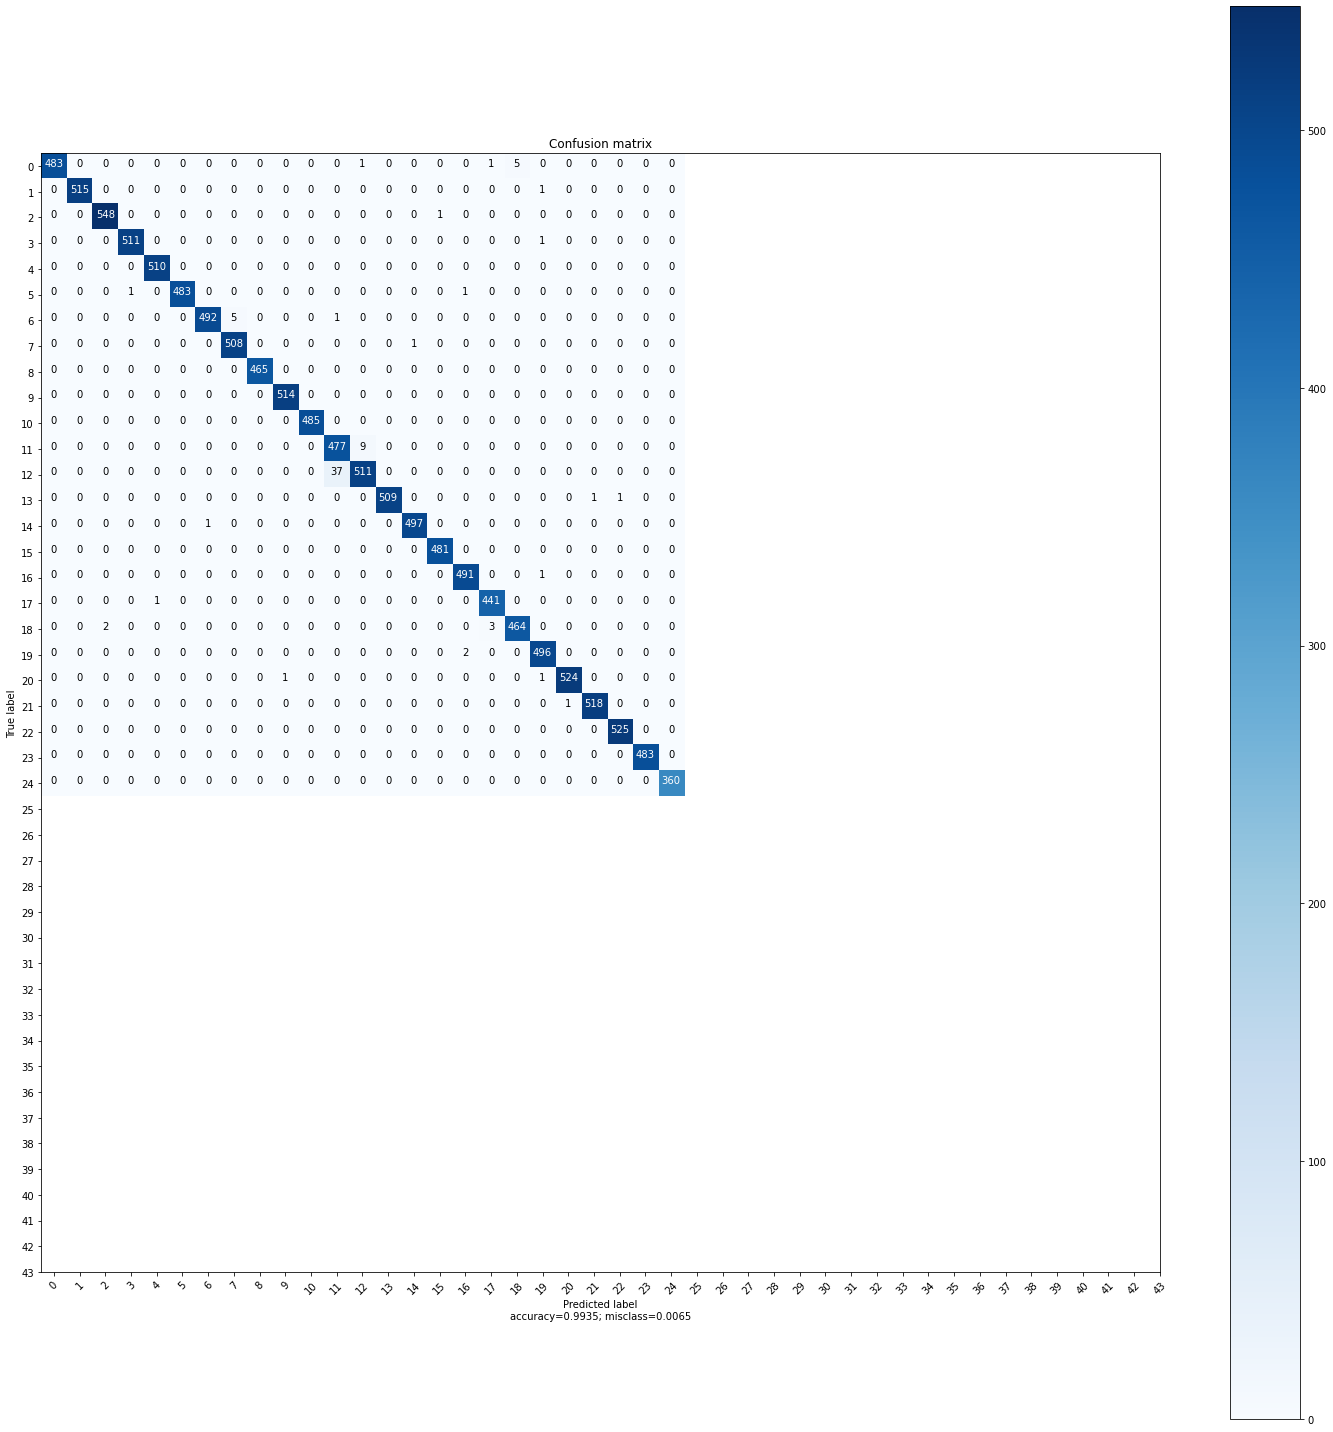

In [21]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion_matrix.png')


image_x, image_y = 50, 50
with open("test_images", "rb") as f:
    test_images = np.array(pickle.load(f))
with open("test_labels", "rb") as f:
    test_labels = np.array(pickle.load(f), dtype=np.int32)
test_images = np.reshape(test_images, (test_images.shape[0], image_x, image_y, 1))


model = load_model('cnn_model_keras_gf.h5')
pred_labels = []

start_time = time.time()
pred_probabs = model.predict(test_images)
end_time = time.time()
pred_time = end_time-start_time
avg_pred_time = pred_time/test_images.shape[0]
print("Time taken to predict %d test images is %ds" %(test_images.shape[0], pred_time))
print('Average prediction time: %fs' % (avg_pred_time))

for pred_probab in pred_probabs:
    pred_labels.append(list(pred_probab).index(max(pred_probab)))

cm = confusion_matrix(test_labels, np.array(pred_labels))
classification_report = classification_report(test_labels, np.array(pred_labels))
print('\n\nClassification Report') 
print('---------------------------')
print(classification_report)
plot_confusion_matrix(cm, range(44), normalize=False)

In [2]:
import cv2, pickle
import numpy as np
import tensorflow as tf
import os
import sqlite3
from keras.models import load_model
import pyttsx3  
import string


engine = pyttsx3.init() 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
prediction = None
model = load_model('cnn_model_keras_gf.h5')

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
        else:
            return False
        
def get_image_size():
    img = cv2.imread('gestures2/1/100.jpg', 0)
    return img.shape

image_x, image_y = get_image_size()



def keras_process_image(img):
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (1, image_x, image_y, 1))
    return img

def keras_predict(model, image):
    processed = keras_process_image(image)
    pred_probab = model.predict(processed)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class

def get_pred_text_from_db(pred_class):
    conn = sqlite3.connect("gesture_db.db")
    cmd = "SELECT g_name FROM gesture WHERE g_id="+str(pred_class)
    cursor = conn.execute(cmd)
    for row in cursor:
        return row[0]

def split_sentence(text, num_of_words):
    '''
    Splits a text into group of num_of_words
    '''
    list_words = text.split(" ")
    length = len(list_words)
    splitted_sentence = []
    b_index = 0
    e_index = num_of_words
    while length > 0:
        part = ""
        for word in list_words[b_index:e_index]:
            part = part + " " + word
        splitted_sentence.append(part)
        b_index += num_of_words
        e_index += num_of_words
        length -= num_of_words
    return splitted_sentence


def get_hand_hist():
    with open("hist", "rb") as f:
        hist = pickle.load(f)
    return hist

def recognize():
    global prediction
    cam = cv2.VideoCapture(0)
    if cam.read()[0] == False:
        cam = cv2.VideoCapture(0)
    hist = get_hand_hist()
    x, y, w, h = 300, 100, 300, 300
    d = dict.fromkeys(string.ascii_lowercase, 0)
    d[''] = 0
    d['space'] = 0
    word = []
    while True:
        text = ""
        img = cam.read()[1]
        img = cv2.flip(img, 1)
        img = cv2.resize(img, (640, 480))
        imgCrop = img[y:y+h, x:x+w]
        imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([imgHSV], [0, 1], hist, [0, 180, 0, 256], 1)
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
        cv2.filter2D(dst,-1,disc,dst)
        blur = cv2.GaussianBlur(dst, (11,11), 0)
        blur = cv2.medianBlur(blur, 11)
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        thresh = cv2.threshold(th3, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
        thresh = cv2.merge((thresh,thresh,thresh))
        thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        thresh = thresh[y:y+h, x:x+w]
        
        (openCV_ver,_,__) = cv2.__version__.split(".")
        if openCV_ver=='3':
            contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
        elif openCV_ver=='4':
            contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
        if len(contours) > 0:
            contour = max(contours, key = cv2.contourArea)
            #print(cv2.contourArea(contour))
            if cv2.contourArea(contour) > 10000:
                x1, y1, w1, h1 = cv2.boundingRect(contour)
                save_img = thresh[y1:y1+h1, x1:x1+w1]

                if w1 > h1:
                    save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                elif h1 > w1:
                    save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))
    
                pred_probab, pred_class = keras_predict(model, save_img)
                
                if pred_probab*100 > 98:
                    text = get_pred_text_from_db(pred_class)
                    #print(text)
                    #engine.say(text) 
                    #engine.runAndWait()
                    if text == '':
                        continue
                    if text == 'space' and d['space'] == 5:
                        text = ''.join([str(elem) for elem in word])        
                        print(text)
                        engine.say(text) 
                        engine.runAndWait()
                        word = []
                        text = ''
                        
                    d[text] += 1
                    #print(d)
                    if d[text] == 10:
                        #print(text)
                        word.append(text)
                        print(word)
                        d = dict.fromkeys(d, 0)
                        engine.say(text) 
                        engine.runAndWait()
                    
                            
                        

        cv2.putText(img, text, (30, 200), cv2.FONT_HERSHEY_TRIPLEX, 1.3, (255, 255, 255))
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)

        cv2.imshow("Recognizing gesture", img)
        cv2.imshow("thresh", thresh)
        if cv2.waitKey(1) == ord('z'):
            break

keras_predict(model, np.zeros((50, 50), dtype=np.uint8))
recognize()
cv2.destroyAllWindows()

['q']
['q', 'a']
['q', 'a', 'b']
['q', 'a', 'b', 'c']
['q', 'a', 'b', 'c', 'b']
['q', 'a', 'b', 'c', 'b', 'b']


In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [12]:
import pyttsx3  
# initialize Text-to-speech engine  
engine = pyttsx3.init()  
# convert this text to speech  
text = "Python is a great programming language"  
engine.say(text)  
# play the speech  
engine.runAndWait() 

In [5]:
import string
d = dict.fromkeys(string.ascii_lowercase, 0)
print(d)

{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': 0, 'g': 0, 'h': 0, 'i': 0, 'j': 0, 'k': 0, 'l': 0, 'm': 0, 'n': 0, 'o': 0, 'p': 0, 'q': 0, 'r': 0, 's': 0, 't': 0, 'u': 0, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0}


In [ ]:
d = dict.fromkeys(string.ascii_lowercase, 0)
text = ' '.join([str(elem) for elem in word])